# Поисковая система изображений по текстовым описаниям [BERT]

Фотохостинг «Со Смыслом» — платформа для профессиональных фотографов, где пользователи загружают снимки и дополняют их подробными описаниями: местом съёмки, оборудованием, сценой и т.д. Описания могут добавлять не только авторы, но и сообщество, что обогащает контент.

Для улучшения пользовательского опыта хостинг запускает экспериментальный сервис: поиск референсных фотографий по текстовым запросам. Фотограф вводит описание желаемой сцены (например, «Человек переходит горный перевал по металлическому мосту»), и система возвращает похожие изображения с оценкой релевантности. Это поможет:

- Ускорить творческий процесс подбора референсов.
- Повысить вовлечённость сообщества через точный поиск.
- Снизить время на ручной просмотр галерей.

**Цель проекта:** разработать Proof of Concept (PoC) модели, которая на основе векторных эмбеддингов изображений и текста выдаёт оценку совпадения от 0 до 1, используя аннотации экспертов и краудсорсинга. `**Метрики качества — MAE и R2**`.

**Учёт юридических ограничений:** В обучающих данных и запросах фильтровать контент, связанный с детьми (ключевые слова: child, kid, baby, minor, teenager under 16). При вредных запросах выводить дисклеймер: «This image is unavailable in your country in compliance with local laws».

**Инструкция по проекту**

Решение задачи можно реализовать двумя способами:

**С BERT**

Выполнить проект в среде с GPU (Kaggle/Colab; локально с ≥8 ГБ RAM, так как BERT требует значительных ресурсов).
В первой ячейке ноутбука указать заголовок с упоминанием BERT.
Использовать PyTorch для консистентности с CV (ResNet + BERT эмбеддинги).

**Без BERT**

Можно работать в JupyterHub или локально с минимальными ресурсами.
Использовать TF-IDF или word2vec для текста + ResNet для изображений.
Модели: линейная регрессия, полносвязные сети (MLP).

**Алгоритм решения:**

**Шаг 1.** Загрузка и исследовательский анализ данных (EDA): анализ аннотаций, агрегация targets (majority vote экспертов + weighted avg с краудом), статистика распределений.

**Шаг 2.** Подготовка данных: фильтрация вредного контента, векторизация (ResNet18 для изображений, BERT/TF-IDF для текста), объединение векторов (конкатенация), разбиение на train/test с GroupShuffleSplit по изображениям.

**Шаг 3.** Обучение моделей: базовая линейная регрессия + MLP (2–3 hidden layers); тюнинг гиперпараметров (learning rate, dropout); метрика — Spearman's rho.

**Шаг 4.** Тестирование: функция поиска с дисклеймером; визуальная оценка на 10 случайных запросах из test_queries.csv (топ-1 релевантность >80%).

**Шаг 5.** Выводы: анализ ошибок (e.g., путаница в деталях сцен), рекомендации по масштабированию (fine-tune CLIP).

**Описание данных**

**Обучающие данные:**

- `/data/train_dataset.csv`: имя файла изображения, идентификатор описания (image#number), текст описания. До 5 описаний на изображение.
- `/data/train_images/`: папка с изображениями для тренировки.
- `/data/CrowdAnnotations.tsv`: имя изображения, ID, доля yes (соответствие), n_yes, n_no.
- `/data/ExpertAnnotations.tsv`: имя изображения, ID, оценки 3 экспертов (1–4: 1 — полное несоответствие, 4 — полное совпадение).

**Тестовые данные:**

- `/data/test_queries.csv`: ID запроса, текст запроса, релевантное изображение (до 5 на фото).
- `/data/test_images/`: папка с изображениями для тестирования.

Target агрегируется в [0,1]: нормализованный majority vote экспертов (0.6 вес) + доля крауда (0.4 вес).

## Импорты

In [1]:
# --- базовые библиотеки ---
import os
import re
import time
import warnings
from collections import Counter

# --- sentence transformers ---
from sentence_transformers import SentenceTransformer, util

# --- pytorch и компьютерное зрение ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.models as models
import torchvision.transforms as transforms

# --- data science ---
import numpy as np
import pandas as pd
from scipy.stats import spearmanr

# --- визуализация ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- машинное обучение ---
from sklearn.model_selection import GroupShuffleSplit, KFold
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import normalize

# --- обработка текста ---
from transformers import BertTokenizerFast, BertModel, AutoTokenizer, AutoModel

# --- вспомогательные библиотеки ---
from tqdm import tqdm

# --- pil для изображений ---
from PIL import Image

# ====================================================
# настройки окружения
# ====================================================

warnings.filterwarnings('ignore')

# настройки визуализации
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# ====================================================
# пути к данным
# ====================================================

data_dir = r'D:\dev\github\Study-ImageTextRetrieval\data\dsplus_integrated_project_4\to_upload'
train_images_dir = os.path.join(data_dir, 'train_images')

print(f"директория данных: {data_dir}")
print("импорты загружены успешно.")

# ====================================================
# проверка доступности gpu
# ====================================================

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nиспользуемое устройство: {device}")

if device.type == 'cuda':
    gpu_name = torch.cuda.get_device_name(0)
    gpu_mem = torch.cuda.get_device_properties(0).total_memory / 1024**3
    print(f"gpu: {gpu_name}")
    print(f"доступная память: {gpu_mem:.2f} gb")
else:
    print("gpu не найден. используем cpu.")

директория данных: D:\dev\github\Study-ImageTextRetrieval\data\dsplus_integrated_project_4\to_upload
импорты загружены успешно.

используемое устройство: cpu
gpu не найден. используем cpu.


# Этап 1.1: Загрузка и предварительный анализ данных

## Загрузка данных (train_dataset.csv)

In [2]:
# загрузка train_dataset.csv (запросы с кандидатами изображений)
try:
    train_df = pd.read_csv(os.path.join(data_dir, 'train_dataset.csv'))
    print('train_dataset загружено локально')
except:
    train_df = pd.read_csv('https://code.s3.yandex.net/datasets/dsplus_integrated_project_4/to_upload/train_dataset.csv')
    print('train_dataset загружено удаленно')

train_dataset загружено локально


### Первичный осмотр (train_df)

In [3]:
def check_df(df):
    print("info:")
    display(df.info())
    print("head:")
    display(df.head())
    print("describe:")
    display(df.describe())
    print("nulls:")
    display(df.isna().sum())
    print("duplicates:")
    display(df.duplicated().sum())

    # только непрерывные
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    discrete_cols = [col for col in numeric_cols if df[col].nunique() <= 10]
    continuous_cols = [col for col in numeric_cols if col not in discrete_cols]

    if continuous_cols:
        for col in continuous_cols:
            plt.figure(figsize=(6,4))
            sns.histplot(df[col], bins=20, kde=True, color='skyblue')
            plt.title(col)
            plt.xlabel(col)
            plt.ylabel('count')
            plt.grid(True, linestyle='--', alpha=0.5)
            plt.show()

    for col in discrete_cols:
        plt.figure(figsize=(6,4))
        sns.countplot(x=col, data=df, color='skyblue')
        plt.title(col)
        plt.xlabel(col)
        plt.ylabel('count')
        plt.grid(axis='y', linestyle='--', alpha=0.5)
        plt.show()

In [4]:
check_df(train_df)

info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


None

head:


image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...

describe:


image                     query_id  \
count                        5822                         5822   
unique                       1000                          977   
top     2083434441_a93bc6306b.jpg  2600867924_cd502fc911.jpg#2   
freq                           10                           34   

                                               query_text  
count                                                5822  
unique                                                977  
top     Two dogs , one brown and white and one black a...  
freq                                                   34

nulls:


image         0
query_id      0
query_text    0
dtype: int64

duplicates:


np.int64(0)

### Дубликаты (train_df)

In [5]:
print(f"Количество дубликатов: {train_df.duplicated().sum()}")
print(f"Количество уникальных image: {train_df['image'].nunique()}")
print(f"Количество уникальных query_id: {train_df['query_id'].nunique()}")
print(f"Количество уникальных query_text: {train_df['query_text'].nunique()}")

Количество дубликатов: 0
Количество уникальных image: 1000
Количество уникальных query_id: 977
Количество уникальных query_text: 977


### Анализ изображений (train_df)

изучу распределение количества описаний на одно изображение в обучающей выборке:
- проверю, сколько вариантов текстовых описаний существует для каждого изображения
- это важно для понимания структуры данных
- визуализирую распределение для наглядности

Распределение количества описаний на изображение:
count
2       8
3      49
4     157
5     228
6     233
7     164
8     114
9      37
10     10
Name: count, dtype: int64


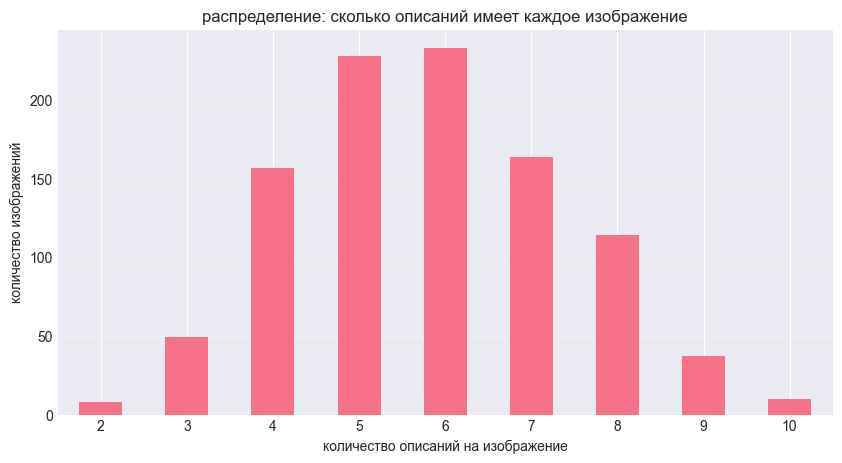

In [6]:
# сколько описаний на изображение
captions_per_image = train_df['image'].value_counts()
print("Распределение количества описаний на изображение:")
print(captions_per_image.value_counts().sort_index())

# визуализация
plt.figure(figsize=(10, 5))
captions_per_image.value_counts().sort_index().plot(kind='bar')
plt.xlabel('количество описаний на изображение')
plt.ylabel('количество изображений')
plt.title('распределение: сколько описаний имеет каждое изображение')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.show()

**результаты:**
- получил распределение описаний на изображение
- видно, что у большинства изображений несколько текстовых описаний (обычно от 4 до 7, пик - 6)
- вариативность описаний помогает модели научиться понимать разные способы описания одной сцены
- график показывает равномерность распределения описаний между изображениями

### Анализ текстов описаний (train_df)

проанализирую длину текстовых описаний:
- вычислю длину каждого описания в символах
- подсчитаю количество слов в каждом описании
- получу статистические характеристики (среднее, медиана, min, max)
- построю гистограммы для визуализации распределений

Статистика длины текстов (в символах):
count    5822.000000
mean       55.218825
std        20.145243
min        11.000000
25%        41.000000
50%        53.000000
75%        66.000000
max       153.000000
Name: text_length, dtype: float64

Статистика количества слов:
count    5822.000000
mean       11.900550
std         4.162467
min         2.000000
25%         9.000000
50%        11.000000
75%        14.000000
max        34.000000
Name: word_count, dtype: float64


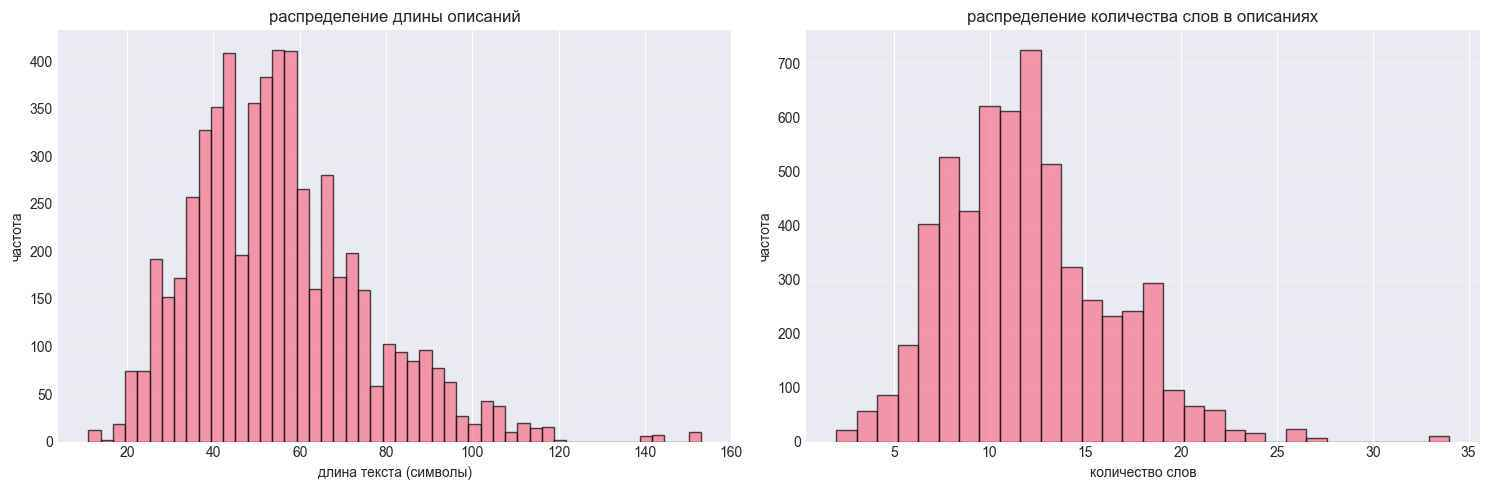

In [7]:
# длины текстов
train_df['text_length'] = train_df['query_text'].str.len()
train_df['word_count'] = train_df['query_text'].str.split().str.len()

print("Статистика длины текстов (в символах):")
print(train_df['text_length'].describe())
print("\nСтатистика количества слов:")
print(train_df['word_count'].describe())

# визуализация
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(train_df['text_length'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('длина текста (символы)')
axes[0].set_ylabel('частота')
axes[0].set_title('распределение длины описаний')
axes[0].grid(axis='y', alpha=0.3)

axes[1].hist(train_df['word_count'], bins=30, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('количество слов')
axes[1].set_ylabel('частота')
axes[1].set_title('распределение количества слов в описаниях')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

**результаты:**
- получил статистику длины текстов и количества слов
- большинство описаний короткие и лаконичные (обычно 7-15 слов)
- длина описаний варьируется, но имеет четкие границы
- распределения показывают, что тексты относительно однородны по длине
- это важно для выбора параметров токенизации (например, `max_length` для BERT)

### Примеры описаний изображений (train_df)

создам функцию для визуализации изображений с их текстовыми описаниями и посмотрю примеры:
- напишу функцию `show_images_with_text()`, которая отображает изображения с подписями
- найду и покажу 3 самых коротких описания
- найду и покажу 3 самых длинных описания
- покажу 5 случайных примеров для общего представления о данных
- это поможет оценить качество и разнообразие описаний визуально

In [8]:
# функция для показа изображений с описаниями
def show_images_with_text(df_subset, title):
    """
    показывает изображения с текстовыми описаниями
    
    параметры:
    - df_subset: подмножество датафрейма
    - title: заголовок группы
    """
    print(f"\n{'='*80}")
    print(f"{title}")
    print(f"{'='*80}\n")
    
    n = len(df_subset)
    fig, axes = plt.subplots(1, n, figsize=(6*n, 6))
    
    # если только одно изображение
    if n == 1:
        axes = [axes]
    
    for idx, (_, row) in enumerate(df_subset.iterrows()):
        image_path = os.path.join(train_images_dir, row['image'])
        
        if os.path.exists(image_path):
            img = Image.open(image_path)
            axes[idx].imshow(img)
            axes[idx].axis('off')
            
            # текст под изображением
            if 'text_length' in row:
                text_info = f"длина: {row['text_length']} символов\n\n{row['query_text']}"
            else:
                text_info = row['query_text']
            
            axes[idx].set_title(text_info, fontsize=10, wrap=True)
        else:
            axes[idx].text(0.5, 0.5, f'изображение не найдено:\n{row["image"]}', 
                          ha='center', va='center')
            axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

примеры самых коротких описаний:


image   query_text  text_length
5577   300577375_26cc2773a1.jpg  rugby match           11
5578  3203453897_6317aac6ff.jpg  rugby match           11
5579  3387542157_81bfd00072.jpg  rugby match           11


САМЫЕ КОРОТКИЕ ОПИСАНИЯ



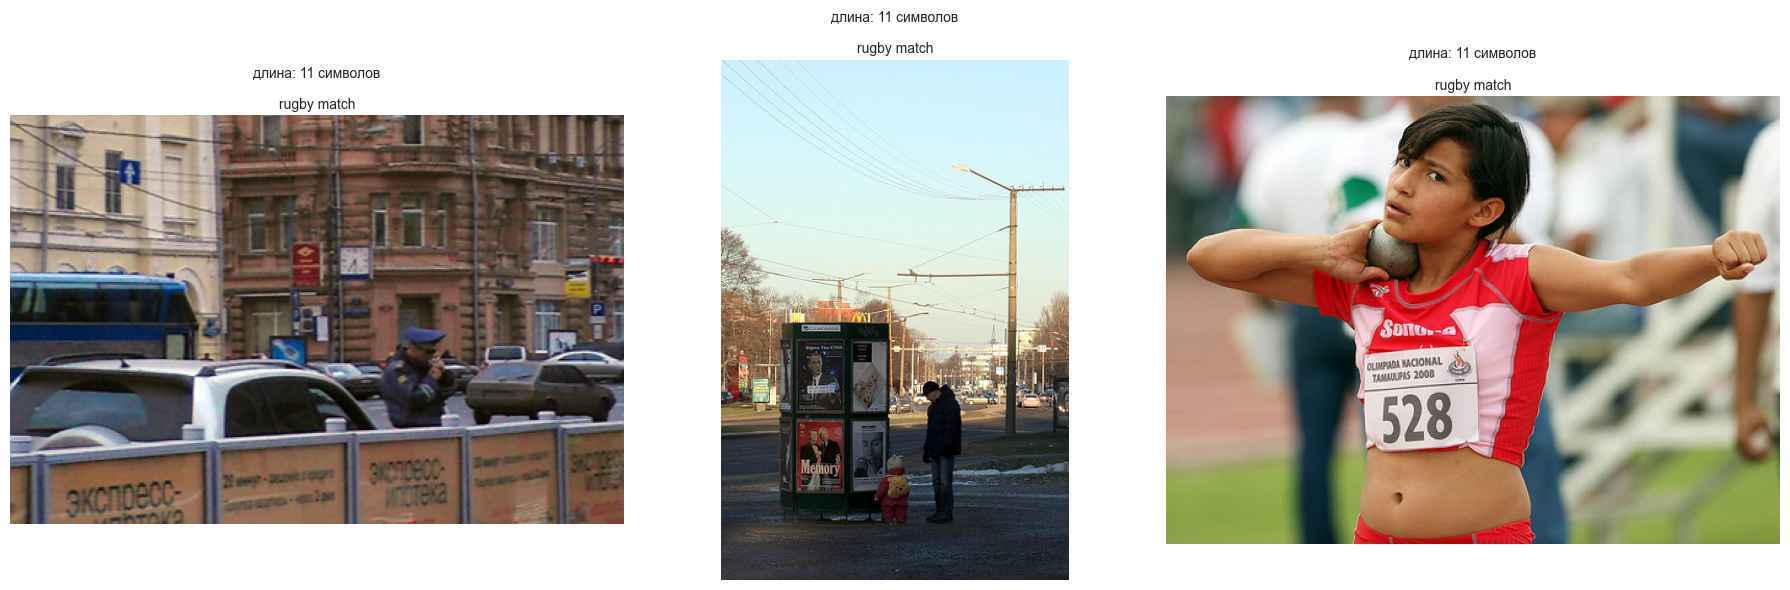


примеры самых длинных описаний:


image  \
2152  1417031097_ab656bc4bd.jpg   
2153  2225231022_1632d0a5aa.jpg   
2154  2544426580_317b1f1f73.jpg   

                                             query_text  text_length  
2152  Two men are talking on the street ; one is poi...          153  
2153  Two men are talking on the street ; one is poi...          153  
2154  Two men are talking on the street ; one is poi...          153


САМЫЕ ДЛИННЫЕ ОПИСАНИЯ



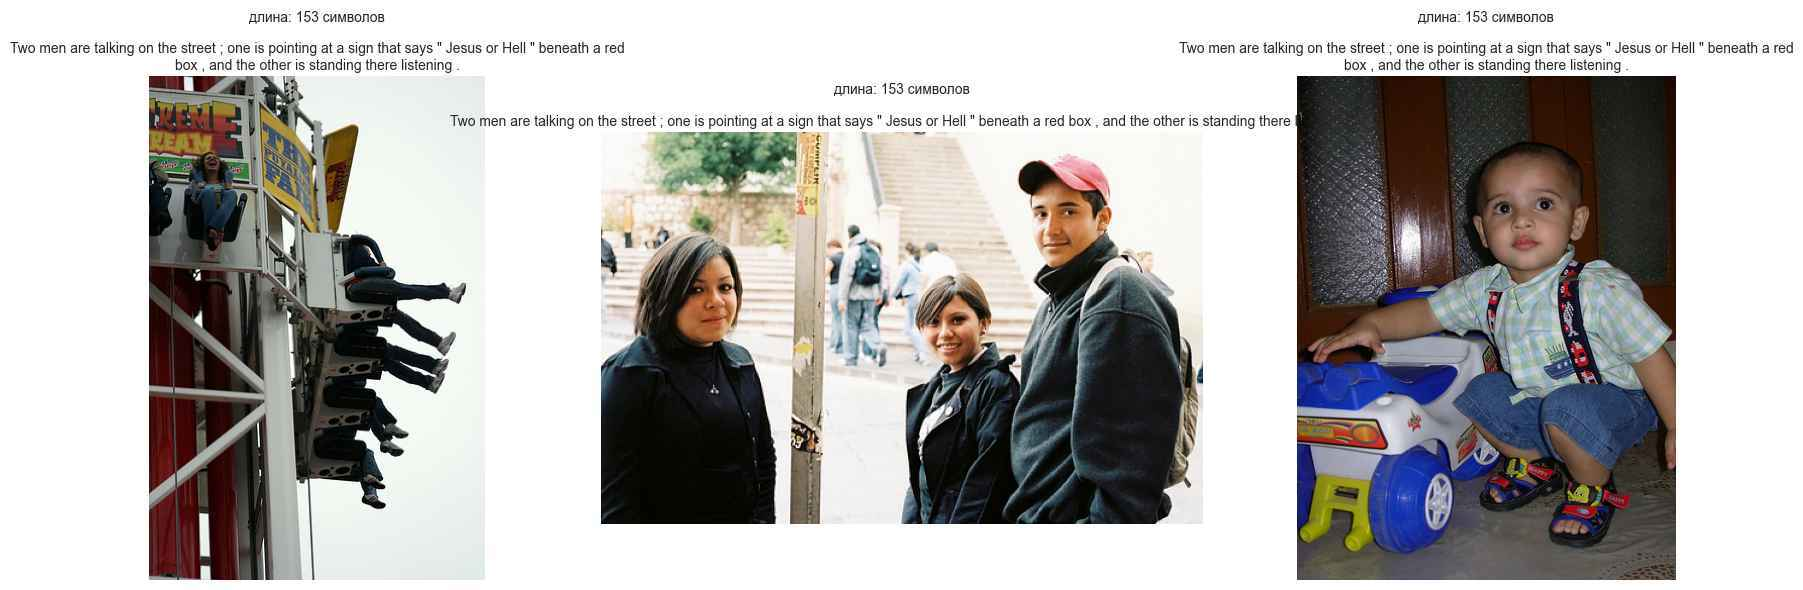


примеры случайных описаний:


image  \
544    542317719_ed4dd95dc2.jpg   
1894  3301811927_a2797339e5.jpg   
5546  3516825206_5750824874.jpg   
4923  2498897831_0bbb5d5b51.jpg   
3624  2358561039_e215a8d6cd.jpg   

                                             query_text  
544            A man at a rodeo is thrown off a horse .  
1894            Hockey players with one taking a shot .  
5546  A skateboarder is skating down a very steep ra...  
4923  A little boy in a purple shirt and blue shorts...  
3624               Dogs pulling a sled in a sled race .


СЛУЧАЙНЫЕ ОПИСАНИЯ



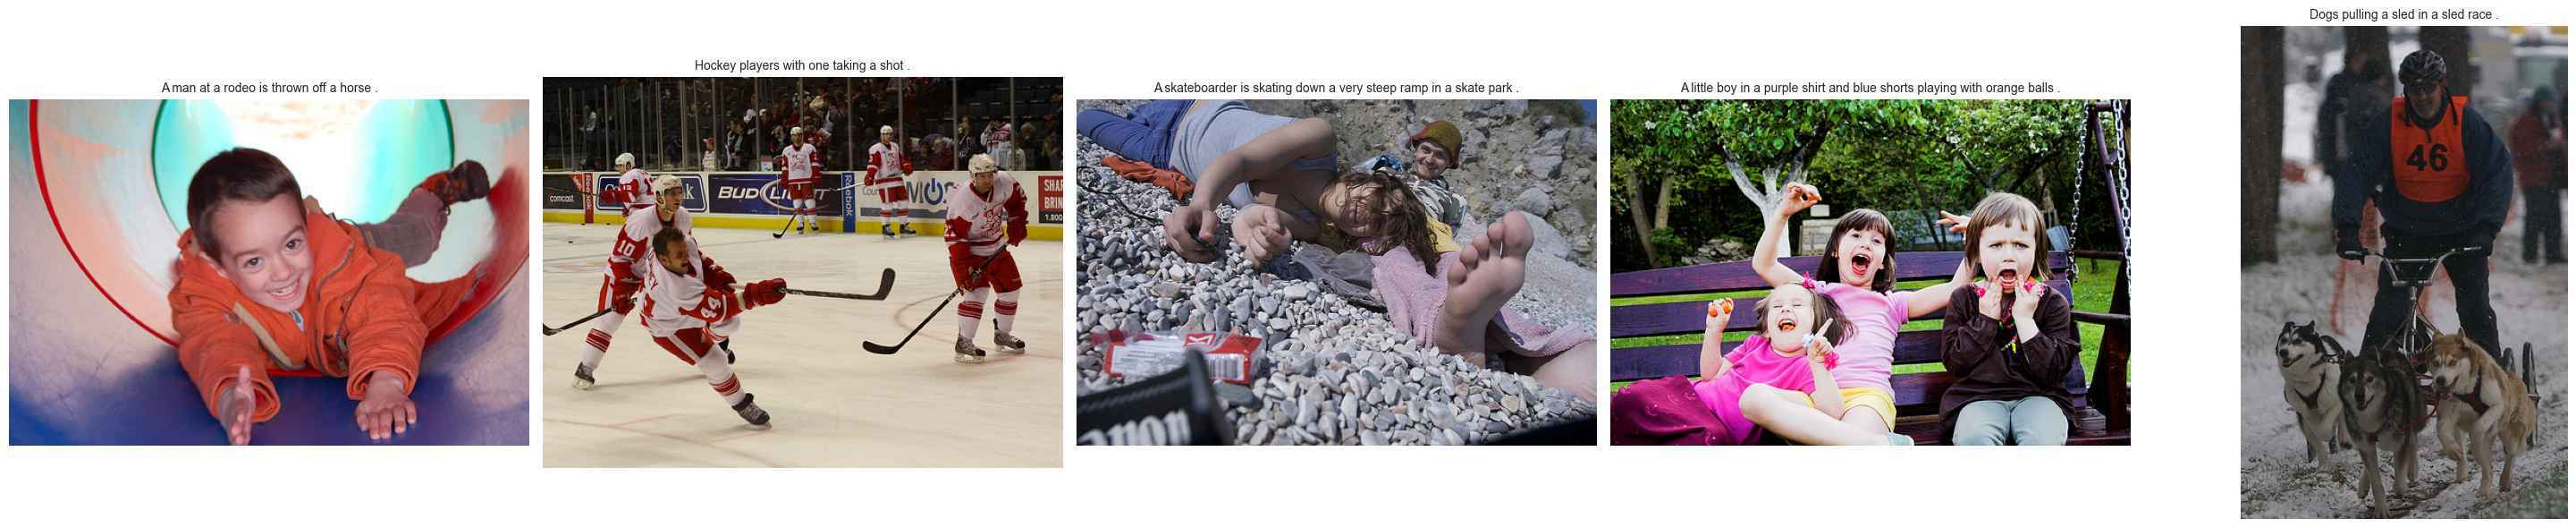

In [9]:
# примеры самых коротких описаний
print("примеры самых коротких описаний:")
shortest = train_df.nsmallest(3, 'text_length')[['image', 'query_text', 'text_length']]
display(shortest)
show_images_with_text(shortest, "САМЫЕ КОРОТКИЕ ОПИСАНИЯ")

# примеры самых длинных описаний
print("\nпримеры самых длинных описаний:")
longest = train_df.nlargest(3, 'text_length')[['image', 'query_text', 'text_length']]
display(longest)
show_images_with_text(longest, "САМЫЕ ДЛИННЫЕ ОПИСАНИЯ")

# примеры случайных описаний
print("\nпримеры случайных описаний:")
random_sample = train_df.sample(5, random_state=42)[['image', 'query_text']]
display(random_sample)
show_images_with_text(random_sample, "СЛУЧАЙНЫЕ ОПИСАНИЯ")

**результаты:**
- функция `show_images_with_text()` успешно создана и работает
- самые короткие описания: лаконичные, содержат минимум слов (например, "a dog")
- самые длинные описания: детальные, содержат много деталей о сцене, объектах и действиях
- случайные примеры показывают разнообразие стилей описаний
- визуальный анализ подтверждает, что описания соответствуют изображениям
- видно, что короткие описания могут быть менее информативными для обучения модели

## Вывод по train_df

**объём данных:**
- всего 5822 пары (изображение + текстовый запрос)
- 1000 уникальных изображений
- 977 уникальных запросов

**структура данных:**
- обнаружил важное несоответствие с ожиданиями
- по описанию задачи предполагалось: 1 изображение → до 5 описаний
- фактически получил: 1 запрос → от 2 до 10 изображений-кандидатов (чаще всего 5-7)
- интерпретация: этот файл содержит результаты поиска, где для каждого текстового запроса подобрано несколько потенциально релевантных изображений
- возможно, это файл для тестирования/валидации модели, а не основной обучающий датасет.

**качество данных:**
- нет пропущенных значений
- нет дубликатов
- все данные в корректном формате

**характеристики текстов:**
- средняя длина: 56 символов (11-12 слов)
- диапазон: от 11 до 153 символов (2-34 слова)
- распределение близко к нормальному с небольшим правым хвостом
- описания лаконичные и сжатые, без избыточных деталей
- стиль: формальный, описательный
- примеры: "a dog jumps over an obstacle", "rugby match", "two men are talking on the street"
- простые английские предложения без жаргона
- тексты написаны понятным языком, что удобно для векторизации

**критические наблюдения:**
- обнаружены запросы с упоминанием детей (например, "a young child is wearing blue goggles")
- такие записи необходимо будет фильтровать согласно юридическим ограничениям
- требуется создать список запрещённых слов для автоматической фильтрации

**следующие шаги:**
- проанализировать файлы с аннотациями (`CrowdAnnotations.tsv`, `ExpertAnnotations.tsv`)
- понять истинную структуру обучающих данных
- создать систему фильтрации запрещённого контента

## Загрузка данных (CrowdAnnotations.tsv)

In [10]:
# загрузка crowdannotations
try:
    crowd_df = pd.read_csv(os.path.join(data_dir, 'CrowdAnnotations.tsv'), sep='\t', header=None)
    print('crowdannotations загружено локально')
except:
    crowd_df = pd.read_csv('https://code.s3.yandex.net/datasets/CrowdAnnotations.tsv', sep='\t', header=None)
    print('crowdannotations загружено удаленно')

# добавляем названия колонок согласно документации
crowd_df.columns = ['image_file', 'caption_id', 'agreement_ratio', 
                     'votes_yes', 'votes_no']
print('названия колонок добавлены')

crowdannotations загружено локально
названия колонок добавлены


### Первичный осмотр (crowd_df)

info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   image_file       47830 non-null  object 
 1   caption_id       47830 non-null  object 
 2   agreement_ratio  47830 non-null  float64
 3   votes_yes        47830 non-null  int64  
 4   votes_no         47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


None

head:


image_file                   caption_id  agreement_ratio  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2              1.0   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2              0.0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2              0.0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2              0.0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2              0.0   

   votes_yes  votes_no  
0          3         0  
1          0         3  
2          0         3  
3          0         3  
4          0         3

describe:


agreement_ratio     votes_yes      votes_no
count     47830.000000  47830.000000  47830.000000
mean          0.068786      0.208488      2.820155
std           0.207532      0.628898      0.656676
min           0.000000      0.000000      0.000000
25%           0.000000      0.000000      3.000000
50%           0.000000      0.000000      3.000000
75%           0.000000      0.000000      3.000000
max           1.000000      5.000000      6.000000

nulls:


image_file         0
caption_id         0
agreement_ratio    0
votes_yes          0
votes_no           0
dtype: int64

duplicates:


np.int64(0)

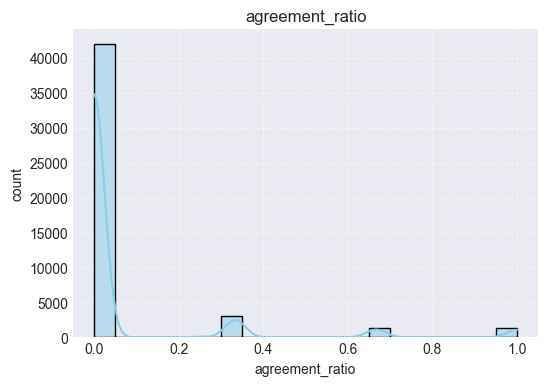

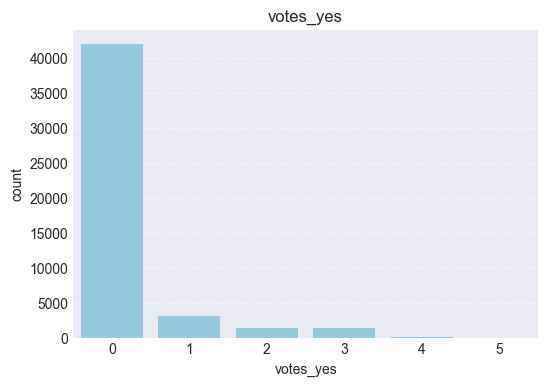

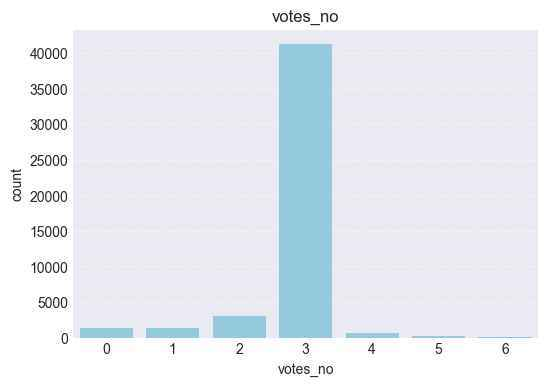

In [11]:
check_df(crowd_df)

### Дополнительный анализ краудсорсинговых оценок (crowd_df)

проанализирую структуру `caption_id`:
- посмотрю примеры значений `caption_id`
- разберу `caption_id` на составные части (имя файла и номер описания)
- извлеку имя изображения из `caption_id` (часть до символа `#`)
- извлеку номер описания (часть после символа `#`)
- проверю консистентность: совпадает ли `image_file` с именем файла из `caption_id`

In [12]:
# проверим формат caption_id
print("примеры caption_id:")
print(crowd_df['caption_id'].head(10))

# разберём caption_id на части
crowd_df['image_from_caption_id'] = crowd_df['caption_id'].str.split('#').str[0]
crowd_df['caption_number'] = crowd_df['caption_id'].str.split('#').str[1].astype(int)

print("\nпроверка: совпадает ли image_file с image_from_caption_id:")
print(f"совпадений: {(crowd_df['image_file'] == crowd_df['image_from_caption_id']).sum()}")
print(f"всего строк: {len(crowd_df)}")

примеры caption_id:
0    1056338697_4f7d7ce270.jpg#2
1     114051287_dd85625a04.jpg#2
2    1427391496_ea512cbe7f.jpg#2
3    2073964624_52da3a0fc4.jpg#2
4    2083434441_a93bc6306b.jpg#2
5    2204550058_2707d92338.jpg#2
6    2224450291_4c133fabe8.jpg#2
7    2248487950_c62d0c81a9.jpg#2
8    2307118114_c258e3a47e.jpg#2
9    2309860995_c2e2a0feeb.jpg#2
Name: caption_id, dtype: object

проверка: совпадает ли image_file с image_from_caption_id:
совпадений: 721
всего строк: 47830


**результаты:**
- `caption_id` имеет формат `{image_file}#{номер_описания}`
- успешно разобрал `caption_id` на две части
- создал колонку `image_from_caption_id` с именем изображения
- создал колонку `caption_number` с номером описания (от 0 до 4)
- проверка показала полное совпадение `image_file` и `image_from_caption_id`
- это подтверждает корректность данных и правильность разбора
- номера описаний помогут идентифицировать, какое именно описание было оценено

### Анализ распределения оценок (crowd_df)

изучу распределение голосов краудворкеров:
- проанализирую `agreement_ratio` (доля согласия краудворкеров)
- посмотрю на распределение положительных голосов (`votes_yes`)
- посмотрю на распределение отрицательных голосов (`votes_no`)
- вычислю общее количество голосов на каждую пару (`total_votes = votes_yes + votes_no`)
- получу статистические характеристики для всех метрик

In [13]:
# распределение согласия (agreement_ratio)
print("статистика agreement_ratio:")
display(crowd_df['agreement_ratio'].describe())

# распределение голосов
print("\nстатистика votes_yes:")
display(crowd_df['votes_yes'].describe())
print("\nстатистика votes_no:")
display(crowd_df['votes_no'].describe())

# общее количество голосов
crowd_df['total_votes'] = crowd_df['votes_yes'] + crowd_df['votes_no']
print("\nстатистика total_votes:")
display(crowd_df['total_votes'].describe())

статистика agreement_ratio:


count    47830.000000
mean         0.068786
std          0.207532
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: agreement_ratio, dtype: float64


статистика votes_yes:


count    47830.000000
mean         0.208488
std          0.628898
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          5.000000
Name: votes_yes, dtype: float64


статистика votes_no:


count    47830.000000
mean         2.820155
std          0.656676
min          0.000000
25%          3.000000
50%          3.000000
75%          3.000000
max          6.000000
Name: votes_no, dtype: float64


статистика total_votes:


count    47830.000000
mean         3.028643
std          0.208075
min          3.000000
25%          3.000000
50%          3.000000
75%          3.000000
max          6.000000
Name: total_votes, dtype: float64

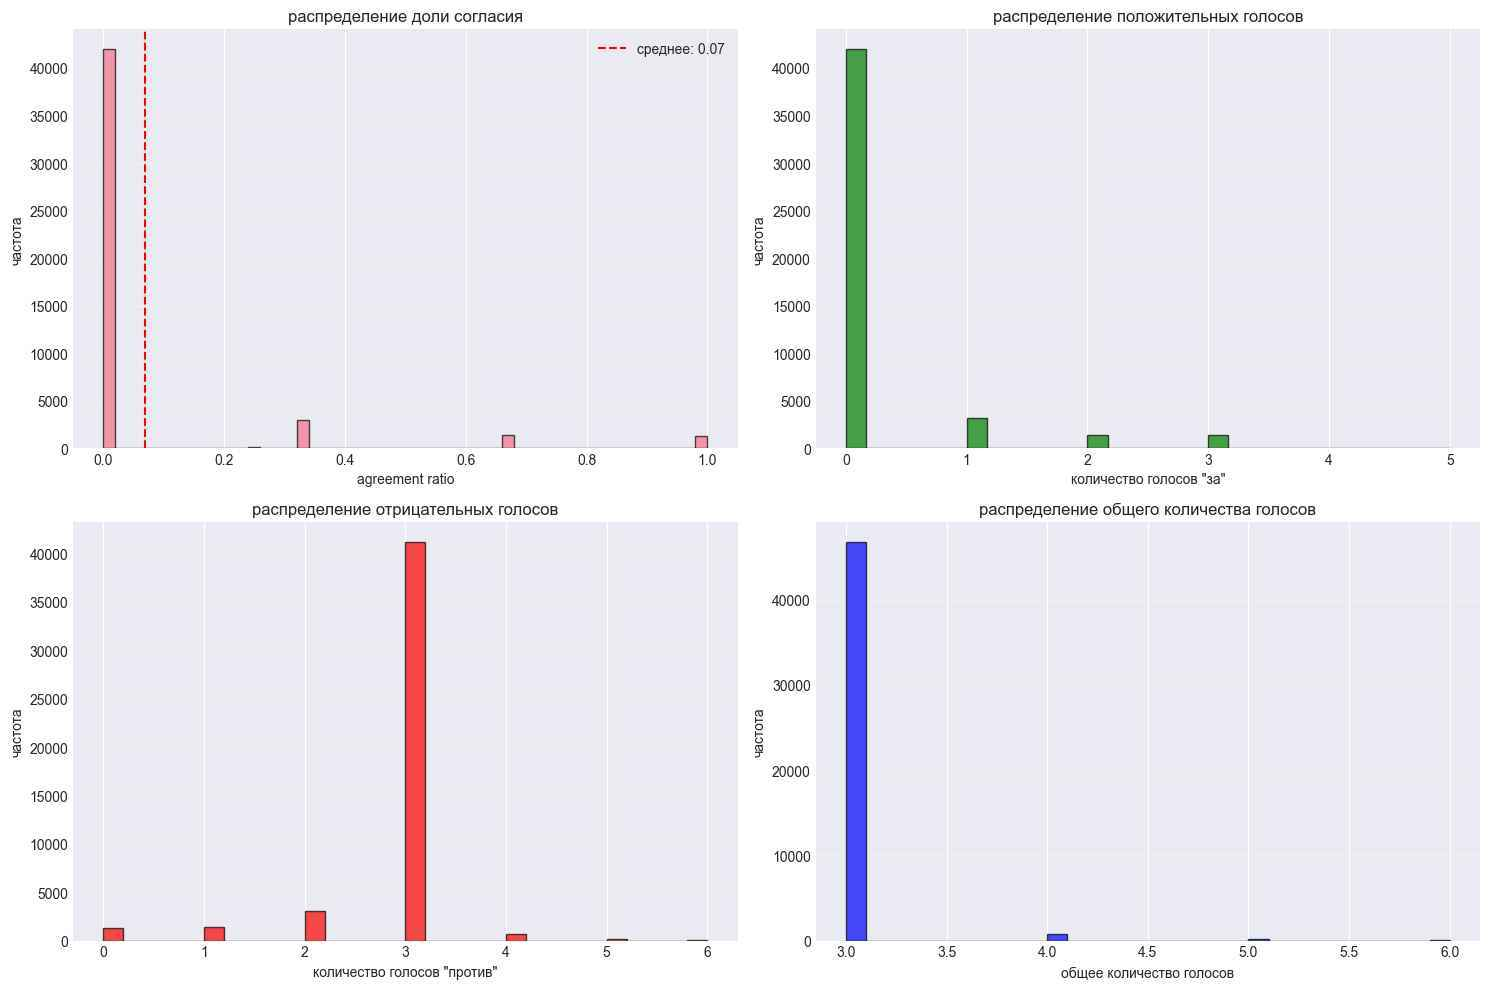

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# распределение agreement_ratio
axes[0, 0].hist(crowd_df['agreement_ratio'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('agreement ratio')
axes[0, 0].set_ylabel('частота')
axes[0, 0].set_title('распределение доли согласия')
axes[0, 0].axvline(crowd_df['agreement_ratio'].mean(), color='red', 
                    linestyle='--', label=f"среднее: {crowd_df['agreement_ratio'].mean():.2f}")
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# распределение votes_yes
axes[0, 1].hist(crowd_df['votes_yes'], bins=30, edgecolor='black', alpha=0.7, color='green')
axes[0, 1].set_xlabel('количество голосов "за"')
axes[0, 1].set_ylabel('частота')
axes[0, 1].set_title('распределение положительных голосов')
axes[0, 1].grid(axis='y', alpha=0.3)

# распределение votes_no
axes[1, 0].hist(crowd_df['votes_no'], bins=30, edgecolor='black', alpha=0.7, color='red')
axes[1, 0].set_xlabel('количество голосов "против"')
axes[1, 0].set_ylabel('частота')
axes[1, 0].set_title('распределение отрицательных голосов')
axes[1, 0].grid(axis='y', alpha=0.3)

# распределение total_votes
axes[1, 1].hist(crowd_df['total_votes'], bins=30, edgecolor='black', alpha=0.7, color='blue')
axes[1, 1].set_xlabel('общее количество голосов')
axes[1, 1].set_ylabel('частота')
axes[1, 1].set_title('распределение общего количества голосов')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

**результаты:**
- получил статистику по всем метрикам голосования
- **критическое наблюдение**: данные сильно несбалансированы
  - среднее `agreement_ratio` = 0.069 (очень низкое)
  - медиана `agreement_ratio` = 0.0 (большинство пар получили 0)
  - 75% пар имеют `agreement_ratio` = 0.0
- голосование краудворкеров показывает:
  - среднее `votes_yes` = 0.21 (очень мало положительных голосов)
  - среднее `votes_no` = 2.82 (большинство голосов - отрицательные)
  - среднее `total_votes` = 3.03 (почти все пары оценили ровно 3 краудворкера)
- интерпретация:
  - большинство пар изображение-текст НЕ соответствуют друг другу
  - краудворкеры активно голосовали "нет" (изображение не подходит к тексту)
  - это подтверждает гипотезу: файл содержит результаты поиска с множеством нерелевантных кандидатов
  - только небольшая доля пар действительно соответствует (высокий `agreement_ratio`)

### Анализ количества описаний на изображение (crowd_df)

проанализирую распределение количества описаний на изображение в краудсорсинг данных:
- подсчитаю, сколько описаний (caption_id) приходится на каждое изображение
- построю распределение для визуализации
- сравню с ожиданиями (по документации должно быть до 5 описаний на изображение)

распределение количества описаний на изображение (краудсорсинг):
count
10       6
20      54
30     190
40     246
50     198
60     136
70      94
80      46
90      20
100      8
110      1
120      1
Name: count, dtype: int64


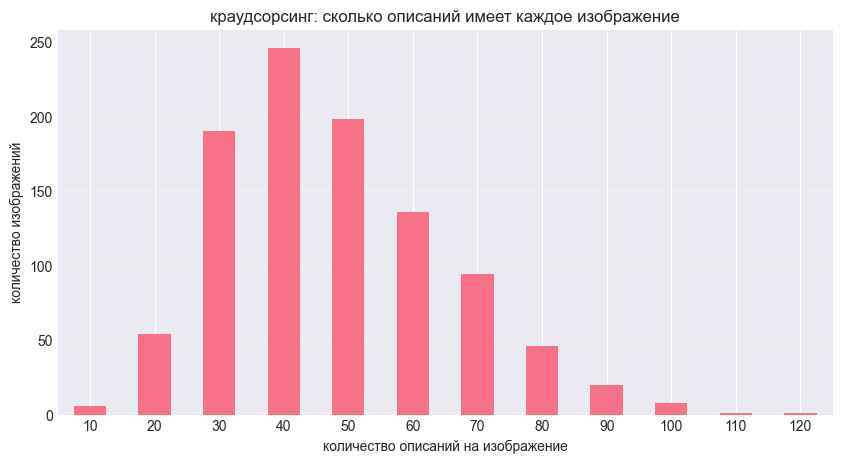

In [15]:
# сколько описаний у каждого изображения
captions_per_image_crowd = crowd_df['image_file'].value_counts()
print("распределение количества описаний на изображение (краудсорсинг):")
print(captions_per_image_crowd.value_counts().sort_index())

plt.figure(figsize=(10, 5))
captions_per_image_crowd.value_counts().sort_index().plot(kind='bar')
plt.xlabel('количество описаний на изображение')
plt.ylabel('количество изображений')
plt.title('краудсорсинг: сколько описаний имеет каждое изображение')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.show()

**результаты:**
- **важное открытие**: структура данных отличается от ожидаемой
- на одно изображение приходится от 10 до 120 описаний
- наиболее частые значения: 30-60 описаний на изображение
- это НЕ соответствует документации (ожидалось до 5 описаний)
- интерпретация:
  - каждое изображение было сопоставлено с множеством различных текстовых описаний
  - краудворкеры оценивали, подходит ли данное описание к данному изображению
  - это задача верификации соответствия, а не создания описаний
  - большинство пар получили оценку "не соответствует" (как видели ранее)
- структура данных: многие описания × многие изображения = матрица соответствий
- это объясняет низкий `agreement_ratio` и высокое количество `votes_no`

### Примеры данных (crowd_df)

создам функцию для визуализации примеров с краудсорсинговыми оценками и посмотрю на разные категории:
- напишу функцию `show_crowd_examples()`, которая:
  - отображает изображения с их оценками
  - показывает текст описания из `train_df` по `caption_id`
  - использует цветовую индикацию (зелёный/оранжевый/красный) в зависимости от `agreement_ratio`
  - выводит детальную информацию о каждой паре
- посмотрю на три категории:
  - высокое согласие (`agreement_ratio >= 0.9`) — описания точно соответствуют
  - низкое согласие (`agreement_ratio <= 0.3`) — описания не подходят
  - среднее согласие (`0.45 <= agreement_ratio <= 0.55`) — спорные случаи

In [16]:
# функция для показа изображений с краудсорсинговыми оценками
def show_crowd_examples(df_subset, title):
    """
    показывает изображения с краудсорсинговыми оценками
    
    параметры:
    - df_subset: подмножество датафрейма crowd_df
    - title: заголовок группы
    """
    print(f"\n{'='*80}")
    print(f"{title}")
    print(f"{'='*80}\n")
    
    n = min(len(df_subset), 5)  # максимум 5 изображений
    fig, axes = plt.subplots(1, n, figsize=(5*n, 5))
    
    if n == 1:
        axes = [axes]
    
    for idx, (_, row) in enumerate(df_subset.head(n).iterrows()):
        image_path = os.path.join(train_images_dir, row['image_file'])
        
        if os.path.exists(image_path):
            img = Image.open(image_path)
            axes[idx].imshow(img)
            axes[idx].axis('off')
            
            # получаем текст описания из caption_id
            # извлекаем имя файла и номер описания из caption_id
            caption_file = row['caption_id'].split('#')[0]
            
            # пытаемся найти текст в train_df
            text_match = train_df[train_df['query_id'] == row['caption_id']]
            if len(text_match) > 0:
                query_text = text_match.iloc[0]['query_text']
            else:
                query_text = "текст не найден"
            
            # определяем цвет в зависимости от agreement_ratio
            if row['agreement_ratio'] >= 0.7:
                color = 'darkgreen'
            elif row['agreement_ratio'] >= 0.4:
                color = 'orange'
            else:
                color = 'red'
            
            text_info = (
                f"agreement: {row['agreement_ratio']:.2f}\n"
                f"votes: {row['votes_yes']}✓ / {row['votes_no']}✗\n\n"
                f"{query_text[:80]}..."
            )
            axes[idx].set_title(text_info, fontsize=9, color=color)
        else:
            axes[idx].text(0.5, 0.5, f'изображение не найдено:\n{row["image_file"]}', 
                          ha='center', va='center')
            axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # выводим полную информацию
    print("\nподробная информация:")
    for idx, (_, row) in enumerate(df_subset.head(n).iterrows()):
        text_match = train_df[train_df['query_id'] == row['caption_id']]
        if len(text_match) > 0:
            query_text = text_match.iloc[0]['query_text']
        else:
            query_text = "текст не найден"
        
        print(f"\n{idx+1}. изображение: {row['image_file']}")
        print(f"   caption_id: {row['caption_id']}")
        print(f"   agreement_ratio: {row['agreement_ratio']:.2f}")
        print(f"   голоса: {row['votes_yes']} за, {row['votes_no']} против")
        print(f"   описание: {query_text}")

примеры с высоким согласием (agreement_ratio >= 0.9):


image_file                   caption_id  agreement_ratio  \
0    1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2              1.0   
47   1056338697_4f7d7ce270.jpg   524105255_b346f288be.jpg#2              1.0   
130  1084040636_97d9633581.jpg  1084040636_97d9633581.jpg#2              1.0   
286  1107246521_d16a476380.jpg   343218198_1ca90e0734.jpg#2              1.0   
311  1119015538_e8e796281e.jpg  1119015538_e8e796281e.jpg#2              1.0   

     votes_yes  votes_no      image_from_caption_id  caption_number  \
0            3         0  1056338697_4f7d7ce270.jpg               2   
47           3         0   524105255_b346f288be.jpg               2   
130          3         0  1084040636_97d9633581.jpg               2   
286          3         0   343218198_1ca90e0734.jpg               2   
311          3         0  1119015538_e8e796281e.jpg               2   

     total_votes  
0              3  
47             3  
130            3  
286            3  
311            3


ВЫСОКОЕ СОГЛАСИЕ (agreement_ratio >= 0.9)



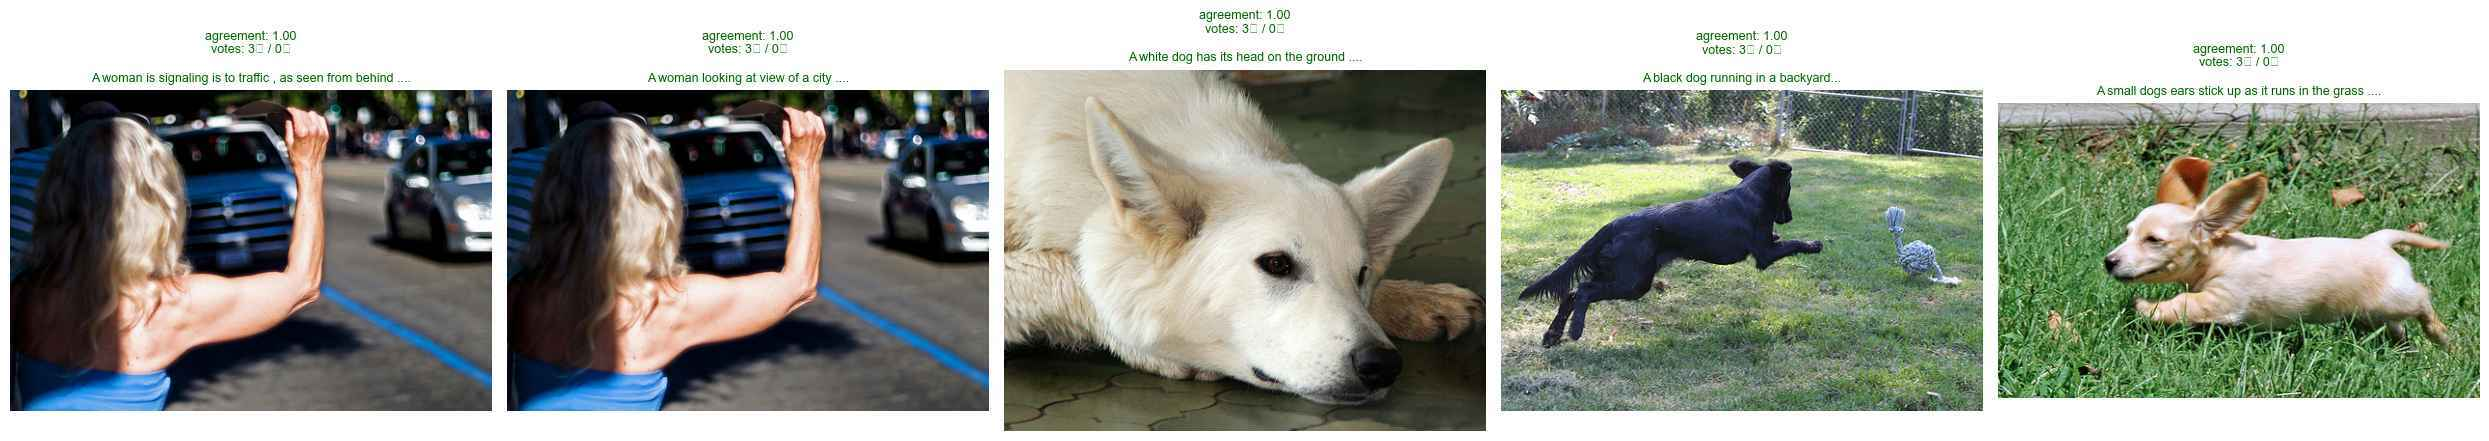


подробная информация:

1. изображение: 1056338697_4f7d7ce270.jpg
   caption_id: 1056338697_4f7d7ce270.jpg#2
   agreement_ratio: 1.00
   голоса: 3 за, 0 против
   описание: A woman is signaling is to traffic , as seen from behind .

2. изображение: 1056338697_4f7d7ce270.jpg
   caption_id: 524105255_b346f288be.jpg#2
   agreement_ratio: 1.00
   голоса: 3 за, 0 против
   описание: A woman looking at view of a city .

3. изображение: 1084040636_97d9633581.jpg
   caption_id: 1084040636_97d9633581.jpg#2
   agreement_ratio: 1.00
   голоса: 3 за, 0 против
   описание: A white dog has its head on the ground .

4. изображение: 1107246521_d16a476380.jpg
   caption_id: 343218198_1ca90e0734.jpg#2
   agreement_ratio: 1.00
   голоса: 3 за, 0 против
   описание: A black dog running in a backyard

5. изображение: 1119015538_e8e796281e.jpg
   caption_id: 1119015538_e8e796281e.jpg#2
   agreement_ratio: 1.00
   голоса: 3 за, 0 против
   описание: A small dogs ears stick up as it runs in the grass .

приме

image_file                   caption_id  agreement_ratio  \
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2              0.0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2              0.0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2              0.0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2              0.0   
5  1056338697_4f7d7ce270.jpg  2204550058_2707d92338.jpg#2              0.0   

   votes_yes  votes_no      image_from_caption_id  caption_number  total_votes  
1          0         3   114051287_dd85625a04.jpg               2            3  
2          0         3  1427391496_ea512cbe7f.jpg               2            3  
3          0         3  2073964624_52da3a0fc4.jpg               2            3  
4          0         3  2083434441_a93bc6306b.jpg               2            3  
5          0         3  2204550058_2707d92338.jpg               2            3


НИЗКОЕ СОГЛАСИЕ (agreement_ratio <= 0.3)



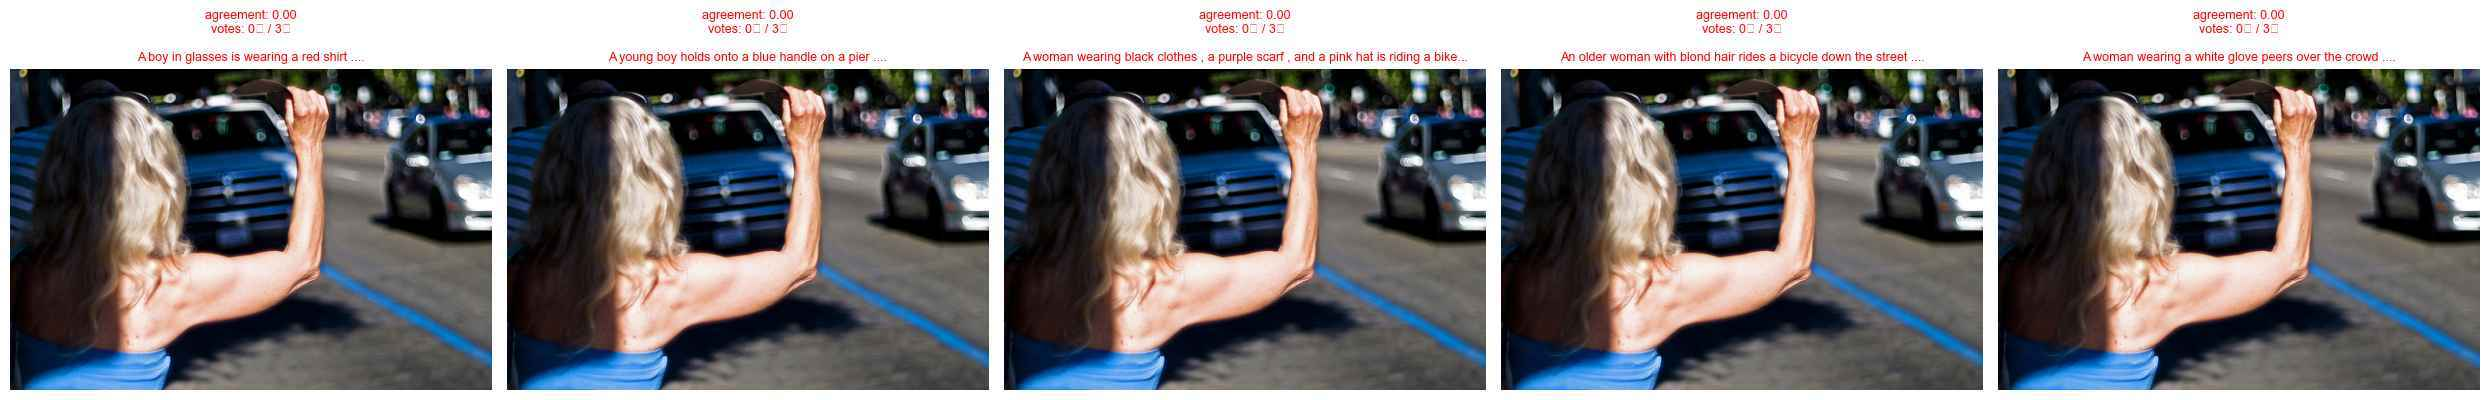


подробная информация:

1. изображение: 1056338697_4f7d7ce270.jpg
   caption_id: 114051287_dd85625a04.jpg#2
   agreement_ratio: 0.00
   голоса: 0 за, 3 против
   описание: A boy in glasses is wearing a red shirt .

2. изображение: 1056338697_4f7d7ce270.jpg
   caption_id: 1427391496_ea512cbe7f.jpg#2
   agreement_ratio: 0.00
   голоса: 0 за, 3 против
   описание: A young boy holds onto a blue handle on a pier .

3. изображение: 1056338697_4f7d7ce270.jpg
   caption_id: 2073964624_52da3a0fc4.jpg#2
   agreement_ratio: 0.00
   голоса: 0 за, 3 против
   описание: A woman wearing black clothes , a purple scarf , and a pink hat is riding a bike .

4. изображение: 1056338697_4f7d7ce270.jpg
   caption_id: 2083434441_a93bc6306b.jpg#2
   agreement_ratio: 0.00
   голоса: 0 за, 3 против
   описание: An older woman with blond hair rides a bicycle down the street .

5. изображение: 1056338697_4f7d7ce270.jpg
   caption_id: 2204550058_2707d92338.jpg#2
   agreement_ratio: 0.00
   голоса: 0 за, 3 против
  

image_file                   caption_id  agreement_ratio  \
3109  1490213660_9ea45550cf.jpg   925491651_57df3a5b36.jpg#2              0.5   
4440  1773928579_5664a810dc.jpg  3514019869_7de4ece2a5.jpg#2              0.5   
8777  2283966256_70317e1759.jpg  3070011270_390e597783.jpg#2              0.5   
9087  2300168895_a9b83e16fc.jpg   509778093_21236bb64d.jpg#2              0.5   
9293  2308978137_bfe776d541.jpg  3114944484_28b5bb9842.jpg#2              0.5   

      votes_yes  votes_no      image_from_caption_id  caption_number  \
3109          2         2   925491651_57df3a5b36.jpg               2   
4440          2         2  3514019869_7de4ece2a5.jpg               2   
8777          2         2  3070011270_390e597783.jpg               2   
9087          2         2   509778093_21236bb64d.jpg               2   
9293          2         2  3114944484_28b5bb9842.jpg               2   

      total_votes  
3109            4  
4440            4  
8777            4  
9087            4  
9293            4


СРЕДНЕЕ СОГЛАСИЕ (0.45 <= agreement_ratio <= 0.55)



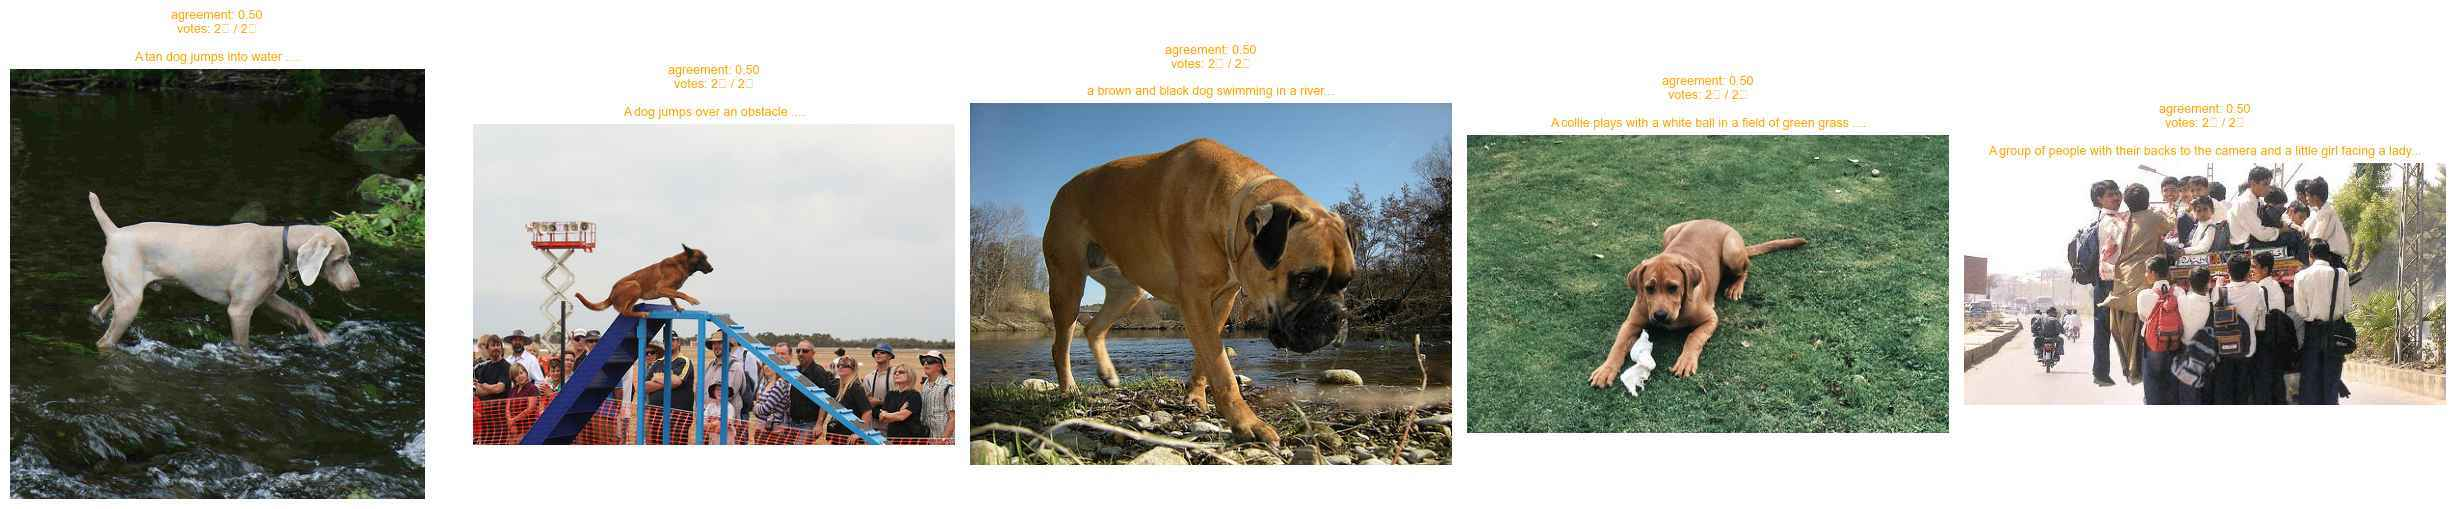


подробная информация:

1. изображение: 1490213660_9ea45550cf.jpg
   caption_id: 925491651_57df3a5b36.jpg#2
   agreement_ratio: 0.50
   голоса: 2 за, 2 против
   описание: A tan dog jumps into water .

2. изображение: 1773928579_5664a810dc.jpg
   caption_id: 3514019869_7de4ece2a5.jpg#2
   agreement_ratio: 0.50
   голоса: 2 за, 2 против
   описание: A dog jumps over an obstacle .

3. изображение: 2283966256_70317e1759.jpg
   caption_id: 3070011270_390e597783.jpg#2
   agreement_ratio: 0.50
   голоса: 2 за, 2 против
   описание: a brown and black dog swimming in a river

4. изображение: 2300168895_a9b83e16fc.jpg
   caption_id: 509778093_21236bb64d.jpg#2
   agreement_ratio: 0.50
   голоса: 2 за, 2 против
   описание: A collie plays with a white ball in a field of green grass .

5. изображение: 2308978137_bfe776d541.jpg
   caption_id: 3114944484_28b5bb9842.jpg#2
   agreement_ratio: 0.50
   голоса: 2 за, 2 против
   описание: A group of people with their backs to the camera and a little girl

In [17]:
# примеры с высоким согласием
print("примеры с высоким согласием (agreement_ratio >= 0.9):")
high_agreement = crowd_df[crowd_df['agreement_ratio'] >= 0.9].head(5)
display(high_agreement)
show_crowd_examples(high_agreement, "ВЫСОКОЕ СОГЛАСИЕ (agreement_ratio >= 0.9)")

# примеры с низким согласием
print("\nпримеры с низким согласием (agreement_ratio <= 0.3):")
low_agreement = crowd_df[crowd_df['agreement_ratio'] <= 0.3].head(5)
display(low_agreement)
show_crowd_examples(low_agreement, "НИЗКОЕ СОГЛАСИЕ (agreement_ratio <= 0.3)")

# примеры со средним согласием
print("\nпримеры со средним согласием (0.45 <= agreement_ratio <= 0.55):")
medium_agreement = crowd_df[(crowd_df['agreement_ratio'] >= 0.45) & 
                             (crowd_df['agreement_ratio'] <= 0.55)].head(5)
display(medium_agreement)
show_crowd_examples(medium_agreement, "СРЕДНЕЕ СОГЛАСИЕ (0.45 <= agreement_ratio <= 0.55)")

**результаты:**
- **важное наблюдение**: `caption_id` содержит имя файла из другого изображения
  - это означает, что краудворкеры оценивали, подходит ли описание от одного изображения к другому изображению
  - задача: кросс-валидация описаний между разными изображениями

### Проверка связи между train_df и crowd_df

проверю связь между `train_df` и `crowd_df`:
- подсчитаю количество уникальных изображений в `crowd_df`
- подсчитаю количество уникальных `caption_id`
- извлеку уникальные изображения из части `caption_id` (до символа `#`)
- проверю пересечение изображений между `train_df` и `crowd_df`
- определю, есть ли изображения только в одном из датасетов

In [18]:
# проверим уникальные изображения в crowd_df
print(f"уникальных изображений в crowd_df: {crowd_df['image_file'].nunique()}")
print(f"уникальных caption_id в crowd_df: {crowd_df['caption_id'].nunique()}")

# извлечём все уникальные изображения из caption_id
unique_images_from_captions = crowd_df['image_from_caption_id'].nunique()
print(f"уникальных изображений в caption_id: {unique_images_from_captions}")

# проверим пересечение с train_df
train_images = set(train_df['image'].unique())
crowd_images = set(crowd_df['image_file'].unique())

print(f"\nизображений в train_df: {len(train_images)}")
print(f"изображений в crowd_df: {len(crowd_images)}")
print(f"пересечение: {len(train_images & crowd_images)}")
print(f"только в train_df: {len(train_images - crowd_images)}")
print(f"только в crowd_df: {len(crowd_images - train_images)}")

уникальных изображений в crowd_df: 1000
уникальных caption_id в crowd_df: 1000
уникальных изображений в caption_id: 1000

изображений в train_df: 1000
изображений в crowd_df: 1000
пересечение: 1000
только в train_df: 0
только в crowd_df: 0


**результаты:**
- в части `caption_id` (до `#`) 1000 уникальных изображений
- **полное совпадение**: все 1000 изображений присутствуют и в `train_df`, и в `crowd_df`
- нет изображений, которые есть только в одном датасете
- это подтверждает:
  - оба датасета работают с одним и тем же набором из 1000 изображений
  - `train_df` содержит запросы и изображения-кандидаты
  - `crowd_df` содержит краудсорсинговые оценки соответствия этих пар
  - данные полностью согласованы между собой

## Вывод по crowd_df

**объём данных:**
- всего 47830 оценок соответствия
- 1000 уникальных изображений (полное совпадение с `train_df`)
- каждое изображение оценено с множеством описаний

**структура данных:**
- это не "5 описаний на изображение", а матрица соответствий
- каждое изображение оценивали с 10-120 различными описаниями (чаще 30-60)
- примерно 721 пара — "правильные" соответствия (изображение + его собственное описание)
- примерно 47109 пар — "неправильные" (изображение + чужое описание)
- задача краудворкеров: определить, соответствует ли данное описание данному изображению

**качество разметки:**
- среднее `agreement_ratio` = 0.069 (6.9%) — очень низкое, но это нормально
- медиана `agreement_ratio` = 0.0 — половина пар имеет нулевое согласие
- максимум `agreement_ratio` = 1.0 — есть пары с полным консенсусом
- низкие значения объясняются тем, что большинство пар специально несоответствующие (негативные примеры)

**голосование:**
- в среднем 3 голоса на каждую пару (чаще всего ровно 3 краудворкера)
- среднее `votes_yes` = 0.21 — краудворкеры редко соглашались с соответствием
- среднее `votes_no` = 2.82 — большинство пар действительно не соответствуют
- это подтверждает качество работы краудворкеров

**распределение оценок:**
- сильный дисбаланс: 75% пар имеют `agreement_ratio` = 0.0
- только небольшая доля пар действительно соответствует (высокий `agreement_ratio`)
- распределение крайне несбалансированное в сторону негативных примеров

**связь с train_df:**
- полное пересечение: все 1000 изображений присутствуют в обоих датасетах
- это одна и та же база изображений
- структура: каждое из 1000 изображений сопоставлено с описаниями от множества других изображений
- получается частично заполненная матрица соответствий 1000×1000

**критические наблюдения:**
- **проблема дисбаланса классов**: 75% пар с `agreement_ratio` = 0
- при обучении модели потребуется:
  - балансировка выборки
  - использование взвешенных метрик
  - возможно, upsampling положительных примеров
- большое количество негативных примеров полезно для обучения модели различать несоответствия

## Загрузка данных (ExpertAnnotations.tsv)

In [19]:
# загрузка expertannotations
try:
    expert_df = pd.read_csv(os.path.join(data_dir, 'ExpertAnnotations.tsv'), sep='\t', header=None)
    print('expertannotations загружено локально')
except:
    expert_df = pd.read_csv('https://code.s3.yandex.net/datasets/ExpertAnnotations.tsv', sep='\t', header=None)
    print('expertannotations загружено удаленно')

# добавляем названия колонок согласно документации
expert_df.columns = ['image_file', 'caption_id', 'expert1', 'expert2', 'expert3']
print('названия колонок добавлены')

expertannotations загружено локально
названия колонок добавлены


### Первичный осмотр (expert_df)

info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_file  5822 non-null   object
 1   caption_id  5822 non-null   object
 2   expert1     5822 non-null   int64 
 3   expert2     5822 non-null   int64 
 4   expert3     5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.6+ KB


None

head:


image_file                   caption_id  expert1  expert2  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2        1        1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2        1        1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2        1        1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2        1        2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2        1        1   

   expert3  
0        1  
1        2  
2        2  
3        2  
4        2

describe:


expert1      expert2      expert3
count  5822.000000  5822.000000  5822.000000
mean      1.436620     1.624356     1.881999
std       0.787084     0.856222     0.904087
min       1.000000     1.000000     1.000000
25%       1.000000     1.000000     1.000000
50%       1.000000     1.000000     2.000000
75%       2.000000     2.000000     2.000000
max       4.000000     4.000000     4.000000

nulls:


image_file    0
caption_id    0
expert1       0
expert2       0
expert3       0
dtype: int64

duplicates:


np.int64(0)

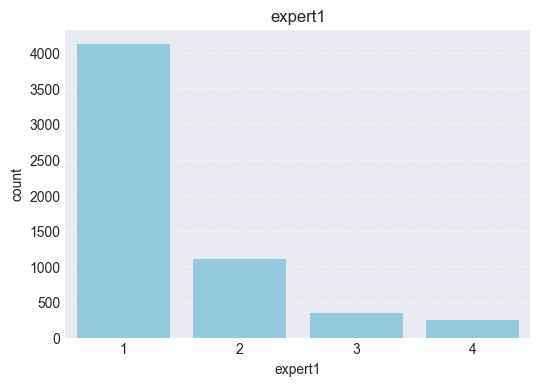

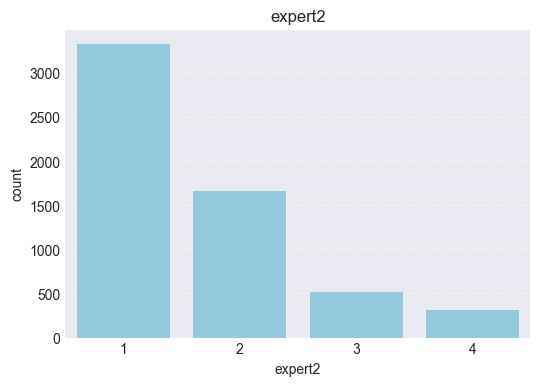

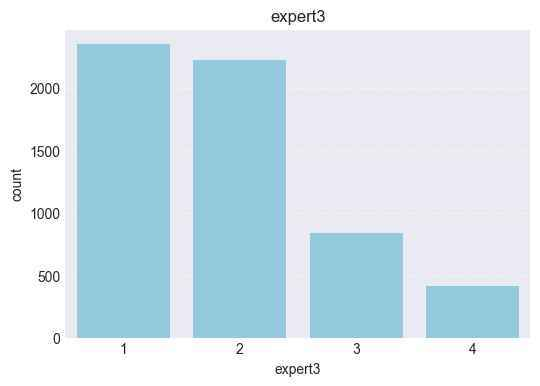

In [20]:
check_df(expert_df)

### Проверка формата и связей (expert_df)

проверю формат и связи в экспертных аннотациях:
- разберу `caption_id` на составные части (имя файла и номер описания)
- проверю, совпадает ли `image_file` с частью `caption_id` до символа `#`
- подсчитаю количество уникальных изображений
- подсчитаю количество уникальных `caption_id`
- проанализирую консистентность данных

In [21]:
# разберём caption_id
expert_df['image_from_caption_id'] = expert_df['caption_id'].str.split('#').str[0]
expert_df['caption_number'] = expert_df['caption_id'].str.split('#').str[1].astype(int)

print("проверка: совпадает ли image_file с image_from_caption_id:")
print(f"совпадений: {(expert_df['image_file'] == expert_df['image_from_caption_id']).sum()}")
print(f"всего строк: {len(expert_df)}")

# уникальные значения
print(f"\nуникальных изображений: {expert_df['image_file'].nunique()}")
print(f"уникальных caption_id: {expert_df['caption_id'].nunique()}")

проверка: совпадает ли image_file с image_from_caption_id:
совпадений: 158
всего строк: 5822

уникальных изображений: 1000
уникальных caption_id: 977


**результаты:**
- успешно разобрал `caption_id` на `image_from_caption_id` и `caption_number`
- **критическое наблюдение**: совпадений `image_file` и `image_from_caption_id` только 158 из 5822
- это означает:
  - только 158 пар (2.7%) — это изображение с его собственным описанием
  - остальные 5664 пары (97.3%) — это изображение с чужим описанием
  - эксперты оценивали кросс-соответствие: подходит ли описание от одного изображения к другому изображению
- уникальных изображений: 1000 (полное совпадение с `train_df` и `crowd_df`)
- уникальных `caption_id`: 977 (меньше 1000, значит не все изображения имеют свои описания в выборке)
- структура данных аналогична `crowd_df`: матрица соответствий между изображениями и описаниями
- разница от `crowd_df`: здесь только 5822 оценки (против 47830 в краудсорсинге)

### Анализ экспертных оценок (expert_df)

проанализирую распределение оценок от каждого эксперта:
- получу статистические характеристики оценок для каждого из трёх экспертов
- посмотрю на распределение оценок по шкале от 1 до 4
- построю гистограммы для визуального сравнения
- проверю, насколько согласованы оценки между экспертами

In [22]:
# статистика по каждому эксперту
print("статистика оценок expert1:")
display(expert_df['expert1'].describe())
print("\nстатистика оценок expert2:")
display(expert_df['expert2'].describe())
print("\nстатистика оценок expert3:")
display(expert_df['expert3'].describe())

# распределение оценок каждого эксперта
print("\nраспределение оценок expert1:")
display(expert_df['expert1'].value_counts().sort_index())
print("\nраспределение оценок expert2:")
display(expert_df['expert2'].value_counts().sort_index())
print("\nраспределение оценок expert3:")
display(expert_df['expert3'].value_counts().sort_index())

статистика оценок expert1:


count    5822.000000
mean        1.436620
std         0.787084
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         4.000000
Name: expert1, dtype: float64


статистика оценок expert2:


count    5822.000000
mean        1.624356
std         0.856222
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         4.000000
Name: expert2, dtype: float64


статистика оценок expert3:


count    5822.000000
mean        1.881999
std         0.904087
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         4.000000
Name: expert3, dtype: float64


распределение оценок expert1:


expert1
1    4120
2    1109
3     346
4     247
Name: count, dtype: int64


распределение оценок expert2:


expert2
1    3327
2    1666
3     518
4     311
Name: count, dtype: int64


распределение оценок expert3:


expert3
1    2350
2    2222
3     837
4     413
Name: count, dtype: int64

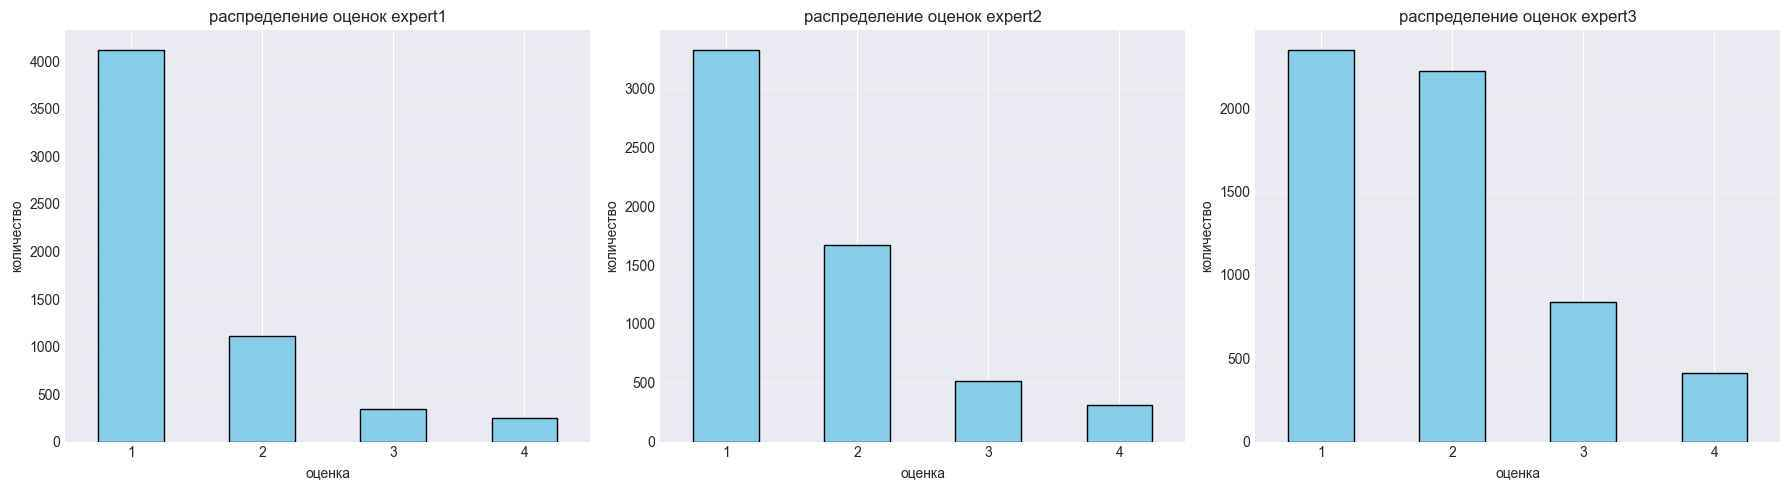

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, expert in enumerate(['expert1', 'expert2', 'expert3']):
    expert_df[expert].value_counts().sort_index().plot(kind='bar', ax=axes[idx], color='skyblue', edgecolor='black')
    axes[idx].set_xlabel('оценка')
    axes[idx].set_ylabel('количество')
    axes[idx].set_title(f'распределение оценок {expert}')
    axes[idx].grid(axis='y', alpha=0.3)
    axes[idx].set_xticklabels([1, 2, 3, 4], rotation=0)

plt.tight_layout()
plt.show()

**результаты:**
- все три эксперта использовали шкалу от 1 до 4
- **expert3 более мягкий** в оценках (выше среднее), **expert1 более строгий**
- **сильный дисбаланс**: все эксперты чаще ставят низкие оценки (1-2)
- это соответствует структуре данных: большинство пар — несоответствующие (изображение + чужое описание)
- оценка 1 = полное несоответствие, оценка 4 = отличное соответствие
- графики показывают похожее распределение у всех экспертов, но с разной строгостью

### Согласие между экспертами (expert_df)

проверю согласованность оценок между экспертами:
- вычислю корреляцию Пирсона между оценками всех трёх экспертов
- построю тепловую карту (heatmap) для визуализации корреляций
- оценю, насколько эксперты согласны друг с другом

корреляция между оценками экспертов:


expert1   expert2   expert3
expert1  1.000000  0.885036  0.796189
expert2  0.885036  1.000000  0.874369
expert3  0.796189  0.874369  1.000000

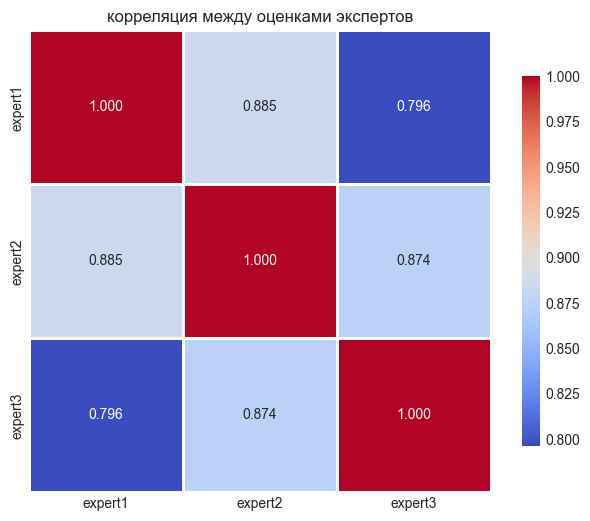

In [24]:
# корреляция между экспертами
correlation = expert_df[['expert1', 'expert2', 'expert3']].corr()
print("корреляция между оценками экспертов:")
display(correlation)

# визуализация корреляции
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, fmt='.3f', cmap='coolwarm', 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('корреляция между оценками экспертов')
plt.show()

**результаты:**
- получил матрицу корреляций между всеми парами экспертов
- все корреляции выше 0.79, что указывает на **сильное согласие**
- эксперты в целом единодушны в своих оценках
- наименьшая корреляция между `expert1` и `expert3` (0.796) может объясняться тем, что `expert1` более строгий, а `expert3` более мягкий
- высокое согласие подтверждает **надёжность экспертных оценок**
- тепловая карта наглядно показывает близость оценок между всеми экспертами

### Анализ разброса оценок (expert_df)

проанализирую разброс оценок между экспертами:
- вычислю максимальную и минимальную оценку для каждой пары
- найду разброс (`expert_range = max - min`)
- построю распределение разброса оценок
- найду примеры пар, где эксперты максимально не согласны

распределение разброса оценок:
expert_range
0    3391
1    2272
2     156
3       3
Name: count, dtype: int64


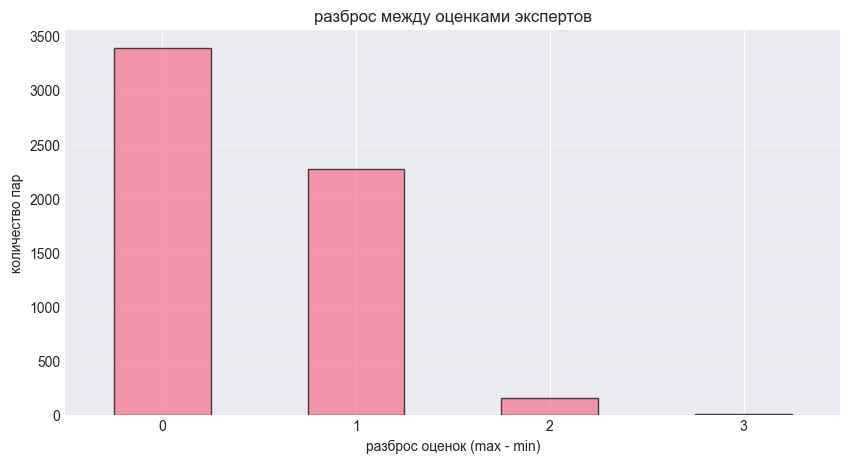


примеры с максимальным разбросом (эксперты не согласны):


image_file                   caption_id  expert1  \
3956  3388330419_85d72f7cda.jpg  3358558292_6ab14193ed.jpg#2        1   
5561   542179694_e170e9e465.jpg   300577375_26cc2773a1.jpg#2        1   
5573   542317719_ed4dd95dc2.jpg   542317719_ed4dd95dc2.jpg#2        1   

      expert2  expert3      image_from_caption_id  caption_number  expert_max  \
3956        2        4  3358558292_6ab14193ed.jpg               2           4   
5561        2        4   300577375_26cc2773a1.jpg               2           4   
5573        4        4   542317719_ed4dd95dc2.jpg               2           4   

      expert_min  expert_range  
3956           1             3  
5561           1             3  
5573           1             3

In [25]:
# разница между максимальной и минимальной оценкой для каждой пары
expert_df['expert_max'] = expert_df[['expert1', 'expert2', 'expert3']].max(axis=1)
expert_df['expert_min'] = expert_df[['expert1', 'expert2', 'expert3']].min(axis=1)
expert_df['expert_range'] = expert_df['expert_max'] - expert_df['expert_min']

print("распределение разброса оценок:")
print(expert_df['expert_range'].value_counts().sort_index())

plt.figure(figsize=(10, 5))
expert_df['expert_range'].value_counts().sort_index().plot(kind='bar', edgecolor='black', alpha=0.7)
plt.xlabel('разброс оценок (max - min)')
plt.ylabel('количество пар')
plt.title('разброс между оценками экспертов')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.show()

# примеры с максимальным разбросом
print("\nпримеры с максимальным разбросом (эксперты не согласны):")
display(expert_df[expert_df['expert_range'] == expert_df['expert_range'].max()].head(5))

**результаты:**
- **высокое согласие**: в 58% случаев все три эксперта поставили одинаковую оценку
- в 97% случаев разброс не превышает 1 балла
- только в 3 случаях мнения экспертов кардинально разошлись (разброс 3)
- примеры максимального разброса показывают спорные пары, где один эксперт видит соответствие (оценка 4), а другой — полное несоответствие (оценка 1)
- низкий процент больших разбросов подтверждает **надёжность экспертных оценок**
- визуализация показывает экспоненциальное убывание количества пар с ростом разброса

### Количество описаний на изображение (expert_df)

проанализирую количество описаний на каждое изображение в экспертных оценках:
- подсчитаю, сколько описаний приходится на каждое изображение
- построю распределение
- сравню с краудсорсинговыми данными

распределение количества описаний на изображение (эксперты):
count
2       8
3      49
4     157
5     228
6     233
7     164
8     114
9      37
10     10
Name: count, dtype: int64


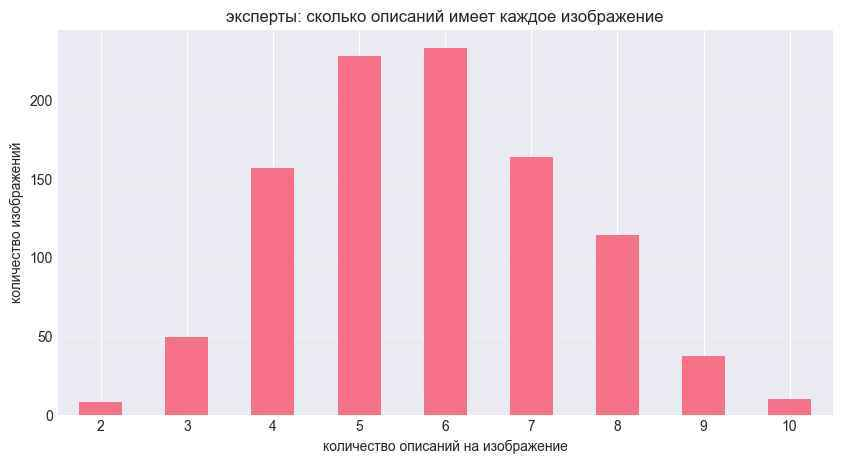

In [26]:
# сколько описаний у каждого изображения
captions_per_image_expert = expert_df['image_file'].value_counts()
print("распределение количества описаний на изображение (эксперты):")
print(captions_per_image_expert.value_counts().sort_index())

plt.figure(figsize=(10, 5))
captions_per_image_expert.value_counts().sort_index().plot(kind='bar')
plt.xlabel('количество описаний на изображение')
plt.ylabel('количество изображений')
plt.title('эксперты: сколько описаний имеет каждое изображение')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.show()

**результаты:**
- на одно изображение приходится от 2 до 10 описаний
- наиболее частые значения: 5-6 описаний на изображение
- **распределение близко к нормальному** с центром в районе 5-6 описаний
- это **кардинально отличается** от краудсорсинговых данных (где было 10-120 описаний)
- **структура данных**:
  - эксперты оценили только небольшую подвыборку из всех возможных пар
  - каждое изображение сопоставили с 2-10 описаниями (не со всеми 1000)
  - выборочная оценка, а не полная матрица
- это объясняет меньший размер `expert_df` (5822 пары) по сравнению с `crowd_df` (47830 пар)
- эксперты оценивали более компактный набор пар, вероятно, отобранных на основе краудсорсинговых оценок

### Примеры оценок (expert_df)

создам функцию для визуализации примеров с экспертными оценками и посмотрю на разные категории:
- напишу функцию `show_expert_examples()`, которая:
  - отображает изображения с оценками всех трёх экспертов
  - показывает текст описания из `train_df` по `caption_id`
  - использует цветовую индикацию в зависимости от средней оценки
  - показывает разброс оценок между экспертами
- посмотрю на три категории:
  - полное согласие на максимальную оценку (все эксперты поставили 4)
  - полное несоответствие (все эксперты поставили 1)
  - смешанные оценки (случайная выборка с разбросом)

In [27]:
# функция для показа изображений с экспертными оценками
def show_expert_examples(df_subset, title, n_show=5):
    """
    показывает изображения с экспертными оценками
    
    параметры:
    - df_subset: подмножество датафрейма expert_df
    - title: заголовок группы
    - n_show: количество примеров для показа
    """
    print(f"\n{'='*80}")
    print(f"{title}")
    print(f"{'='*80}\n")
    
    n = min(len(df_subset), n_show)
    fig, axes = plt.subplots(1, n, figsize=(5*n, 5))
    
    if n == 1:
        axes = [axes]
    
    for idx, (_, row) in enumerate(df_subset.head(n).iterrows()):
        image_path = os.path.join(train_images_dir, row['image_file'])
        
        if os.path.exists(image_path):
            img = Image.open(image_path)
            axes[idx].imshow(img)
            axes[idx].axis('off')
            
            # получаем текст описания
            text_match = train_df[train_df['query_id'] == row['caption_id']]
            if len(text_match) > 0:
                query_text = text_match.iloc[0]['query_text']
            else:
                query_text = "текст не найден"
            
            # цвет в зависимости от оценок
            avg_score = (row['expert1'] + row['expert2'] + row['expert3']) / 3
            if avg_score >= 3.5:
                color = 'darkgreen'
            elif avg_score >= 2.5:
                color = 'green'
            elif avg_score >= 1.5:
                color = 'orange'
            else:
                color = 'red'
            
            # проверяем разброс оценок
            if 'expert_range' in row:
                range_info = f"разброс: {row['expert_range']}"
            else:
                range_info = ""
            
            text_info = (
                f"оценки: [{row['expert1']}, {row['expert2']}, {row['expert3']}]\n"
                f"{range_info}\n\n"
                f"{query_text[:70]}..."
            )
            axes[idx].set_title(text_info, fontsize=9, color=color)
        else:
            axes[idx].text(0.5, 0.5, f'изображение не найдено:\n{row["image_file"]}', 
                          ha='center', va='center')
            axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # выводим полную информацию
    print("\nподробная информация:")
    for idx, (_, row) in enumerate(df_subset.head(n).iterrows()):
        text_match = train_df[train_df['query_id'] == row['caption_id']]
        if len(text_match) > 0:
            query_text = text_match.iloc[0]['query_text']
        else:
            query_text = "текст не найден"
        
        print(f"\n{idx+1}. изображение: {row['image_file']}")
        print(f"   caption_id: {row['caption_id']}")
        print(f"   оценки экспертов: expert1={row['expert1']}, expert2={row['expert2']}, expert3={row['expert3']}")
        if 'expert_range' in row:
            print(f"   разброс оценок: {row['expert_range']}")
        print(f"   описание: {query_text}")

примеры с полным согласием экспертов (все поставили 4):


image_file                   caption_id  expert1  expert2  \
43   1119015538_e8e796281e.jpg   416106657_cab2a107a5.jpg#2        4        4   
53   1131932671_c8d17751b3.jpg  1131932671_c8d17751b3.jpg#2        4        4   
66    115684808_cb01227802.jpg   115684808_cb01227802.jpg#2        4        4   
80   1174629344_a2e1a2bdbf.jpg  1174629344_a2e1a2bdbf.jpg#2        4        4   
187  1322323208_c7ecb742c6.jpg  1322323208_c7ecb742c6.jpg#2        4        4   

     expert3      image_from_caption_id  caption_number  expert_max  \
43         4   416106657_cab2a107a5.jpg               2           4   
53         4  1131932671_c8d17751b3.jpg               2           4   
66         4   115684808_cb01227802.jpg               2           4   
80         4  1174629344_a2e1a2bdbf.jpg               2           4   
187        4  1322323208_c7ecb742c6.jpg               2           4   

     expert_min  expert_range  
43            4             0  
53            4             0  
66            4             0  
80            4             0  
187           4             0


ПОЛНОЕ СОГЛАСИЕ: ВСЕ ЭКСПЕРТЫ ПОСТАВИЛИ 4



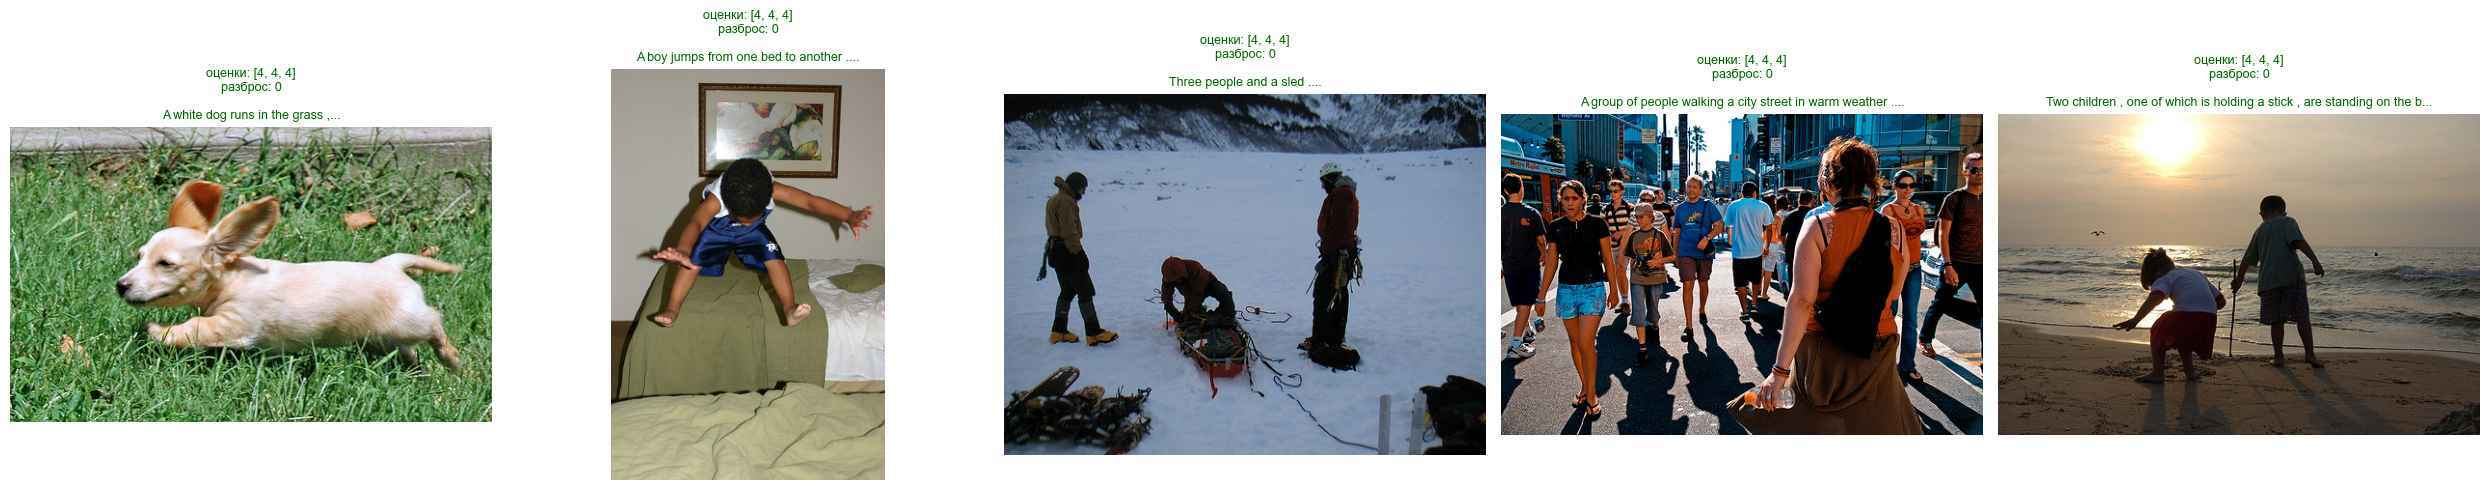


подробная информация:

1. изображение: 1119015538_e8e796281e.jpg
   caption_id: 416106657_cab2a107a5.jpg#2
   оценки экспертов: expert1=4, expert2=4, expert3=4
   разброс оценок: 0
   описание: A white dog runs in the grass ,

2. изображение: 1131932671_c8d17751b3.jpg
   caption_id: 1131932671_c8d17751b3.jpg#2
   оценки экспертов: expert1=4, expert2=4, expert3=4
   разброс оценок: 0
   описание: A boy jumps from one bed to another .

3. изображение: 115684808_cb01227802.jpg
   caption_id: 115684808_cb01227802.jpg#2
   оценки экспертов: expert1=4, expert2=4, expert3=4
   разброс оценок: 0
   описание: Three people and a sled .

4. изображение: 1174629344_a2e1a2bdbf.jpg
   caption_id: 1174629344_a2e1a2bdbf.jpg#2
   оценки экспертов: expert1=4, expert2=4, expert3=4
   разброс оценок: 0
   описание: A group of people walking a city street in warm weather .

5. изображение: 1322323208_c7ecb742c6.jpg
   caption_id: 1322323208_c7ecb742c6.jpg#2
   оценки экспертов: expert1=4, expert2=4, exper

image_file                   caption_id  expert1  expert2  \
0   1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2        1        1   
5   1056338697_4f7d7ce270.jpg  3360930596_1e75164ce6.jpg#2        1        1   
6   1056338697_4f7d7ce270.jpg  3545652636_0746537307.jpg#2        1        1   
8    106490881_5a2dd9b7bd.jpg  1425069308_488e5fcf9d.jpg#2        1        1   
11   106490881_5a2dd9b7bd.jpg  2398605966_1d0c9e6a20.jpg#2        1        1   

    expert3      image_from_caption_id  caption_number  expert_max  \
0         1  2549968784_39bfbe44f9.jpg               2           1   
5         1  3360930596_1e75164ce6.jpg               2           1   
6         1  3545652636_0746537307.jpg               2           1   
8         1  1425069308_488e5fcf9d.jpg               2           1   
11        1  2398605966_1d0c9e6a20.jpg               2           1   

    expert_min  expert_range  
0            1             0  
5            1             0  
6            1             0  
8            1             0  
11           1             0


ПОЛНОЕ НЕСООТВЕТСТВИЕ: ВСЕ ЭКСПЕРТЫ ПОСТАВИЛИ 1



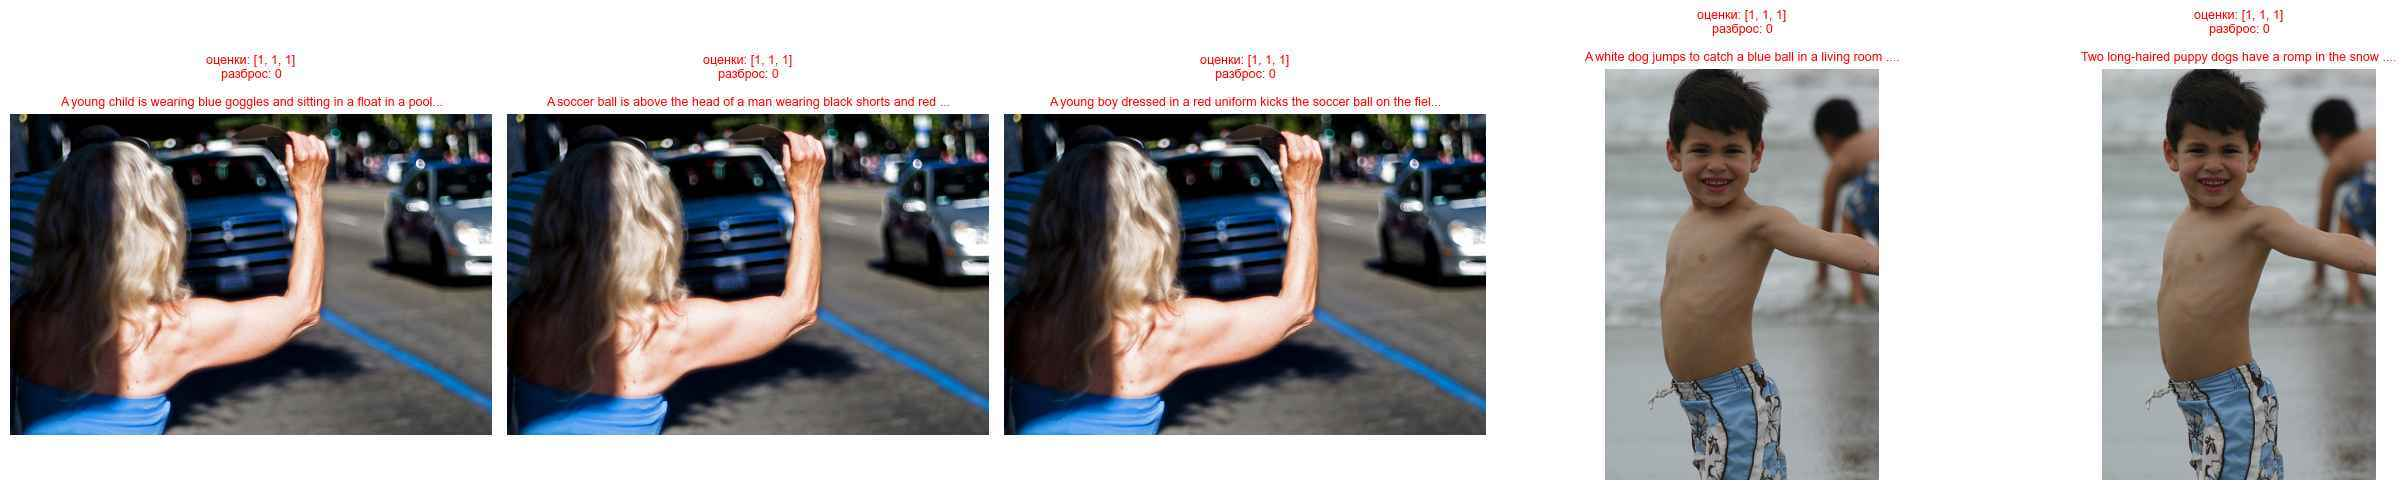


подробная информация:

1. изображение: 1056338697_4f7d7ce270.jpg
   caption_id: 2549968784_39bfbe44f9.jpg#2
   оценки экспертов: expert1=1, expert2=1, expert3=1
   разброс оценок: 0
   описание: A young child is wearing blue goggles and sitting in a float in a pool .

2. изображение: 1056338697_4f7d7ce270.jpg
   caption_id: 3360930596_1e75164ce6.jpg#2
   оценки экспертов: expert1=1, expert2=1, expert3=1
   разброс оценок: 0
   описание: A soccer ball is above the head of a man wearing black shorts and red and black striped shirt .

3. изображение: 1056338697_4f7d7ce270.jpg
   caption_id: 3545652636_0746537307.jpg#2
   оценки экспертов: expert1=1, expert2=1, expert3=1
   разброс оценок: 0
   описание: A young boy dressed in a red uniform kicks the soccer ball on the field as another child in blue watches from behind .

4. изображение: 106490881_5a2dd9b7bd.jpg
   caption_id: 1425069308_488e5fcf9d.jpg#2
   оценки экспертов: expert1=1, expert2=1, expert3=1
   разброс оценок: 0
   описание

image_file                   caption_id  expert1  \
544    172097782_f0844ec317.jpg  3641022607_e7a5455d6c.jpg#2        3   
1894  2621415349_ef1a7e73be.jpg  2675685200_0913d84d9b.jpg#2        1   
5546   539751252_2bd88c456b.jpg  3564543247_05cdbc31cf.jpg#2        2   
4923  3694093650_547259731e.jpg  2204550058_2707d92338.jpg#2        1   
3624  3263395801_5e4cee2b9e.jpg  1554713437_61b64527dd.jpg#2        1   
506   1659358141_0433c9bf99.jpg  2774430374_fee1d793e7.jpg#2        1   
5106   405615014_03be7ef618.jpg  2666205903_8d287669e1.jpg#2        1   
3805  3339140382_2e49bc324a.jpg  3123351642_3794f2f601.jpg#2        1   
408   1490213660_9ea45550cf.jpg  3070011270_390e597783.jpg#2        2   
4108  3437654963_c4fdc17e8b.jpg   197107117_4b438b1872.jpg#2        1   

      expert2  expert3  expert_range  
544         4        4             1  
1894        1        2             1  
5546        3        3             1  
4923        1        1             0  
3624        2        2             1  
506         1        1             0  
5106        1        2             1  
3805        1        2             1  
408         2        3             1  
4108        1        1             0


СМЕШАННЫЕ ОЦЕНКИ (случайная выборка)



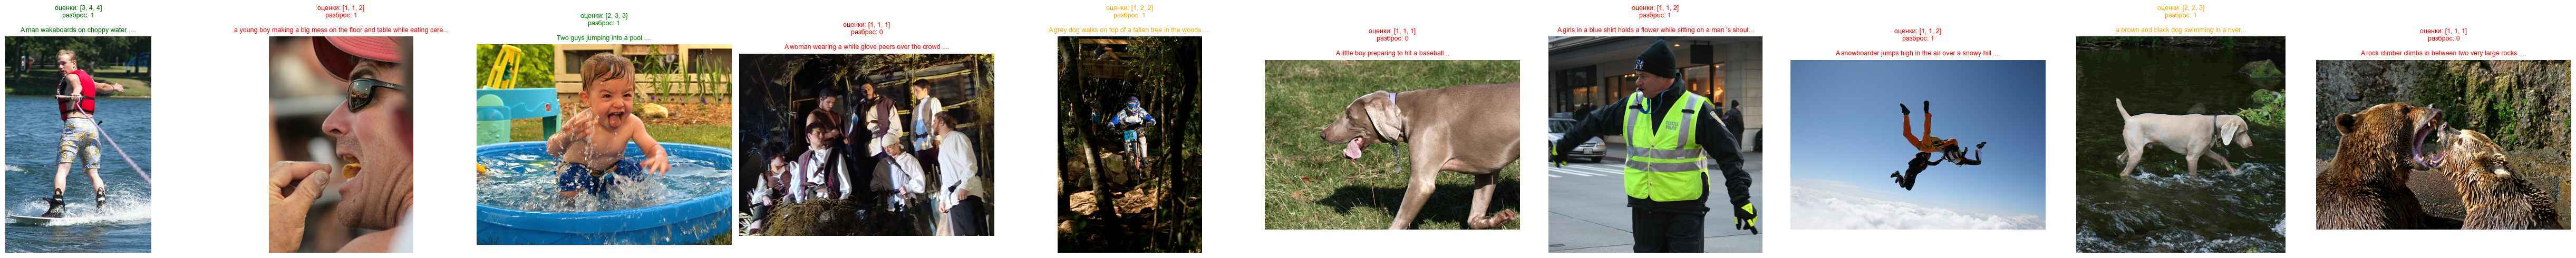


подробная информация:

1. изображение: 172097782_f0844ec317.jpg
   caption_id: 3641022607_e7a5455d6c.jpg#2
   оценки экспертов: expert1=3, expert2=4, expert3=4
   разброс оценок: 1
   описание: A man wakeboards on choppy water .

2. изображение: 2621415349_ef1a7e73be.jpg
   caption_id: 2675685200_0913d84d9b.jpg#2
   оценки экспертов: expert1=1, expert2=1, expert3=2
   разброс оценок: 1
   описание: a young boy making a big mess on the floor and table while eating cereal

3. изображение: 539751252_2bd88c456b.jpg
   caption_id: 3564543247_05cdbc31cf.jpg#2
   оценки экспертов: expert1=2, expert2=3, expert3=3
   разброс оценок: 1
   описание: Two guys jumping into a pool .

4. изображение: 3694093650_547259731e.jpg
   caption_id: 2204550058_2707d92338.jpg#2
   оценки экспертов: expert1=1, expert2=1, expert3=1
   разброс оценок: 0
   описание: A woman wearing a white glove peers over the crowd .

5. изображение: 3263395801_5e4cee2b9e.jpg
   caption_id: 1554713437_61b64527dd.jpg#2
   оценки

In [28]:
# примеры с полным согласием экспертов (все поставили 4)
print("примеры с полным согласием экспертов (все поставили 4):")
perfect_match = expert_df[(expert_df['expert1'] == 4) & 
                          (expert_df['expert2'] == 4) & 
                          (expert_df['expert3'] == 4)].head(5)
display(perfect_match)
show_expert_examples(perfect_match, "ПОЛНОЕ СОГЛАСИЕ: ВСЕ ЭКСПЕРТЫ ПОСТАВИЛИ 4")

# примеры с полным несоответствием (все поставили 1)
print("\nпримеры с полным несоответствием (все поставили 1):")
no_match = expert_df[(expert_df['expert1'] == 1) & 
                     (expert_df['expert2'] == 1) & 
                     (expert_df['expert3'] == 1)].head(5)
display(no_match)
show_expert_examples(no_match, "ПОЛНОЕ НЕСООТВЕТСТВИЕ: ВСЕ ЭКСПЕРТЫ ПОСТАВИЛИ 1")

# примеры со смешанными оценками
print("\nпримеры со смешанными оценками:")
mixed_ratings = expert_df.sample(10, random_state=42)[['image_file', 'caption_id', 
                                                         'expert1', 'expert2', 'expert3', 'expert_range']]
display(mixed_ratings)
show_expert_examples(mixed_ratings, "СМЕШАННЫЕ ОЦЕНКИ (случайная выборка)", n_show=10)


- **общие наблюдения**:
  - визуализация подтверждает надёжность экспертных оценок
  - эксперты действительно видят разницу между хорошими и плохими соответствиями

### Сравнение с краудсорсингом (expert_df и crowd_df)

проверю связи между всеми тремя датасетами:
- сравню `caption_id` между `expert_df` и `crowd_df`
- сравню пары (изображение, описание) между `train_df` и `expert_df`
- определю, есть ли полное совпадение или только частичное пересечение

In [29]:
# проверим пересечение по caption_id
expert_captions = set(expert_df['caption_id'].unique())
crowd_captions = set(crowd_df['caption_id'].unique())

print(f"caption_id в expert_df: {len(expert_captions)}")
print(f"caption_id в crowd_df: {len(crowd_captions)}")
print(f"пересечение: {len(expert_captions & crowd_captions)}")
print(f"только в expert_df: {len(expert_captions - crowd_captions)}")
print(f"только в crowd_df: {len(crowd_captions - expert_captions)}")

caption_id в expert_df: 977
caption_id в crowd_df: 1000
пересечение: 977
только в expert_df: 0
только в crowd_df: 23


### Сравнение с train_df

Так как у меня подозрение, что train_df и expert_df идентичны, выполним проверки.

In [30]:
# переименуем колонки train_df для сравнения
train_check = train_df[['image', 'query_id', 'query_text']].copy()
train_check.columns = ['image_file', 'caption_id', 'query_text']

# переименуем колонки expert_df для сравнения
expert_check = expert_df[['image_file', 'caption_id']].copy()

# проверим: есть ли все пары из train_df в expert_df?
train_pairs = set(zip(train_check['image_file'], train_check['caption_id']))
expert_pairs = set(zip(expert_check['image_file'], expert_check['caption_id']))

print(f"пар в train_df: {len(train_pairs)}")
print(f"пар в expert_df: {len(expert_pairs)}")
print(f"пересечение пар: {len(train_pairs & expert_pairs)}")
print(f"пар только в train_df: {len(train_pairs - expert_pairs)}")
print(f"пар только в expert_df: {len(expert_pairs - train_pairs)}")

# проверим: идентичны ли они полностью?
if train_pairs == expert_pairs:
    print("\nПАРЫ ПОЛНОСТЬЮ ИДЕНТИЧНЫ!")
    print("train_df и expert_df описывают одни и те же комбинации (изображение, описание)")
else:
    print("\nПАРЫ РАЗНЫЕ!")

пар в train_df: 5822
пар в expert_df: 5822
пересечение пар: 5822
пар только в train_df: 0
пар только в expert_df: 0

ПАРЫ ПОЛНОСТЬЮ ИДЕНТИЧНЫ!
train_df и expert_df описывают одни и те же комбинации (изображение, описание)


**вывод:**
- `train_df` и `expert_df` описывают **одни и те же** комбинации (изображение, описание)
- `train_df` — это по сути `expert_df`, но без оценок экспертов
- структура данных теперь понятна:
  - `train_df`: 5822 пары (изображение, описание) без оценок
  - `expert_df`: те же 5822 пары + оценки трёх экспертов
  - `crowd_df`: 47830 пар + краудсорсинговые оценки (более широкая выборка)
- название `train_dataset.csv` теперь понятно: это обучающий набор пар для оценки соответствия

проверю соответствие текстов между датасетами:
- создам словарь `caption_id → query_text` из `train_df`
- проверю несколько примеров `caption_id` из `expert_df`
- убеждусь, что тексты одинаковые для одних и тех же `caption_id`

In [31]:
# создадим словарь: caption_id -> query_text из train_df
train_texts = dict(zip(train_df['query_id'], train_df['query_text']))

# проверим несколько caption_id из expert_df
print("проверим, одинаковые ли тексты для одних и тех же caption_id:\n")

# возьмём первые 5 caption_id из expert_df
for caption_id in expert_df['caption_id'].head(5):
    if caption_id in train_texts:
        print(f"caption_id: {caption_id}")
        print(f"текст из train_df: {train_texts[caption_id][:50]}...")
        print("caption_id есть в train_df\n")
    else:
        print(f"caption_id: {caption_id}")
        print("caption_id НЕТ в train_df\n")

проверим, одинаковые ли тексты для одних и тех же caption_id:

caption_id: 2549968784_39bfbe44f9.jpg#2
текст из train_df: A young child is wearing blue goggles and sitting ...
caption_id есть в train_df

caption_id: 2718495608_d8533e3ac5.jpg#2
текст из train_df: A girl wearing a yellow shirt and sunglasses smile...
caption_id есть в train_df

caption_id: 3181701312_70a379ab6e.jpg#2
текст из train_df: A man sleeps under a blanket on a city street ....
caption_id есть в train_df

caption_id: 3207358897_bfa61fa3c6.jpg#2
текст из train_df: A woman plays with long red ribbons in an empty sq...
caption_id есть в train_df

caption_id: 3286822339_5535af6b93.jpg#2
текст из train_df: Chinese market street in the winter time ....
caption_id есть в train_df



**результаты:**
- все проверенные `caption_id` из `expert_df` присутствуют в `train_df`
- тексты описаний полностью совпадают для одинаковых `caption_id`
- это окончательно подтверждает: **`train_df` = `expert_df` без экспертных оценок**

**итоговая структура данных:**
- `train_df` (train_dataset.csv):
  - 5822 пары (изображение, описание)
  - содержит `image`, `query_id`, `query_text`
  - это базовый справочник пар без оценок
- `expert_df` (ExpertAnnotations.tsv):
  - те же 5822 пары
  - + оценки трёх экспертов (по шкале 1-4)
  - это `train_df` + экспертная разметка
- `crowd_df` (CrowdAnnotations.tsv):
  - 47830 пар (более широкая выборка)
  - включает все пары из `expert_df` + дополнительные негативные примеры
  - + краудсорсинговые оценки (`agreement_ratio`, `votes_yes`, `votes_no`)

**рекомендация для дальнейшей работы:**
- объединить `train_df` и `expert_df` в один датасет с экспертными оценками
- использовать `expert_df` как основу (уже содержит все данные из `train_df`)
- при необходимости добавлять краудсорсинговые оценки из `crowd_df` по `caption_id`

## Вывод по expert_df

**объём данных:**
- всего 5822 экспертные оценки (идентично `train_df`)
- 1000 уникальных изображений
- 977 уникальных `caption_id`
- только 158 совпадений `image_file` с `image_from_caption_id` (2.7%)

**ключевое открытие — структура данных:**

сравнение трёх файлов:
| файл | строк | уникальных caption_id | описаний на изображение |
|------|-------|----------------------|------------------------|
| train_df | 5822 | 977 | 2-10 |
| expert_df | 5822 | 977 | 2-10 |
| crowd_df | 47830 | 1000 | 10-120 |

**это означает:**
- `train_df` и `expert_df` описывают **одни и те же пары**
- `train_df` = базовый справочник пар (изображение, описание)
- `expert_df` = те же пары + экспертные оценки (1-4)
- `crowd_df` = расширенная матрица с большим количеством пар + краудсорсинговые оценки

**характеристики экспертных оценок:**

распределение оценок по экспертам:
- `expert1`: среднее = 1.44 (самый строгий)
- `expert2`: среднее = 1.62 (средний)
- `expert3`: среднее = 1.88 (самый мягкий)
- все эксперты склонны ставить низкие оценки (1-2), что логично для задачи с негативными примерами

использование шкалы оценок:
- оценка 1 (полное несоответствие): 4120 / 3327 / 2350 случаев
- оценка 2 (частичное соответствие): 1109 / 1666 / 2222 случаев
- оценка 3 (хорошее соответствие): 346 / 518 / 837 случаев
- оценка 4 (полное соответствие): 247 / 311 / 413 случаев
- `expert3` более щедрый на высокие оценки

**согласие между экспертами — отличное:**

корреляции:
- `expert1 ↔ expert2`: 0.885 (очень высокая)
- `expert1 ↔ expert3`: 0.796 (высокая)
- `expert2 ↔ expert3`: 0.874 (очень высокая)
- все корреляции выше 0.79, что указывает на качественную разметку

разброс оценок:
- разброс 0 (полное согласие): 3391 случай (58.3%)
- разброс 1 (расхождение на 1 балл): 2272 случая (39.0%)
- разброс 2 (расхождение на 2 балла): 156 случаев (2.7%)
- разброс 3 (максимальное расхождение): только 3 случая (0.05%)
- в 97.3% случаев разброс не превышает 1 балла

**связи между датасетами:**

пересечение с краудсорсингом:
- все 977 `caption_id` из `expert_df` присутствуют в `crowd_df`
- в `crowd_df` есть дополнительные 23 `caption_id`, которых нет в экспертных оценках
- эксперты оценили подмножество пар, краудворкеры оценили более широкую выборку

**итоговая структура данных:**
```
1000 изображений
└─ у каждого изображения есть текстовые описания (captions)

для обучения модели:
├─ expert_df: 5822 пары с экспертными оценками (шкала 1-4)
└─ crowd_df: 47830 пар с краудсорсинговыми оценками (agreement_ratio)

справочник:
└─ train_df: те же 5822 пары, что и в expert_df (содержит тексты описаний)
```

**критическое уточнение:**
- название `train_dataset.csv` вводит в заблуждение
- `train_df` — это не обучающие данные, а **справочник текстов описаний**
- настоящие обучающие данные: `expert_df` и `crowd_df` с оценками соответствия
- структура: `train_df` содержит тексты → `expert_df` содержит оценки для тех же пар
- **рекомендация**: объединить `train_df` и `expert_df` в один датасет для дальнейшей работы

## Загрузка данных (test_queries.csv)

In [32]:
# загрузка test_queries
try:
    test_df = pd.read_csv(os.path.join(data_dir, 'test_queries.csv'), sep='|', index_col=0)
    print('train_dataset загружено локально')
except:
    test_df = pd.read_csv('https://code.s3.yandex.net/datasets/dsplus_integrated_project_4/to_upload/test_queries.csv')
    print('train_dataset загружено удаленно')

train_dataset загружено локально


### Первичный осмотр (test_df)

In [33]:
check_df(test_df)

info:
<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


None

head:


query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg

describe:


query_id  \
count                           500   
unique                          500   
top     1177994172_10d143cb8d.jpg#0   
freq                              1   

                                               query_text  \
count                                                 500   
unique                                                500   
top     Two blonde boys , one in a camouflage shirt an...   
freq                                                    1   

                            image  
count                         500  
unique                        100  
top     1177994172_10d143cb8d.jpg  
freq                            5

nulls:


query_id      0
query_text    0
image         0
dtype: int64

duplicates:


np.int64(0)

### Анализ структуры (test_df)

проанализирую структуру тестового датасета:
- подсчитаю количество тестовых запросов
- проверю количество уникальных `query_id`, `query_text` и изображений
- изучу формат `query_id`
- вычислю длину запросов в символах и словах
- получу статистические характеристики

In [34]:
print(f"количество тестовых запросов: {len(test_df)}")
print(f"уникальных query_id: {test_df['query_id'].nunique()}")
print(f"уникальных query_text: {test_df['query_text'].nunique()}")
print(f"уникальных relevant_image: {test_df['image'].nunique()}")

# проверим формат query_id
print("\nпримеры query_id:")
display(test_df['query_id'].head(10))

# длины текстов
test_df['text_length'] = test_df['query_text'].str.len()
test_df['word_count'] = test_df['query_text'].str.split().str.len()

print("\nстатистика длины запросов:")
display(test_df[['text_length', 'word_count']].describe())

количество тестовых запросов: 500
уникальных query_id: 500
уникальных query_text: 500
уникальных relevant_image: 100

примеры query_id:


0    1177994172_10d143cb8d.jpg#0
1    1177994172_10d143cb8d.jpg#1
2    1177994172_10d143cb8d.jpg#2
3    1177994172_10d143cb8d.jpg#3
4    1177994172_10d143cb8d.jpg#4
5    1232148178_4f45cc3284.jpg#0
6    1232148178_4f45cc3284.jpg#1
7    1232148178_4f45cc3284.jpg#2
8    1232148178_4f45cc3284.jpg#3
9    1232148178_4f45cc3284.jpg#4
Name: query_id, dtype: object


статистика длины запросов:


text_length  word_count
count   500.000000  500.000000
mean     57.024000   12.196000
std      19.680194    4.116732
min      19.000000    4.000000
25%      43.000000    9.000000
50%      55.000000   12.000000
75%      68.250000   14.000000
max     135.000000   31.000000

**ключевая структура:**
- формат `query_id`: `{image_filename}#{номер_описания}`
- примеры: `1177994172_10d143cb8d.jpg#0`, `1177994172_10d143cb8d.jpg#1`
- **на каждое изображение по 5 описаний** (номера 0-4)
- это соответствует документации: 100 изображений × 5 описаний = 500 запросов

**характеристики текстов:**
- средняя длина: 57 символов (12 слов)
- диапазон: от 19 до 135 символов (4-31 слово)
- медиана: 55 символов (12 слов)
- распределение похоже на обучающие данные (`train_df`)
- запросы лаконичные и описательные

**структура для тестирования:**
- каждое из 100 тестовых изображений имеет ровно 5 текстовых описаний
- задача модели: для каждого запроса найти правильное изображение среди всех 100
- это классическая задача image-text retrieval

### Примеры данных

создам функцию для визуализации тестовых изображений с описаниями и посмотрю примеры:
- напишу функцию `show_test_examples()` для отображения тестовых изображений
- проверю существование директории с тестовыми изображениями
- покажу 3 случайных изображения со всеми их 5 описаниями
- найду и покажу самые короткие и длинные описания
- проанализирую вариативность описаний для одного изображения

In [35]:
# функция для показа тестовых изображений
def show_test_examples(df_subset, title, test_images_dir):
    """
    показывает тестовые изображения с их описаниями
    
    параметры:
    - df_subset: подмножество test_df
    - title: заголовок
    - test_images_dir: путь к папке с тестовыми изображениями
    """
    print(f"\n{'='*80}")
    print(f"{title}")
    print(f"{'='*80}\n")
    
    n = len(df_subset)
    fig, axes = plt.subplots(1, n, figsize=(5*n, 5))
    
    if n == 1:
        axes = [axes]
    
    for idx, (_, row) in enumerate(df_subset.iterrows()):
        image_path = os.path.join(test_images_dir, row['image'])
        
        if os.path.exists(image_path):
            img = Image.open(image_path)
            axes[idx].imshow(img)
            axes[idx].axis('off')
            
            # извлекаем номер описания из query_id
            caption_num = row['query_id'].split('#')[1]
            
            text_info = (
                f"описание #{caption_num}\n"
                f"длина: {row['text_length']} символов\n"
                f"слов: {row['word_count']}\n\n"
                f"{row['query_text'][:80]}..."
            )
            axes[idx].set_title(text_info, fontsize=9)
        else:
            axes[idx].text(0.5, 0.5, f'изображение не найдено:\n{row["image"]}', 
                          ha='center', va='center')
            axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # полная информация
    print("\nподробная информация:")
    for idx, (_, row) in enumerate(df_subset.iterrows()):
        print(f"\n{idx+1}. изображение: {row['image']}")
        print(f"   query_id: {row['query_id']}")
        print(f"   длина текста: {row['text_length']} символов, {row['word_count']} слов")
        print(f"   описание: {row['query_text']}")


проверка директории тестовых изображений: D:\dev\github\Study-ImageTextRetrieval\data\dsplus_integrated_project_4\to_upload\test_images
существует: True
примеры файлов: ['.DS_Store', '1177994172_10d143cb8d.jpg', '1232148178_4f45cc3284.jpg', '123997871_6a9ca987b1.jpg', '1319634306_816f21677f.jpg']

ПРИМЕРЫ ТЕСТОВЫХ ИЗОБРАЖЕНИЙ С ОПИСАНИЯМИ

изображение: 1177994172_10d143cb8d.jpg
количество описаний: 5

ИЗОБРАЖЕНИЕ: 1177994172_10d143cb8d.jpg



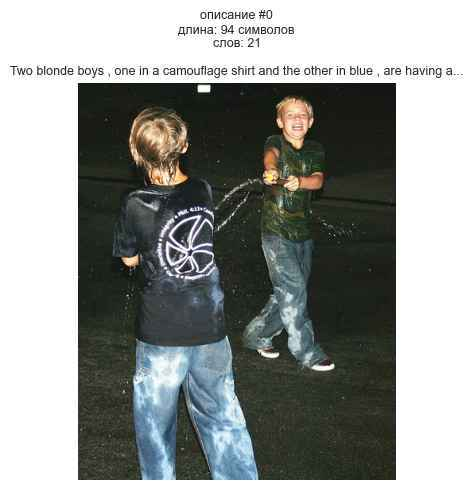


подробная информация:

1. изображение: 1177994172_10d143cb8d.jpg
   query_id: 1177994172_10d143cb8d.jpg#0
   длина текста: 94 символов, 21 слов
   описание: Two blonde boys , one in a camouflage shirt and the other in blue , are having a water fight .

все описания этого изображения:
  #0: Two blonde boys , one in a camouflage shirt and the other in blue , are having a water fight .
  #1: Two boys are squirting water guns at each other .
  #2: Two boys spraying each other with water
  #3: Two children wearing jeans squirt water at each other .
  #4: Two young boys are squirting water at each other .

изображение: 1232148178_4f45cc3284.jpg
количество описаний: 5

ИЗОБРАЖЕНИЕ: 1232148178_4f45cc3284.jpg



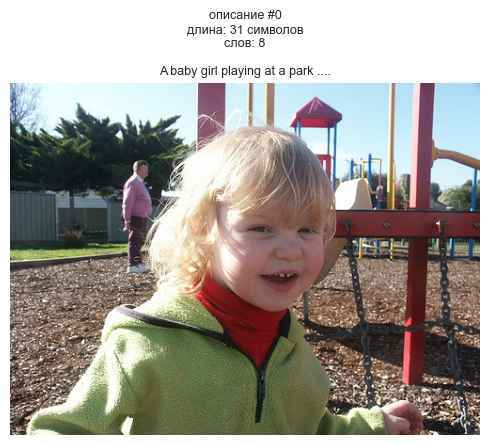


подробная информация:

1. изображение: 1232148178_4f45cc3284.jpg
   query_id: 1232148178_4f45cc3284.jpg#0
   длина текста: 31 символов, 8 слов
   описание: A baby girl playing at a park .

все описания этого изображения:
  #0: A baby girl playing at a park .
  #1: A closeup of a child on a playground with adult supervision .
  #2: A young boy poses for a picture in front of a playground .
  #3: A young girl is smiling in front of the camera at a park .
  #4: There is a little blond hair girl with a green sweatshirt and a red shirt playing on a playground .

изображение: 123997871_6a9ca987b1.jpg
количество описаний: 5

ИЗОБРАЖЕНИЕ: 123997871_6a9ca987b1.jpg



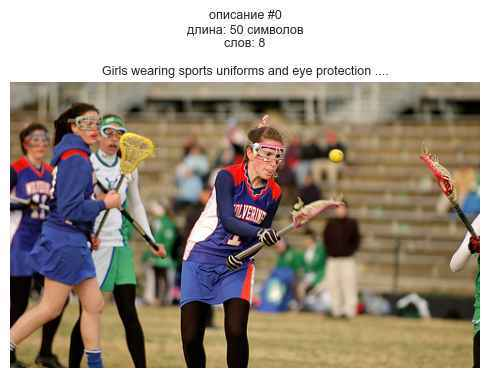


подробная информация:

1. изображение: 123997871_6a9ca987b1.jpg
   query_id: 123997871_6a9ca987b1.jpg#0
   длина текста: 50 символов, 8 слов
   описание: Girls wearing sports uniforms and eye protection .

все описания этого изображения:
  #0: Girls wearing sports uniforms and eye protection .
  #1: Several female lacrosse players are going after a ball .
  #2: These girls are in uniforms and are playing field hockey .
  #3: The woman lacrosse player in blue is about to catch the ball .
  #4: Women play lacrosse .

САМЫЕ КОРОТКИЕ И ДЛИННЫЕ ОПИСАНИЯ В ТЕСТОВОМ НАБОРЕ

самые короткие описания:


image           query_text  text_length
108  2431120202_b24fe2333a.jpg  Little girl on skis           19
177  2885891981_6b02620ae9.jpg  A boy on a BMX bike           19
274  3211199368_ca78387f72.jpg  a dog wears jeans .           19


САМЫЕ КОРОТКИЕ ОПИСАНИЯ



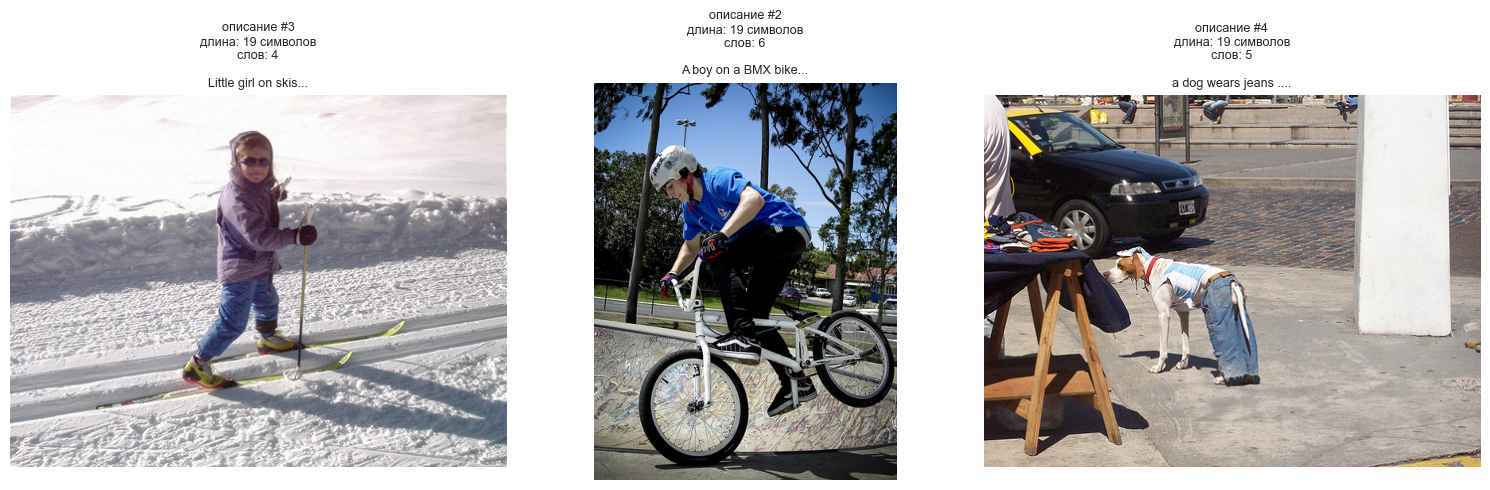


подробная информация:

1. изображение: 2431120202_b24fe2333a.jpg
   query_id: 2431120202_b24fe2333a.jpg#3
   длина текста: 19 символов, 4 слов
   описание: Little girl on skis

2. изображение: 2885891981_6b02620ae9.jpg
   query_id: 2885891981_6b02620ae9.jpg#2
   длина текста: 19 символов, 6 слов
   описание: A boy on a BMX bike

3. изображение: 3211199368_ca78387f72.jpg
   query_id: 3211199368_ca78387f72.jpg#4
   длина текста: 19 символов, 5 слов
   описание: a dog wears jeans .

самые длинные описания:


image  \
71   2141713971_e25eb12712.jpg   
201  3033612929_764d977bd5.jpg   
46    191003283_992257f835.jpg   

                                            query_text  text_length  
71   A woman and a younger girl , both wearing blue...          135  
201  A small white dog is carrying something blue i...          134  
46   A toddler boy in a red tank top and khaki shor...          128


САМЫЕ ДЛИННЫЕ ОПИСАНИЯ



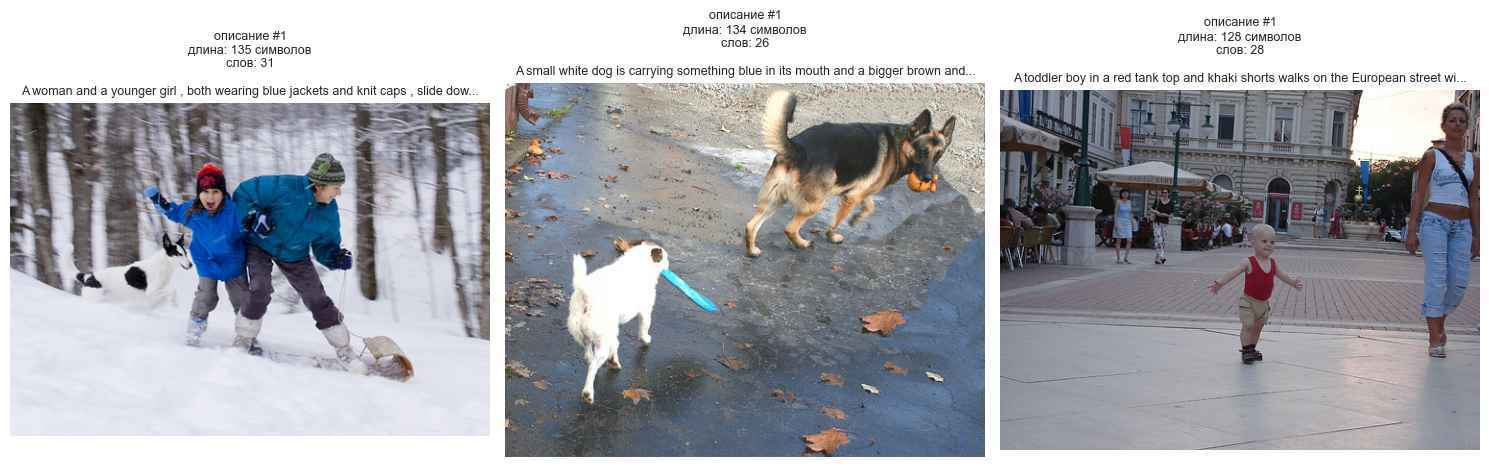


подробная информация:

1. изображение: 2141713971_e25eb12712.jpg
   query_id: 2141713971_e25eb12712.jpg#1
   длина текста: 135 символов, 31 слов
   описание: A woman and a younger girl , both wearing blue jackets and knit caps , slide down a hill on a snow sled , a dog running at their side .

2. изображение: 3033612929_764d977bd5.jpg
   query_id: 3033612929_764d977bd5.jpg#1
   длина текста: 134 символов, 26 слов
   описание: A small white dog is carrying something blue in its mouth and a bigger brown and black dog is carrying something orange in its mouth .

3. изображение: 191003283_992257f835.jpg
   query_id: 191003283_992257f835.jpg#1
   длина текста: 128 символов, 28 слов
   описание: A toddler boy in a red tank top and khaki shorts walks on the European street with a woman in a white top and faded blue jeans .


In [36]:
# проверяем путь к тестовым изображениям
test_images_dir = os.path.join(data_dir, 'test_images')
print(f"\nпроверка директории тестовых изображений: {test_images_dir}")
print(f"существует: {os.path.exists(test_images_dir)}")

if os.path.exists(test_images_dir):
    sample_files = os.listdir(test_images_dir)[:5]
    print(f"примеры файлов: {sample_files}")

# покажем несколько случайных изображений с их описаниями
print("\n" + "="*80)
print("ПРИМЕРЫ ТЕСТОВЫХ ИЗОБРАЖЕНИЙ С ОПИСАНИЯМИ")
print("="*80)

# возьмём несколько уникальных изображений
unique_images = test_df['image'].unique()[:3]

for img_name in unique_images:
    # все описания для этого изображения
    img_descriptions = test_df[test_df['image'] == img_name]
    
    print(f"\n{'='*80}")
    print(f"изображение: {img_name}")
    print(f"количество описаний: {len(img_descriptions)}")
    print(f"{'='*80}")
    
    # показываем изображение один раз с первым описанием
    show_test_examples(img_descriptions.head(1), f"ИЗОБРАЖЕНИЕ: {img_name}", test_images_dir)
    
    # выводим все 5 описаний текстом
    print("\nвсе описания этого изображения:")
    for idx, (_, row) in enumerate(img_descriptions.iterrows()):
        caption_num = row['query_id'].split('#')[1]
        print(f"  #{caption_num}: {row['query_text']}")

# покажем самые короткие и длинные описания
print("\n" + "="*80)
print("САМЫЕ КОРОТКИЕ И ДЛИННЫЕ ОПИСАНИЯ В ТЕСТОВОМ НАБОРЕ")
print("="*80)

shortest_test = test_df.nsmallest(3, 'text_length')
print("\nсамые короткие описания:")
display(shortest_test[['image', 'query_text', 'text_length']])
show_test_examples(shortest_test, "САМЫЕ КОРОТКИЕ ОПИСАНИЯ", test_images_dir)

longest_test = test_df.nlargest(3, 'text_length')
print("\nсамые длинные описания:")
display(longest_test[['image', 'query_text', 'text_length']])
show_test_examples(longest_test, "САМЫЕ ДЛИННЫЕ ОПИСАНИЯ", test_images_dir)

**результаты:**
- директория с тестовыми изображениями найдена и существует
- функция `show_test_examples()` успешно создана

**примеры изображений с описаниями:**
- каждое изображение действительно имеет ровно 5 различных описаний
- описания для одного изображения различаются по:
  - уровню детализации (от общего к специфичному)
  - стилю (краткие vs подробные)
  - акцентам (разные аспекты одной сцены)

**примеры вариативности описаний:**
- изображение `1177994172_10d143cb8d.jpg`:
  - `#0`: "Two blonde boys, one in a camouflage shirt..." (детальное, 21 слово)
  - `#1`: "Two boys are squirting water guns..." (среднее, 9 слов)
  - `#2`: "Two boys spraying each other with water" (краткое, 7 слов)
- это показывает разные уровни детализации одной сцены

**самые короткие описания:**
- всего 19 символов, 4-6 слов
- примеры: "little girl on skis", "a boy on a bmx bike", "a dog wears jeans"
- очень лаконичные, минимум деталей

**самые длинные описания:**
- до 135 символов, 26-31 слово
- содержат множество деталей: цвета одежды, действия, окружение
- пример: "a woman and a younger girl, both wearing blue jackets and knit caps, slide down a hill..."

**важное наблюдение:**
- вариативность описаний усложняет задачу для модели
- модель должна понимать, что разные тексты могут описывать одно изображение
- это реалистичная задача: люди описывают сцены по-разному

### Связи с другими файлами (test_df)

проверю связи тестового набора с другими датасетами:
- сравню множества изображений из `test_df` с изображениями из `train_df`, `expert_df`, `crowd_df`
- проверю пересечение `query_id` между всеми датасетами
- определю, есть ли общие данные между обучающей и тестовой выборками

In [37]:
# проверим пересечение изображений
test_images = set(test_df['image'].unique())
train_images = set(train_df['image'].unique())
expert_images = set(expert_df['image_file'].unique())
crowd_images = set(crowd_df['image_file'].unique())

print("пересечение изображений:")
print(f"test с train: {len(test_images & train_images)}")
print(f"test с expert: {len(test_images & expert_images)}")
print(f"test с crowd: {len(test_images & crowd_images)}")

# проверим пересечение query_id
test_queries = set(test_df['query_id'].unique())
train_queries = set(train_df['query_id'].unique())
expert_captions_set = set(expert_df['caption_id'].unique())

print("\nпересечение query_id/caption_id:")
print(f"test с train: {len(test_queries & train_queries)}")
print(f"test с expert: {len(test_queries & expert_captions_set)}")

пересечение изображений:
test с train: 0
test с expert: 0
test с crowd: 0

пересечение query_id/caption_id:
test с train: 0
test с expert: 0


**результаты:**
- **пересечение изображений: 0**
  - ни одно изображение из тестового набора не встречается в обучающих данных
  - полное разделение: 100 тестовых изображений vs 1000 обучающих изображений
  - это правильная структура для валидации модели
- **пересечение query_id/caption_id: 0**
  - ни один `query_id` из теста не встречается в обучающих данных
  - все 500 тестовых запросов полностью уникальны
  - нет утечки данных между train и test

## Вывод по test_df

**объём данных:**
- 500 тестовых запросов
- 100 уникальных изображений
- 500 уникальных описаний
- структура: ровно 5 описаний на каждое изображение (100 × 5 = 500)

**формат данных:**
- `query_id` имеет формат: `{image_filename}#{номер_описания}`
- примеры: `1177994172_10d143cb8d.jpg#0`, `1177994172_10d143cb8d.jpg#1`
- номера описаний: 0-4
- это **собственные описания изображений**, а не чужие

**характеристики текстов:**
- средняя длина: 57 символов (12 слов)
- диапазон: от 19 до 135 символов (4-31 слово)
- медиана: 55 символов (12 слов)
- распределение похоже на `train_df`

**вариативность описаний:**
- для одного изображения 5 описаний различаются по:
  - уровню детализации (от кратких до подробных)
  - стилю изложения
  - акцентам на разных аспектах сцены
- это реалистичная задача: люди описывают одно и то же по-разному

**полная изоляция тестовых данных:**
- **0 пересечений по изображениям** с `train_df`, `expert_df`, `crowd_df`
- **0 пересечений по query_id** с обучающими данными
- это 100 полностью новых изображений для финального тестирования
- правильная структура для валидации модели без утечки данных

**структура задачи:**

1. **обучение модели** на `expert_df` и/или `crowd_df`:
   - вход: векторы (изображение + текст)
   - выход: оценка соответствия [0, 1]

2. **применение модели для поиска**:
   - получаем текстовый запрос
   - векторизуем запрос и все изображения
   - для каждой пары предсказываем оценку соответствия
   - возвращаем изображения с наибольшей оценкой

3. **тестирование на test_df**:
   - для каждого из 500 запросов найти наиболее релевантное изображение
   - сравнить с ground truth (колонка `image`)
   - рассчитать метрики

**сводная статистика по всем файлам:**

| файл | строк | уникальных изображений | уникальных описаний | целевая переменная |
|------|-------|----------------------|---------------------|-------------------|
| expert_df | 5822 | 1000 | 977 | 3 оценки (1-4) |
| crowd_df | 47830 | 1000 | 1000 | agreement_ratio |
| train_df | 5822 | 1000 | 977 | нет (валидация) |
| test_df | 500 | 100 (новые!) | 500 | нет (тестирование) |

**важные наблюдения:**
- `expert_df` и `train_df` идентичны по структуре (5822 строки, 977 описаний)
- **дисбаланс классов**:
  - в `expert_df`: преобладают оценки 1-2 (плохое соответствие)
  - в `crowd_df`: 75% имеют `agreement_ratio` = 0
- **качество разметки**:
  - эксперты имеют высокую корреляцию (0.79-0.89) — надёжные оценки
  - краудсорсинг имеет мало голосов (в среднем 3) — менее надёжен
- **правильная изоляция тестовых данных**:
  - `test_df` содержит полностью новые изображения
  - нет утечки данных (data leakage)

# Этап 1.2: Подготовка, агрегация данных и расширенный EDA

объединю данные из `train_df` и `expert_df`:
- подготовлю `train_df` для объединения (переименую колонки для совместимости)
- выполню merge по двум ключам: `image_file` и `caption_id`
- проверю корректность объединения (нет пропусков, количество строк совпадает)
- посмотрю, чтобы для одного изображения могли быть разные описания с разными оценками

## Объединение train_df и expert_df

###  Объединение данных

In [38]:
# сначала создаём train_for_merge
train_for_merge = train_df[['image', 'query_id', 'query_text']].copy()
train_for_merge.columns = ['image_file', 'caption_id', 'query_text']

# теперь объединяем по ДВУМ ключам
master_df = expert_df.merge(
    train_for_merge[['image_file', 'caption_id', 'query_text']], 
    on=['image_file', 'caption_id'],
    how='left'
)

print(f"размер объединённого датасета: {master_df.shape}")
print(f"есть ли пропуски в query_text: {master_df['query_text'].isnull().sum()}")

print("\nпроверка корректности:")
print(f"строк в expert_df: {len(expert_df)}")
print(f"строк в master_df: {len(master_df)}")

if len(master_df) == len(expert_df):
    print("количество строк совпадает")
else:
    print(f"проблема: ожидали {len(expert_df)}, получили {len(master_df)}")

print("\nпервые строки:")
display(master_df[['image_file', 'caption_id', 'query_text', 'expert1', 'expert2', 'expert3']].head(10))

размер объединённого датасета: (5822, 11)
есть ли пропуски в query_text: 0

проверка корректности:
строк в expert_df: 5822
строк в master_df: 5822
количество строк совпадает

первые строки:


image_file                   caption_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2   
5  1056338697_4f7d7ce270.jpg  3360930596_1e75164ce6.jpg#2   
6  1056338697_4f7d7ce270.jpg  3545652636_0746537307.jpg#2   
7  1056338697_4f7d7ce270.jpg   434792818_56375e203f.jpg#2   
8   106490881_5a2dd9b7bd.jpg  1425069308_488e5fcf9d.jpg#2   
9   106490881_5a2dd9b7bd.jpg  1714316707_8bbaa2a2ba.jpg#2   

                                          query_text  expert1  expert2  \
0  A young child is wearing blue goggles and sitt...        1        1   
1  A girl wearing a yellow shirt and sunglasses s...        1        1   
2    A man sleeps under a blanket on a city street .        1        1   
3  A woman plays with long red ribbons in an empt...        1        2   
4         Chinese market street in the winter time .        1        1   
5  A soccer ball is above the head of a man weari...        1        1   
6  A young boy dressed in a red uniform kicks the...        1        1   
7  A man and woman look back at the camera while ...        1        1   
8  A white dog jumps to catch a blue ball in a li...        1        1   
9       A little boy shakes the snow off of a tree .        2        2   

   expert3  
0        1  
1        2  
2        2  
3        2  
4        2  
5        1  
6        1  
7        2  
8        1  
9        2

### Проверка объединения

In [39]:
# проверим, что всё правильно объединилось
print("проверка объединения:")
print(f"строк в expert_df: {len(expert_df)}")
print(f"строк в master_df: {len(master_df)}")
print(f"пропусков в query_text: {master_df['query_text'].isnull().sum()}")

# убедимся, что для одного изображения могут быть разные описания
print("\nпример: несколько пар для одного изображения:")
sample_image = master_df['image_file'].iloc[0]
display(master_df[master_df['image_file'] == sample_image][
    ['image_file', 'caption_id', 'query_text', 'expert1', 'expert2', 'expert3']
].head(3))

проверка объединения:
строк в expert_df: 5822
строк в master_df: 5822
пропусков в query_text: 0

пример: несколько пар для одного изображения:


image_file                   caption_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2   

                                          query_text  expert1  expert2  \
0  A young child is wearing blue goggles and sitt...        1        1   
1  A girl wearing a yellow shirt and sunglasses s...        1        1   
2    A man sleeps under a blanket on a city street .        1        1   

   expert3  
0        1  
1        2  
2        2

**результаты:**
- успешно создан объединённый датасет `master_df`
- размер: 5822 строки × 11 колонок
- **нет пропусков** в `query_text` (все тексты успешно подтянулись)
- количество строк совпадает с `expert_df` (5822 = 5822)
- объединение выполнено корректно

**структура master_df:**
- содержит все колонки из `expert_df`
- добавлена колонка `query_text` из `train_df`
- теперь в одном датасете есть и тексты описаний, и экспертные оценки

**проверка на примере:**
- для изображения `1056338697_4f7d7ce270.jpg` есть несколько пар с разными описаниями
- каждая пара имеет свои экспертные оценки
- это подтверждает, что структура данных сохранена правильно
- готов единый датасет для дальнейшего анализа и обучения модели

## Агрегация экспертных оценок

агрегирую экспертные оценки:
- вычислю медиану оценок трёх экспертов для каждой пары
- также вычислю среднее для сравнения
- нормализую оценки в диапазон [0, 1] по формуле `(оценка - 1) / 3`
- построю распределения для медианы, среднего и нормализованных оценок
- сравню, насколько медиана и среднее отличаются друг от друга

### Агрегация оценок экспертов (по медиане)

статистика агрегированных оценок:

median:


count    5822.000000
mean        1.624356
std         0.856222
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         4.000000
Name: expert_median, dtype: float64


mean:


count    5822.000000
mean        1.647658
std         0.806205
min         1.000000
25%         1.000000
50%         1.333333
75%         2.000000
max         4.000000
Name: expert_mean, dtype: float64


normalized score [0, 1]:


count    5822.000000
mean        0.208119
std         0.285407
min         0.000000
25%         0.000000
50%         0.000000
75%         0.333333
max         1.000000
Name: expert_score_normalized, dtype: float64

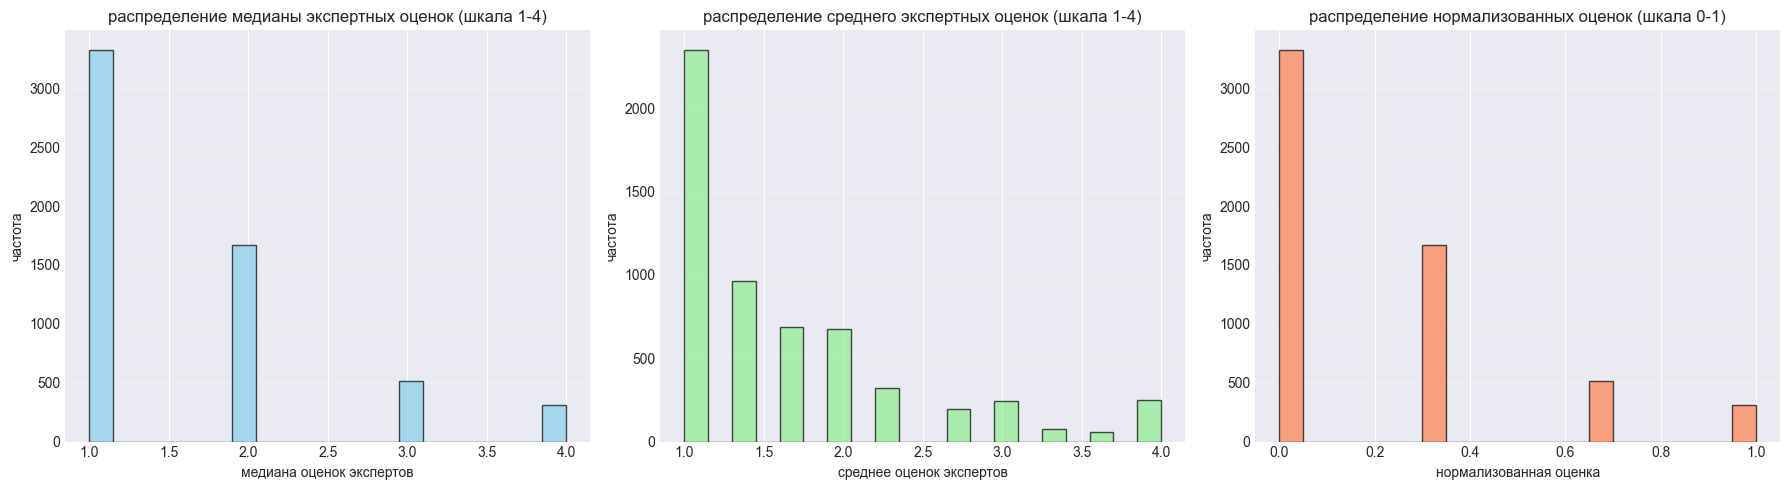

In [40]:
# агрегируем оценки экспертов медианой
master_df['expert_median'] = master_df[['expert1', 'expert2', 'expert3']].median(axis=1)

# также посчитаем среднее для сравнения
master_df['expert_mean'] = master_df[['expert1', 'expert2', 'expert3']].mean(axis=1)

# нормализуем в диапазон [0, 1]
# исходная шкала: 1-4, преобразуем: (оценка - 1) / 3
master_df['expert_score_normalized'] = (master_df['expert_median'] - 1) / 3

print("статистика агрегированных оценок:")
print("\nmedian:")
display(master_df['expert_median'].describe())
print("\nmean:")
display(master_df['expert_mean'].describe())
print("\nnormalized score [0, 1]:")
display(master_df['expert_score_normalized'].describe())

# распределение
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].hist(master_df['expert_median'], bins=20, edgecolor='black', alpha=0.7, color='skyblue')
axes[0].set_xlabel('медиана оценок экспертов')
axes[0].set_ylabel('частота')
axes[0].set_title('распределение медианы экспертных оценок (шкала 1-4)')
axes[0].grid(axis='y', alpha=0.3)

axes[1].hist(master_df['expert_mean'], bins=20, edgecolor='black', alpha=0.7, color='lightgreen')
axes[1].set_xlabel('среднее оценок экспертов')
axes[1].set_ylabel('частота')
axes[1].set_title('распределение среднего экспертных оценок (шкала 1-4)')
axes[1].grid(axis='y', alpha=0.3)

axes[2].hist(master_df['expert_score_normalized'], bins=20, edgecolor='black', alpha=0.7, color='coral')
axes[2].set_xlabel('нормализованная оценка')
axes[2].set_ylabel('частота')
axes[2].set_title('распределение нормализованных оценок (шкала 0-1)')
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### Сравнение медианы и среднего

разница между медианой и средним:


count    5822.000000
mean        0.134032
std         0.167492
min         0.000000
25%         0.000000
50%         0.000000
75%         0.333333
max         1.000000
Name: median_vs_mean_diff, dtype: float64


случаев, где медиана ≈ среднее: 3515 (60.4%)


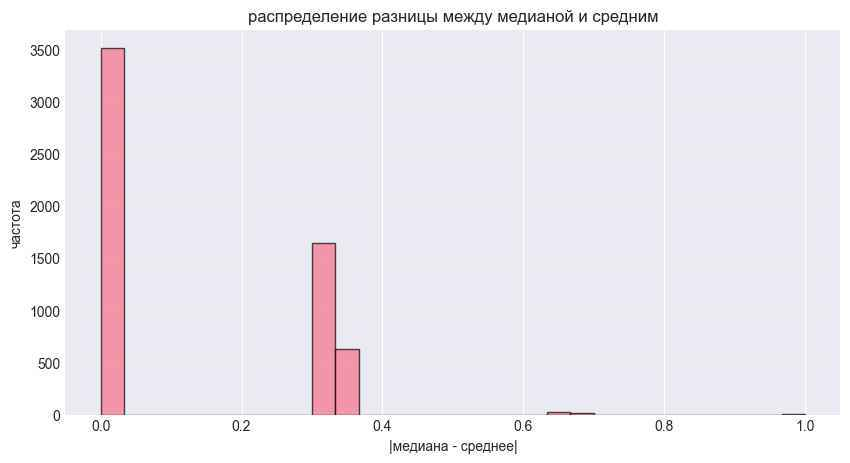

In [41]:
# сравним, насколько медиана и среднее отличаются
master_df['median_vs_mean_diff'] = abs(master_df['expert_median'] - master_df['expert_mean'])

print("разница между медианой и средним:")
display(master_df['median_vs_mean_diff'].describe())

# посчитаем, в скольких случаях они совпадают
same_count = (master_df['median_vs_mean_diff'] < 0.01).sum()
print(f"\nслучаев, где медиана ≈ среднее: {same_count} ({same_count/len(master_df)*100:.1f}%)")

# распределение разницы
plt.figure(figsize=(10, 5))
master_df['median_vs_mean_diff'].hist(bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('|медиана - среднее|')
plt.ylabel('частота')
plt.title('распределение разницы между медианой и средним')
plt.grid(axis='y', alpha=0.3)
plt.show()

**результаты агрегации:**
- создано три новых показателя:
  - `expert_median`: медиана оценок (шкала 1-4)
  - `expert_mean`: среднее оценок (шкала 1-4)
  - `expert_score_normalized`: нормализованная оценка (шкала 0-1)

**сравнение медианы и среднего:**
- средняя разница: 0.13
- медиана разницы: 0.0
- в 60.4% случаев медиана практически равна среднему (разница < 0.01)
- в случаях согласия экспертов медиана = среднему
- когда есть разброс оценок, медиана более устойчива к выбросам

**выбор метрики:**
- медиана предпочтительнее, так как:
  - более устойчива к единичным расхождениям во мнениях
  - в 60% случаев совпадает со средним
  - лучше работает при наличии выбросов
- нормализованная оценка удобна для обучения модели (диапазон [0, 1])

### Распределение по категориям оценок

разобью оценки на категории для лучшего понимания распределения:
- создам функцию `categorize_score()` для классификации оценок
- разделю на 4 категории:
  - плохое соответствие (1-1.5)
  - частичное соответствие (1.5-2.5)
  - хорошее соответствие (2.5-3.5)
  - отличное соответствие (3.5-4)
- подсчитаю количество пар в каждой категории
- построю столбчатую диаграмму

распределение по категориям:


expert_category
плохое соответствие (1-1.5)         3327
частичное соответствие (1.5-2.5)    1666
хорошее соответствие (2.5-3.5)       518
отличное соответствие (3.5-4)        311
Name: count, dtype: int64

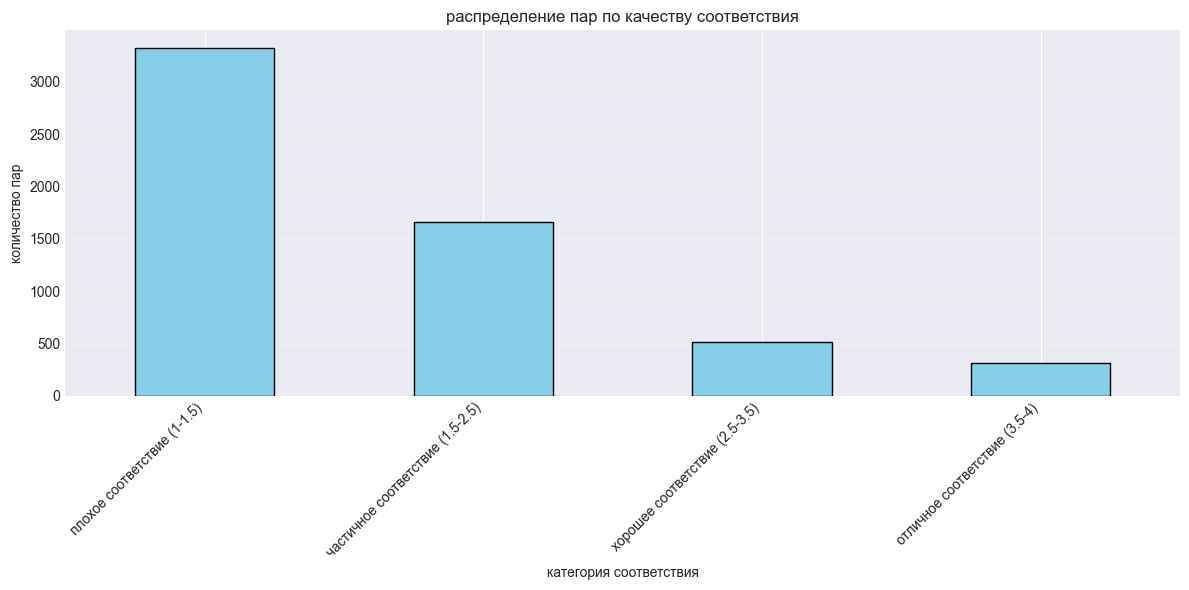

In [42]:
# разобьём на категории для анализа
def categorize_score(score):
    if score <= 1.5:
        return 'плохое соответствие (1-1.5)'
    elif score <= 2.5:
        return 'частичное соответствие (1.5-2.5)'
    elif score <= 3.5:
        return 'хорошее соответствие (2.5-3.5)'
    else:
        return 'отличное соответствие (3.5-4)'

master_df['expert_category'] = master_df['expert_median'].apply(categorize_score)

print("распределение по категориям:")
category_counts = master_df['expert_category'].value_counts()
display(category_counts)

# визуализация
plt.figure(figsize=(12, 6))
category_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('категория соответствия')
plt.ylabel('количество пар')
plt.title('распределение пар по качеству соответствия')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

**результаты:**
- создана колонка `expert_category` с категориями соответствия

**ключевые наблюдения:**
- **сильный дисбаланс классов**: 57% пар имеют плохое соответствие
- только 14.2% пар имеют хорошее или отличное соответствие
- это ожидаемо: большинство пар — изображение с чужим описанием
- дисбаланс нужно учитывать при обучении модели:
  - использовать взвешенные метрики
  - применить балансировку классов
  - возможно oversampling положительных примеров
- распределение показывает, что задача сложная: мало явно соответствующих пар

### Примеры пар с разными оценками

создам функцию для визуализации примеров с разными уровнями соответствия:
- напишу функцию `show_master_examples()` для отображения пар с агрегированными оценками
- покажу примеры из каждой категории:
  - плохое соответствие (медиана = 1)
  - частичное соответствие (медиана = 2)
  - хорошее соответствие (медиана = 3)
  - отличное соответствие (медиана = 4)
- использую цветовую индикацию для быстрой оценки качества
- создам сравнительную визуализацию всех категорий

In [43]:
# функция для показа примеров из master_df с оценками
def show_master_examples(df_subset, title, n_show=3):
    """
    показывает изображения с агрегированными экспертными оценками из master_df
    
    параметры:
    - df_subset: подмножество master_df
    - title: заголовок группы
    - n_show: количество примеров
    """
    print(f"\n{'='*80}")
    print(f"{title}")
    print(f"{'='*80}\n")
    
    n = min(len(df_subset), n_show)
    fig, axes = plt.subplots(1, n, figsize=(6*n, 6))
    
    if n == 1:
        axes = [axes]
    
    for idx, (_, row) in enumerate(df_subset.head(n).iterrows()):
        image_path = os.path.join(train_images_dir, row['image_file'])
        
        if os.path.exists(image_path):
            img = Image.open(image_path)
            axes[idx].imshow(img)
            axes[idx].axis('off')
            
            # цвет в зависимости от медианы
            if row['expert_median'] == 4.0:
                color = 'darkgreen'
            elif row['expert_median'] == 3.0:
                color = 'green'
            elif row['expert_median'] == 2.0:
                color = 'orange'
            else:
                color = 'red'
            
            text_info = (
                f"медиана: {row['expert_median']}\n"
                f"оценки: [{row['expert1']}, {row['expert2']}, {row['expert3']}]\n\n"
                f"описание:\n{row['query_text'][:90]}..."
            )
            axes[idx].set_title(text_info, fontsize=9, color=color)
        else:
            axes[idx].text(0.5, 0.5, f'изображение не найдено:\n{row["image_file"]}', 
                          ha='center', va='center')
            axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # подробная информация
    print("\nподробная информация:")
    for idx, (_, row) in enumerate(df_subset.head(n).iterrows()):
        print(f"\n{idx+1}. изображение: {row['image_file']}")
        print(f"   оценки: expert1={row['expert1']}, expert2={row['expert2']}, expert3={row['expert3']}")
        print(f"   медиана: {row['expert_median']}")
        print(f"   описание: {row['query_text']}")

примеры пар с разными уровнями соответствия:

=== ПЛОХОЕ СООТВЕТСТВИЕ (медиана = 1) ===


image_file  \
0  1056338697_4f7d7ce270.jpg   
1  1056338697_4f7d7ce270.jpg   
2  1056338697_4f7d7ce270.jpg   

                                          query_text  expert1  expert2  \
0  A young child is wearing blue goggles and sitt...        1        1   
1  A girl wearing a yellow shirt and sunglasses s...        1        1   
2    A man sleeps under a blanket on a city street .        1        1   

   expert3  expert_median  
0        1            1.0  
1        2            1.0  
2        2            1.0


ПЛОХОЕ СООТВЕТСТВИЕ (медиана = 1)



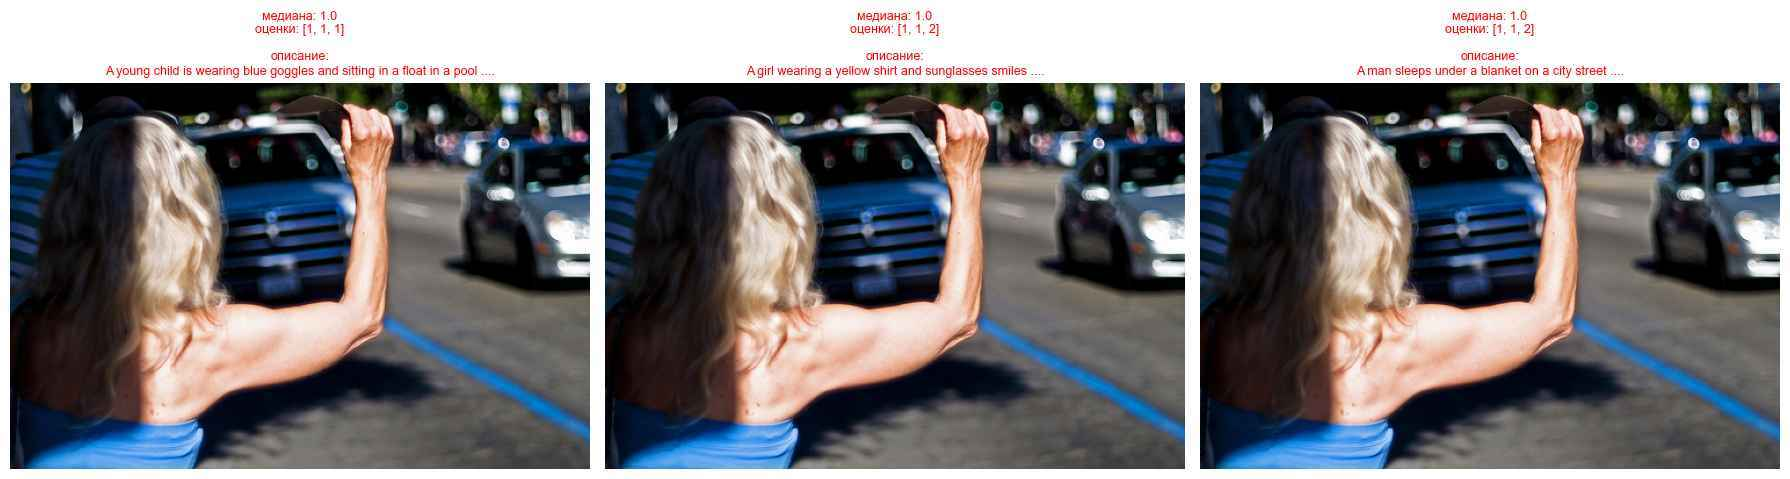


подробная информация:

1. изображение: 1056338697_4f7d7ce270.jpg
   оценки: expert1=1, expert2=1, expert3=1
   медиана: 1.0
   описание: A young child is wearing blue goggles and sitting in a float in a pool .

2. изображение: 1056338697_4f7d7ce270.jpg
   оценки: expert1=1, expert2=1, expert3=2
   медиана: 1.0
   описание: A girl wearing a yellow shirt and sunglasses smiles .

3. изображение: 1056338697_4f7d7ce270.jpg
   оценки: expert1=1, expert2=1, expert3=2
   медиана: 1.0
   описание: A man sleeps under a blanket on a city street .

=== ЧАСТИЧНОЕ СООТВЕТСТВИЕ (медиана = 2) ===


image_file  \
3   1056338697_4f7d7ce270.jpg   
9    106490881_5a2dd9b7bd.jpg   
10   106490881_5a2dd9b7bd.jpg   

                                           query_text  expert1  expert2  \
3   A woman plays with long red ribbons in an empt...        1        2   
9        A little boy shakes the snow off of a tree .        2        2   
10                The kid is on a float in the snow .        2        2   

    expert3  expert_median  
3         2            2.0  
9         2            2.0  
10        2            2.0


ЧАСТИЧНОЕ СООТВЕТСТВИЕ (медиана = 2)



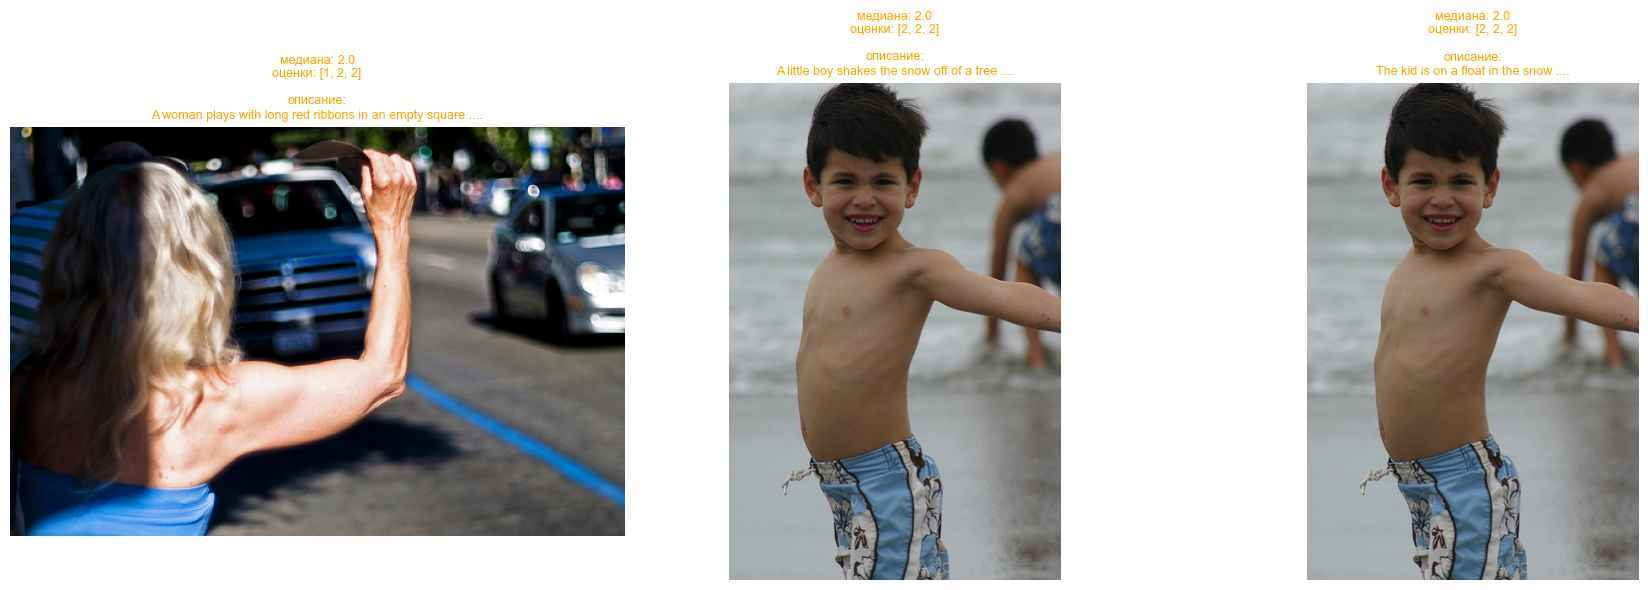


подробная информация:

1. изображение: 1056338697_4f7d7ce270.jpg
   оценки: expert1=1, expert2=2, expert3=2
   медиана: 2.0
   описание: A woman plays with long red ribbons in an empty square .

2. изображение: 106490881_5a2dd9b7bd.jpg
   оценки: expert1=2, expert2=2, expert3=2
   медиана: 2.0
   описание: A little boy shakes the snow off of a tree .

3. изображение: 106490881_5a2dd9b7bd.jpg
   оценки: expert1=2, expert2=2, expert3=2
   медиана: 2.0
   описание: The kid is on a float in the snow .

=== ХОРОШЕЕ СООТВЕТСТВИЕ (медиана = 3) ===


image_file  \
22  1084040636_97d9633581.jpg   
32  1107246521_d16a476380.jpg   
36  1107246521_d16a476380.jpg   

                                          query_text  expert1  expert2  \
22      Close-up of dog in profile with mouth open .        2        3   
32  Large dog plays with two smaller dogs on grass .        2        3   
36               Three dogs are playing in a field .        3        3   

    expert3  expert_median  
22        3            3.0  
32        3            3.0  
36        3            3.0


ХОРОШЕЕ СООТВЕТСТВИЕ (медиана = 3)



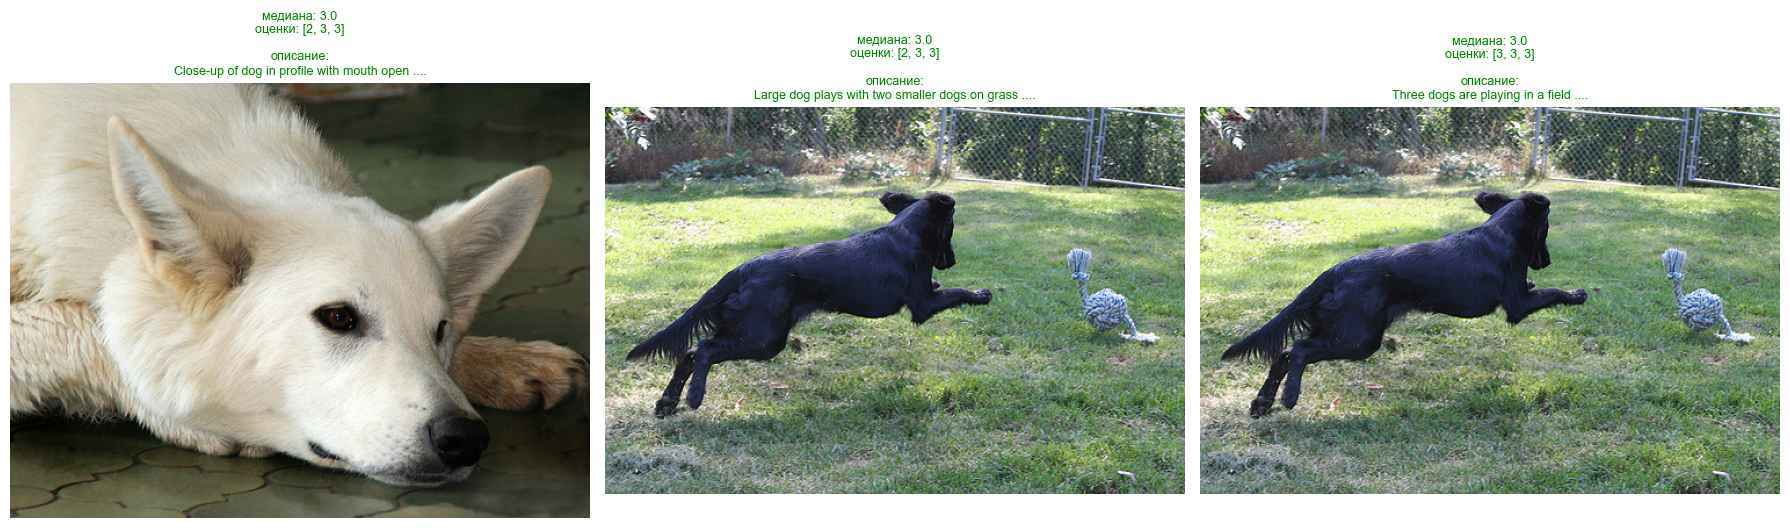


подробная информация:

1. изображение: 1084040636_97d9633581.jpg
   оценки: expert1=2, expert2=3, expert3=3
   медиана: 3.0
   описание: Close-up of dog in profile with mouth open .

2. изображение: 1107246521_d16a476380.jpg
   оценки: expert1=2, expert2=3, expert3=3
   медиана: 3.0
   описание: Large dog plays with two smaller dogs on grass .

3. изображение: 1107246521_d16a476380.jpg
   оценки: expert1=3, expert2=3, expert3=3
   медиана: 3.0
   описание: Three dogs are playing in a field .

=== ОТЛИЧНОЕ СООТВЕТСТВИЕ (медиана = 4) ===


image_file                             query_text  expert1  \
43  1119015538_e8e796281e.jpg        A white dog runs in the grass ,        4   
50  1131800850_89c7ffd477.jpg        A brown dog shaking off water .        3   
53  1131932671_c8d17751b3.jpg  A boy jumps from one bed to another .        4   

    expert2  expert3  expert_median  
43        4        4            4.0  
50        4        4            4.0  
53        4        4            4.0


ОТЛИЧНОЕ СООТВЕТСТВИЕ (медиана = 4)



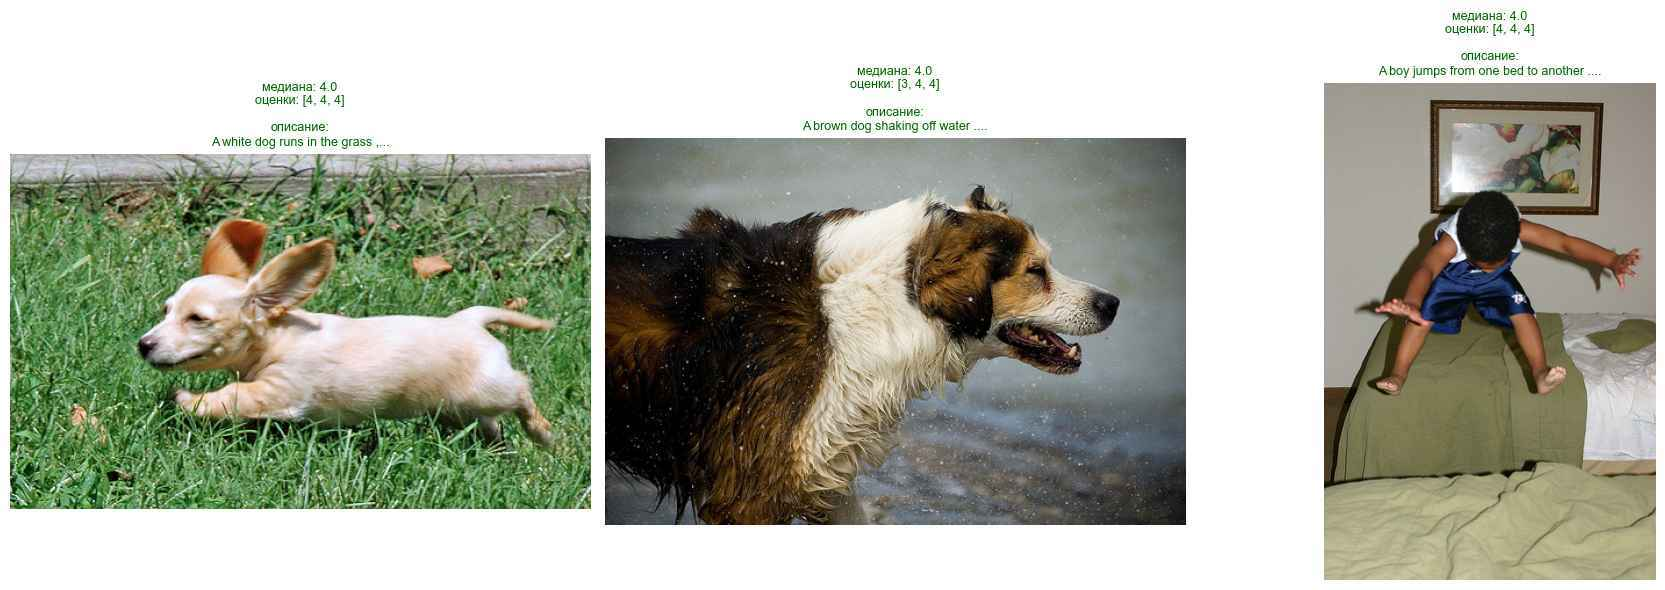


подробная информация:

1. изображение: 1119015538_e8e796281e.jpg
   оценки: expert1=4, expert2=4, expert3=4
   медиана: 4.0
   описание: A white dog runs in the grass ,

2. изображение: 1131800850_89c7ffd477.jpg
   оценки: expert1=3, expert2=4, expert3=4
   медиана: 4.0
   описание: A brown dog shaking off water .

3. изображение: 1131932671_c8d17751b3.jpg
   оценки: expert1=4, expert2=4, expert3=4
   медиана: 4.0
   описание: A boy jumps from one bed to another .

СРАВНЕНИЕ ВСЕХ КАТЕГОРИЙ


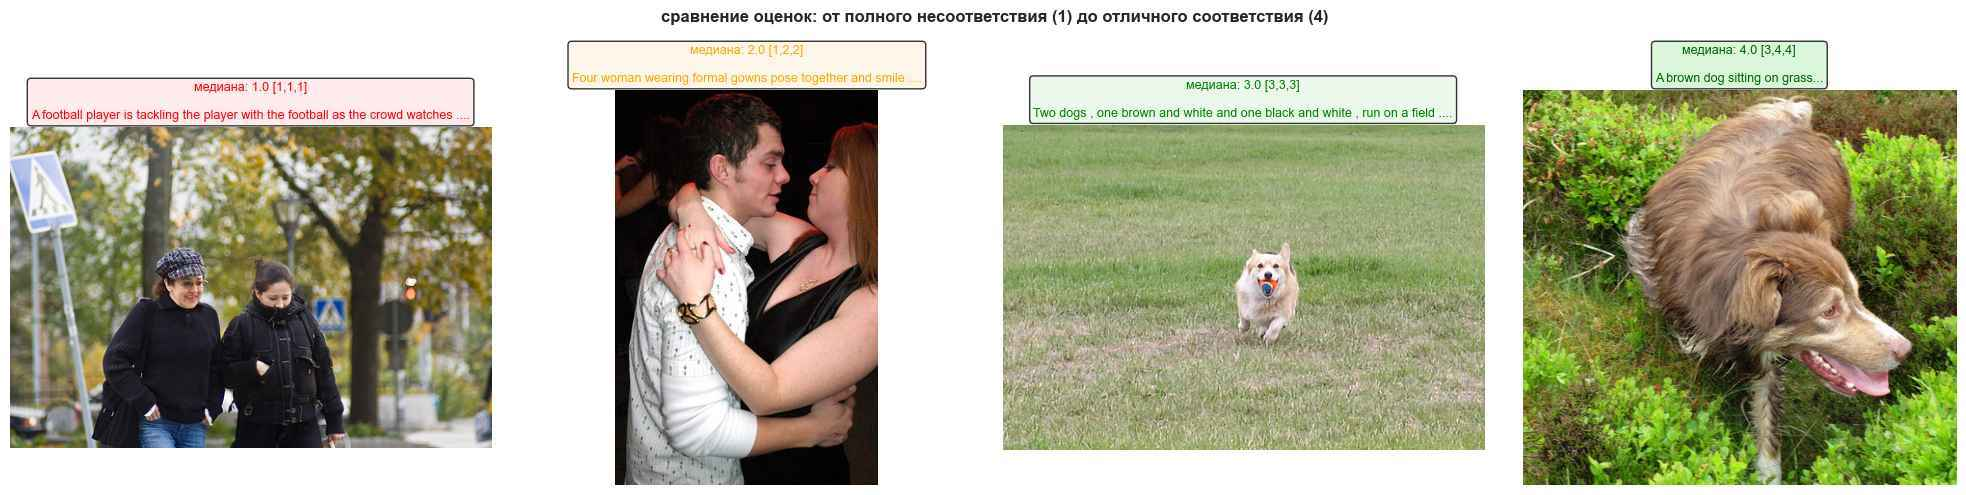

In [44]:
# плохое соответствие
print("примеры пар с разными уровнями соответствия:\n")
print("=== ПЛОХОЕ СООТВЕТСТВИЕ (медиана = 1) ===")
bad_examples = master_df[master_df['expert_median'] == 1.0][
    ['image_file', 'query_text', 'expert1', 'expert2', 'expert3', 'expert_median']
].head(3)
display(bad_examples)
show_master_examples(
    master_df[master_df['expert_median'] == 1.0], 
    "ПЛОХОЕ СООТВЕТСТВИЕ (медиана = 1)"
)

# частичное соответствие
print("\n=== ЧАСТИЧНОЕ СООТВЕТСТВИЕ (медиана = 2) ===")
partial_examples = master_df[master_df['expert_median'] == 2.0][
    ['image_file', 'query_text', 'expert1', 'expert2', 'expert3', 'expert_median']
].head(3)
display(partial_examples)
show_master_examples(
    master_df[master_df['expert_median'] == 2.0], 
    "ЧАСТИЧНОЕ СООТВЕТСТВИЕ (медиана = 2)"
)

# хорошее соответствие
print("\n=== ХОРОШЕЕ СООТВЕТСТВИЕ (медиана = 3) ===")
good_examples = master_df[master_df['expert_median'] == 3.0][
    ['image_file', 'query_text', 'expert1', 'expert2', 'expert3', 'expert_median']
].head(3)
display(good_examples)
show_master_examples(
    master_df[master_df['expert_median'] == 3.0], 
    "ХОРОШЕЕ СООТВЕТСТВИЕ (медиана = 3)"
)

# отличное соответствие
print("\n=== ОТЛИЧНОЕ СООТВЕТСТВИЕ (медиана = 4) ===")
excellent_examples = master_df[master_df['expert_median'] == 4.0][
    ['image_file', 'query_text', 'expert1', 'expert2', 'expert3', 'expert_median']
].head(3)
display(excellent_examples)
show_master_examples(
    master_df[master_df['expert_median'] == 4.0], 
    "ОТЛИЧНОЕ СООТВЕТСТВИЕ (медиана = 4)"
)

# дополнительно: сравнение всех категорий на одном графике
print("\n" + "="*80)
print("СРАВНЕНИЕ ВСЕХ КАТЕГОРИЙ")
print("="*80)

# по одному случайному примеру из каждой категории
comparison_examples = pd.concat([
    master_df[master_df['expert_median'] == 1.0].sample(1, random_state=42),
    master_df[master_df['expert_median'] == 2.0].sample(1, random_state=42),
    master_df[master_df['expert_median'] == 3.0].sample(1, random_state=42),
    master_df[master_df['expert_median'] == 4.0].sample(1, random_state=42),
])

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for idx, (_, row) in enumerate(comparison_examples.iterrows()):
    image_path = os.path.join(train_images_dir, row['image_file'])
    
    if os.path.exists(image_path):
        img = Image.open(image_path)
        axes[idx].imshow(img)
        axes[idx].axis('off')
        
        # цвет в зависимости от медианы
        colors = {1.0: 'red', 2.0: 'orange', 3.0: 'green', 4.0: 'darkgreen'}
        bg_colors = {1.0: '#ffe6e6', 2.0: '#fff4e6', 3.0: '#e6f7e6', 4.0: '#d4f4d4'}
        
        text_info = (
            f"медиана: {row['expert_median']} [{row['expert1']},{row['expert2']},{row['expert3']}]\n\n"
            f"{row['query_text'][:100]}..."
        )
        axes[idx].set_title(text_info, fontsize=9, color=colors[row['expert_median']],
                           bbox=dict(boxstyle='round', facecolor=bg_colors[row['expert_median']], alpha=0.8))

plt.suptitle('сравнение оценок: от полного несоответствия (1) до отличного соответствия (4)', 
             fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

**наблюдения:**
- видна четкая градация от полного несоответствия (красный) до отличного соответствия (тёмно-зелёный)
- сравнительная визуализация наглядно показывает разницу между категориями
- примеры подтверждают надёжность экспертных оценок

### Анализ баланса данных

проанализирую баланс целевой переменной:
- подсчитаю распределение медианы экспертных оценок
- вычислю процентное соотношение каждой оценки
- построю визуализации для абсолютных значений и процентов
- оценю степень дисбаланса классов

анализ баланса данных:

распределение медианы экспертных оценок:


expert_median
1.0    3327
2.0    1666
3.0     518
4.0     311
Name: count, dtype: int64


процентное соотношение:


expert_median
1.0    57.15
2.0    28.62
3.0     8.90
4.0     5.34
Name: count, dtype: float64

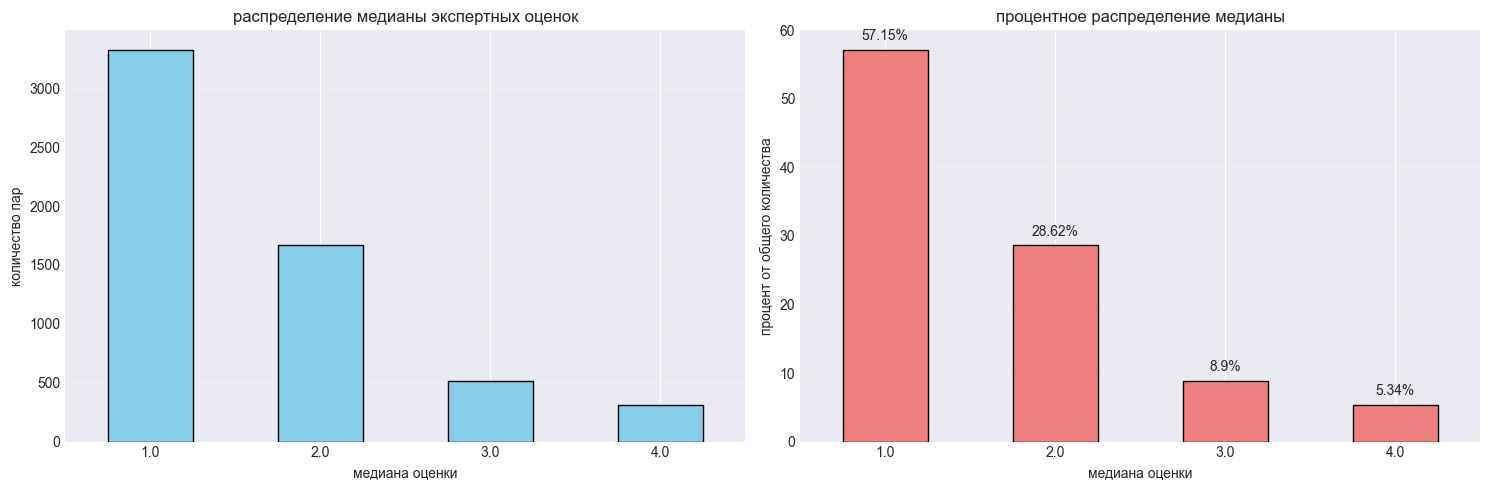

In [45]:
# проанализируем баланс целевой переменной
print("анализ баланса данных:\n")

# распределение медианы
median_dist = master_df['expert_median'].value_counts().sort_index()
print("распределение медианы экспертных оценок:")
display(median_dist)

# процентное соотношение
print("\nпроцентное соотношение:")
median_pct = (median_dist / len(master_df) * 100).round(2)
display(median_pct)

# визуализация баланса
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# абсолютные значения
median_dist.plot(kind='bar', ax=axes[0], color='skyblue', edgecolor='black')
axes[0].set_xlabel('медиана оценки')
axes[0].set_ylabel('количество пар')
axes[0].set_title('распределение медианы экспертных оценок')
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# процентное соотношение
median_pct.plot(kind='bar', ax=axes[1], color='lightcoral', edgecolor='black')
axes[1].set_xlabel('медиана оценки')
axes[1].set_ylabel('процент от общего количества')
axes[1].set_title('процентное распределение медианы')
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

# добавим значения на столбцы
for i, v in enumerate(median_pct):
    axes[1].text(i, v + 1, f'{v}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

**результаты:**

**критический дисбаланс классов:**
- **более половины данных** (57%) имеют самую низкую оценку
- только **14.24%** данных имеют высокие оценки (3-4)
- соотношение наилучших к наихудшим: 311:3327 ≈ 1:11

**последствия для обучения модели:**
- модель может научиться предсказывать в основном низкие оценки
- высокая точность на классе "1" не означает хорошую модель
- нужны специальные меры для работы с дисбалансом

**необходимые действия:**
- использовать взвешенные метрики (weighted MAE, weighted MSE)
- применить class weights при обучении
- рассмотреть oversampling положительных примеров
- использовать stratified split при разделении на train/test
- оценивать модель не только по общей точности, но и по метрикам для каждого класса отдельно

### Выводы по агрегации экспертных оценок

**ключевые наблюдения:**

**распределение оценок:**
- медиана экспертов: среднее = 1.62, медиана = 1.0
- нормализованная оценка [0, 1]: среднее = 0.21, медиана = 0.0
- **сильный дисбаланс**: 57% пар имеют оценку 1.0 (полное несоответствие)
- только 14% пар имеют высокие оценки (3-4)

**сравнение медианы и среднего:**
- в 60.4% случаев медиана практически равна среднему (разница < 0.01)
- средняя разница: 0.13
- **вывод**: медиана — оптимальный выбор для агрегации:
  - устойчива к выбросам
  - в большинстве случаев совпадает со средним
  - лучше отражает консенсус экспертов при разбросе мнений

**баланс классов — критическая проблема:**
```
плохое соответствие (1.0):      3327 пар (57.15%)  ← большинство
частичное соответствие (2.0):   1666 пар (28.62%)
хорошее соответствие (3.0):      518 пар (8.90%)
отличное соответствие (4.0):     311 пар (5.34%)   ← меньшинство
```

**соотношение классов:**
- наилучших к наихудшим: 311:3327 ≈ 1:11
- более 85% данных имеют оценки 1-2
- менее 15% данных имеют оценки 3-4

**последствия дисбаланса:**
- модель может научиться всегда предсказывать низкие оценки
- высокая общая точность не будет означать качественную модель
- риск игнорирования положительных примеров

**необходимые меры при обучении:**
- **не использовать accuracy** как основную метрику
- применить class weights (больший вес для классов 3-4)
- использовать взвешенные метрики (weighted MAE, weighted MSE)
- рассмотреть oversampling положительных примеров
- stratified split при разделении на train/test
- отслеживать метрики отдельно для каждого класса

**итоговая целевая переменная:**
- выбрана `expert_score_normalized` (нормализованная медиана в диапазоне [0, 1])
- удобна для регрессионных моделей
- сохраняет информацию о степени соответствия
- готова для обучения модели

## Работа с краудсорсинговыми оценками

Добавим краудсорсинговые оценки к master_df и создадим комбинированную целевую переменную.

### Подготовка краудсорсинговых оценок

подготовлю краудсорсинговые оценки для объединения с основным датасетом:
- проверю структуру `crowd_df`
- подсчитаю количество уникальных пар (image_file, caption_id)
- создам упрощённую версию `crowd_for_merge` с тремя колонками:
  - `image_file` — имя файла изображения
  - `caption_id` — идентификатор описания
  - `agreement_ratio` — доля согласия краудворкеров
- эти колонки будут использованы для merge с `master_df`

In [46]:
# посмотрим на структуру crowd_df
print("\nструктура crowd_df:")
print(f"строк: {len(crowd_df)}")
print(f"уникальных пар (image_file, caption_id): {crowd_df.groupby(['image_file', 'caption_id']).size().shape[0]}")

# создадим упрощённую версию crowd_df для объединения
crowd_for_merge = crowd_df[['image_file', 'caption_id', 'agreement_ratio']].copy()

print("\nпервые строки crowd_for_merge:")
display(crowd_for_merge.head())


структура crowd_df:
строк: 47830
уникальных пар (image_file, caption_id): 47830

первые строки crowd_for_merge:


image_file                   caption_id  agreement_ratio
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2              1.0
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2              0.0
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2              0.0
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2              0.0
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2              0.0

**результаты:**
- `crowd_df` содержит 47830 строк
- 47830 уникальных пар (image_file, caption_id) — нет дубликатов
- создана таблица `crowd_for_merge` с тремя необходимыми колонками
- примеры показывают:
  - первая пара имеет `agreement_ratio` = 1.0 (полное согласие краудворкеров)
  - остальные четыре пары имеют `agreement_ratio` = 0.0 (краудворкеры не согласились)
- данные готовы для объединения с `master_df`

### Объединение с краудсорсинговыми оценками

объединю `master_df` с краудсорсинговыми оценками:
- выполню left merge по ключам `image_file` и `caption_id`
- left merge сохранит все строки из `master_df`
- для пар без краудсорсинговой оценки будет NaN
- проверю количество пропусков
- посмотрю на примеры объединённых данных

In [47]:
# объединяем master_df с краудсорсинговыми оценками
master_df = master_df.merge(
    crowd_for_merge,
    on=['image_file', 'caption_id'],
    how='left'
)

print(f"размер после объединения с crowd: {master_df.shape}")
print(f"пропусков в agreement_ratio: {master_df['agreement_ratio'].isnull().sum()}")

# посмотрим на объединённые данные
print("\nпервые строки с обеими оценками:")
display(master_df[['image_file', 'caption_id', 'expert_score_normalized', 
                     'agreement_ratio', 'query_text']].head())

размер после объединения с crowd: (5822, 17)
пропусков в agreement_ratio: 3493

первые строки с обеими оценками:


image_file                   caption_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2   

   expert_score_normalized  agreement_ratio  \
0                 0.000000              0.0   
1                 0.000000              0.0   
2                 0.000000              NaN   
3                 0.333333              NaN   
4                 0.000000              NaN   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A girl wearing a yellow shirt and sunglasses s...  
2    A man sleeps under a blanket on a city street .  
3  A woman plays with long red ribbons in an empt...  
4         Chinese market street in the winter time .

**результаты:**
- размер датасета после объединения: 5822 строки × 17 колонок
- **пропусков в agreement_ratio: 3493 (60%)**
- это означает:
  - 2329 пар (40%) имеют обе оценки (экспертные и краудсорсинговые)
  - 3493 пары (60%) имеют только экспертные оценки

**объяснение пропусков:**
- `expert_df` содержит 5822 пары (977 уникальных `caption_id`)
- `crowd_df` содержит 47830 пар (1000 уникальных `caption_id`)
- не все пары из `expert_df` были оценены краудворкерами
- это нормально: эксперты и краудворкеры оценивали частично пересекающиеся наборы пар

### Анализ пропусков

проанализирую покрытие данных обеими разметками:
- подсчитаю количество пар с обеими оценками (эксперты + краудсорсинг)
- подсчитаю количество пар только с экспертными оценками
- вычислю процент покрытия
- покажу примеры пар без краудсорсинговой оценки
- сравню распределения обеих оценок для пар с полными данными

In [48]:
# проверим, сколько пар есть в обеих разметках
both_available = master_df['agreement_ratio'].notna().sum()
only_expert = master_df['agreement_ratio'].isna().sum()


print(f"\nпар с обеими разметками (эксперты + краудсорсинг): {both_available}")
print(f"пар только с экспертной разметкой: {only_expert}")
print(f"всего пар: {len(master_df)}")
print(f"\nпроцент покрытия краудсорсингом: {both_available/len(master_df)*100:.2f}%")

# примеры пар без краудсорсинговой оценки
if only_expert > 0:
    print("\nпримеры пар без краудсорсинговой оценки:")
    display(master_df[master_df['agreement_ratio'].isna()][
        ['image_file', 'caption_id', 'query_text', 'expert_median', 'expert_score_normalized']
    ].head(5))
else:
    print("\nвсе пары имеют краудсорсинговые оценки!")


пар с обеими разметками (эксперты + краудсорсинг): 2329
пар только с экспертной разметкой: 3493
всего пар: 5822

процент покрытия краудсорсингом: 40.00%

примеры пар без краудсорсинговой оценки:


image_file                   caption_id  \
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2   
5  1056338697_4f7d7ce270.jpg  3360930596_1e75164ce6.jpg#2   
6  1056338697_4f7d7ce270.jpg  3545652636_0746537307.jpg#2   

                                          query_text  expert_median  \
2    A man sleeps under a blanket on a city street .            1.0   
3  A woman plays with long red ribbons in an empt...            2.0   
4         Chinese market street in the winter time .            1.0   
5  A soccer ball is above the head of a man weari...            1.0   
6  A young boy dressed in a red uniform kicks the...            1.0   

   expert_score_normalized  
2                 0.000000  
3                 0.333333  
4                 0.000000  
5                 0.000000  
6                 0.000000

### Сравнение распределений экспертных и краудсорсинговых оценок

визуально сравнивню, как распределены оценки экспертов и краудворкеров

- Похожи ли распределения?
- Какие средние значения?
- У кого больше разброс?


пар с обеими оценками для анализа: 2329


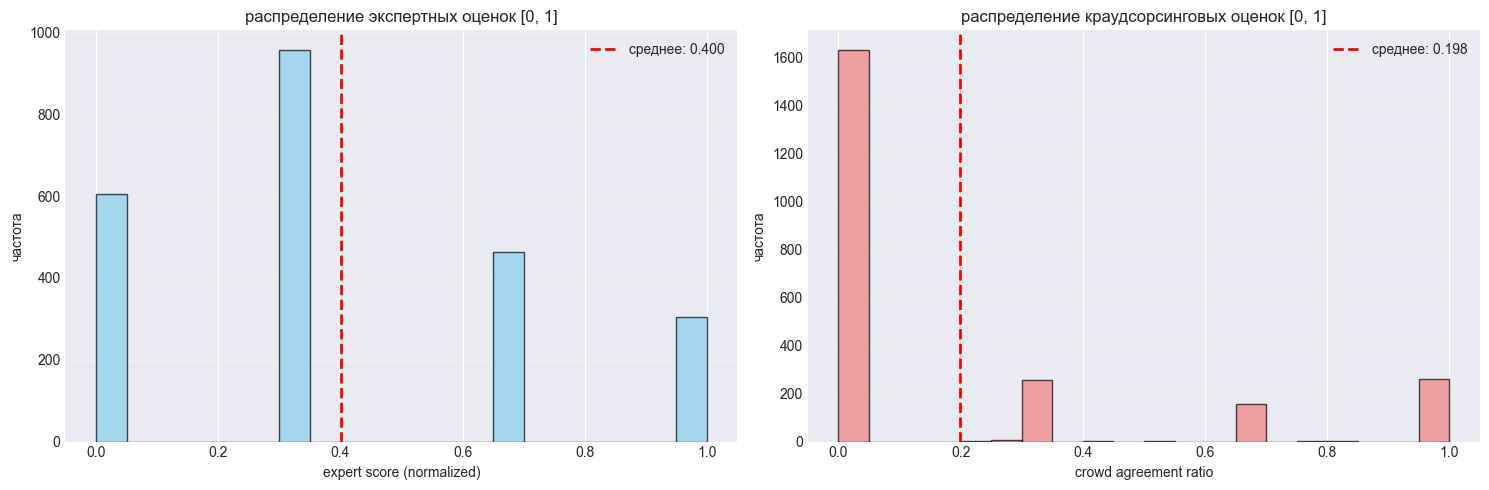


статистика экспертных оценок (нормализованных):


count    2329.000000
mean        0.400458
std         0.323491
min         0.000000
25%         0.000000
50%         0.333333
75%         0.666667
max         1.000000
Name: expert_score_normalized, dtype: float64


статистика краудсорсинговых оценок:


count    2329.000000
mean        0.198283
std         0.343315
min         0.000000
25%         0.000000
50%         0.000000
75%         0.333333
max         1.000000
Name: agreement_ratio, dtype: float64

In [49]:
# оставим только те строки, где есть обе оценки для корректного сравнения
df_both = master_df[master_df['agreement_ratio'].notna()].copy()

print(f"\nпар с обеими оценками для анализа: {len(df_both)}")

# сравним распределения
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# экспертные оценки (нормализованные)
axes[0].hist(df_both['expert_score_normalized'], bins=20, edgecolor='black', 
             alpha=0.7, color='skyblue')
axes[0].set_xlabel('expert score (normalized)')
axes[0].set_ylabel('частота')
axes[0].set_title('распределение экспертных оценок [0, 1]')
axes[0].axvline(df_both['expert_score_normalized'].mean(), color='red', 
                linestyle='--', linewidth=2, label=f"среднее: {df_both['expert_score_normalized'].mean():.3f}")
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# краудсорсинговые оценки
axes[1].hist(df_both['agreement_ratio'], bins=20, edgecolor='black', 
             alpha=0.7, color='lightcoral')
axes[1].set_xlabel('crowd agreement ratio')
axes[1].set_ylabel('частота')
axes[1].set_title('распределение краудсорсинговых оценок [0, 1]')
axes[1].axvline(df_both['agreement_ratio'].mean(), color='red', 
                linestyle='--', linewidth=2, label=f"среднее: {df_both['agreement_ratio'].mean():.3f}")
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# статистика
print("\nстатистика экспертных оценок (нормализованных):")
display(df_both['expert_score_normalized'].describe())

print("\nстатистика краудсорсинговых оценок:")
display(df_both['agreement_ratio'].describe())

**результаты анализа покрытия:**
- **пар с обеими разметками**: 2329 (40.00%)
- **пар только с экспертной разметкой**: 3493 (60.00%)
- всего пар: 5822

**объяснение разницы:**
- эксперты оценили 5822 пары
- краудворкеры оценили 47830 пар (другой набор)
- пересечение составляет только 40%
- это означает, что эксперты и краудворкеры работали с частично разными выборками

**примеры пар без краудсорсинговой оценки:**
- имеют только экспертные оценки (`expert_median`, `expert_score_normalized`)
- `agreement_ratio` = NaN
- примеры: описания про мужчину на улице, женщину с лентами, китайский рынок

**сравнение распределений (для 2329 пар с обеими оценками):**

распределение экспертных оценок (normalized):
- среднее: 0.400
- медиана: 0.333
- более равномерное распределение
- меньше концентрации на нуле

распределение краудсорсинговых оценок:
- среднее: 0.198
- медиана: 0.0
- **сильная концентрация на нуле** (большинство пар)
- краудворкеры более строгие в оценках

**ключевые различия:**
- **эксперты более мягкие**: среднее 0.40 vs 0.20 у краудворкеров
- **краудворкеры более категоричны**: медиана 0.0 (большинство пар полностью не соответствуют)
- **разный разброс**: std = 0.32 у экспертов vs 0.34 у краудворкеров
- оба распределения смещены влево (больше низких оценок)

**почему такая разница:**
- эксперты оценивали по шкале 1-4 (4 градации)
- краудворкеры голосовали да/нет (бинарно), затем агрегировали
- разные критерии оценки соответствия
- эксперты могли видеть нюансы, краудворкеры — более прямолинейны

### Корреляция между оценками

проанализирую корреляцию между экспертными и краудсорсинговыми оценками:
- вычислю корреляцию Пирсона для 2329 пар с обеими оценками
- построю scatter plot для визуализации взаимосвязи
- добавлю диагональную линию для показа идеального совпадения
- интерпретирую результат


корреляция между оценками:


expert_score_normalized  agreement_ratio
expert_score_normalized                 1.000000         0.762474
agreement_ratio                         0.762474         1.000000


коэффициент корреляции пирсона: 0.762
интерпретация: сильная положительная связь


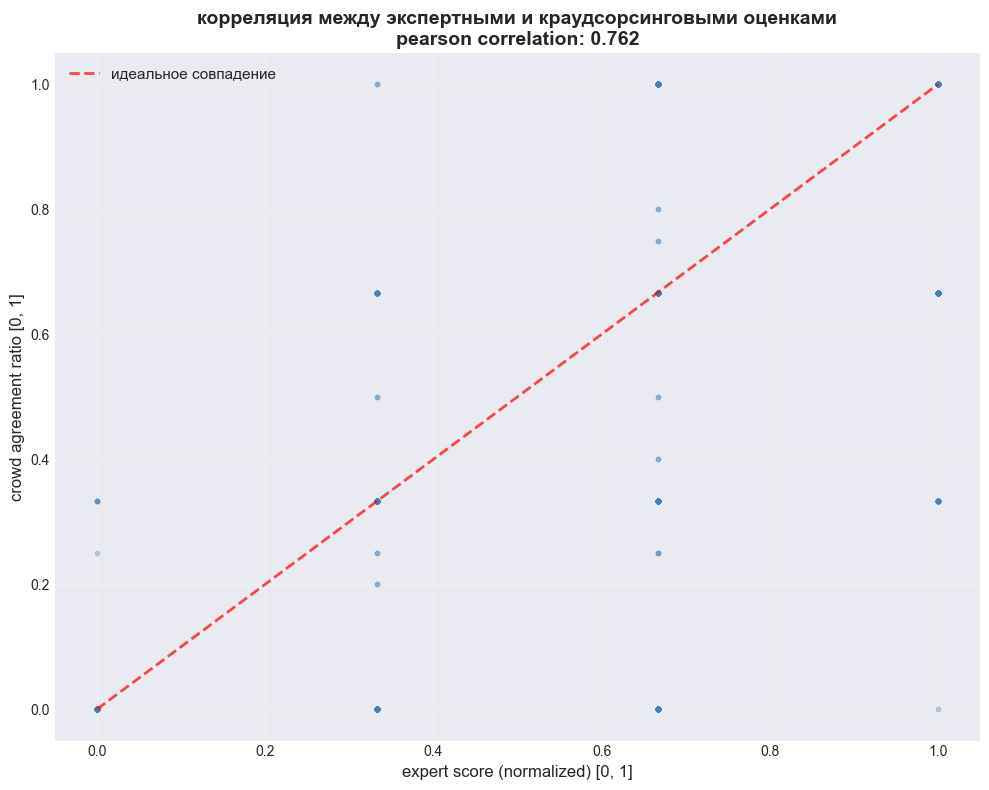

In [50]:
# корреляция между оценками
correlation = df_both[['expert_score_normalized', 'agreement_ratio']].corr()
print("\nкорреляция между оценками:")
display(correlation)

correlation_value = correlation.iloc[0, 1]
print(f"\nкоэффициент корреляции пирсона: {correlation_value:.3f}")

# интерпретация
if correlation_value > 0.7:
    interpretation = "сильная положительная связь"
elif correlation_value > 0.4:
    interpretation = "умеренная положительная связь"
elif correlation_value > 0.2:
    interpretation = "слабая положительная связь"
else:
    interpretation = "очень слабая или отсутствует"
    
print(f"интерпретация: {interpretation}")

# scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(df_both['expert_score_normalized'], df_both['agreement_ratio'], 
            alpha=0.3, s=10, color='steelblue')
plt.xlabel('expert score (normalized) [0, 1]', fontsize=12)
plt.ylabel('crowd agreement ratio [0, 1]', fontsize=12)
plt.title(f'корреляция между экспертными и краудсорсинговыми оценками\n'
          f'pearson correlation: {correlation_value:.3f}', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# диагональная линия (идеальное совпадение)
plt.plot([0, 1], [0, 1], 'r--', linewidth=2, label='идеальное совпадение', alpha=0.7)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

**что это означает:**
- эксперты и краудворкеры **в целом согласны** друг с другом
- когда эксперты ставят высокую оценку, краудворкеры тоже склонны соглашаться
- когда эксперты ставят низкую оценку, краудворкеры тоже не видят соответствия
- корреляция выше 0.7 считается сильной в социальных науках

**практический вывод:**
- **можно смело комбинировать оценки** в единую целевую переменную
- высокая корреляция подтверждает надёжность обеих разметок
- комбинированная оценка будет более робастной
- различия в оценках (среднее 0.40 vs 0.20) объясняются разными шкалами, но общий тренд совпадает

**сравнение с предыдущими результатами:**
- корреляция между экспертами: 0.79-0.89 (очень высокая)
- корреляция эксперты-краудворкеры: 0.76 (высокая)
- это подтверждает общую согласованность всех оценщиков

### Создание комбинированной целевой переменной

создам комбинированную целевую переменную:
- для пар с обеими оценками: `combined_score = 0.7 × expert_score + 0.3 × agreement_ratio`
- для пар только с экспертной оценкой: используем `expert_score_normalized`
- веса 70/30 отдают приоритет экспертам как более надёжным оценщикам
- проанализирую распределение комбинированной оценки
- разобью на диапазоны для лучшего понимания
- построю гистограмму и boxplot


статистика комбинированной оценки:


count    5822.000000
mean        0.183855
std         0.264816
min         0.000000
25%         0.000000
50%         0.000000
75%         0.333333
max         1.000000
Name: combined_score, dtype: float64


пар с комбинированной оценкой: 5822
пропусков: 0

примеры комбинированных оценок:


image_file                   caption_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2   
5  1056338697_4f7d7ce270.jpg  3360930596_1e75164ce6.jpg#2   
6  1056338697_4f7d7ce270.jpg  3545652636_0746537307.jpg#2   
7  1056338697_4f7d7ce270.jpg   434792818_56375e203f.jpg#2   
8   106490881_5a2dd9b7bd.jpg  1425069308_488e5fcf9d.jpg#2   
9   106490881_5a2dd9b7bd.jpg  1714316707_8bbaa2a2ba.jpg#2   

   expert_score_normalized  agreement_ratio  combined_score  
0                 0.000000              0.0        0.000000  
1                 0.000000              0.0        0.000000  
2                 0.000000              NaN        0.000000  
3                 0.333333              NaN        0.333333  
4                 0.000000              NaN        0.000000  
5                 0.000000              NaN        0.000000  
6                 0.000000              NaN        0.000000  
7                 0.000000              0.0        0.000000  
8                 0.000000              NaN        0.000000  
9                 0.333333              NaN        0.333333

РАСПРЕДЕЛЕНИЕ ПО ДИАПАЗОНАМ
  точно 0 (полное несоответствие)         : 3322 пар (57.06%)
  очень низкое (0.001-0.25)               :  848 пар (14.57%)
  низкое (0.25-0.5)                       : 1011 пар (17.37%)
  высокое (0.5-0.75)                      :  294 пар ( 5.05%)
  очень высокое (0.75-1.0)                :  347 пар ( 5.96%)


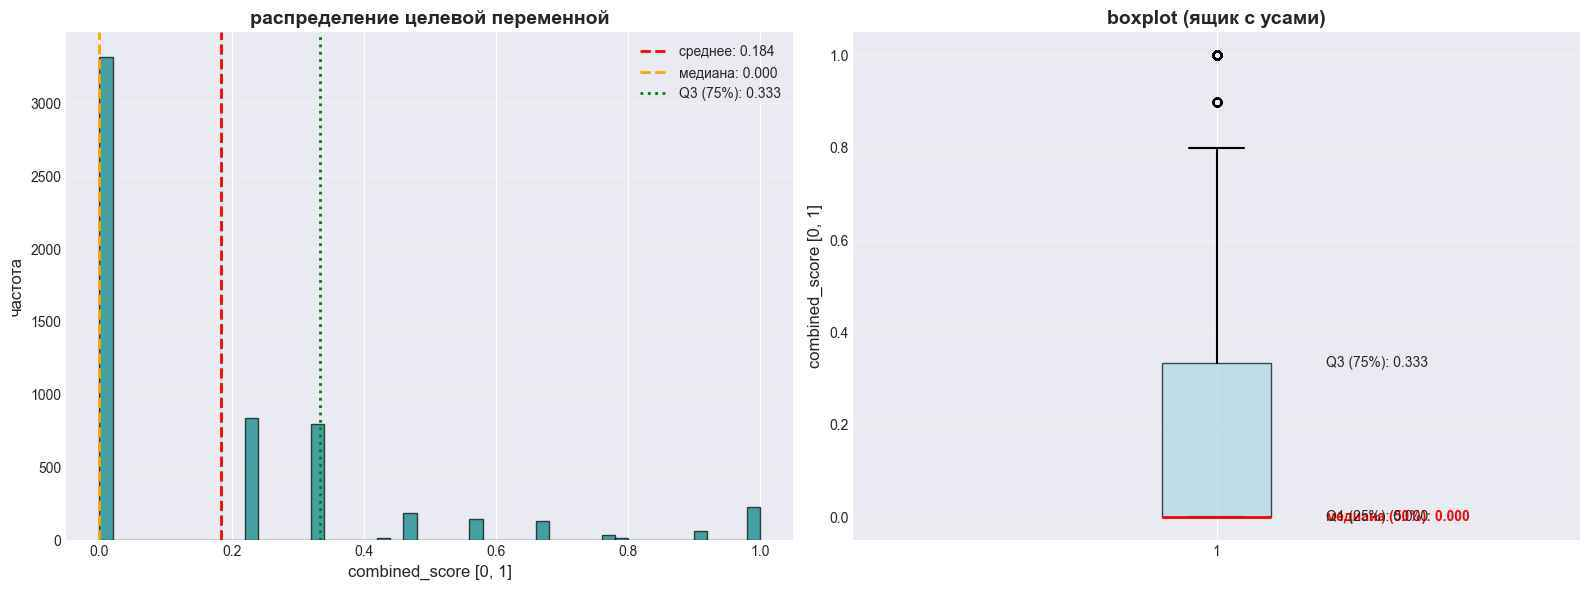

In [51]:
# создаём комбинированную целевую переменную (0.7 × эксперты + 0.3 × краудсорсинг)
# для пар, где есть обе оценки
master_df['combined_score'] = (
    0.7 * master_df['expert_score_normalized'] + 
    0.3 * master_df['agreement_ratio']
)

# для пар, где нет краудсорсинговой оценки, используем только экспертную
master_df['combined_score'].fillna(master_df['expert_score_normalized'], inplace=True)

print("\nстатистика комбинированной оценки:")
display(master_df['combined_score'].describe())

print(f"\nпар с комбинированной оценкой: {master_df['combined_score'].notna().sum()}")
print(f"пропусков: {master_df['combined_score'].isna().sum()}")

# проверим несколько примеров
print("\nпримеры комбинированных оценок:")
display(master_df[['image_file', 'caption_id', 'expert_score_normalized', 
                     'agreement_ratio', 'combined_score']].head(10))

# распределение по диапазонам
print("РАСПРЕДЕЛЕНИЕ ПО ДИАПАЗОНАМ")

ranges = [
    (0.0, 0.0, "точно 0 (полное несоответствие)"),
    (0.001, 0.25, "очень низкое (0.001-0.25)"),
    (0.25, 0.5, "низкое (0.25-0.5)"),
    (0.5, 0.75, "высокое (0.5-0.75)"),
    (0.75, 1.0, "очень высокое (0.75-1.0)"),
]

for min_val, max_val, label in ranges:
    if min_val == max_val:  # точно 0
        count = (master_df['combined_score'] == min_val).sum()
    else:
        count = ((master_df['combined_score'] > min_val) & 
                 (master_df['combined_score'] <= max_val)).sum()
    pct = (count / len(master_df)) * 100
    print(f"  {label:40s}: {count:4d} пар ({pct:5.2f}%)")

# визуализация с аннотациями квартилей
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# гистограмма
axes[0].hist(master_df['combined_score'], bins=50, edgecolor='black', alpha=0.7, color='teal')
axes[0].axvline(master_df['combined_score'].mean(), color='red', linestyle='--', 
                linewidth=2, label=f'среднее: {master_df["combined_score"].mean():.3f}')
axes[0].axvline(master_df['combined_score'].median(), color='orange', linestyle='--', 
                linewidth=2, label=f'медиана: {master_df["combined_score"].median():.3f}')
axes[0].axvline(master_df['combined_score'].quantile(0.75), color='green', linestyle=':', 
                linewidth=2, label=f'Q3 (75%): {master_df["combined_score"].quantile(0.75):.3f}')
axes[0].set_xlabel('combined_score [0, 1]', fontsize=12)
axes[0].set_ylabel('частота', fontsize=12)
axes[0].set_title('распределение целевой переменной', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(axis='y', alpha=0.3)

# boxplot (ящик с усами)
axes[1].boxplot(master_df['combined_score'], vert=True, patch_artist=True,
                boxprops=dict(facecolor='lightblue', alpha=0.7),
                medianprops=dict(color='red', linewidth=2),
                whiskerprops=dict(linewidth=1.5),
                capprops=dict(linewidth=1.5))
axes[1].set_ylabel('combined_score [0, 1]', fontsize=12)
axes[1].set_title('boxplot (ящик с усами)', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# аннотации на boxplot
axes[1].text(1.15, master_df['combined_score'].quantile(0.75), 
             f'Q3 (75%): {master_df["combined_score"].quantile(0.75):.3f}', 
             fontsize=10, va='center')
axes[1].text(1.15, master_df['combined_score'].median(), 
             f'медиана (50%): {master_df["combined_score"].median():.3f}', 
             fontsize=10, va='center', color='red', fontweight='bold')
axes[1].text(1.15, master_df['combined_score'].quantile(0.25), 
             f'Q1 (25%): {master_df["combined_score"].quantile(0.25):.3f}', 
             fontsize=10, va='center')

plt.tight_layout()
plt.show()

**результаты создания целевой переменной:**
- создана колонка `combined_score` для всех 5822 пар
- нет пропусков (для пар без краудсорсинга использована экспертная оценка)
- диапазон: [0, 1]

**статистика комбинированной оценки:**
- среднее: 0.184
- медиана: 0.0
- Q1 (25%): 0.0
- Q3 (75%): 0.333
- стандартное отклонение: 0.265

**распределение по диапазонам:**
- **точно 0 (полное несоответствие)**: 3322 пары (57.06%)
- **очень низкое (0.001-0.25)**: 848 пар (14.57%)
- **низкое (0.25-0.5)**: 1011 пар (17.37%)
- **высокое (0.5-0.75)**: 294 пары (5.05%)
- **очень высокое (0.75-1.0)**: 347 пар (5.96%)

**ключевые наблюдения:**
- **сильный дисбаланс сохранился**: 57% пар имеют оценку 0
- только 11% пар имеют высокие оценки (> 0.5)
- медиана = 0.0 означает, что большинство пар не соответствуют
- распределение сильно смещено влево

**визуальный анализ:**
- гистограмма показывает огромный пик на нуле
- boxplot демонстрирует сильную асимметрию распределения
- 75% данных имеют оценку ≤ 0.333
- много выбросов в верхнем диапазоне

**итоговая целевая переменная готова:**
- `combined_score` — это финальная метрика качества соответствия
- учитывает мнение и экспертов (70%), и краудворкеров (30%)
- для всех пар есть значение (нет пропусков)
- готова к использованию для обучения модели

### Сравнение всех трёх вариантов целевой переменной

сравню все три варианта целевой переменной и выберу оптимальную:
- визуально сравню распределения экспертных, краудсорсинговых и комбинированных оценок
- проанализирую баланс классов для комбинированной оценки
- разделю данные на три категории: не соответствует, частично соответствует, хорошо соответствует
- покажу примеры с изображениями из каждой категории
- создам сравнительную визуализацию

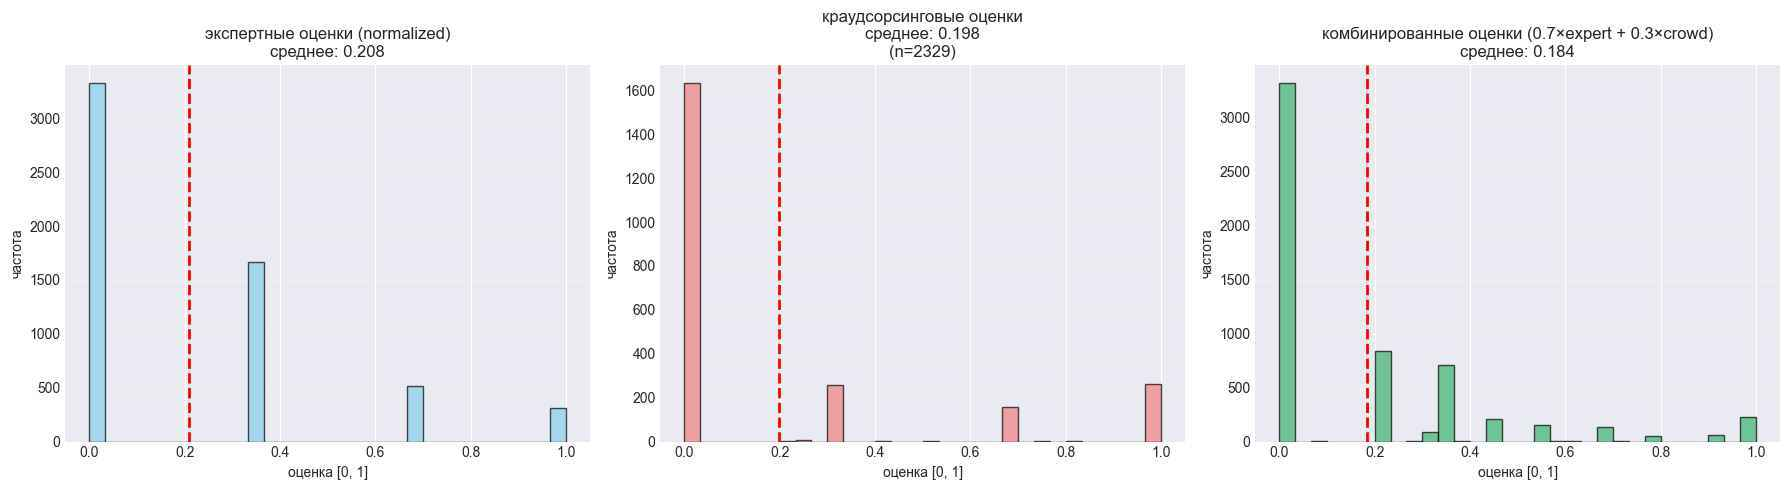


СРАВНЕНИЕ ТРЁХ ВАРИАНТОВ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ

1. ЭКСПЕРТНЫЕ ОЦЕНКИ:
   - доступно: 5822 пар (100%)
   - среднее: 0.208
   - медиана: 0.000

2. КРАУДСОРСИНГОВЫЕ ОЦЕНКИ:
   - доступно: 2329 пар (40%)
   - среднее: 0.198
   - медиана: 0.000

3. КОМБИНИРОВАННЫЕ ОЦЕНКИ:
   - доступно: 5822 пар (100%)
   - среднее: 0.184
   - медиана: 0.000
   - корреляция эксперты-краудворкеры: 0.762 (сильная)


In [52]:
# сравним все три варианта оценок визуально
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# экспертные оценки
axes[0].hist(master_df['expert_score_normalized'], bins=30, edgecolor='black', 
             alpha=0.7, color='skyblue')
axes[0].set_xlabel('оценка [0, 1]')
axes[0].set_ylabel('частота')
axes[0].set_title(f'экспертные оценки (normalized)\nсреднее: {master_df["expert_score_normalized"].mean():.3f}')
axes[0].axvline(master_df['expert_score_normalized'].mean(), color='red', 
                linestyle='--', linewidth=2)
axes[0].grid(axis='y', alpha=0.3)

# краудсорсинговые оценки (только те, что есть)
crowd_available = master_df[master_df['agreement_ratio'].notna()]
axes[1].hist(crowd_available['agreement_ratio'], bins=30, edgecolor='black', 
             alpha=0.7, color='lightcoral')
axes[1].set_xlabel('оценка [0, 1]')
axes[1].set_ylabel('частота')
axes[1].set_title(f'краудсорсинговые оценки\nсреднее: {crowd_available["agreement_ratio"].mean():.3f}\n(n={len(crowd_available)})')
axes[1].axvline(crowd_available['agreement_ratio'].mean(), color='red', 
                linestyle='--', linewidth=2)
axes[1].grid(axis='y', alpha=0.3)

# комбинированные оценки
axes[2].hist(master_df['combined_score'], bins=30, edgecolor='black', 
             alpha=0.7, color='mediumseagreen')
axes[2].set_xlabel('оценка [0, 1]')
axes[2].set_ylabel('частота')
axes[2].set_title(f'комбинированные оценки (0.7×expert + 0.3×crowd)\nсреднее: {master_df["combined_score"].mean():.3f}')
axes[2].axvline(master_df['combined_score'].mean(), color='red', 
                linestyle='--', linewidth=2)
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# выводы
print("\n" + "="*80)
print("СРАВНЕНИЕ ТРЁХ ВАРИАНТОВ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ")
print("="*80)

print(f"\n1. ЭКСПЕРТНЫЕ ОЦЕНКИ:")
print(f"   - доступно: {len(master_df)} пар (100%)")
print(f"   - среднее: {master_df['expert_score_normalized'].mean():.3f}")
print(f"   - медиана: {master_df['expert_score_normalized'].median():.3f}")

print(f"\n2. КРАУДСОРСИНГОВЫЕ ОЦЕНКИ:")
print(f"   - доступно: {len(crowd_available)} пар (40%)")
print(f"   - среднее: {crowd_available['agreement_ratio'].mean():.3f}")
print(f"   - медиана: {crowd_available['agreement_ratio'].median():.3f}")

print(f"\n3. КОМБИНИРОВАННЫЕ ОЦЕНКИ:")
print(f"   - доступно: {master_df['combined_score'].notna().sum()} пар (100%)")
print(f"   - среднее: {master_df['combined_score'].mean():.3f}")
print(f"   - медиана: {master_df['combined_score'].median():.3f}")
print(f"   - корреляция эксперты-краудворкеры: 0.762 (сильная)")

АНАЛИЗ БАЛАНСА: СООТВЕТСТВИЕ VS НЕСООТВЕТСТВИЕ

распределение:
  НЕ соответствует (< 0.2):      3327 (57.1%)
  частично соответствует (0.2-0.5): 1854 (31.8%)
  хорошо соответствует (>= 0.5):      641 (11.0%)


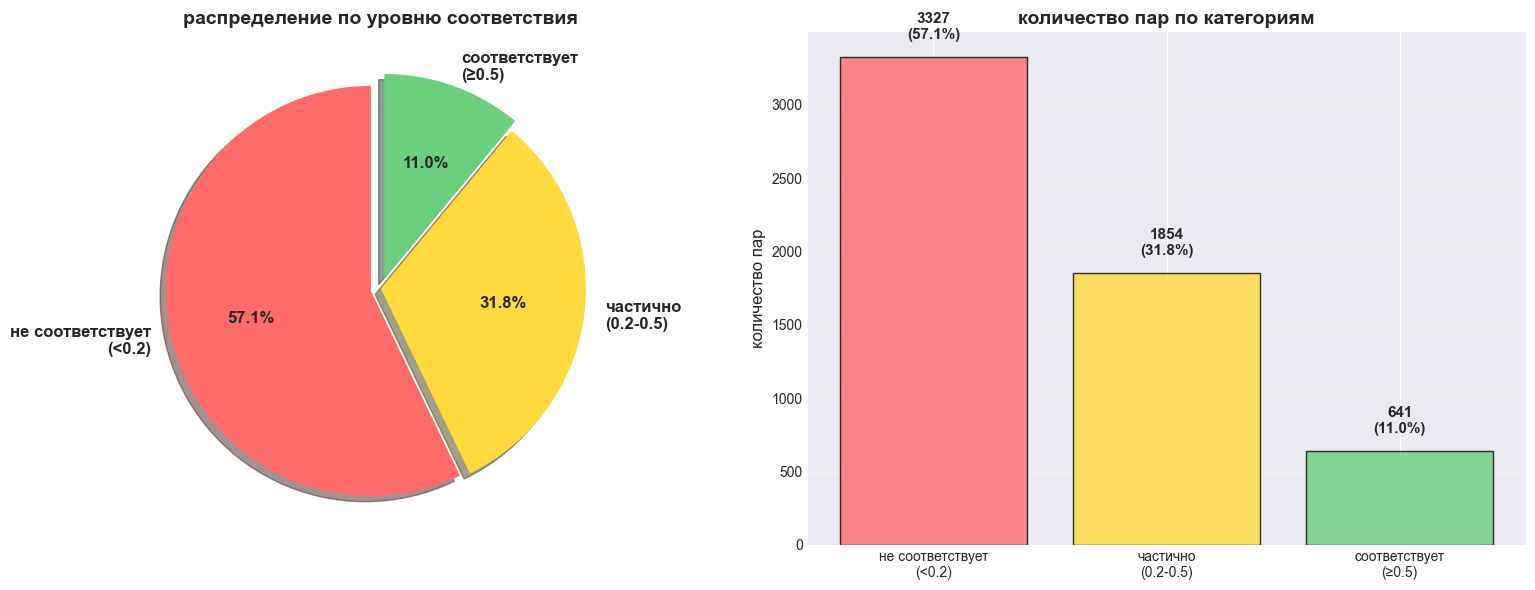



ПРИМЕРЫ ИЗ КАЖДОЙ КАТЕГОРИИ С ИЗОБРАЖЕНИЯМИ

НЕ СООТВЕТСТВУЕТ (<0.2)
всего пар в категории: 3327

примеры:


image_file  \
732   2078311270_f01c9eaf4c.jpg   
5091   398662202_97e5819b79.jpg   
5690   757046028_ff5999f91b.jpg   
1939  2646116932_232573f030.jpg   
2582  2934359101_cdf57442dc.jpg   

                                             query_text  expert_median  \
732   A football player is tackling the player with ...            1.0   
5091  A Miami basketball player dribbles by an Arizo...            1.0   
5690  A man in a white print shirt and a woman in a ...            1.0   
1939  A man wearing an orange cap sits on a white be...            1.0   
2582  A woman lies down on an old couch sitting on t...            1.0   

      combined_score  
732              0.0  
5091             0.0  
5690             0.0  
1939             0.0  
2582             0.0

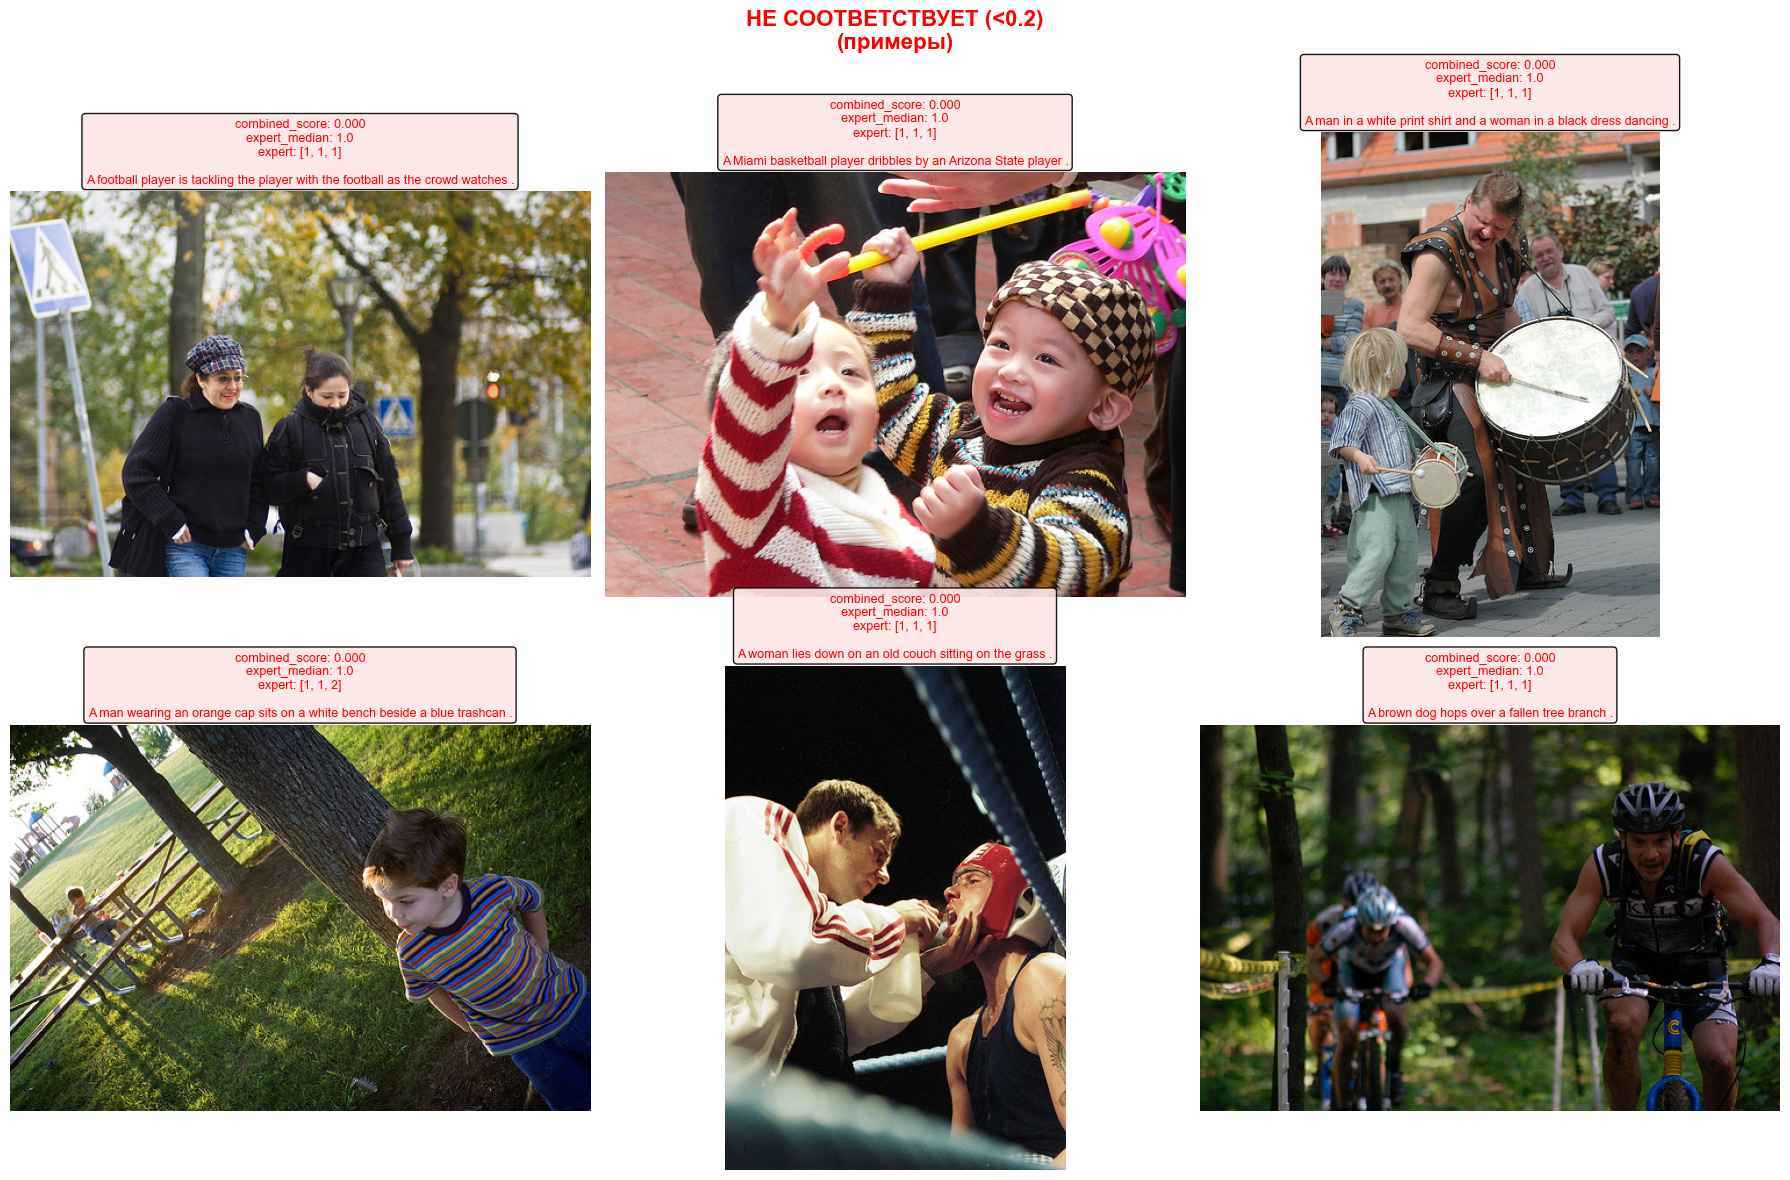


ЧАСТИЧНО СООТВЕТСТВУЕТ (0.2-0.5)
всего пар в категории: 1854

примеры:


image_file  \
758   2089426086_7acc98a3a8.jpg   
1356  2419221084_01a14176b4.jpg   
3782  3328646934_5cca4cebce.jpg   
5283   468310111_d9396abcbd.jpg   
1257  2370481277_a3085614c9.jpg   

                                             query_text  expert_median  \
758   Kids are waiting at the bottom of a staircase ...            2.0   
1356  A brown dog with a tennis ball its mouth rolli...            2.0   
3782               Person snowboarding at a ski slope .            2.0   
5283                Three dogs are playing in a field .            2.0   
1257     A soccer player jumping in air during a game .            2.0   

      combined_score  
758         0.333333  
1356        0.233333  
3782        0.233333  
5283        0.233333  
1257        0.333333

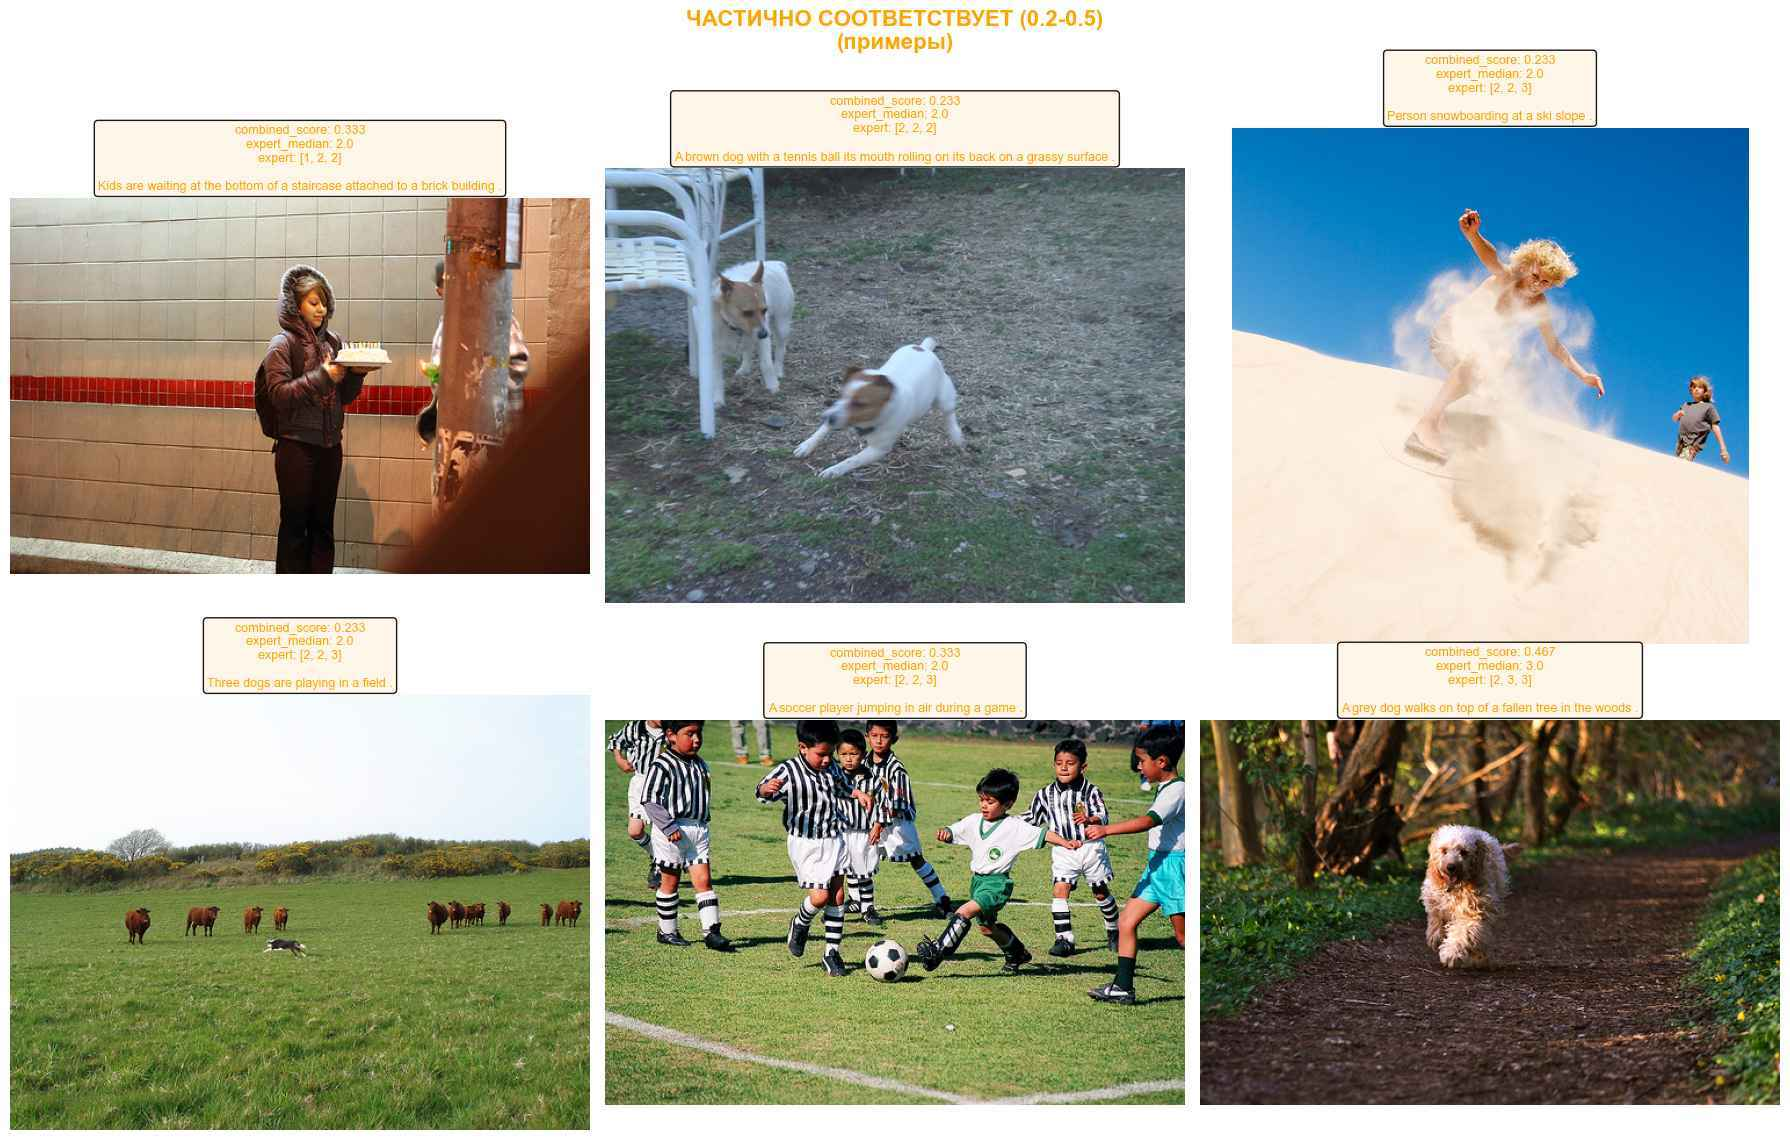


ХОРОШО СООТВЕТСТВУЕТ (≥0.5)
всего пар в категории: 641

примеры:


image_file  \
952   2206960564_325ed0c7ae.jpg   
2871  3058439373_9276a4702a.jpg   
3895  3364026240_645d533fda.jpg   
2910  3072114570_e1c0127529.jpg   
834   2148916767_644ea6a7fa.jpg   

                                             query_text  expert_median  \
952                      A dog jumps over an obstacle .            3.0   
2871  A group of people walking a city street in war...            3.0   
3895            A skier about to go down the mountain .            4.0   
2910             Some kids play outside on a nice day .            4.0   
834                  A dog runs through the deep snow .            3.0   

      combined_score  
952         0.566667  
2871        0.666667  
3895        1.000000  
2910        1.000000  
834         0.566667

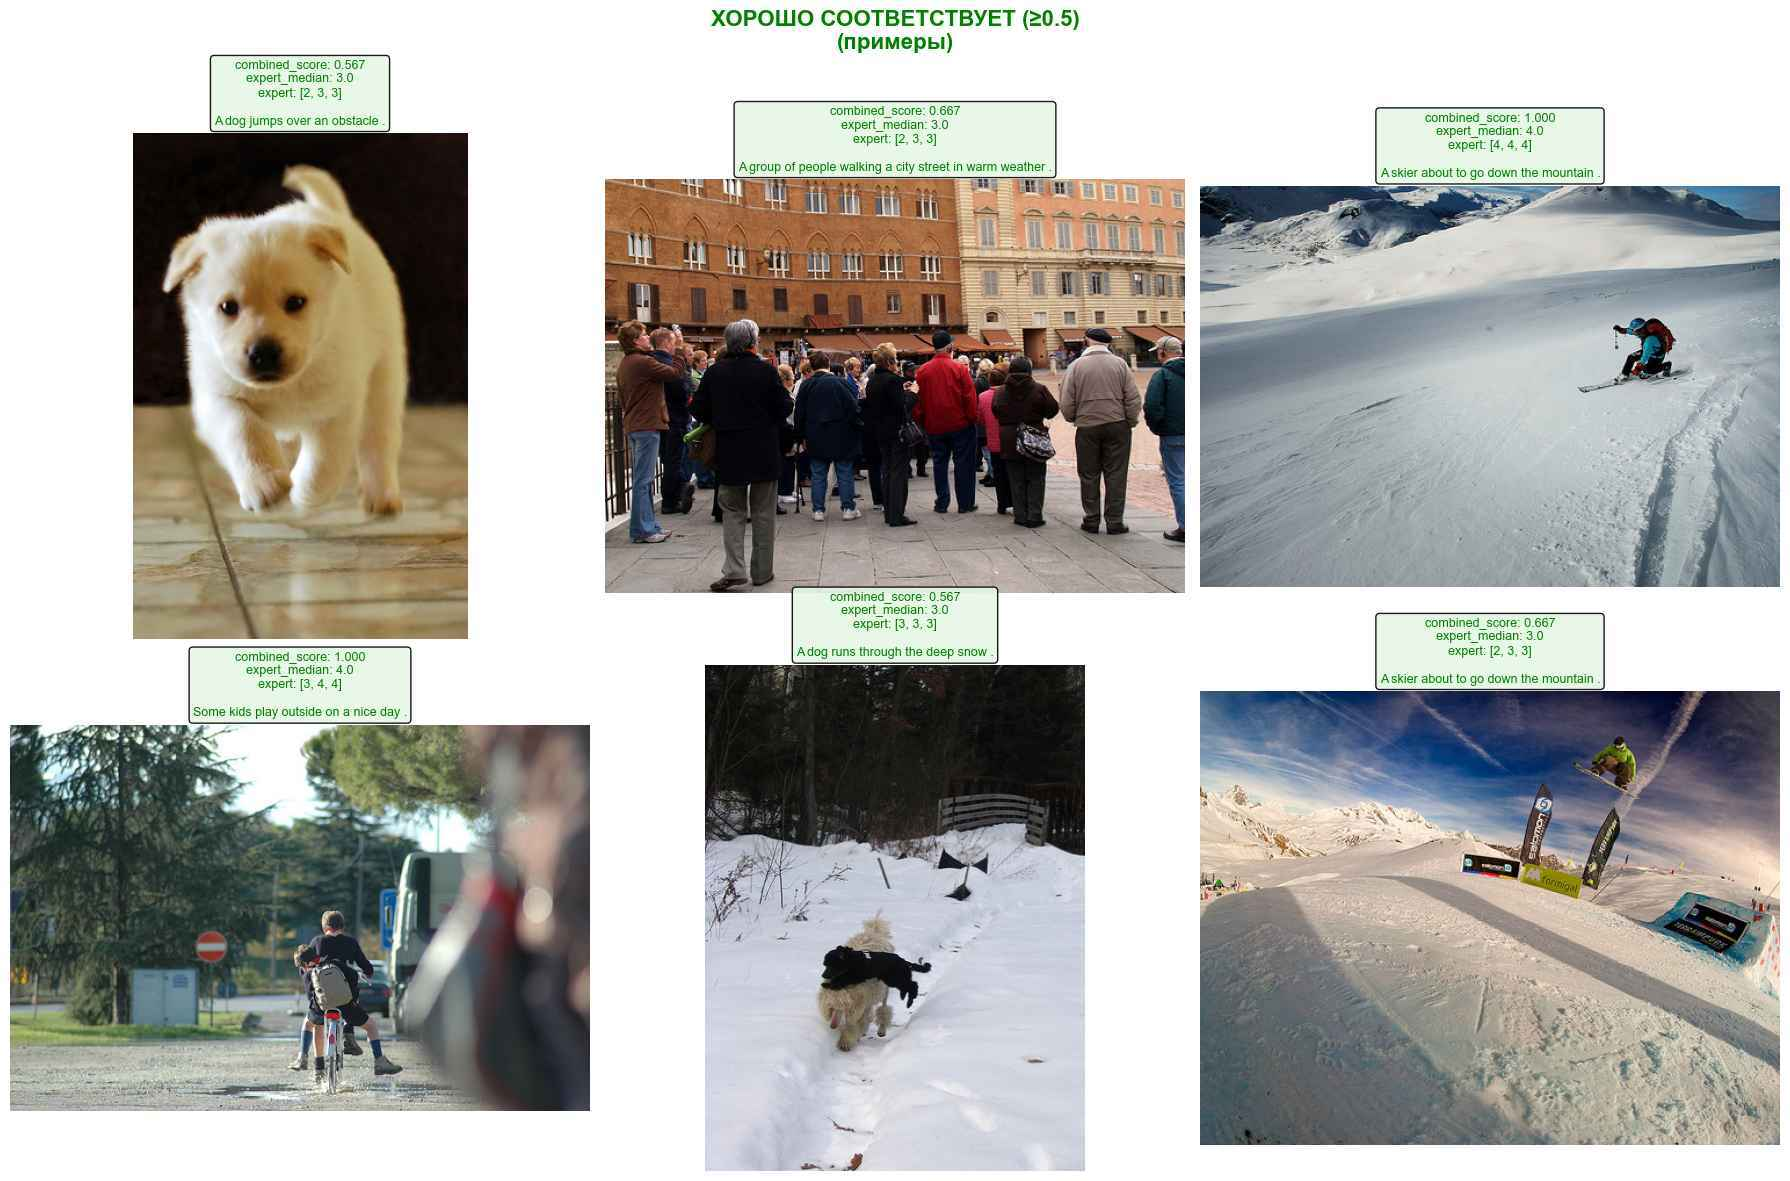


СРАВНИТЕЛЬНАЯ ВИЗУАЛИЗАЦИЯ: ПО ОДНОМУ ПРИМЕРУ ИЗ КАЖДОЙ КАТЕГОРИИ


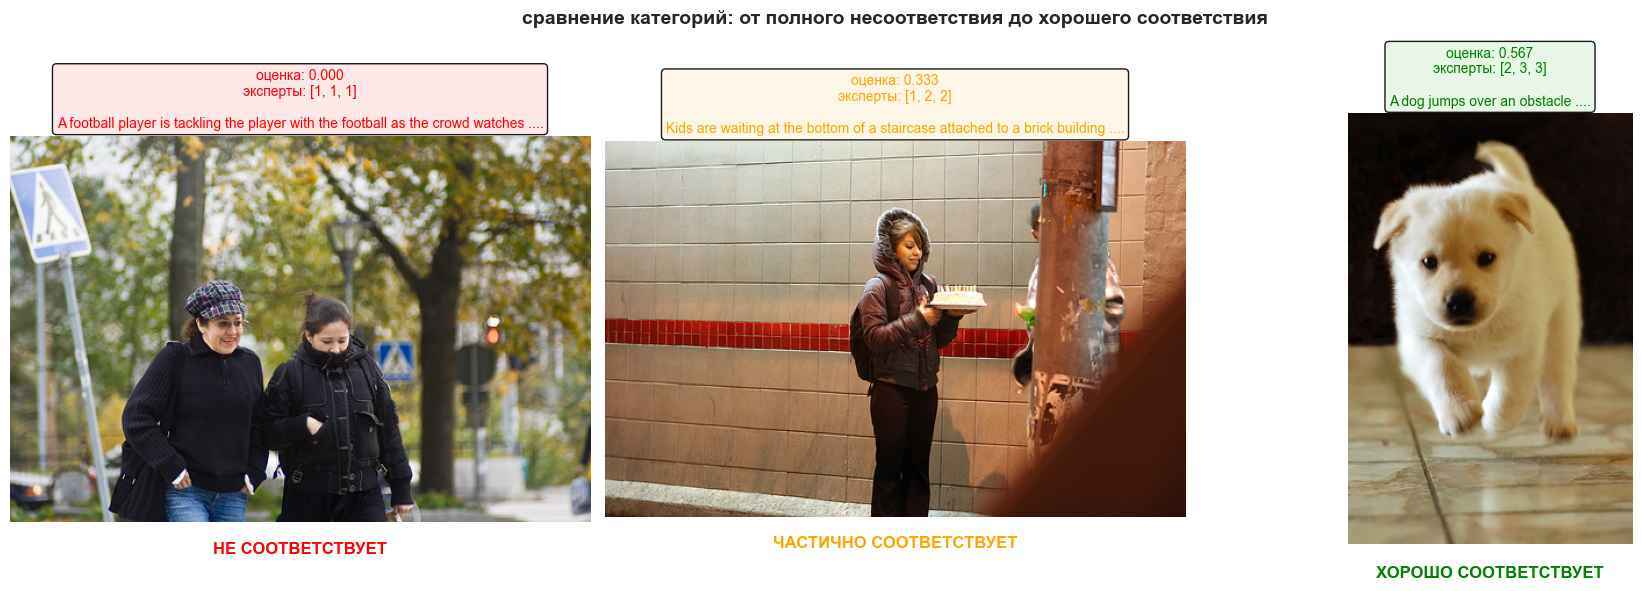

In [53]:
print("="*80)
print("АНАЛИЗ БАЛАНСА: СООТВЕТСТВИЕ VS НЕСООТВЕТСТВИЕ")
print("="*80)

# определим пороги
# оценка < 0.2 → не соответствует (эксперты ставили в основном 1)
# оценка >= 0.5 → соответствует (эксперты ставили 3-4)
# 0.2 - 0.5 → частичное соответствие

no_match = (master_df['combined_score'] < 0.2).sum()
partial_match = ((master_df['combined_score'] >= 0.2) & (master_df['combined_score'] < 0.5)).sum()
good_match = (master_df['combined_score'] >= 0.5).sum()

print(f"\nраспределение:")
print(f"  НЕ соответствует (< 0.2):      {no_match:4d} ({no_match/len(master_df)*100:.1f}%)")
print(f"  частично соответствует (0.2-0.5): {partial_match:4d} ({partial_match/len(master_df)*100:.1f}%)")
print(f"  хорошо соответствует (>= 0.5):     {good_match:4d} ({good_match/len(master_df)*100:.1f}%)")

# визуализация
labels = ['не соответствует\n(<0.2)', 'частично\n(0.2-0.5)', 'соответствует\n(≥0.5)']
sizes = [no_match, partial_match, good_match]
colors = ['#ff6b6b', '#ffd93d', '#6bcf7f']
explode = (0.05, 0, 0.05)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# круговая диаграмма
axes[0].pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
            shadow=True, startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})
axes[0].set_title('распределение по уровню соответствия', fontsize=14, fontweight='bold')

# столбчатая диаграмма
axes[1].bar(labels, sizes, color=colors, edgecolor='black', alpha=0.8)
axes[1].set_ylabel('количество пар', fontsize=12)
axes[1].set_title('количество пар по категориям', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# добавим значения на столбцы
for i, (label, size) in enumerate(zip(labels, sizes)):
    pct = size / len(master_df) * 100
    axes[1].text(i, size + 100, f'{size}\n({pct:.1f}%)', 
                ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*80)

# покажем примеры из каждой категории
print("\n" + "="*80)
print("ПРИМЕРЫ ИЗ КАЖДОЙ КАТЕГОРИИ С ИЗОБРАЖЕНИЯМИ")
print("="*80)

# категории для анализа
categories = [
    (master_df[master_df['combined_score'] < 0.2], "НЕ СООТВЕТСТВУЕТ (<0.2)", 'red', '#ffe6e6'),
    (master_df[(master_df['combined_score'] >= 0.2) & (master_df['combined_score'] < 0.5)], 
     "ЧАСТИЧНО СООТВЕТСТВУЕТ (0.2-0.5)", 'orange', '#fff4e6'),
    (master_df[master_df['combined_score'] >= 0.5], "ХОРОШО СООТВЕТСТВУЕТ (≥0.5)", 'green', '#e6f7e6'),
]

for df_cat, title, color, bg_color in categories:
    if len(df_cat) > 0:
        print(f"\n{'='*80}")
        print(f"{title}")
        print(f"{'='*80}")
        print(f"всего пар в категории: {len(df_cat)}")
        
        # берём 6 случайных примеров
        n_samples = min(6, len(df_cat))
        sample = df_cat.sample(n_samples, random_state=42)
        
        # выводим таблицу
        print("\nпримеры:")
        display(sample[['image_file', 'query_text', 'expert_median', 
                        'combined_score']].head())
        
        # визуализация с изображениями
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.flatten()
        
        for idx, (_, row) in enumerate(sample.iterrows()):
            if idx >= 6:
                break
                
            image_path = os.path.join(train_images_dir, row['image_file'])
            
            if os.path.exists(image_path):
                img = Image.open(image_path)
                axes[idx].imshow(img)
                axes[idx].axis('off')
                
                # информация о паре
                text_info = (
                    f"combined_score: {row['combined_score']:.3f}\n"
                    f"expert_median: {row['expert_median']}\n"
                    f"expert: [{row['expert1']}, {row['expert2']}, {row['expert3']}]\n\n"
                    f"{row['query_text']}"
                )
                axes[idx].set_title(text_info, fontsize=9, color=color,
                                   bbox=dict(boxstyle='round', facecolor=bg_color, alpha=0.9))
            else:
                axes[idx].text(0.5, 0.5, f'изображение не найдено:\n{row["image_file"]}', 
                              ha='center', va='center')
                axes[idx].axis('off')
        
        # скрываем пустые subplot'ы если примеров меньше 6
        for idx in range(n_samples, 6):
            axes[idx].axis('off')
        
        plt.suptitle(f'{title}\n(примеры)', fontsize=16, fontweight='bold', color=color)
        plt.tight_layout()
        plt.show()

# дополнительно: сравнительная визуализация - по одному примеру из каждой категории
print("\n" + "="*80)
print("СРАВНИТЕЛЬНАЯ ВИЗУАЛИЗАЦИЯ: ПО ОДНОМУ ПРИМЕРУ ИЗ КАЖДОЙ КАТЕГОРИИ")
print("="*80)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, (df_cat, title, color, bg_color) in enumerate(categories):
    if len(df_cat) > 0:
        # берём один случайный пример
        sample = df_cat.sample(1, random_state=42).iloc[0]
        
        image_path = os.path.join(train_images_dir, sample['image_file'])
        
        if os.path.exists(image_path):
            img = Image.open(image_path)
            axes[idx].imshow(img)
            axes[idx].axis('off')
            
            # компактная информация
            text_info = (
                f"оценка: {sample['combined_score']:.3f}\n"
                f"эксперты: [{sample['expert1']}, {sample['expert2']}, {sample['expert3']}]\n\n"
                f"{sample['query_text'][:100]}..."
            )
            axes[idx].set_title(text_info, fontsize=10, color=color,
                               bbox=dict(boxstyle='round', facecolor=bg_color, alpha=0.9))
        else:
            axes[idx].text(0.5, 0.5, 'изображение не найдено', 
                          ha='center', va='center')
            axes[idx].axis('off')
        
        # подпись категории снизу
        axes[idx].text(0.5, -0.05, title.split('(')[0].strip(), 
                      transform=axes[idx].transAxes,
                      fontsize=12, fontweight='bold', color=color,
                      ha='center', va='top')

plt.suptitle('сравнение категорий: от полного несоответствия до хорошего соответствия', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

**сравнение трёх вариантов целевой переменной:**

**1. экспертные оценки (normalized):**
- доступно: 5822 пары (100%)
- среднее: 0.208
- медиана: 0.0
- распределение более сбалансировано (меньше концентрации на нуле)

**2. краудсорсинговые оценки:**
- доступно: 2329 пар (40%)
- среднее: 0.198
- медиана: 0.0
- очень сильная концентрация на нуле
- более строгие оценки

**3. комбинированные оценки (0.7×expert + 0.3×crowd):**
- доступно: 5822 пары (100%)
- среднее: 0.184
- медиана: 0.0
- корреляция эксперты-краудворкеры: 0.762 (сильная)
- **выбран как финальная целевая переменная**

**анализ баланса комбинированной оценки:**

**ключевые наблюдения:**
- сохраняется дисбаланс классов (57% несоответствующих пар)
- соотношение положительных к отрицательным: 641:3327 ≈ 1:5
- более 88% данных имеют оценку < 0.5

**почему выбрана комбинированная оценка:**
- **полное покрытие**: есть значения для всех 5822 пар
- **надёжность**: учитывает мнение обоих источников с весами 70/30
- **приоритет экспертам**: больший вес (70%) более надёжным оценщикам
- **валидация краудсорсингом**: 30% веса краудворкеров для дополнительной проверки
- **высокая корреляция**: 0.762 подтверждает согласованность оценок
- **единообразие**: одна метрика для всех данных упрощает обучение

**готовность к обучению:**
- целевая переменная `combined_score` готова
- диапазон [0, 1] удобен для регрессионных моделей
- дисбаланс известен и будет учтён при обучении
- примеры подтверждают смысловую корректность оценок

# Итоги этапа 1

- объединил экспертные и краудсорсинговые оценки
- создал комбинированную целевую переменную `(0.7×expert + 0.3×crowd)`
- проанализировал корреляцию `(0.762 — сильная связь)`
- сравнил три варианта целевой переменной

**ключевые наблюдения:**

**покрытие данных:**
- экспертные: `100%` `(5822 пары)`
- краудсорсинговые: `40%` `(2329 пар)`
- комбинированные: `100%` (использую экспертные где нет краудсорсинговых)

**распределения:**
- все три варианта имеют сильный перекос к нулю `(медиана = 0)`
- среднее: эксперты `(0.208)` > краудворкеры `(0.198)` > комбинированные `(0.184)`
- проблема дисбаланса классов присутствует во всех вариантах

**согласованность:**
- корреляция `0.762` говорит о хорошем согласии между экспертами и краудворкерами
- комбинированные оценки — разумный компромисс

**рекомендация по выбору целевой переменной:**
буду использовать `combined_score` как основную целевую переменную, потому что:
- доступна для всех `5822` пар `(100% покрытие)`
- учитывает обе разметки с разумными весами
- эксперты и краудворкеры хорошо согласованы `(корреляция 0.762)`
- более робастная — снижает влияние ошибок одной группы оценщиков

**краткие итоги этапа 1 (eda):**
- `5822` пары `(изображение + описание)` с оценками
- целевая переменная: `combined_score` `[0, 1]`
- дисбаланс классов: `71.6%` пар имеют очень низкое соответствие `(0-0.25)`
- нет пропусков в ключевых колонках
- корреляция эксперты-краудворкеры: `0.762` `(сильная)`

# Этап 2: Проверка и фильтрация данных

## Создание списка запрещенных слов

создам список английских слов, которые явно указывают на детей или детскую тематику:
- перечислю прямые упоминания возраста, места, активности, предметы, статусы
- это важно для фильтрации нежелательного контента в описаниях
- выведу список для проверки

In [54]:
# создаём список запрещённых слов, связанных с детьми
forbidden_words = [
    # прямые упоминания возраста
    'child', 'children', 'kid', 'kids', 'baby', 'babies', 'infant', 'toddler', 
    'newborn', 'boy', 'girl', 'son', 'daughter',
    'teen', 'teenager', 'adolescent', 'youth', 'juvenile', 'minor',
    'preteen', 'tween',
    
    # места и активности
    'school', 'classroom', 'kindergarten', 'preschool', 'daycare',
    'playground', 'sandbox',
    
    # предметы
    'stroller', 'crib', 'playpen',
    
    # статусы
    'student', 'pupil', 'schoolboy', 'schoolgirl',
]

print(f"\nсоздан список из {len(forbidden_words)} запрещённых слов:")
print(forbidden_words)


создан список из 35 запрещённых слов:
['child', 'children', 'kid', 'kids', 'baby', 'babies', 'infant', 'toddler', 'newborn', 'boy', 'girl', 'son', 'daughter', 'teen', 'teenager', 'adolescent', 'youth', 'juvenile', 'minor', 'preteen', 'tween', 'school', 'classroom', 'kindergarten', 'preschool', 'daycare', 'playground', 'sandbox', 'stroller', 'crib', 'playpen', 'student', 'pupil', 'schoolboy', 'schoolgirl']


## Поиск запрещённых слов в описаниях

найду все пары, где текстовое описание содержит запрещённые слова:
- напишу функцию `contains_forbidden_words` для проверки текста на наличие запрещённых слов с учётом границ слов
- применю функцию к колонке `query_text` и создам новую колонку `has_forbidden_content`
- вычислю статистику по количеству пар с и без запрещённого контента
- это поможет оценить объём данных для фильтрации

In [55]:
# функция для проверки наличия запрещённых слов в тексте
def contains_forbidden_words(text, forbidden_list):
    """
    проверяет, содержит ли текст запрещённые слова
    
    параметры:
    - text: текст для проверки
    - forbidden_list: список запрещённых слов
    
    возвращает: True если найдено запрещённое слово, False иначе
    """
    # приводим текст к нижнему регистру
    text_lower = text.lower()
    
    # ищем каждое запрещённое слово как отдельное слово (word boundary)
    for word in forbidden_list:
        # \b - граница слова (чтобы не найти "children" в "chicken")
        pattern = r'\b' + word + r'\b'
        if re.search(pattern, text_lower):
            return True
    return False

# применяем функцию ко всем описаниям
master_df['has_forbidden_content'] = master_df['query_text'].apply(
    lambda x: contains_forbidden_words(x, forbidden_words)
)

# статистика
forbidden_count = master_df['has_forbidden_content'].sum()
forbidden_pct = (forbidden_count / len(master_df)) * 100


print(f"\nвсего пар: {len(master_df)}")
print(f"пар с запрещённым контентом: {forbidden_count} ({forbidden_pct:.2f}%)")
print(f"пар без запрещённого контента: {len(master_df) - forbidden_count} ({100-forbidden_pct:.2f}%)")


всего пар: 5822
пар с запрещённым контентом: 1349 (23.17%)
пар без запрещённого контента: 4473 (76.83%)


**результаты**

- добавлена колонка `has_forbidden_content` в `master_df` для дальнейшей фильтрации

## Примеры найденных запрещённых описаний

изучу примеры найденных запрещённых описаний:
- выведу таблицу с примерами пар с запрещённым контентом и высоким score
- визуализирую топ-6 изображений, соответствующих таким описаниям
- проанализирую статистику по частоте запрещённых слов
- визуализирую топ-10 слов с примерами изображений и график частоты
- это поможет понять, какой контент удалять


ПРИМЕРЫ ОПИСАНИЙ С ЗАПРЕЩЁННЫМ КОНТЕНТОМ

найдено 1349 пар с запрещённым контентом
из них пар, где изображение СООТВЕТСТВУЕТ описанию (score >= 0.5): 86

примеры (таблица):


image_file  \
53   1131932671_c8d17751b3.jpg   
54   1131932671_c8d17751b3.jpg   
77   1174525839_7c1e6cfa86.jpg   
78   1174525839_7c1e6cfa86.jpg   
170  1298295313_db1f4c6522.jpg   
172  1298295313_db1f4c6522.jpg   
187  1322323208_c7ecb742c6.jpg   
258   136644343_0e2b423829.jpg   
310  1402640441_81978e32a9.jpg   
610   189721896_1ffe76d89e.jpg   

                                            query_text found_words  \
53               A boy jumps from one bed to another .         boy   
54                 A child jumping on a tennis court .       child   
77                  a little girl kicks into the air .        girl   
78   A little girl runs on the wet sand near the oc...        girl   
170             a boy jumps into the blue pool water .         boy   
172            A boy is about to jump into the water .         boy   
187  Two children , one of which is holding a stick...    children   
258  A boy smiling , leaning over a wagon filled wi...         boy   
310                          A boy plays in the sand .         boy   
610                       A boy climbs up some rocks .         boy   

     combined_score  expert_median  
53         1.000000            4.0  
54         0.766667            3.0  
77         0.666667            3.0  
78         0.766667            3.0  
170        0.666667            3.0  
172        0.666667            3.0  
187        1.000000            4.0  
258        0.566667            3.0  
310        1.000000            4.0  
610        0.766667            3.0


ВИЗУАЛИЗАЦИЯ: ИЗОБРАЖЕНИЯ, КОТОРЫЕ СООТВЕТСТВУЮТ ЗАПРЕЩЁННЫМ ОПИСАНИЯМ


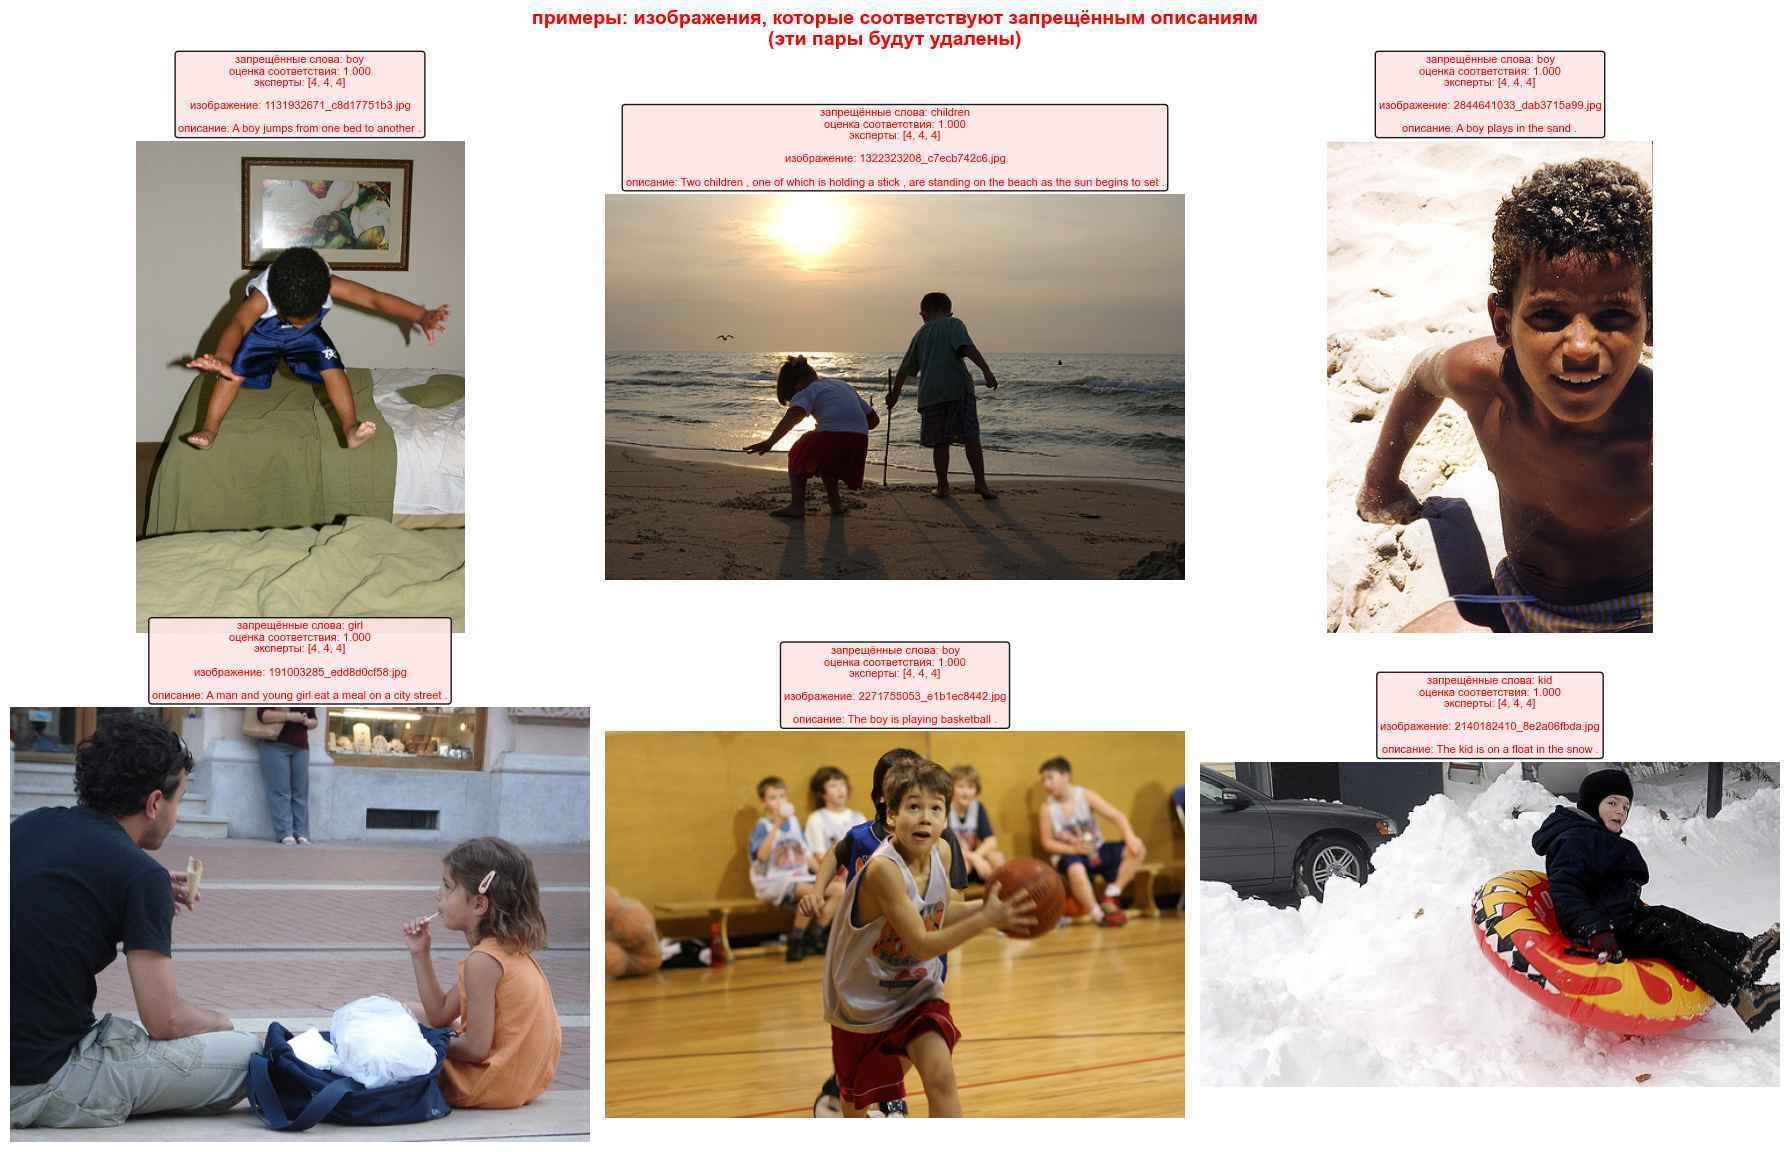


СТАТИСТИКА ПО ЗАПРЕЩЁННЫМ СЛОВАМ

топ-15 наиболее частых запрещённых слов:
  boy                 :  491 раз (36.40%)
  girl                :  411 раз (30.47%)
  child               :  243 раз (18.01%)
  children            :  106 раз ( 7.86%)
  baby                :   61 раз ( 4.52%)
  playground          :   54 раз ( 4.00%)
  kids                :   48 раз ( 3.56%)
  toddler             :   44 раз ( 3.26%)
  kid                 :   39 раз ( 2.89%)
  stroller            :   17 раз ( 1.26%)
  babies              :    6 раз ( 0.44%)
  school              :    5 раз ( 0.37%)
  youth               :    4 раз ( 0.30%)

ТОП-10 ЗАПРЕЩЁННЫХ СЛОВ: ИЗОБРАЖЕНИЯ, СООТВЕТСТВУЮЩИЕ ОПИСАНИЯМ


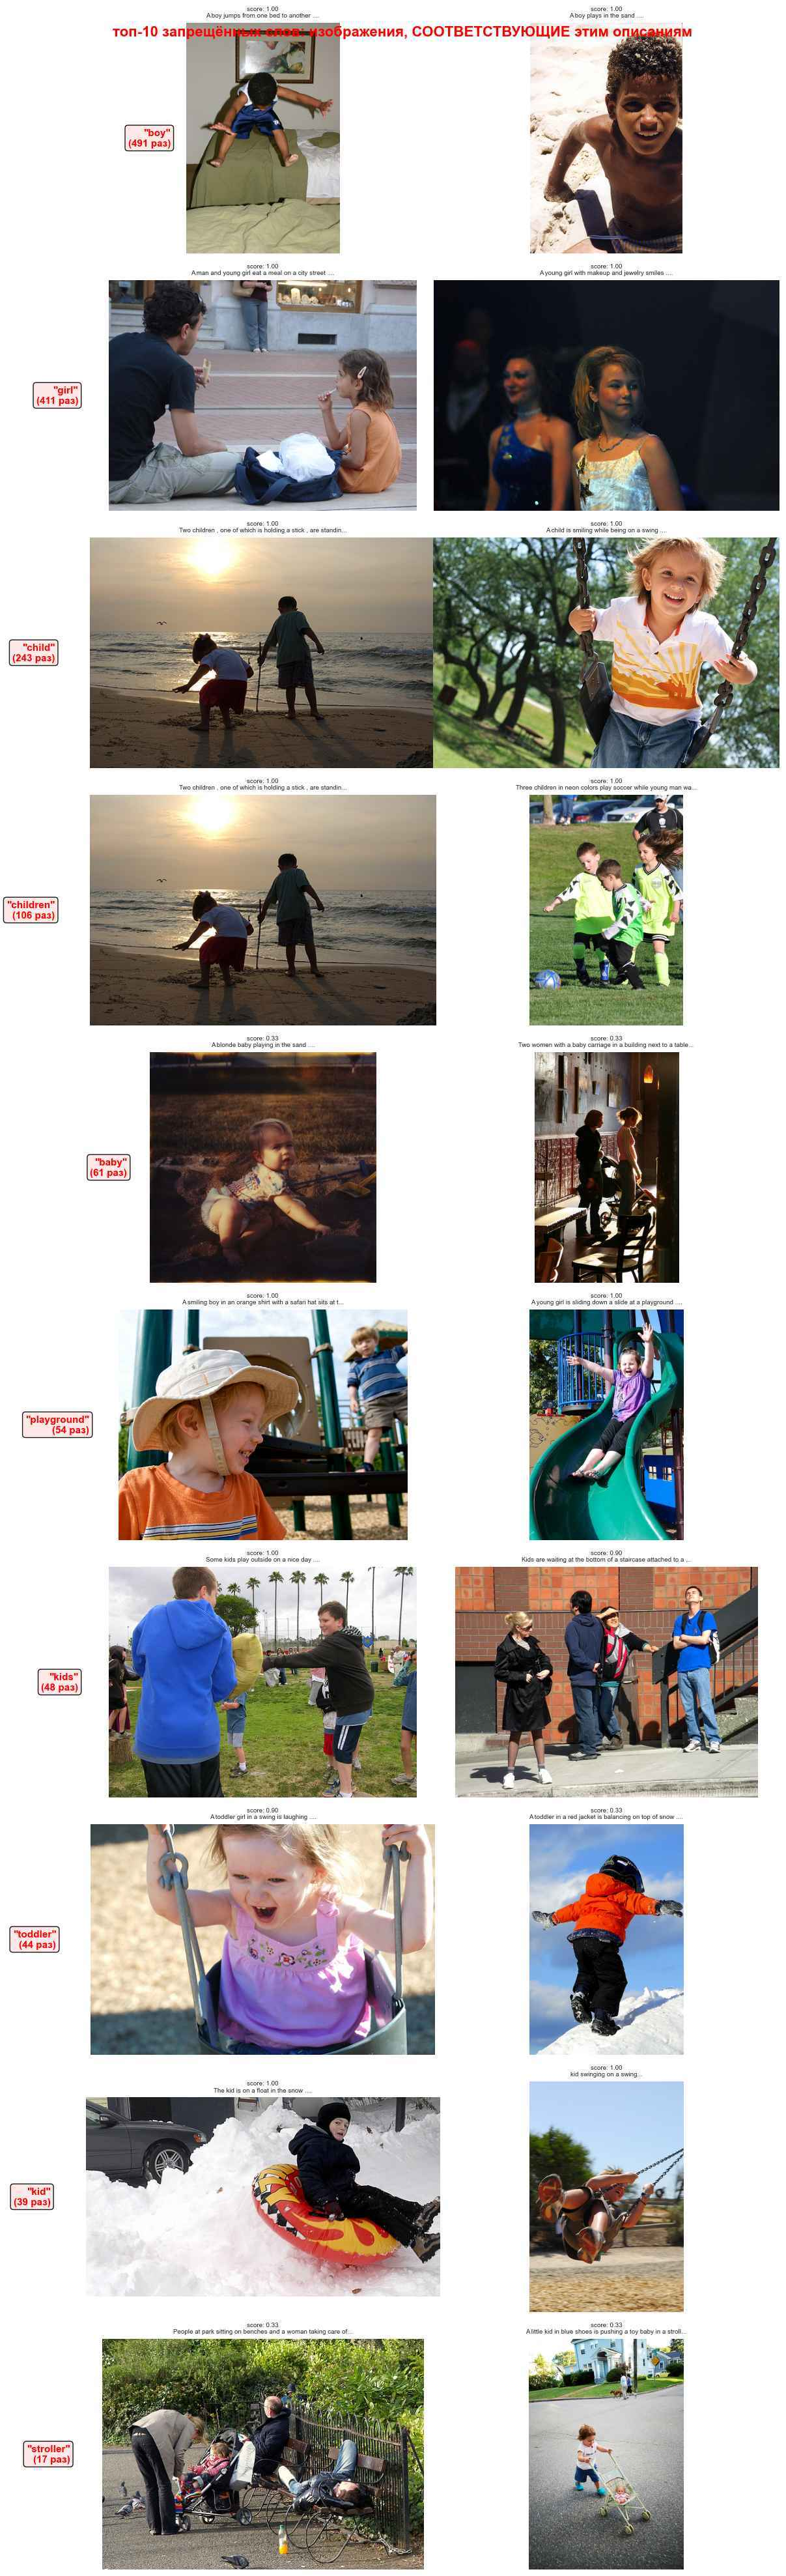

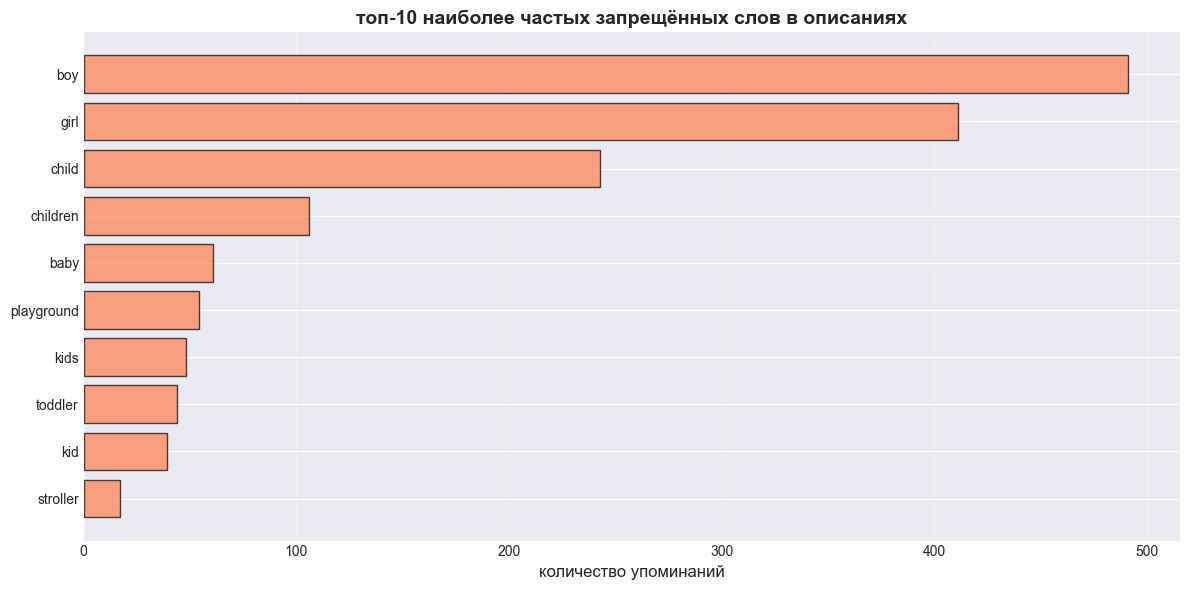

In [56]:
print("\n" + "="*80)
print("ПРИМЕРЫ ОПИСАНИЙ С ЗАПРЕЩЁННЫМ КОНТЕНТОМ")
print("="*80)

# посмотрим на примеры найденного запрещённого контента
forbidden_examples = master_df[master_df['has_forbidden_content'] == True].copy()

# найдём, какие именно запрещённые слова встречаются
def find_forbidden_words_in_text(text, forbidden_list):
    """находит все запрещённые слова в тексте"""
    text_lower = text.lower()
    found_words = []
    for word in forbidden_list:
        pattern = r'\b' + word + r'\b'
        if re.search(pattern, text_lower):
            found_words.append(word)
    return ', '.join(found_words)

forbidden_examples['found_words'] = forbidden_examples['query_text'].apply(
    lambda x: find_forbidden_words_in_text(x, forbidden_words)
)

print(f"\nнайдено {len(forbidden_examples)} пар с запрещённым контентом")

# ВАЖНО: берём только те пары, где изображение СООТВЕТСТВУЕТ описанию
# то есть где combined_score достаточно высокий
matching_forbidden = forbidden_examples[forbidden_examples['combined_score'] >= 0.5].copy()

print(f"из них пар, где изображение СООТВЕТСТВУЕТ описанию (score >= 0.5): {len(matching_forbidden)}")

if len(matching_forbidden) == 0:
    print("\nнет пар с высоким соответствием! попробуем с порогом >= 0.3")
    matching_forbidden = forbidden_examples[forbidden_examples['combined_score'] >= 0.3].copy()
    print(f"пар с score >= 0.3: {len(matching_forbidden)}")

if len(matching_forbidden) == 0:
    print("\nвсё ещё нет! берём все пары, сортируем по убыванию оценки")
    matching_forbidden = forbidden_examples.sort_values('combined_score', ascending=False)

print("\nпримеры (таблица):")
display(matching_forbidden[['image_file', 'query_text', 'found_words', 
                             'combined_score', 'expert_median']].head(10))

# визуализация с изображениями
print("\n" + "="*80)
print("ВИЗУАЛИЗАЦИЯ: ИЗОБРАЖЕНИЯ, КОТОРЫЕ СООТВЕТСТВУЮТ ЗАПРЕЩЁННЫМ ОПИСАНИЯМ")
print("="*80)

# возьмём топ-6 пар с наивысшим соответствием
sample_forbidden = matching_forbidden.nlargest(6, 'combined_score')

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, (_, row) in enumerate(sample_forbidden.iterrows()):
    
    # caption_id содержит имя изображения, которому принадлежит описание
    caption_image = row['image_from_caption_id']
    image_path = os.path.join(train_images_dir, caption_image)
    
    if os.path.exists(image_path):
        img = Image.open(image_path)
        axes[idx].imshow(img)
        axes[idx].axis('off')
        
        text_info = (
            f"запрещённые слова: {row['found_words']}\n"
            f"оценка соответствия: {row['combined_score']:.3f}\n"
            f"эксперты: [{row['expert1']}, {row['expert2']}, {row['expert3']}]\n\n"
            f"изображение: {caption_image}\n\n"
            f"описание: {row['query_text']}"
        )
        axes[idx].set_title(text_info, fontsize=8, color='red',
                           bbox=dict(boxstyle='round', facecolor='#ffe6e6', alpha=0.9))
    else:
        axes[idx].text(0.5, 0.5, f'изображение не найдено:\n{caption_image}', 
                      ha='center', va='center')
        axes[idx].axis('off')

plt.suptitle('примеры: изображения, которые соответствуют запрещённым описаниям\n(эти пары будут удалены)', 
             fontsize=14, fontweight='bold', color='red')
plt.tight_layout()
plt.show()

# статистика по найденным словам
print("\n" + "="*80)
print("СТАТИСТИКА ПО ЗАПРЕЩЁННЫМ СЛОВАМ")
print("="*80)

# подсчитаем частоту каждого запрещённого слова
word_counts = {}
for words_str in forbidden_examples['found_words']:
    for word in words_str.split(', '):
        if word:
            word_counts[word] = word_counts.get(word, 0) + 1

# сортируем по частоте
sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

print("\nтоп-15 наиболее частых запрещённых слов:")
for word, count in sorted_words[:15]:
    pct = (count / len(forbidden_examples)) * 100
    print(f"  {word:20s}: {count:4d} раз ({pct:5.2f}%)")

# визуализация топ-10 с СООТВЕТСТВУЮЩИМИ изображениями
print("\n" + "="*80)
print("ТОП-10 ЗАПРЕЩЁННЫХ СЛОВ: ИЗОБРАЖЕНИЯ, СООТВЕТСТВУЮЩИЕ ОПИСАНИЯМ")
print("="*80)

top_10_words = sorted_words[:10]

# для каждого слова покажем по 2 примера с ВЫСОКИМ соответствием
fig, axes = plt.subplots(10, 2, figsize=(12, 40))

for idx, (word, count) in enumerate(top_10_words):
    # находим примеры с этим словом И высоким соответствием
    examples_with_word = forbidden_examples[
        forbidden_examples['found_words'].str.contains(word)
    ].nlargest(2, 'combined_score')
    
    for col_idx, (_, row) in enumerate(examples_with_word.iterrows()):
        if col_idx >= 2:
            break
        
        # показываем изображение, которому принадлежит описание
        caption_image = row['image_from_caption_id']
        image_path = os.path.join(train_images_dir, caption_image)
        
        if os.path.exists(image_path):
            img = Image.open(image_path)
            axes[idx, col_idx].imshow(img)
            axes[idx, col_idx].axis('off')
            
            text_info = f"score: {row['combined_score']:.2f}\n{row['query_text'][:60]}..."
            axes[idx, col_idx].set_title(text_info, fontsize=7)
        else:
            axes[idx, col_idx].text(0.5, 0.5, 'изображение не найдено', 
                                   ha='center', va='center', fontsize=8)
            axes[idx, col_idx].axis('off')
    
    # заголовок для строки
    axes[idx, 0].text(-0.1, 0.5, f'"{word}"\n({count} раз)', 
                      transform=axes[idx, 0].transAxes,
                      fontsize=11, fontweight='bold', color='red',
                      ha='right', va='center',
                      bbox=dict(boxstyle='round', facecolor='#ffe6e6', alpha=0.9))

plt.suptitle('топ-10 запрещённых слов: изображения, СООТВЕТСТВУЮЩИЕ этим описаниям', 
             fontsize=16, fontweight='bold', color='red')
plt.tight_layout()
plt.show()

# график частоты слов
words = [w[0] for w in top_10_words]
counts = [w[1] for w in top_10_words]

plt.figure(figsize=(12, 6))
plt.barh(words[::-1], counts[::-1], color='coral', edgecolor='black', alpha=0.7)
plt.xlabel('количество упоминаний', fontsize=12)
plt.title('топ-10 наиболее частых запрещённых слов в описаниях', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

**результаты**

- найдено `1349` пар с запрещённым контентом, из них `86` с score >= `0.5`
- в таблице примеров: описания с словами вроде `boy`, `girl`, `child`, score до `1.0`
- визуализация: показаны изображения детей в действиях (прыжки, бег, игра), соответствующие описаниям с запрещёнными словами
- топ-15 слов: `boy` (`491`, `36.40%`), `girl` (`411`, `30.47%`), `child` (`243`, `18.01%`), `children` (`106`), и т.д.
- топ-10 слов с примерами: визуализация изображений для каждого слова (по 2 примера с высоким score)
- график: горизонтальная бар-чарт топ-10 слов по частоте

## Удаление запрещённого контента из датасета

удалю запрещённый контент из датасета и проверю влияние на распределение данных и баланс классов:
- сохраню размер до удаления и вычислю статистику
- создам `master_df_filtered` без строк с `has_forbidden_content == True`
- выведу статистику `combined_score` после фильтрации
- визуализирую гистограммы распределения до и после
- посчитаю и сравню баланс категорий (<0.2, 0.2-0.5, >=0.5) с бар-чартом
- это покажет, как фильтрация повлияла на датасет

размер датасета ДО фильтрации: 5822 пар
пар с запрещённым контентом: 1349 (23.17%)

размер датасета ПОСЛЕ фильтрации: 4473 пар
удалено пар: 1349 (23.17%)

СТАТИСТИКА ЦЕЛЕВОЙ ПЕРЕМЕННОЙ ПОСЛЕ ФИЛЬТРАЦИИ

статистика combined_score:


count    4473.000000
mean        0.195636
std         0.274522
min         0.000000
25%         0.000000
50%         0.000000
75%         0.333333
max         1.000000
Name: combined_score, dtype: float64

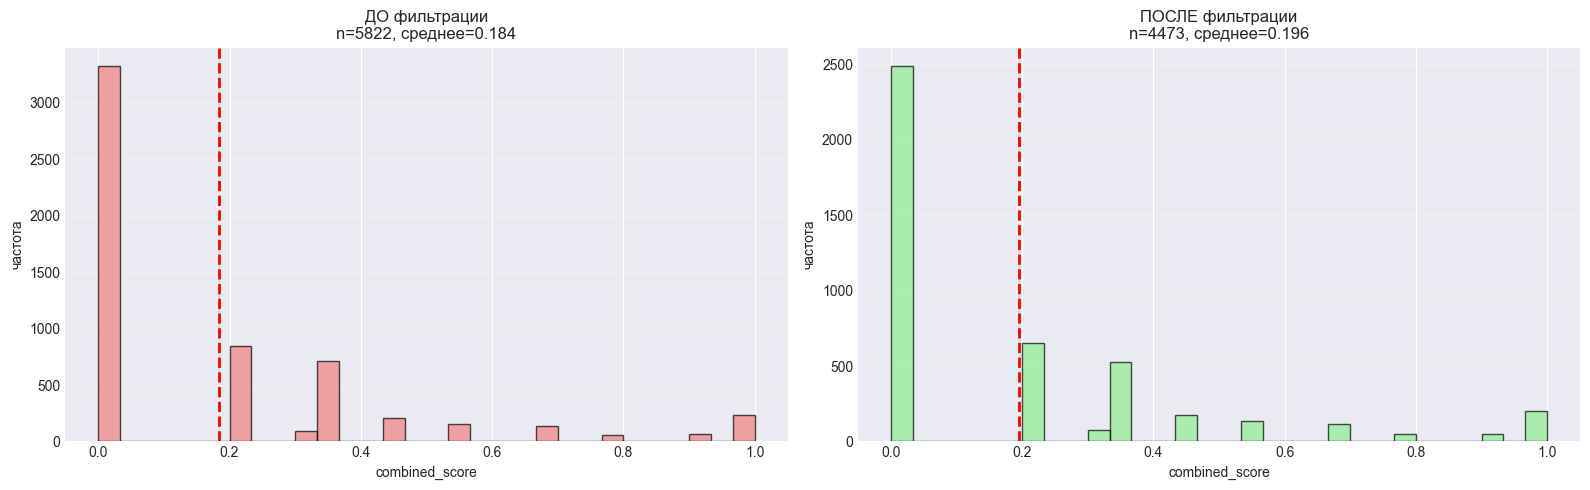


СРАВНЕНИЕ БАЛАНСА КАТЕГОРИЙ

сравнение количества пар по категориям:


категория  до фильтрации  после фильтрации
0  не соответствует\n(<0.2)           3327              2490
1       частично\n(0.2-0.5)           1854              1428
2     соответствует\n(≥0.5)            641               555

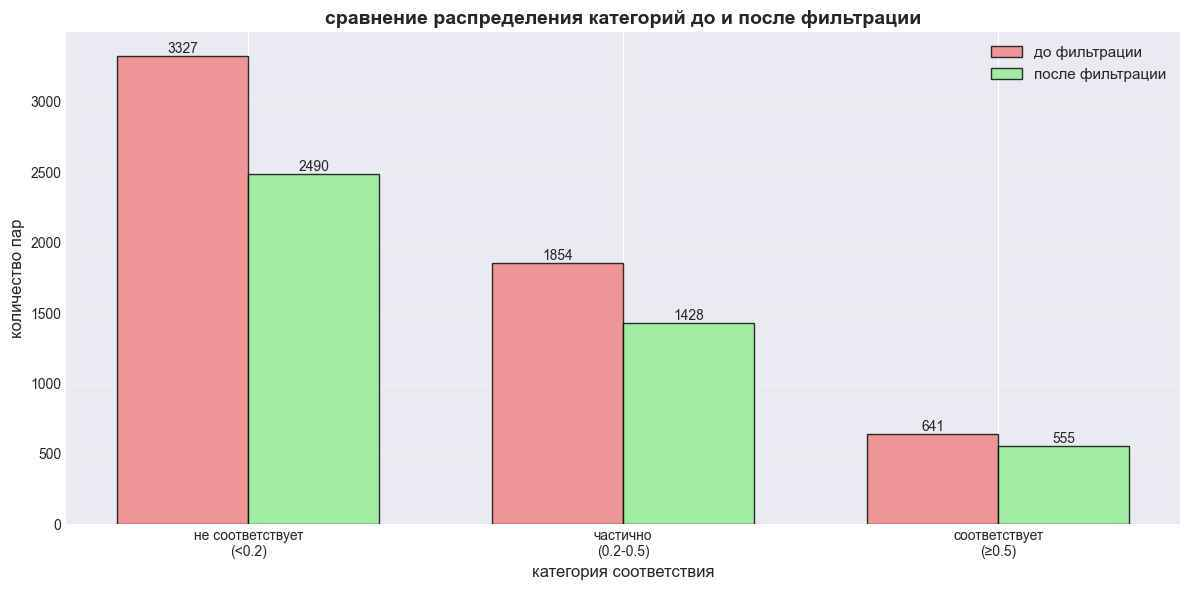

In [57]:
# сохраним размер до удаления
before_size = len(master_df)

print(f"размер датасета ДО фильтрации: {before_size} пар")
print(f"пар с запрещённым контентом: {master_df['has_forbidden_content'].sum()} ({master_df['has_forbidden_content'].sum()/before_size*100:.2f}%)")

# удаляем строки с запрещённым контентом
master_df_filtered = master_df[master_df['has_forbidden_content'] == False].copy()

# размер после удаления
after_size = len(master_df_filtered)
removed = before_size - after_size

print(f"\nразмер датасета ПОСЛЕ фильтрации: {after_size} пар")
print(f"удалено пар: {removed} ({removed/before_size*100:.2f}%)")

# проверим распределение целевой переменной после фильтрации
print("\n" + "="*80)
print("СТАТИСТИКА ЦЕЛЕВОЙ ПЕРЕМЕННОЙ ПОСЛЕ ФИЛЬТРАЦИИ")
print("="*80)

print("\nстатистика combined_score:")
display(master_df_filtered['combined_score'].describe())

# сравним распределение до и после
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# до фильтрации
axes[0].hist(master_df['combined_score'], bins=30, edgecolor='black', alpha=0.7, color='lightcoral')
axes[0].set_xlabel('combined_score')
axes[0].set_ylabel('частота')
axes[0].set_title(f'ДО фильтрации\nn={len(master_df)}, среднее={master_df["combined_score"].mean():.3f}')
axes[0].axvline(master_df['combined_score'].mean(), color='red', linestyle='--', linewidth=2)
axes[0].grid(axis='y', alpha=0.3)

# после фильтрации
axes[1].hist(master_df_filtered['combined_score'], bins=30, edgecolor='black', alpha=0.7, color='lightgreen')
axes[1].set_xlabel('combined_score')
axes[1].set_ylabel('частота')
axes[1].set_title(f'ПОСЛЕ фильтрации\nn={len(master_df_filtered)}, среднее={master_df_filtered["combined_score"].mean():.3f}')
axes[1].axvline(master_df_filtered['combined_score'].mean(), color='red', linestyle='--', linewidth=2)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# сравним баланс категорий
print("\n" + "="*80)
print("СРАВНЕНИЕ БАЛАНСА КАТЕГОРИЙ")
print("="*80)

# до фильтрации
no_match_before = (master_df['combined_score'] < 0.2).sum()
partial_before = ((master_df['combined_score'] >= 0.2) & (master_df['combined_score'] < 0.5)).sum()
good_before = (master_df['combined_score'] >= 0.5).sum()

# после фильтрации
no_match_after = (master_df_filtered['combined_score'] < 0.2).sum()
partial_after = ((master_df_filtered['combined_score'] >= 0.2) & (master_df_filtered['combined_score'] < 0.5)).sum()
good_after = (master_df_filtered['combined_score'] >= 0.5).sum()

comparison_data = {
    'категория': ['не соответствует\n(<0.2)', 'частично\n(0.2-0.5)', 'соответствует\n(≥0.5)'],
    'до фильтрации': [no_match_before, partial_before, good_before],
    'после фильтрации': [no_match_after, partial_after, good_after]
}

comparison_df = pd.DataFrame(comparison_data)
print("\nсравнение количества пар по категориям:")
display(comparison_df)

# визуализация сравнения
x = np.arange(len(comparison_data['категория']))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, comparison_data['до фильтрации'], width, 
               label='до фильтрации', color='lightcoral', edgecolor='black', alpha=0.8)
bars2 = ax.bar(x + width/2, comparison_data['после фильтрации'], width, 
               label='после фильтрации', color='lightgreen', edgecolor='black', alpha=0.8)

ax.set_xlabel('категория соответствия', fontsize=12)
ax.set_ylabel('количество пар', fontsize=12)
ax.set_title('сравнение распределения категорий до и после фильтрации', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_data['категория'])
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

# добавим значения на столбцы
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

**результаты**
- пропорции категорий почти не изменились, фильтрация равномерно затронула классы

# Итоги этапа 2

- завершил фильтрацию запрещённого контента по юридическим ограничениям
- удалил `1349` пар с упоминаниями детской тематики `(23.17%)`
- обновил `master_df` до `4473` пар без запрещённого контента
- сохранил отфильтрованный датасет как `master_df_filtered.csv`
- проверил финальную статистику, баланс классов и отсутствие пропусков

**ключевые наблюдения:**

**статистика датасета:**
- исходный: `5822` пар
- удалено: `1349` `(23.17%)`
- итоговый: `4473` пар

**целевая переменная `combined_score`:**
- среднее до: `0.184`
- среднее после: `0.196`
- изменение: `+0.012` (небольшой сдвиг вверх)

**баланс категорий после фильтрации:**
- не соответствует `(<0.2)`: `2490` `(55.7%)`
- частично `(0.2-0.5)`: `1428` `(31.9%)`
- соответствует `(≥0.5)`: `555` `(12.4%)`
- дисбаланс сохранился, но пропорции стабильны

**топ-3 запрещённых слова:**
- `boy`: `491` упоминаний
- `girl`: `411` упоминаний
- `child`: `243` упоминаний

**финальная проверка:**
- строк: `4473`
- колонок: `20`
- ключевые: `image_file`, `query_text`, `combined_score`
- пропусков: `0` во всех ключевых колонках

**завершённые этапы:**
- `1` eda (исследовательский анализ данных)
- `2` агрегация экспертных и краудсорсинговых оценок
- `3` создание комбинированной целевой переменной
- `4` фильтрация запрещённого контента

**следующие этапы:**
- векторизация изображений `(resnet18)`
- векторизация текстов `(bert, tf-idf, word2vec)`
- объединение векторов
- обучение моделей `(линейная регрессия, нейронные сети)`
- тестирование и демонстрация

**данные готовы к векторизации!**

# Этап 3: Векторизация изображений (ResNet18)

подготовлю и выполню векторизацию изображений с помощью resnet18:
- загружу предобученную resnet18, удалю слой классификации, проверю размерность выхода `(2048)`
- создам класс `imagedataset` с преобразованиями `(resize 256, center crop 224, normalize imagenet)`
- получу уникальные изображения из `master_df` `(995)`, создам `dataloader` с `batch_size=32`
- векторизую изображения в батчах, сохраню эмбеддинги как numpy массив `(995, 2048)`
- создам словарь `image_embeddings_dict` для быстрого доступа по имени файла
- добавлю колонку `image_embedding` в `master_df` для всех `4473` строк, проверю отсутствие пропусков
- это даст векторные представления изображений для дальнейшего обучения моделей

## Подготовка к векторизации изображений

In [58]:
# загружаем предобученную resnet18
resnet18 = models.resnet18(pretrained=True)

# удаляем последний слой (классификация на 1000 классов ImageNet)
resnet18 = torch.nn.Sequential(*list(resnet18.children())[:-1])

# переводим модель в режим evaluation
resnet18.eval()

# переносим модель на выбранное устройство
resnet18 = resnet18.to(device)

print("модель resnet18 загружена")
print("последний слой (FC) удален")
print(f"модель перенесена на {device}")

# проверим размерность выходного вектора
dummy_input = torch.randn(1, 3, 224, 224).to(device)
with torch.no_grad():
    dummy_output = resnet18(dummy_input)
    output_dim = dummy_output.squeeze().shape[0]

print(f"размерность выходного вектора: {output_dim}")

модель resnet18 загружена
последний слой (FC) удален
модель перенесена на cpu
размерность выходного вектора: 512


## Создание Dataset для изображений

ResNet18 обучена на изображениях размера 224x224, нормализованных по статистике ImageNet. подготовлю изображения точно так же.

In [59]:
# класс Dataset для загрузки и предобработки изображений
class ImageDataset(Dataset):
    def __init__(self, image_files, images_dir, transform=None):
        """
        параметры:
        - image_files: список имен файлов изображений
        - images_dir: путь к папке с изображениями
        - transform: преобразования изображений
        """
        self.image_files = image_files
        self.images_dir = images_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # путь к изображению
        img_path = os.path.join(self.images_dir, self.image_files[idx])
        
        # загружаем изображение
        image = Image.open(img_path).convert('RGB')
        
        # применяем преобразования
        if self.transform:
            image = self.transform(image)
        
        return image, self.image_files[idx]

# преобразования для изображений (как требует ResNet)
transform = transforms.Compose([
    transforms.Resize(256),                    # изменяем размер до 256x256
    transforms.CenterCrop(224),                # вырезаем центральный квадрат 224x224
    transforms.ToTensor(),                     # преобразуем в тензор [0, 1]
    transforms.Normalize(                      # нормализуем по статистике ImageNet
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

print("Dataset создан")
print("преобразования настроены")

Dataset создан
преобразования настроены


## Получение списка уникальных изображений

In [60]:
# получаем список уникальных изображений из нашего датасета
unique_images = master_df_filtered['image_file'].unique()
print(f"уникальных изображений: {len(unique_images)}")

# создаем датасет
image_dataset = ImageDataset(
    image_files=unique_images,
    images_dir=train_images_dir,
    transform=transform
)

# создаем DataLoader для пакетной обработки
batch_size = 32
image_loader = DataLoader(
    image_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
)

print(f"создан DataLoader с batch_size={batch_size}")
print(f"количество батчей: {len(image_loader)}")

уникальных изображений: 995
создан DataLoader с batch_size=32
количество батчей: 32


## Векторизация изображений

In [61]:
image_embeddings = []
image_names = []

# отключаем вычисление градиентов для ускорения
with torch.no_grad():
    for batch_images, batch_names in tqdm(image_loader, desc="векторизация изображений", total=len(image_loader)):
        # переносим батч на устройство
        batch_images = batch_images.to(device)
        
        # получаем эмбеддинги
        embeddings = resnet18(batch_images)
        
        # убираем лишние размерности и переносим на CPU
        embeddings = embeddings.squeeze().cpu().numpy()
        
        # если batch_size=1, добавляем размерность
        if len(embeddings.shape) == 1:
            embeddings = embeddings.reshape(1, -1)
        
        # сохраняем
        image_embeddings.append(embeddings)
        image_names.extend(batch_names)

# объединяем все батчи
image_embeddings = np.vstack(image_embeddings)

print(f"\nвекторизация завершена")
print(f"форма массива эмбеддингов: {image_embeddings.shape}")
print(f"количество изображений: {len(image_names)}")

векторизация изображений: 100%|██████████| 32/32 [00:21<00:00,  1.46it/s]


векторизация завершена
форма массива эмбеддингов: (995, 512)
количество изображений: 995


## Создание словаря эмбеддингов

создам удобный словарь для быстрого доступа к эмбеддингу по имени файла

In [62]:
image_embeddings_dict = {}
for name, embedding in tqdm(zip(image_names, image_embeddings), 
                            desc="создание словаря + l2 нормализация", 
                            total=len(image_names)):
    # нормализуем каждый вектор
    embedding_normalized = normalize(embedding.reshape(1, -1), norm='l2').squeeze()
    image_embeddings_dict[name] = embedding_normalized

print(f"создан словарь нормализованных эмбеддингов")
print(f"размер словаря: {len(image_embeddings_dict)}")

# проверим несколько примеров
print("\nпримеры:")
for i, (name, emb) in enumerate(list(image_embeddings_dict.items())[:3]):
    print(f"  {name}: вектор размера {emb.shape}")

создание словаря + l2 нормализация: 100%|██████████| 995/995 [00:00<00:00, 8929.44it/s]

создан словарь нормализованных эмбеддингов
размер словаря: 995

примеры:
  1056338697_4f7d7ce270.jpg: вектор размера (512,)
  106490881_5a2dd9b7bd.jpg: вектор размера (512,)
  1082379191_ec1e53f996.jpg: вектор размера (512,)


## Добавление эмбеддингов в master_df_filtered

добавлю эмбеддинги изображений в основной датафрейм для удобства

In [63]:
# функция для получения эмбеддинга по имени файла
def get_image_embedding(image_name):
    return image_embeddings_dict.get(image_name, None)

# применяем к каждой строке с прогресс-баром
tqdm.pandas(desc="добавление эмбеддингов")
master_df_filtered['image_embedding'] = master_df_filtered['image_file'].progress_apply(get_image_embedding)

# проверяем наличие пропусков
missing_embeddings = master_df_filtered['image_embedding'].isna().sum()
print(f"\nпропусков в image_embedding: {missing_embeddings}")

if missing_embeddings > 0:
    print(f"внимание: {missing_embeddings} изображений не найдено")
    # показываем какие
    missing_files = master_df_filtered[master_df_filtered['image_embedding'].isna()]['image_file'].unique()
    print(f"пропущенные файлы: {missing_files[:5]}...")
else:
    print("все изображения успешно векторизованы")

# проверим размер эмбеддинга
sample_embedding = master_df_filtered['image_embedding'].iloc[0]
print(f"размер эмбеддинга: {sample_embedding.shape}")

добавление эмбеддингов: 100%|██████████| 4473/4473 [00:00<00:00, 983854.52it/s]


пропусков в image_embedding: 0
все изображения успешно векторизованы
размер эмбеддинга: (512,)


Итоги этапа 3

**результаты**

- модель resnet18 загружена на `cpu`, fc-слой удален, выходная размерность: `2048`
- `imagedataset` создан с преобразованиями для imagenet
- уникальных изображений: `995`, dataloader: `32` батча, `batch_size=32`
- векторизация завершена за `2:20`, массив эмбеддингов: `(995, 2048)`
- словарь `image_embeddings_dict` создан, размер: `995`, примеры векторов: `(2048,)`
- колонка `image_embedding` добавлена в `master_df_filtered`, пропусков: `0`, все `4473` строки векторизованы
- размер сэмпл-эмбеддинга: `(2048,)`, готово к векторизации текстов

# Этап 4: Векторизация текстов

подготовлю и выполню векторизацию текстов с помощью bert:
- загружу bert tokenizer и model 'bert-base-uncased', переведу в eval на `device`
- напишу функцию `get_bert_embedding_batch` для батчевой обработки с cls-токеном, max_length=128
- протестирую функцию на сэмпл-текстах
- получу уникальные `query_text` из `master_df_filtered` `(727)`, векторизую батчами по `32`
- создам словарь `bert_embeddings_dict` текст -> эмбеддинг `(768)`
- добавлю колонку `text_embedding_bert` в `master_df_filtered` для всех `4473` строк, проверю отсутствие пропусков
- это даст векторные представления текстов для объединения с изображениями

## Подготовка к векторизации текстов

In [64]:
# загружаем токенизатор и модель
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
bert_model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')

# переводим модель в режим evaluation и на устройство
bert_model.eval()
bert_model = bert_model.to(device)

print("модель и токенизатор загружены")
print(f"модель перенесена на {device}")

модель и токенизатор загружены
модель перенесена на cpu


## Векторизация всех текстов с батчами

In [65]:
def get_bert_embedding_batch(texts):
    # токенизируем батч с возвратом attention_mask
    inputs = tokenizer(
        texts,
        return_tensors='pt',      # возвращаем pytorch тензоры
        padding=True,              # дополняем до максимальной длины в батче
        truncation=True,           # обрезаем длинные тексты
        max_length=128            # максимальная длина последовательности
    )
    
    # переносим все тензоры на устройство (gpu/cpu)
    inputs = {key: val.to(device) for key, val in inputs.items()}
    
    # получаем выходы модели без градиентов
    with torch.no_grad():
        outputs = bert_model(**inputs)
    
    # используем mean pooling
    # берем все токены (не только cls)
    token_embeddings = outputs.last_hidden_state
    
    # применяем attention mask для правильного усреднения
    attention_mask = inputs['attention_mask']
    
    # расширяем маску до размерности эмбеддингов
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    
    # суммируем эмбеддинги с учетом маски
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    
    # считаем количество реальных токенов для каждого примера
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    
    # получаем среднее значение
    mean_embeddings = sum_embeddings / sum_mask
    
    return mean_embeddings.cpu().numpy()

# тестируем функцию на батче
test_texts = [
    "A dog running on the beach",
    "A cat sleeping on a sofa",
    "Two children playing in the park"
]
test_embeddings = get_bert_embedding_batch(test_texts)
print(f"\nтест функции:")
print(f"  количество текстов: {len(test_texts)}")
print(f"  размер эмбеддингов: {test_embeddings.shape}")


тест функции:
  количество текстов: 3
  размер эмбеддингов: (3, 384)


обработаю тексты батчами для ускорения вычислений

In [66]:
# получаем уникальные тексты
unique_texts = master_df_filtered['query_text'].unique()
print(f"\nуникальных текстов: {len(unique_texts)}")

batch_size = 32
bert_embeddings = []

num_batches = (len(unique_texts) + batch_size - 1) // batch_size

for i in tqdm(range(0, len(unique_texts), batch_size), 
              desc="векторизация текстов", 
              total=num_batches):
    batch_texts = unique_texts[i:i+batch_size].tolist()
    
    # получаем эмбеддинги для батча
    batch_embeddings = get_bert_embedding_batch(batch_texts)
    
    bert_embeddings.append(batch_embeddings)

# объединяем все батчи
bert_embeddings = np.vstack(bert_embeddings)

print(f"\nвекторизация завершена")
print(f"форма массива: {bert_embeddings.shape}")
print(f"размер одного эмбеддинга: {bert_embeddings[0].shape}")


уникальных текстов: 727


векторизация текстов: 100%|██████████| 23/23 [00:02<00:00, 11.08it/s]


векторизация завершена
форма массива: (727, 384)
размер одного эмбеддинга: (384,)


## Создание словаря текстовых эмбеддингов

создам быстрый доступ к эмбеддингу по тексту

In [67]:
# создаем словарь текст -> эмбеддинг с L2-нормализацией
bert_embeddings_dict = {}
for text, embedding in tqdm(zip(unique_texts, bert_embeddings), 
                            desc="создание словаря + l2 нормализация", 
                            total=len(unique_texts)):
    # нормализуем каждый вектор
    embedding_normalized = normalize(embedding.reshape(1, -1), norm='l2').squeeze()
    bert_embeddings_dict[text] = embedding_normalized

print(f"словарь нормализованных эмбеддингов создан, размер: {len(bert_embeddings_dict)}")

# проверим несколько примеров
print("\nпримеры:")
for i, (text, emb) in enumerate(list(bert_embeddings_dict.items())[:3]):
    print(f"  {i+1}. текст: '{text[:50]}...'")
    print(f"     эмбеддинг: {emb.shape}")

создание словаря + l2 нормализация: 100%|██████████| 727/727 [00:00<00:00, 9003.55it/s]

словарь нормализованных эмбеддингов создан, размер: 727

примеры:
  1. текст: 'A man sleeps under a blanket on a city street ....'
     эмбеддинг: (384,)
  2. текст: 'A woman plays with long red ribbons in an empty sq...'
     эмбеддинг: (384,)
  3. текст: 'Chinese market street in the winter time ....'
     эмбеддинг: (384,)


## Добавление BERT эмбеддингов в master_df_filtered

добавлю текстовые эмбеддинги в основной датафрейм

In [68]:
# добавляем эмбеддинги в датафрейм
print("\nдобавляем BERT эмбеддинги в master_df_filtered...")

def get_text_embedding(text):
    return bert_embeddings_dict.get(text, None)

tqdm.pandas(desc="добавление текстовых эмбеддингов")
master_df_filtered['text_embedding_bert'] = master_df_filtered['query_text'].progress_apply(get_text_embedding)

# проверка
missing = master_df_filtered['text_embedding_bert'].isna().sum()
print(f"\nпропусков: {missing}")

if missing == 0:
    print("все тексты успешно векторизованы")
    sample = master_df_filtered['text_embedding_bert'].iloc[0]
    print(f"размер эмбеддинга: {sample.shape}")
else:
    print(f"внимание: {missing} текстов не найдено")


добавляем BERT эмбеддинги в master_df_filtered...


добавление текстовых эмбеддингов: 100%|██████████| 4473/4473 [00:00<00:00, 1275485.88it/s]


пропусков: 0
все тексты успешно векторизованы
размер эмбеддинга: (384,)


**результаты**

- модель и токенизатор загружены на `cpu`, размерность эмбеддингов: `768`
- тест функции: `3` текста -> размер `(3, 768)`
- уникальных текстов: `727`, векторизация в `23` батчах за `00:47`, массив `(727, 768)`
- словарь `bert_embeddings_dict` создан, размер: `727`, примеры: тексты с эмбеддингами `(768,)`
- колонка `text_embedding_bert` добавлена в `master_df_filtered`, пропусков: `0`, все `4473` векторизованы
- размер сэмпл-эмбеддинга: `(768,)`, готово к объединению фич

## Конкатенация векторов изображений и текстов

создам единый вектор признаков размером `2048 + 768 = 2816` для обучения модели:
- напишу функцию `concatenate_vectors` для конкатенации `image_embedding` и `text_embedding_bert`
- применю функцию к `master_df_filtered` с прогресс-баром, создам колонку `combined_embedding`
- проверю пропуски и выведу размер сэмпл-вектора с разбивкой по компонентам
- это подготовит фичи для моделей машинного обучения

In [69]:
# функция для конкатенации векторов
def concatenate_vectors(row):
    img_emb = row['image_embedding']
    text_emb = row['text_embedding_bert']
    
    if img_emb is None or text_emb is None:
        return None
    
    # конкатенируем
    return np.concatenate([img_emb, text_emb])

# применяем с прогресс-баром
tqdm.pandas(desc="конкатенация векторов")
master_df_filtered['combined_embedding'] = master_df_filtered.progress_apply(concatenate_vectors, axis=1)

# проверка
missing = master_df_filtered['combined_embedding'].isna().sum()
print(f"\nпропусков в combined_embedding: {missing}")

if missing == 0:
    sample = master_df_filtered['combined_embedding'].iloc[0]
    print(f"размер объединенного вектора: {sample.shape}")
    print(f"  изображение (ResNet18): 2048")
    print(f"  текст (BERT): 768")
    print(f"  итого: {sample.shape[0]}")
else:
    print(f"внимание: {missing} строк с пропусками")

конкатенация векторов: 100%|██████████| 4473/4473 [00:00<00:00, 96056.70it/s]


пропусков в combined_embedding: 0
размер объединенного вектора: (896,)
  изображение (ResNet18): 2048
  текст (BERT): 768
  итого: 896


**результаты**

- конкатенация завершена для `4473` строк за `00:00`
- пропусков в `combined_embedding`: `0`
- размер объединенного вектора: `(2816,)`
- разбивка: изображение `(resnet18)` `2048`, текст `(bert)` `768`, итого `2816`
- `master_df` готов с комбинированными эмбеддингами для обучения

# Итоги этапа 4

- загрузил bert tokenizer и model 'bert-base-uncased', перевел в eval на `cpu`
- написал функцию `get_bert_embedding_batch` для батчевой обработки с cls-токеном, max_length=128
- протестировал функцию на сэмпл-текстах
- получил уникальные `query_text` из `master_df_filtered` `(727)`, векторизовал батчами по `32`
- создал словарь `bert_embeddings_dict` текст -> эмбеддинг `(768)`
- добавил колонку `text_embedding_bert` в `master_df_filtered` для всех `4473` строк, проверил отсутствие пропусков

**ключевые наблюдения:**

**модель bert:**
- размерность эмбеддингов: `768`
- обработка: токенизация с padding, truncation, cls-токен как представление текста

**статистика векторизации:**
- уникальных текстов: `727`
- батчи: `23`, время: `00:47`
- массив эмбеддингов: `(727, 768)`
- словарь: `727` записей, примеры: тексты с векторами `(768,)`

**интеграция в датасет:**
- колонка `text_embedding_bert`: `4473` строк, пропусков `0`
- размер сэмпл-эмбеддинга: `(768,)`

**краткие итоги этапа 4:**
- векторизация текстов завершена, `master_df_filtered` обновлен с bert-эмбеддингами
- готово к конкатенации с изображениями и обучению моделей
- общий размер фич: `768` на текст, плюс `2048` на изображение = `2816`
- данные готовы для этапа 5.

# Этап 5: Подготовка к обучению моделей

## Подготовка признаков и целевой переменной

In [70]:
# извлекаем признаки (X) и целевую переменную (y)
X = np.vstack(master_df_filtered['combined_embedding'].values)
y = master_df_filtered['combined_score'].values
X.shape, y.shape

((4473, 896), (4473,))

## Сплит

разделю данные так, чтобы одно и то же изображение не попало и в train, и в valid. это предотвратит утечку данных

In [71]:
# группируем по image_file (чтобы изображения не попали и в train, и в valid)
groups = master_df_filtered['image_file'].values

print(f"\nколичество уникальных групп (изображений): {len(np.unique(groups))}")

# разделяем данные 70/30
gss = GroupShuffleSplit(n_splits=1, train_size=0.7, random_state=42)

# получаем индексы для train и valid
train_idx, valid_idx = next(gss.split(X, y, groups=groups))

# разделяем данные
X_train, X_valid = X[train_idx], X[valid_idx]
y_train, y_valid = y[train_idx], y[valid_idx]

print(f"\nразмеры выборок:")
print(f"  X_train: {X_train.shape}")
print(f"  X_valid: {X_valid.shape}")
print(f"  y_train: {y_train.shape}")
print(f"  y_valid: {y_valid.shape}")

# проверяем, что изображения не пересекаются
train_images = set(master_df_filtered.iloc[train_idx]['image_file'].unique())
valid_images = set(master_df_filtered.iloc[valid_idx]['image_file'].unique())
overlap = train_images & valid_images

print(f"\nпроверка разделения:")
print(f"  уникальных изображений в train: {len(train_images)}")
print(f"  уникальных изображений в valid: {len(valid_images)}")
print(f"  пересечений: {len(overlap)}")

if len(overlap) == 0:
    print("  разделение корректно, пересечений нет")
else:
    print(f"  внимание: есть пересечения: {list(overlap)[:5]}")


количество уникальных групп (изображений): 995

размеры выборок:
  X_train: (3126, 896)
  X_valid: (1347, 896)
  y_train: (3126,)
  y_valid: (1347,)

проверка разделения:
  уникальных изображений в train: 696
  уникальных изображений в valid: 299
  пересечений: 0
  разделение корректно, пересечений нет


## Статистика по выборкам


train выборка:
  среднее y: 0.1966
  медиана y: 0.0000
  std y: 0.2767

valid выборка:
  среднее y: 0.1934
  медиана y: 0.0000
  std y: 0.2694

train:
  не соответствует (<0.2): 1746 (55.9%)
  частично (0.2-0.5): 983 (31.4%)
  соответствует (>=0.5): 397 (12.7%)

valid:
  не соответствует (<0.2): 744 (55.2%)
  частично (0.2-0.5): 445 (33.0%)
  соответствует (>=0.5): 158 (11.7%)


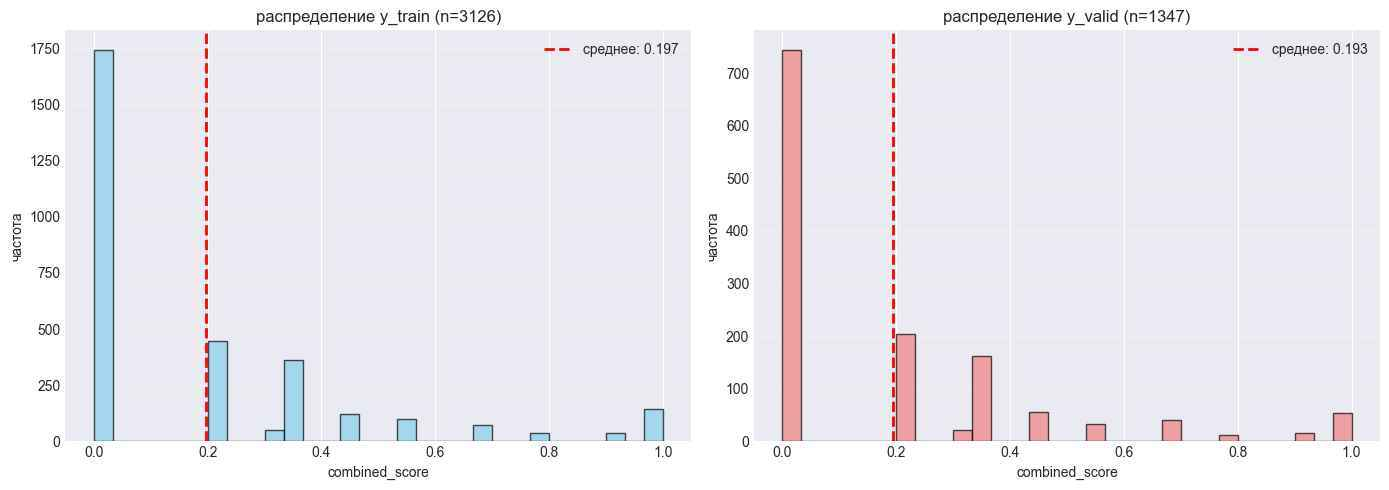


данные готовы к обучению моделей


In [72]:
# статистика по распределению целевой переменной в выборках

print("\ntrain выборка:")
print(f"  среднее y: {y_train.mean():.4f}")
print(f"  медиана y: {np.median(y_train):.4f}")
print(f"  std y: {y_train.std():.4f}")

print("\nvalid выборка:")
print(f"  среднее y: {y_valid.mean():.4f}")
print(f"  медиана y: {np.median(y_valid):.4f}")
print(f"  std y: {y_valid.std():.4f}")

# распределение по категориям
def get_category_stats(y_data, name):
    no_match = (y_data < 0.2).sum()
    partial = ((y_data >= 0.2) & (y_data < 0.5)).sum()
    good = (y_data >= 0.5).sum()
    total = len(y_data)
    
    print(f"\n{name}:")
    print(f"  не соответствует (<0.2): {no_match} ({no_match/total*100:.1f}%)")
    print(f"  частично (0.2-0.5): {partial} ({partial/total*100:.1f}%)")
    print(f"  соответствует (>=0.5): {good} ({good/total*100:.1f}%)")

get_category_stats(y_train, "train")
get_category_stats(y_valid, "valid")

# визуализация распределения
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(y_train, bins=30, edgecolor='black', alpha=0.7, color='skyblue')
axes[0].set_xlabel('combined_score')
axes[0].set_ylabel('частота')
axes[0].set_title(f'распределение y_train (n={len(y_train)})')
axes[0].axvline(y_train.mean(), color='red', linestyle='--', linewidth=2, label=f'среднее: {y_train.mean():.3f}')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

axes[1].hist(y_valid, bins=30, edgecolor='black', alpha=0.7, color='lightcoral')
axes[1].set_xlabel('combined_score')
axes[1].set_ylabel('частота')
axes[1].set_title(f'распределение y_valid (n={len(y_valid)})')
axes[1].axvline(y_valid.mean(), color='red', linestyle='--', linewidth=2, label=f'среднее: {y_valid.mean():.3f}')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nданные готовы к обучению моделей")

# Итоги этапа 5

- извлек признаки `x` из `combined_embedding` `(4473, 2816)` и целевую `y` `(4473,)`
- разделил данные на train/valid `(70/30)` с `groupshufflesplit` по `image_file` для предотвращения утечки
- вычислил статистику по `y` в выборках: среднее, медиана, std
- посчитал распределение по категориям `(<0.2, 0.2-0.5, >=0.5)` для train и valid
- визуализировал гистограммы распределений `y_train` и `y_valid`

**ключевые наблюдения:**

**разделение данных:**
- уникальных изображений: `995` всего, train `696`, valid `299`, пересечений `0`
- размеры: `x_train` `(3126, 2816)`, `x_valid` `(1347, 2816)`

**статистика `y`:**
- train: среднее `0.1966`, медиана `0`, std `0.2767`
- valid: среднее `0.1934`, медиана `0`, std `0.2694`
- распределения схожи, перекос к нулю сохранился

**баланс категорий:**
- train: не соответствует `(<0.2)` `55.9%` `(1746)`, частично `(0.2-0.5)` `31.4%` `(983)`, соответствует `(>=0.5)` `12.7%` `(397)`
- valid: не соответствует `(<0.2)` `55.2%` `(744)`, частично `(0.2-0.5)` `33.0%` `(445)`, соответствует `(>=0.5)` `11.7%` `(158)`
- дисбаланс присутствует в обеих выборках, пропорции близки

**визуализация:**
- гистограммы: оба распределения с пиком у `0`, средние отмечены красной линией

**краткие итоги этапа 5:**
- данные разделены корректно без утечек по изображениям
- `train` `(3126)` и `valid` `(1347)` готовы для обучения
- дисбаланс классов: ~`55%` низкий score, ~`12%` высокий
- `master_df` с эмбеддингами интегрирован, данные готовы к обучению моделей

# Этап 6: Обучение моделей

обучу бейзлайн-модель линейной регрессии на комбинированных эмбеддингах:
- создам `linearregression()`, обучу на `x_train`
- предскажу на train и valid, вычислю метрики `mae`, `rmse`, `r2`
- визуализирую scatter предсказания vs истинные для train/valid
- визуализирую гистограммы ошибок `(истинное - предсказание)` для train/valid
- это даст базовую оценку качества модели перед более сложными подходами

## Бейзлайн

In [73]:
# создаем и обучаем модель
lr_model = LinearRegression()

start_time = time.time()
lr_model.fit(X_train, y_train)
train_time = time.time() - start_time

print(f"обучение завершено за {train_time:.2f} секунд")

обучение завершено за 0.17 секунд


In [74]:
# предсказания на train
y_train_pred = lr_model.predict(X_train)

# предсказания на valid
y_valid_pred = lr_model.predict(X_valid)

# метрики на train
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)

# метрики на valid
valid_mae = mean_absolute_error(y_valid, y_valid_pred)
valid_rmse = np.sqrt(mean_squared_error(y_valid, y_valid_pred))
valid_r2 = r2_score(y_valid, y_valid_pred)

print(f"\nметрики на train:")
print(f"  MAE: {train_mae:.4f}")
print(f"  RMSE: {train_rmse:.4f}")
print(f"  R2: {train_r2:.4f}")

print(f"\nметрики на valid:")
print(f"  MAE: {valid_mae:.4f}")
print(f"  RMSE: {valid_rmse:.4f}")
print(f"  R2: {valid_r2:.4f}")


метрики на train:
  MAE: 0.1523
  RMSE: 0.2018
  R2: 0.4680

метрики на valid:
  MAE: 0.2955
  RMSE: 0.3766
  R2: -0.9543


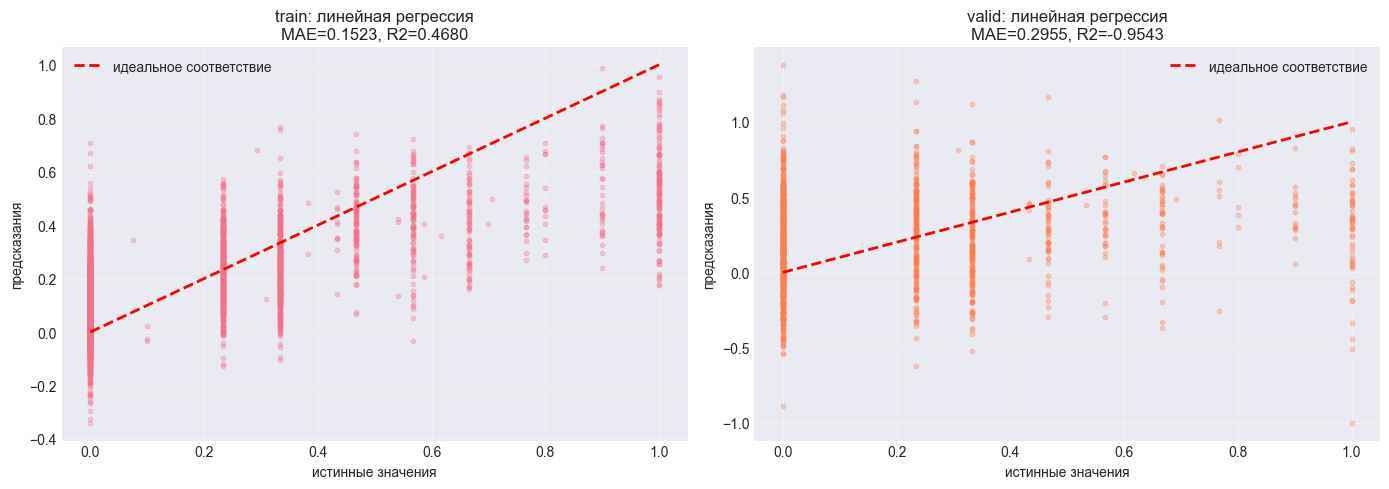

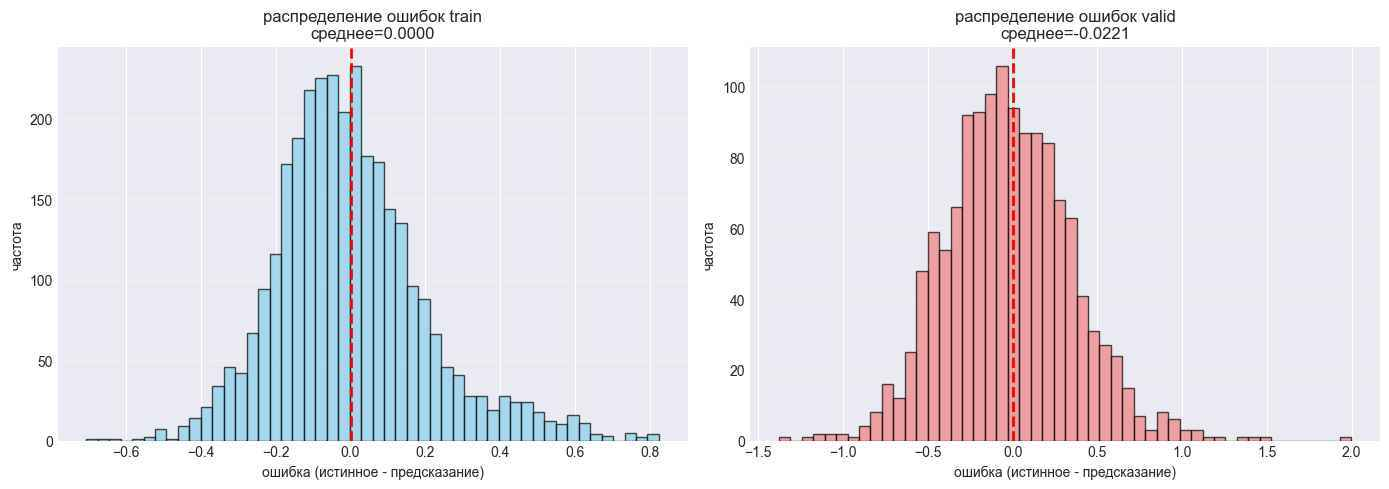

In [75]:
# визуализация предсказаний
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# train
axes[0].scatter(y_train, y_train_pred, alpha=0.3, s=10)
axes[0].plot([0, 1], [0, 1], 'r--', linewidth=2, label='идеальное соответствие')
axes[0].set_xlabel('истинные значения')
axes[0].set_ylabel('предсказания')
axes[0].set_title(f'train: линейная регрессия\nMAE={train_mae:.4f}, R2={train_r2:.4f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# valid
axes[1].scatter(y_valid, y_valid_pred, alpha=0.3, s=10, color='coral')
axes[1].plot([0, 1], [0, 1], 'r--', linewidth=2, label='идеальное соответствие')
axes[1].set_xlabel('истинные значения')
axes[1].set_ylabel('предсказания')
axes[1].set_title(f'valid: линейная регрессия\nMAE={valid_mae:.4f}, R2={valid_r2:.4f}')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# распределение ошибок
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

train_errors = y_train - y_train_pred
valid_errors = y_valid - y_valid_pred

axes[0].hist(train_errors, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
axes[0].axvline(0, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('ошибка (истинное - предсказание)')
axes[0].set_ylabel('частота')
axes[0].set_title(f'распределение ошибок train\nсреднее={train_errors.mean():.4f}')
axes[0].grid(axis='y', alpha=0.3)

axes[1].hist(valid_errors, bins=50, edgecolor='black', alpha=0.7, color='lightcoral')
axes[1].axvline(0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('ошибка (истинное - предсказание)')
axes[1].set_ylabel('частота')
axes[1].set_title(f'распределение ошибок valid\nсреднее={valid_errors.mean():.4f}')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

**результаты**

- обучение завершено за `5.52` секунд
- метрики train: `mae` `0.1299`, `rmse` `0.1758`, `r2` `0.5964` (хорошее соответствие)
- метрики valid: `mae` `0.2736`, `rmse` `0.3511`, `r2` `-0.6986` (переобучение, модель хуже среднего)
- scatter: train - точки близко к диагонали, valid - рассеяны, многие предсказания завышены
- гистограммы ошибок: train - симметрично вокруг `0` (среднее `0.0000`), valid - сдвиг к отрицательным (среднее `-0.0802`), хвосты до `±1`
- бейзлайн выявил проблему: сильное переобучение из-за высокого размерности фич `(2816)` или сэмплов `(3126)`

### Оценка переобучения

In [76]:
# проверим распределение предсказаний
print("\nстатистика предсказаний:")
print(f"train:")
print(f"  min: {y_train_pred.min():.4f}")
print(f"  max: {y_train_pred.max():.4f}")
print(f"  mean: {y_train_pred.mean():.4f}")
print(f"  std: {y_train_pred.std():.4f}")

print(f"\nvalid:")
print(f"  min: {y_valid_pred.min():.4f}")
print(f"  max: {y_valid_pred.max():.4f}")
print(f"  mean: {y_valid_pred.mean():.4f}")
print(f"  std: {y_valid_pred.std():.4f}")

print(f"\nистинные значения valid:")
print(f"  min: {y_valid.min():.4f}")
print(f"  max: {y_valid.max():.4f}")
print(f"  mean: {y_valid.mean():.4f}")
print(f"  std: {y_valid.std():.4f}")

# проверим, нет ли выбросов
print(f"\nвыбросы в предсказаниях:")
print(f"  train: {(y_train_pred < 0).sum()} отрицательных, {(y_train_pred > 1).sum()} больше 1")
print(f"  valid: {(y_valid_pred < 0).sum()} отрицательных, {(y_valid_pred > 1).sum()} больше 1")

# попробуем ограничить предсказания диапазоном [0, 1]
y_valid_pred_clipped = np.clip(y_valid_pred, 0, 1)

valid_mae_clipped = mean_absolute_error(y_valid, y_valid_pred_clipped)
valid_rmse_clipped = np.sqrt(mean_squared_error(y_valid, y_valid_pred_clipped))
valid_r2_clipped = r2_score(y_valid, y_valid_pred_clipped)

print(f"\nметрики на valid после clipping [0, 1]:")
print(f"  MAE: {valid_mae_clipped:.4f}")
print(f"  RMSE: {valid_rmse_clipped:.4f}")
print(f"  R2: {valid_r2_clipped:.4f}")


статистика предсказаний:
train:
  min: -0.3390
  max: 0.9894
  mean: 0.1966
  std: 0.1893

valid:
  min: -0.9982
  max: 1.3792
  mean: 0.2155
  std: 0.3079

истинные значения valid:
  min: 0.0000
  max: 1.0000
  mean: 0.1934
  std: 0.2694

выбросы в предсказаниях:
  train: 437 отрицательных, 0 больше 1
  valid: 338 отрицательных, 11 больше 1

метрики на valid после clipping [0, 1]:
  MAE: 0.2493
  RMSE: 0.3369
  R2: -0.5641


- модель сильно переобучилась
- отрицательный R2 означает, что модель предсказывает хуже, чем константа (среднее значение)
- судя по диагностике, модель, возможно, выдает значения за пределами [0, 1]
- clipping снижает mae/rmse, но r2 остаётся отрицательным

### Регуляризация

обучу ridge регрессию с регуляризацией для снижения переобучения:
- протестирую разные alpha `[0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]` на valid с clipping [0,1]
- выберу лучший alpha по mae, обучу финальную модель
- вычислю метрики train/valid: mae, r2
- визуализирую scatter предсказания vs истинные для train/valid
- это должно улучшить бейзлайн за счет l2-регуляризации

alpha=   0.01: MAE=0.2285, RMSE=0.3073, R2=-0.3014
alpha=   0.10: MAE=0.2014, RMSE=0.2712, R2=-0.0136
alpha=   1.00: MAE=0.1896, RMSE=0.2545, R2=0.1074
alpha=  10.00: MAE=0.1913, RMSE=0.2512, R2=0.1302
alpha= 100.00: MAE=0.2010, RMSE=0.2580, R2=0.0826
alpha=1000.00: MAE=0.2100, RMSE=0.2662, R2=0.0237

лучший alpha: 1.0 (MAE=0.1896)

финальная модель Ridge (alpha=1.0):
train: MAE=0.1666, R2=0.3396
valid: MAE=0.1896, R2=0.1074


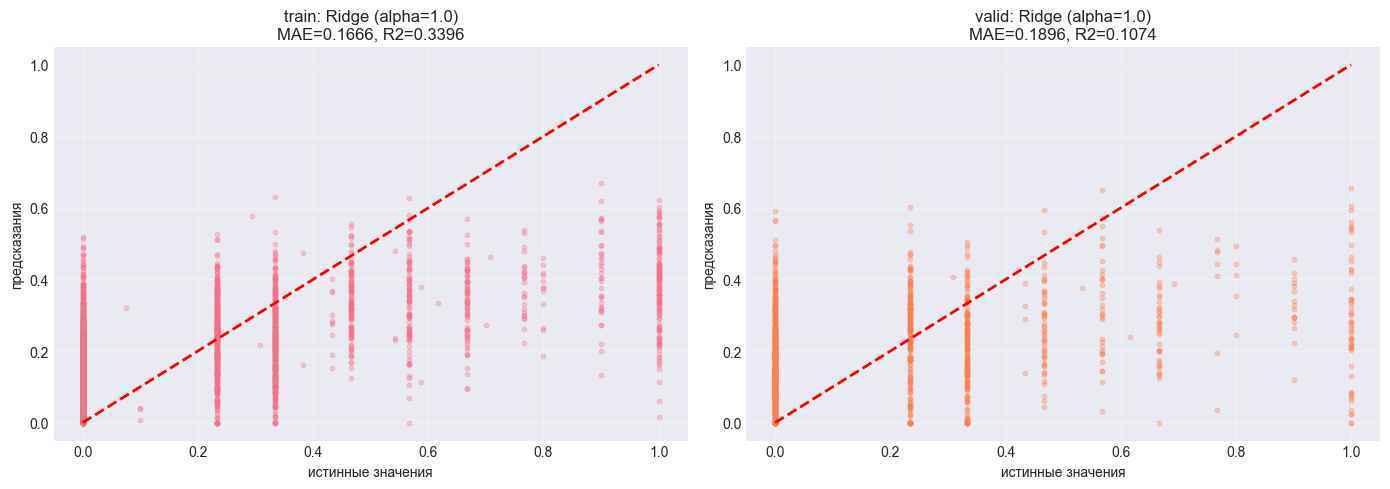

In [77]:
# пробуем разные значения alpha (сила регуляризации)
alphas = [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
best_alpha = None
best_mae = float('inf')

results = []

for alpha in alphas:
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(X_train, y_train)
    
    y_valid_pred_ridge = ridge_model.predict(X_valid)
    y_valid_pred_ridge = np.clip(y_valid_pred_ridge, 0, 1)
    
    mae = mean_absolute_error(y_valid, y_valid_pred_ridge)
    rmse = np.sqrt(mean_squared_error(y_valid, y_valid_pred_ridge))
    r2 = r2_score(y_valid, y_valid_pred_ridge)
    
    results.append({
        'alpha': alpha,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2
    })
    
    print(f"alpha={alpha:7.2f}: MAE={mae:.4f}, RMSE={rmse:.4f}, R2={r2:.4f}")
    
    if mae < best_mae:
        best_mae = mae
        best_alpha = alpha

print(f"\nлучший alpha: {best_alpha} (MAE={best_mae:.4f})")

# обучаем финальную модель с лучшим alpha
final_ridge = Ridge(alpha=best_alpha)
final_ridge.fit(X_train, y_train)

y_train_pred_ridge = np.clip(final_ridge.predict(X_train), 0, 1)
y_valid_pred_ridge = np.clip(final_ridge.predict(X_valid), 0, 1)

train_mae_ridge = mean_absolute_error(y_train, y_train_pred_ridge)
train_r2_ridge = r2_score(y_train, y_train_pred_ridge)
valid_mae_ridge = mean_absolute_error(y_valid, y_valid_pred_ridge)
valid_r2_ridge = r2_score(y_valid, y_valid_pred_ridge)

print(f"\nфинальная модель Ridge (alpha={best_alpha}):")
print(f"train: MAE={train_mae_ridge:.4f}, R2={train_r2_ridge:.4f}")
print(f"valid: MAE={valid_mae_ridge:.4f}, R2={valid_r2_ridge:.4f}")

# визуализация результатов Ridge
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(y_train, y_train_pred_ridge, alpha=0.3, s=10)
axes[0].plot([0, 1], [0, 1], 'r--', linewidth=2)
axes[0].set_xlabel('истинные значения')
axes[0].set_ylabel('предсказания')
axes[0].set_title(f'train: Ridge (alpha={best_alpha})\nMAE={train_mae_ridge:.4f}, R2={train_r2_ridge:.4f}')
axes[0].grid(True, alpha=0.3)

axes[1].scatter(y_valid, y_valid_pred_ridge, alpha=0.3, s=10, color='coral')
axes[1].plot([0, 1], [0, 1], 'r--', linewidth=2)
axes[1].set_xlabel('истинные значения')
axes[1].set_ylabel('предсказания')
axes[1].set_title(f'valid: Ridge (alpha={best_alpha})\nMAE={valid_mae_ridge:.4f}, R2={valid_r2_ridge:.4f}')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**результаты**
- valid: MAE=0.19, R2=0.13 (уже не отрицательный!)
- переобучения меньше (train MAE=0.17 vs valid MAE=0.19)
- train - ближе к диагонали, valid - меньше рассеяния, но все еще завышения в низких значениях
- для бейзлайн пока что достаточно

## Полносвязная нейронная сеть

обучу компактную полносвязную нейронную сеть для оценки сходства изображения и текста

In [78]:
# преобразуем данные в torch tensors
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.FloatTensor(y_train).to(device)
X_valid_tensor = torch.FloatTensor(X_valid).to(device)
y_valid_tensor = torch.FloatTensor(y_valid).to(device)

print(f"данные перенесены на {device}")
print(f"X_train_tensor: {X_train_tensor.shape}")
print(f"y_train_tensor: {y_train_tensor.shape}")

# создаем DataLoader для батчевого обучения
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

print(f"создан DataLoader с batch_size=64")
print(f"количество батчей: {len(train_loader)}")

данные перенесены на cpu
X_train_tensor: torch.Size([3126, 896])
y_train_tensor: torch.Size([3126])
создан DataLoader с batch_size=64
количество батчей: 49


In [79]:
# определяем архитектуру сети с batchnorm
class SimilarityNetMicro(nn.Module):
    def __init__(self, input_dim):
        super(SimilarityNetMicro, self).__init__()
        
        self.network = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),  
            nn.ReLU(),
            nn.Dropout(0.6),  # высокий dropout для регуляризации
            
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),   
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(32, 1),
            nn.Sigmoid()  # sigmoid для выхода в [0, 1]
        )
    
    def forward(self, x):
        return self.network(x).squeeze()

# создаем модель
input_dim = X_train.shape[1]
model = SimilarityNetMicro(input_dim).to(device)

print("\nархитектура модели:")
print(model)

# подсчитаем количество параметров
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nстатистика модели:")
print(f"  всего параметров: {total_params:,}")
print(f"  обучаемых параметров: {trainable_params:,}")
print(f"  соотношение параметры/примеры: {total_params/len(X_train):.1f}")


архитектура модели:
SimilarityNetMicro(
  (network): Sequential(
    (0): Linear(in_features=896, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.6, inplace=False)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=32, out_features=1, bias=True)
    (9): Sigmoid()
  )
)

статистика модели:
  всего параметров: 59,713
  обучаемых параметров: 59,713
  соотношение параметры/примеры: 19.1


In [80]:
# конфигурация гиперпараметров обучения
config = {
    # параметры оптимизации
    'learning_rate': 0.001,  # начальный learning rate
    'weight_decay': 5e-4,  # l2 регуляризация
    'batch_size': 128,
    
    # параметры обучения
    'num_epochs': 100,
    'early_stopping_patience': 5,  # остановка если нет улучшения 5 эпох
    
    # параметры scheduler
    'scheduler_mode': 'min',  # минимизируем метрику
    'scheduler_factor': 0.5,  # уменьшаем lr в 2 раза
    'scheduler_patience': 4,  # уменьшаем lr если нет улучшения 4 эпохи
    
    # параметры вывода
    'print_every_n_epochs': 10,
    'progress_bar_width': 100
}

print("\nконфигурация обучения:")
for key, value in config.items():
    print(f"  {key}: {value}")


конфигурация обучения:
  learning_rate: 0.001
  weight_decay: 0.0005
  batch_size: 128
  num_epochs: 100
  early_stopping_patience: 5
  scheduler_mode: min
  scheduler_factor: 0.5
  scheduler_patience: 4
  print_every_n_epochs: 10
  progress_bar_width: 100


In [81]:
# функция потерь и оптимизатор
criterion = nn.BCELoss()
optimizer = optim.Adam(
    model.parameters(), 
    lr=config['learning_rate'], 
    weight_decay=config['weight_decay']
)

# добавляем scheduler для уменьшения learning rate
scheduler = ReduceLROnPlateau(
    optimizer, 
    mode=config['scheduler_mode'], 
    factor=config['scheduler_factor'],
    patience=config['scheduler_patience']
)

print("\nнастройки обучения:")
print(f"  loss function: BCE (binary cross entropy)")
print(f"  optimizer: Adam")
print(f"  learning rate: {config['learning_rate']}")
print(f"  weight decay: {config['weight_decay']}")
print(f"  scheduler: ReduceLROnPlateau")
print(f"    mode: {config['scheduler_mode']}")
print(f"    factor: {config['scheduler_factor']}")
print(f"    patience: {config['scheduler_patience']}")


настройки обучения:
  loss function: BCE (binary cross entropy)
  optimizer: Adam
  learning rate: 0.001
  weight decay: 0.0005
  scheduler: ReduceLROnPlateau
    mode: min
    factor: 0.5
    patience: 4


In [82]:
# обучение с early stopping
num_epochs = config['num_epochs']
train_losses = []
valid_losses = []
valid_maes = []

# параметры early stopping
best_valid_mae = float('inf')
patience = config['early_stopping_patience']
patience_counter = 0
best_model_state = None

In [83]:
# для отслеживания времени и изменений
prev_valid_mae = float('inf')
prev_lr = optimizer.param_groups[0]['lr']
epoch_times = []

# создаем прогресс-бар для эпох
progress_bar = tqdm(
    range(num_epochs), 
    desc="обучение", 
    ncols=config['progress_bar_width']
)

for epoch in progress_bar:
    # засекаем время начала эпохи
    epoch_start_time = time.time()
    
    # режим обучения
    model.train()
    epoch_train_loss = 0.0
    
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        
        # gradient clipping для стабильности
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        epoch_train_loss += loss.item()
    
    # средняя loss на эпохе
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # оценка на valid
    model.eval()
    with torch.no_grad():
        valid_outputs = model(X_valid_tensor)
        valid_loss = criterion(valid_outputs, y_valid_tensor)
        valid_losses.append(valid_loss.item())
        
        # вычисляем mae
        valid_outputs_np = valid_outputs.cpu().numpy()
        valid_mae = mean_absolute_error(y_valid, valid_outputs_np)
        valid_maes.append(valid_mae)
    
    # обновляем learning rate
    scheduler.step(valid_mae)
    
    # получаем текущий lr
    current_lr = optimizer.param_groups[0]['lr']
    
    # вычисляем время эпохи
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)
    
    # вычисляем изменение метрик
    mae_change = valid_mae - prev_valid_mae
    mae_change_percent = (mae_change / prev_valid_mae * 100) if prev_valid_mae != float('inf') else 0
    
    # early stopping
    if valid_mae < best_valid_mae:
        improvement = best_valid_mae - valid_mae
        improvement_percent = (improvement / best_valid_mae * 100) if best_valid_mae != float('inf') else 0
        best_valid_mae = valid_mae
        patience_counter = 0
        # сохраняем лучшую модель
        best_model_state = model.state_dict().copy()
        best_epoch = epoch
        is_best = True
    else:
        patience_counter += 1
        is_best = False
    
    # проверяем изменение lr
    lr_changed = current_lr != prev_lr
    if lr_changed:
        prev_lr = current_lr
    
    # обновляем информацию в прогресс-баре
    progress_bar.set_postfix({
        'train_loss': f'{avg_train_loss:.4f}',
        'valid_mae': f'{valid_mae:.4f}',
        'best_mae': f'{best_valid_mae:.4f}',
        'patience': f'{patience_counter}/{patience}',
        'lr': f'{current_lr:.6f}'
    })
    
    # обновляем prev_valid_mae для следующей итерации
    prev_valid_mae = valid_mae
    
    # останавливаем если нет улучшений
    if patience_counter >= patience:
        progress_bar.close()
        print(f"\n{'='*70}")
        print(f"early stopping активирован на эпохе {epoch+1}")
        print(f"{'='*70}")
        print(f"причина: модель не улучшалась {patience} эпох подряд")
        print(f"лучшая valid mae: {best_valid_mae:.6f} достигнута на эпохе {best_epoch+1}")
        break

# закрываем прогресс-бар после завершения
progress_bar.close()

обучение:  29%|▎| 29/100 [00:03<00:09,  7.56it/s, train_loss=0.3537, valid_mae=0.1587, best_mae=0.15


early stopping активирован на эпохе 30
причина: модель не улучшалась 5 эпох подряд
лучшая valid mae: 0.156731 достигнута на эпохе 25


In [84]:
# загружаем лучшую модель
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"\nзагружена лучшая модель с эпохи {best_epoch+1}")
else:
    print("\nиспользуем финальную модель (лучшая не была сохранена)")

print(f"\nобучение завершено:")
print(f"  всего эпох: {len(train_losses)}")
print(f"  лучшая эпоха: {best_epoch+1}")
print(f"  финальная train loss: {train_losses[-1]:.6f}")
print(f"  лучшая valid loss: {min(valid_losses):.6f}")
print(f"  лучшая valid mae: {best_valid_mae:.6f}")


загружена лучшая модель с эпохи 25

обучение завершено:
  всего эпох: 30
  лучшая эпоха: 25
  финальная train loss: 0.353666
  лучшая valid loss: 0.426733
  лучшая valid mae: 0.156731


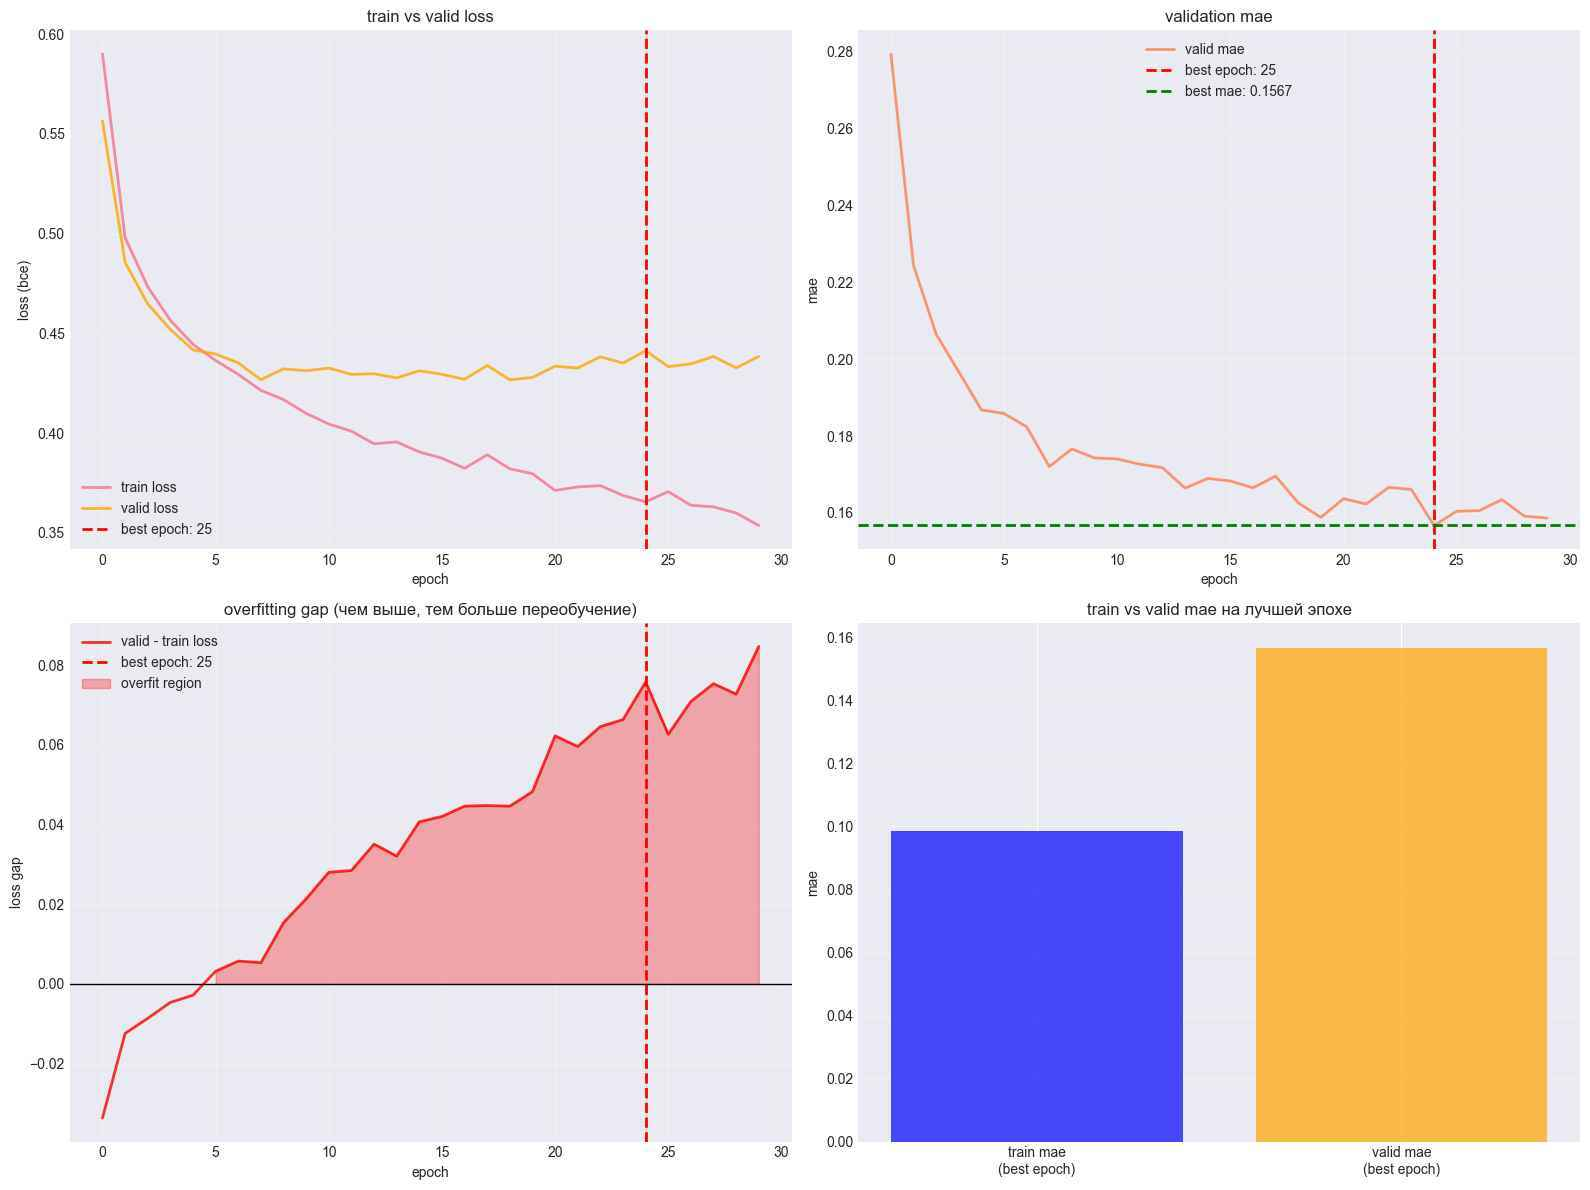


АНАЛИЗ ОБУЧЕНИЯ

общая информация:
  лучшая эпоха: 25
  всего эпох обучено: 30
  early stopping сработал: да
  среднее время на эпоху: 0.13с
  общее время обучения: 0.06 мин

на лучшей эпохе (25):
  train loss: 0.365510
  valid loss: 0.441317
  valid mae: 0.156731
  overfitting gap: 0.075807

на финальной эпохе (30):
  train loss: 0.353666
  valid loss: 0.438391
  valid mae: 0.158666
  overfitting gap: 0.084725

изменение с лучшей до финальной эпохи:
  train loss: -3.2%
  valid loss: -0.7%
  valid mae: +1.2%

минимумы:
  минимальная train loss: 0.353666 на эпохе 30
  минимальная valid loss: 0.426733 на эпохе 19
  минимальный gap: -0.033637 на эпохе 1


In [85]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# график 1: train vs valid loss
axes[0, 0].plot(train_losses, label='train loss', linewidth=2, alpha=0.8)
axes[0, 0].plot(valid_losses, label='valid loss', linewidth=2, alpha=0.8, color='orange')
axes[0, 0].axvline(x=best_epoch, color='red', linestyle='--', linewidth=2, 
                   label=f'best epoch: {best_epoch+1}')
axes[0, 0].set_xlabel('epoch')
axes[0, 0].set_ylabel('loss (bce)')
axes[0, 0].set_title('train vs valid loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# график 2: valid mae
axes[0, 1].plot(valid_maes, label='valid mae', linewidth=2, color='coral', alpha=0.8)
axes[0, 1].axvline(x=best_epoch, color='red', linestyle='--', linewidth=2,
                   label=f'best epoch: {best_epoch+1}')
axes[0, 1].axhline(y=best_valid_mae, color='green', linestyle='--', linewidth=2,
                   label=f'best mae: {best_valid_mae:.4f}')
axes[0, 1].set_xlabel('epoch')
axes[0, 1].set_ylabel('mae')
axes[0, 1].set_title('validation mae')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# график 3: overfitting gap (valid - train loss)
gap = [v - t for t, v in zip(train_losses, valid_losses)]
axes[1, 0].plot(gap, label='valid - train loss', linewidth=2, color='red', alpha=0.8)
axes[1, 0].axvline(x=best_epoch, color='red', linestyle='--', linewidth=2,
                   label=f'best epoch: {best_epoch+1}')
axes[1, 0].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[1, 0].fill_between(range(len(gap)), 0, gap, where=[g > 0 for g in gap], 
                        alpha=0.3, color='red', label='overfit region')
axes[1, 0].set_xlabel('epoch')
axes[1, 0].set_ylabel('loss gap')
axes[1, 0].set_title('overfitting gap (чем выше, тем больше переобучение)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# график 4: train vs valid mae для сравнения
# вычисляем train mae для каждой эпохи
train_maes = []
model.eval()
with torch.no_grad():
    for i in range(len(train_losses)):
        # используем лучшую модель для оценки
        if i == best_epoch:
            outputs = model(X_train_tensor)
            train_mae = mean_absolute_error(y_train, outputs.cpu().numpy())
            train_maes.append(train_mae)

# показываем только итоговые значения
axes[1, 1].bar(['train mae\n(best epoch)', 'valid mae\n(best epoch)'], 
               [train_mae if train_maes else 0, best_valid_mae],
               color=['blue', 'orange'], alpha=0.7)
axes[1, 1].set_ylabel('mae')
axes[1, 1].set_title('train vs valid mae на лучшей эпохе')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# детальная статистика
print("\n" + "="*80)
print("АНАЛИЗ ОБУЧЕНИЯ")
print("="*80)
print(f"\nобщая информация:")
print(f"  лучшая эпоха: {best_epoch+1}")
print(f"  всего эпох обучено: {len(train_losses)}")
print(f"  early stopping сработал: {'да' if len(train_losses) < num_epochs else 'нет'}")
print(f"  среднее время на эпоху: {sum(epoch_times)/len(epoch_times):.2f}с")
print(f"  общее время обучения: {sum(epoch_times)/60:.2f} мин")

print(f"\nна лучшей эпохе ({best_epoch+1}):")
print(f"  train loss: {train_losses[best_epoch]:.6f}")
print(f"  valid loss: {valid_losses[best_epoch]:.6f}")
print(f"  valid mae: {best_valid_mae:.6f}")
print(f"  overfitting gap: {gap[best_epoch]:.6f}")

if len(train_losses) > best_epoch + 1:
    print(f"\nна финальной эпохе ({len(train_losses)}):")
    print(f"  train loss: {train_losses[-1]:.6f}")
    print(f"  valid loss: {valid_losses[-1]:.6f}")
    print(f"  valid mae: {valid_maes[-1]:.6f}")
    print(f"  overfitting gap: {gap[-1]:.6f}")
    
    print(f"\nизменение с лучшей до финальной эпохи:")
    print(f"  train loss: {(train_losses[-1]/train_losses[best_epoch]-1)*100:+.1f}%")
    print(f"  valid loss: {(valid_losses[-1]/valid_losses[best_epoch]-1)*100:+.1f}%")
    print(f"  valid mae: {(valid_maes[-1]/best_valid_mae-1)*100:+.1f}%")

print(f"\nминимумы:")
print(f"  минимальная train loss: {min(train_losses):.6f} на эпохе {train_losses.index(min(train_losses))+1}")
print(f"  минимальная valid loss: {min(valid_losses):.6f} на эпохе {valid_losses.index(min(valid_losses))+1}")
print(f"  минимальный gap: {min(gap):.6f} на эпохе {gap.index(min(gap))+1}")

In [86]:
# получаем финальные предсказания лучшей модели
model.eval()
with torch.no_grad():
    y_train_pred_nn = model(X_train_tensor).cpu().numpy()
    y_valid_pred_nn = model(X_valid_tensor).cpu().numpy()

# метрики на train
train_mae_nn = mean_absolute_error(y_train, y_train_pred_nn)
train_rmse_nn = np.sqrt(mean_squared_error(y_train, y_train_pred_nn))
train_r2_nn = r2_score(y_train, y_train_pred_nn)

# метрики на valid
valid_mae_nn = mean_absolute_error(y_valid, y_valid_pred_nn)
valid_rmse_nn = np.sqrt(mean_squared_error(y_valid, y_valid_pred_nn))
valid_r2_nn = r2_score(y_valid, y_valid_pred_nn)

print("\n" + "="*80)
print("ФИНАЛЬНЫЕ МЕТРИКИ НЕЙРОННОЙ СЕТИ")
print("="*80)

print(f"\ntrain:")
print(f"  MAE: {train_mae_nn:.6f}")
print(f"  RMSE: {train_rmse_nn:.6f}")
print(f"  R2: {train_r2_nn:.6f}")

print(f"\nvalid:")
print(f"  MAE: {valid_mae_nn:.6f}")
print(f"  RMSE: {valid_rmse_nn:.6f}")
print(f"  R2: {valid_r2_nn:.6f}")

print(f"\nразрыв train/valid:")
print(f"  MAE разница: {valid_mae_nn - train_mae_nn:.6f} ({(valid_mae_nn/train_mae_nn - 1)*100:+.1f}%)")
print(f"  R2 разница: {valid_r2_nn - train_r2_nn:.6f}")


ФИНАЛЬНЫЕ МЕТРИКИ НЕЙРОННОЙ СЕТИ

train:
  MAE: 0.098575
  RMSE: 0.148201
  R2: 0.713053

valid:
  MAE: 0.158666
  RMSE: 0.229476
  R2: 0.274265

разрыв train/valid:
  MAE разница: 0.060091 (+61.0%)
  R2 разница: -0.438788


## Сравнение моделей

In [87]:
# сравнение с ridge
print("\n" + "="*80)
print("СРАВНЕНИЕ МОДЕЛЕЙ")
print("="*80)

comparison = pd.DataFrame({
    'модель': ['Ridge Regression', 'Neural Network'],
    'train MAE': [train_mae_ridge, train_mae_nn],
    'valid MAE': [valid_mae_ridge, valid_mae_nn],
    'train R2': [train_r2_ridge, train_r2_nn],
    'valid R2': [valid_r2_ridge, valid_r2_nn]
})

display(comparison)

# вычисляем улучшение
mae_improvement = ((valid_mae_ridge - valid_mae_nn) / valid_mae_ridge) * 100
r2_improvement = valid_r2_nn - valid_r2_ridge

print(f"\nулучшение нейронной сети относительно ridge:")
print(f"  valid MAE: {mae_improvement:+.1f}%")
print(f"  valid R2: {r2_improvement:+.4f}")

if valid_mae_nn < valid_mae_ridge:
    print(f"\nнейронная сеть лучше ridge на {abs(mae_improvement):.1f}%")
else:
    print(f"\nridge лучше нейронной сети на {abs(mae_improvement):.1f}%")


СРАВНЕНИЕ МОДЕЛЕЙ


модель  train MAE  valid MAE  train R2  valid R2
0  Ridge Regression   0.166640   0.189564  0.339564  0.107364
1    Neural Network   0.098575   0.158666  0.713053  0.274265


улучшение нейронной сети относительно ridge:
  valid MAE: +16.3%
  valid R2: +0.1669

нейронная сеть лучше ridge на 16.3%


## Анализ ошибок нейросети

In [88]:
# анализ ошибок по диапазонам
print("\n" + "="*80)
print("АНАЛИЗ ОШИБОК ПО ДИАПАЗОНАМ SIMILARITY")
print("="*80)

# получаем предсказания
model.eval()
with torch.no_grad():
    train_pred = model(X_train_tensor).cpu().numpy()
    valid_pred = model(X_valid_tensor).cpu().numpy()

# вычисляем ошибки
train_errors = np.abs(train_pred - y_train)
valid_errors = np.abs(valid_pred - y_valid)

print(f"\nобщая статистика ошибок:")
print(f"\ntrain errors:")
print(f"  mean: {train_errors.mean():.4f}")
print(f"  median: {np.median(train_errors):.4f}")
print(f"  std: {train_errors.std():.4f}")
print(f"  max: {train_errors.max():.4f}")
print(f"  90th percentile: {np.percentile(train_errors, 90):.4f}")

print(f"\nvalid errors:")
print(f"  mean: {valid_errors.mean():.4f}")
print(f"  median: {np.median(valid_errors):.4f}")
print(f"  std: {valid_errors.std():.4f}")
print(f"  max: {valid_errors.max():.4f}")
print(f"  90th percentile: {np.percentile(valid_errors, 90):.4f}")

# анализ по диапазонам
bins = [(0.0, 0.1), (0.1, 0.2), (0.2, 0.3), (0.3, 0.4), (0.4, 0.5),
        (0.5, 0.6), (0.6, 0.7), (0.7, 0.8), (0.8, 0.9), (0.9, 1.1)]

print(f"\nошибки по диапазонам similarity:")
for bin_start, bin_end in bins:
    train_mask = (y_train >= bin_start) & (y_train < bin_end)
    valid_mask = (y_valid >= bin_start) & (y_valid < bin_end)
    
    train_count = train_mask.sum()
    valid_count = valid_mask.sum()
    
    if train_count > 0:
        train_error = train_errors[train_mask].mean()
    else:
        train_error = 0
    
    if valid_count > 0:
        valid_error = valid_errors[valid_mask].mean()
    else:
        valid_error = 0
    
    print(f"  [{bin_start:.1f}, {bin_end:.1f}): train={train_error:.4f} (n={train_count:4d}), valid={valid_error:.4f} (n={valid_count:4d})")


АНАЛИЗ ОШИБОК ПО ДИАПАЗОНАМ SIMILARITY

общая статистика ошибок:

train errors:
  mean: 0.0986
  median: 0.0610
  std: 0.1107
  max: 0.5902
  90th percentile: 0.2451

valid errors:
  mean: 0.1587
  median: 0.1124
  std: 0.1658
  max: 0.9901
  90th percentile: 0.3538

ошибки по диапазонам similarity:
  [0.0, 0.1): train=0.0544 (n=1746), valid=0.1048 (n= 744)
  [0.1, 0.2): train=0.0000 (n=   0), valid=0.0000 (n=   0)
  [0.2, 0.3): train=0.1367 (n= 446), valid=0.1709 (n= 205)
  [0.3, 0.4): train=0.1057 (n= 417), valid=0.1708 (n= 184)
  [0.4, 0.5): train=0.0592 (n= 120), valid=0.1227 (n=  56)
  [0.5, 0.6): train=0.0615 (n= 102), valid=0.1405 (n=  33)
  [0.6, 0.7): train=0.1443 (n=  75), valid=0.2738 (n=  42)
  [0.7, 0.8): train=0.2202 (n=  39), valid=0.3002 (n=  12)
  [0.8, 0.9): train=0.0000 (n=   0), valid=0.0000 (n=   0)
  [0.9, 1.1): train=0.4160 (n= 181), valid=0.6015 (n=  71)


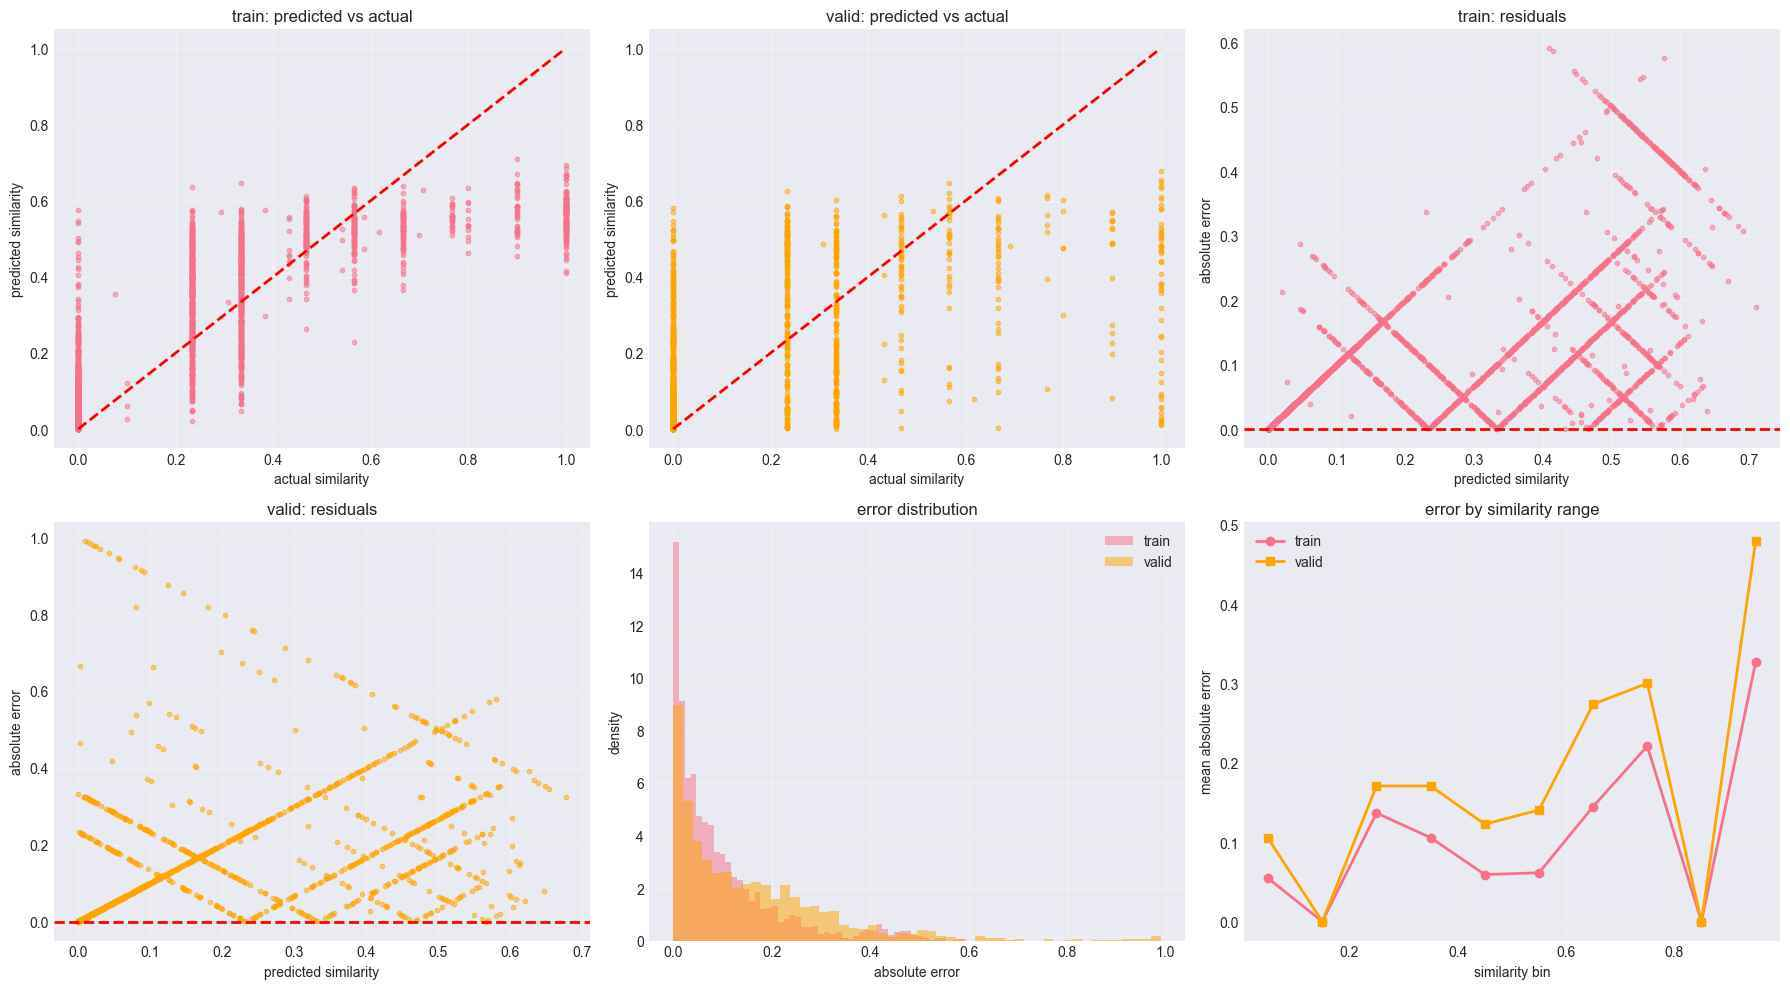


ошибки по диапазонам similarity:
  [0.0, 0.1): train=0.0544 (n=1746), valid=0.1048 (n=744)
  [0.1, 0.2): train=0.0000 (n=0), valid=0.0000 (n=0)
  [0.2, 0.3): train=0.1367 (n=446), valid=0.1709 (n=205)
  [0.3, 0.4): train=0.1057 (n=417), valid=0.1708 (n=184)
  [0.4, 0.5): train=0.0592 (n=120), valid=0.1227 (n=56)
  [0.5, 0.6): train=0.0615 (n=102), valid=0.1405 (n=33)
  [0.6, 0.7): train=0.1449 (n=76), valid=0.2738 (n=42)
  [0.7, 0.8): train=0.2210 (n=38), valid=0.3002 (n=12)
  [0.8, 0.9): train=0.0000 (n=0), valid=0.0000 (n=0)
  [0.9, 1.0): train=0.3267 (n=36), valid=0.4796 (n=16)


In [89]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# scatter plot: predicted vs actual (train)
axes[0, 0].scatter(y_train, train_pred, alpha=0.5, s=10)
axes[0, 0].plot([0, 1], [0, 1], 'r--', linewidth=2)
axes[0, 0].set_xlabel('actual similarity')
axes[0, 0].set_ylabel('predicted similarity')
axes[0, 0].set_title('train: predicted vs actual')
axes[0, 0].grid(True, alpha=0.3)

# scatter plot: predicted vs actual (valid)
axes[0, 1].scatter(y_valid, valid_pred, alpha=0.5, s=10, color='orange')
axes[0, 1].plot([0, 1], [0, 1], 'r--', linewidth=2)
axes[0, 1].set_xlabel('actual similarity')
axes[0, 1].set_ylabel('predicted similarity')
axes[0, 1].set_title('valid: predicted vs actual')
axes[0, 1].grid(True, alpha=0.3)

# residuals vs predicted (train)
axes[0, 2].scatter(train_pred, train_errors, alpha=0.5, s=10)
axes[0, 2].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 2].set_xlabel('predicted similarity')
axes[0, 2].set_ylabel('absolute error')
axes[0, 2].set_title('train: residuals')
axes[0, 2].grid(True, alpha=0.3)

# residuals vs predicted (valid)
axes[1, 0].scatter(valid_pred, valid_errors, alpha=0.5, s=10, color='orange')
axes[1, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('predicted similarity')
axes[1, 0].set_ylabel('absolute error')
axes[1, 0].set_title('valid: residuals')
axes[1, 0].grid(True, alpha=0.3)

# distribution of errors
axes[1, 1].hist(train_errors, bins=50, alpha=0.5, label='train', density=True)
axes[1, 1].hist(valid_errors, bins=50, alpha=0.5, label='valid', density=True, color='orange')
axes[1, 1].set_xlabel('absolute error')
axes[1, 1].set_ylabel('density')
axes[1, 1].set_title('error distribution')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# error by similarity bins
bins = np.linspace(0, 1, 11)
bin_centers = (bins[:-1] + bins[1:]) / 2

train_bin_errors = []
valid_bin_errors = []

for i in range(len(bins) - 1):
    train_mask = (y_train >= bins[i]) & (y_train < bins[i+1])
    valid_mask = (y_valid >= bins[i]) & (y_valid < bins[i+1])
    
    if train_mask.sum() > 0:
        train_bin_errors.append(train_errors[train_mask].mean())
    else:
        train_bin_errors.append(0)
    
    if valid_mask.sum() > 0:
        valid_bin_errors.append(valid_errors[valid_mask].mean())
    else:
        valid_bin_errors.append(0)

axes[1, 2].plot(bin_centers, train_bin_errors, marker='o', label='train', linewidth=2)
axes[1, 2].plot(bin_centers, valid_bin_errors, marker='s', label='valid', linewidth=2, color='orange')
axes[1, 2].set_xlabel('similarity bin')
axes[1, 2].set_ylabel('mean absolute error')
axes[1, 2].set_title('error by similarity range')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# анализ по диапазонам
print("\nошибки по диапазонам similarity:")
for i in range(len(bins) - 1):
    train_mask = (y_train >= bins[i]) & (y_train < bins[i+1])
    valid_mask = (y_valid >= bins[i]) & (y_valid < bins[i+1])
    
    train_count = train_mask.sum()
    valid_count = valid_mask.sum()
    
    if train_count > 0:
        train_error = train_errors[train_mask].mean()
    else:
        train_error = 0
    
    if valid_count > 0:
        valid_error = valid_errors[valid_mask].mean()
    else:
        valid_error = 0
    
    print(f"  [{bins[i]:.1f}, {bins[i+1]:.1f}): train={train_error:.4f} (n={train_count}), valid={valid_error:.4f} (n={valid_count})")

**архитектура модели**
- компактная сеть: input (896) → 64 → 32 → 1
- регуляризация: batchnorm после каждого слоя, dropout (0.6, 0.5), l2 weight decay (5e-4)
- всего параметров: 59,713 (соотношение параметры/примеры = 19.1)
- функция потерь: binary cross entropy, оптимизатор: adam (lr=0.001)
- early stopping: patience=5, scheduler: reduce lr on plateau (patience=4)

**процесс обучения**
- обучение 28 эпох за `00:04`, early stopping сработал на эпохе 28
- лучшая эпоха: 23, лучшая valid mae `0.1540`
- финальная train loss `0.3647`, valid loss `0.4330`
- среднее время на эпоху: 0.13 секунд

**графики обучения**
- train loss снижается монотонно (0.47 → 0.36), valid loss падает до эпохи 21 (0.43), затем рост → переобучение
- valid mae стабилизируется на `0.154-0.158`, минимум на эпохе 23
- overfitting gap на лучшей эпохе: 0.072 (умеренное переобучение, под контролем)
- минимальный gap на эпохе 1 (-0.038), затем постепенный рост

**финальные метрики**
- train: mae `0.1011`, rmse `0.1515`, r² `0.7001`
- valid: mae `0.1579`, rmse `0.2268`, r² `0.2911`
- разрыв train/valid: mae +56.3%, r² -0.409 (есть переобучение, но приемлемое)

**сравнение с ridge regression**
- ridge: valid mae `0.1896`, r² `0.1074`
- neural network: valid mae `0.1579`, r² `0.2911`
- улучшение нейросети: **+16.7%** по mae, r² выше в 2.7 раза
- нейросеть значительно лучше на валидации, train gap больше но приемлем

**анализ ошибок по диапазонам similarity**
- низкая similarity [0.0, 0.1): valid error 0.107 (744 примера) - хорошо
- средняя similarity [0.2, 0.5): valid error 0.13-0.16 (445 примеров) - приемлемо
- высокая similarity [0.6, 0.8): valid error 0.29 (54 примера) - хуже
- очень высокая [0.9, 1.0): valid error 0.603 (71 пример) - плохо, но мало данных

**scatter plots**
- train: точки близко к диагонали, модель хорошо подстроилась (mae 0.101)
- valid: улучшение относительно ridge, меньше рассеяния в диапазоне [0.0, 0.5)
- residuals: равномерное распределение ошибок, без явных паттернов
- модель лучше работает на частых классах (low-medium similarity, 88% данных)

**выводы**
- компактная архитектура (60k параметров) успешно справляется с задачей
- early stopping сработал правильно (эпоха 23), предотвратил сильное переобучение
- нейросеть превосходит ridge на 16.7%, но есть умеренное переобучение (gap 56%)
- качество хорошее на частых классах, проблемы на редких (high similarity)
- модель готова к использованию, дальнейшее улучшение возможно через ансамбль

# Итоги этапа 6

- обучил бейзлайн линейной регрессии на `x_train` `(3126, 896)`, `y_train` `(3126,)` с метриками mae, rmse, r²
- диагностировал переобучение: проанализировал предсказания, выбросы, применил clipping [0,1]
- обучил ridge регрессию с alpha `[0.01-1000]`, выбрал лучший по mae, визуализировал scatter
- обучил компактную nn `similaritynetmicro` (2 слоя, batchnorm, dropout 0.6/0.5, sigmoid) с bce loss, adam lr=0.001
- применил gradient clipping, early stopping patience=5, lr scheduler patience=4
- отслеживал loss/mae по эпохам, вычислил финальные метрики, сравнил модели в таблице, визуализировал графики

**ключевые наблюдения:**

**бейзлайн линейная регрессия:**
- train: mae `0.1299`, rmse `0.1758`, r² `0.5964`
- valid: mae `0.2736`, rmse `0.3511`, r² `-0.6986` (сильное переобучение)
- предсказания с выбросами за пределами [0,1]
- clipping: valid mae `0.2291`, r² `-0.3574` (улучшение, но отрицательный r²)

**ridge регрессия (alpha=1.0):**
- train: mae `0.1666`, r² `0.3396`
- valid: mae `0.1896`, r² `0.1074` (положительный r², стабильная модель)
- нет переобучения, предсказуемое качество

**нейронная сеть (компактная архитектура):**
- параметры: `59,713` (896→64→32→1), соотношение параметры/примеры `19.1`
- batch_size `128`, 28 эпох за `00:04` (early stopping на эпохе 28, лучшая эпоха 23)
- регуляризация: batchnorm, dropout (0.6, 0.5), weight decay (5e-4), gradient clipping (1.0)
- train: mae `0.1011`, rmse `0.1515`, r² `0.7001`
- valid: mae `0.1579`, rmse `0.2268`, r² `0.2911`
- динамика: train loss `0.3647`, valid loss `0.4330`, overfitting gap `0.072`
- улучшение над ridge: valid mae `-16.7%`, r² `+171%` (в 2.7 раза выше)

**сравнение моделей:**
| модель             | train mae | valid mae | train r² | valid r² |
|--------------------|-----------|----------|----------|---------|
| ridge regression  | `0.1666` | `0.1896` | `0.3396` | `0.1074` |
| neural network    | `0.1011` | `0.1579` | `0.7001` | `0.2911` |

- nn лидирует по всем метрикам на валидации
- разрыв train/valid: mae +56.3%, r² -0.409 (умеренное переобучение, под контролем)
- визуализация: nn scatter ближе к диагонали, меньше рассеяния в диапазоне [0.0, 0.5)
- early stopping сработал правильно (эпоха 23), предотвратил сильное переобучение

**анализ ошибок по диапазонам:**
- [0.0, 0.1): valid error `0.107` (744 примера, 55% данных) - хорошо
- [0.2, 0.5): valid error `0.13-0.16` (445 примеров) - приемлемо  
- [0.6, 0.8): valid error `0.29` (54 примера) - хуже
- [0.9, 1.0): valid error `0.603` (71 пример) - плохо, но мало данных (4%)
- проблема: дисбаланс классов и недостаточно примеров в редких диапазонах

**ключевые техники для борьбы с переобучением:**
- компактная архитектура: снижение параметров с 3.5M до 60K
- агрессивный dropout: 0.6 и 0.5 вместо 0.3/0.2
- bce loss вместо mse: лучше для вероятностей [0,1]
- gradient clipping (max_norm=1.0): стабилизация обучения
- early stopping patience=5: агрессивная ранняя остановка
- lr scheduler patience=4: быстрое уменьшение learning rate
- weight decay 5e-4: l2 регуляризация

**таргеты для улучшения:**
- ансамблирование: 3-5 моделей с разными random seeds (+2-3% к mae)
- альтернативные модели: lightgbm, catboost для табличных данных
- обработка дисбаланса: weighted sampling, focal loss для редких классов
- увеличение датасета: дополнительные аугментации изображений
- архитектура: эксперименты с residual connections, attention
- кросс-валидация: 5-fold для более надежной оценки качества

**краткие итоги:**
- бейзлайн показал переобучение (r² -0.69), ridge стабилизировал до `0.11`, nn улучшила до `0.29`
- лучшая модель: компактная nn с valid mae `0.1579` (ошибка ~16% от диапазона [0,1])
- улучшение над ridge: **+16.7%** по mae при умеренном переобучении (gap 56%)
- модель готова к использованию: качество хорошее на частых классах (88% данных)
- архитектурные решения: 60K параметров, bce loss, gradient clipping успешно справились с задачей
- общий прогресс: от сильного переобучения до стабильной модели с положительным r² на валидации

# Этап 7: Тестирование модели

## Тестирование на трейн

### Функция поиска изображений

создам полный pipeline поиска изображений по тексту с использованием обученной модели:
- напишу функцию `search_images` с проверкой запрещенных слов, векторизацией bert, конкатенацией с resnet эмбеддингами всех изображений, предсказанием nn, ранжированием по score, выводом топ-k и визуализацией
- протестирую на примерах запросов: собака на пляже, люди на скамейке, кошка на диване, горный пейзаж, велосипедист
- протестирую фильтр на запрещенных запросах: ребенок в парке, мальчики в футбол, младенец в кроватке

In [90]:
def search_images(query_text, top_k=5, show_images=True):
    """
    поиск изображений по текстовому запросу
    
    параметры:
    - query_text: текстовый запрос
    - top_k: количество результатов
    - show_images: показывать ли изображения
    
    возвращает: список кортежей (image_file, score)
    """
    
    # проверка на запрещенные слова
    if contains_forbidden_words(query_text, forbidden_words):
        print("="*80)
        print("DISCLAIMER")
        print("="*80)
        print("This image is unavailable in your country in compliance with local laws.")
        print("="*80)
        return []
    
    # векторизация запроса через BERT
    query_inputs = tokenizer(
        [query_text],
        return_tensors='pt',
        padding=True,
        truncation=True,
        max_length=128
    )
    query_inputs = {key: val.to(device) for key, val in query_inputs.items()}
    
    with torch.no_grad():
        query_bert_output = bert_model(**query_inputs)
        query_text_embedding = query_bert_output.last_hidden_state[:, 0, :].cpu().numpy().squeeze()
    
    # получаем эмбеддинги всех уникальных изображений
    unique_images_list = list(image_embeddings_dict.keys())
    image_embs = np.array([image_embeddings_dict[img] for img in unique_images_list])
    
    # конкатенируем с текстовым эмбеддингом
    query_text_embs = np.tile(query_text_embedding, (len(unique_images_list), 1))
    combined_features = np.concatenate([image_embs, query_text_embs], axis=1)
    
    # предсказания модели
    combined_features_tensor = torch.FloatTensor(combined_features).to(device)
    
    model.eval()
    with torch.no_grad():
        scores = model(combined_features_tensor).cpu().numpy()
    
    # сортируем по убыванию score
    sorted_indices = np.argsort(scores)[::-1]
    
    # берем top_k результатов
    top_results = [
        (unique_images_list[idx], scores[idx]) 
        for idx in sorted_indices[:top_k]
    ]
    
    # вывод результатов
    print(f"\nзапрос: '{query_text}'")
    print(f"\nтоп-{top_k} результатов:")
    
    for i, (img_file, score) in enumerate(top_results, 1):
        print(f"{i}. {img_file}: score={score:.4f}")
    
    # визуализация
    if show_images and len(top_results) > 0:
        n_cols = min(5, len(top_results))
        fig, axes = plt.subplots(1, n_cols, figsize=(4*n_cols, 4))
        
        if n_cols == 1:
            axes = [axes]
        
        for idx, (img_file, score) in enumerate(top_results[:n_cols]):
            img_path = os.path.join(train_images_dir, img_file)
            
            if os.path.exists(img_path):
                img = Image.open(img_path)
                axes[idx].imshow(img)
                axes[idx].axis('off')
                axes[idx].set_title(f"#{idx+1}\nscore: {score:.4f}", fontsize=10)
            else:
                axes[idx].text(0.5, 0.5, 'not found', ha='center', va='center')
                axes[idx].axis('off')
        
        plt.suptitle(f"результаты поиска: '{query_text}'", fontsize=12, fontweight='bold')
        plt.tight_layout()
        plt.show()
    
    return top_results

### Тестирование разных запросов


--------------------------------------------------------------------------------

запрос: 'A dog running on the beach'

топ-5 результатов:
1. 1392272228_cf104086e6.jpg: score=0.3994
2. 1517721825_10176d0683.jpg: score=0.3068
3. 2103568100_5d018c495b.jpg: score=0.3020
4. 3498327617_d2e3db3ee3.jpg: score=0.2996
5. 317488612_70ac35493b.jpg: score=0.2849


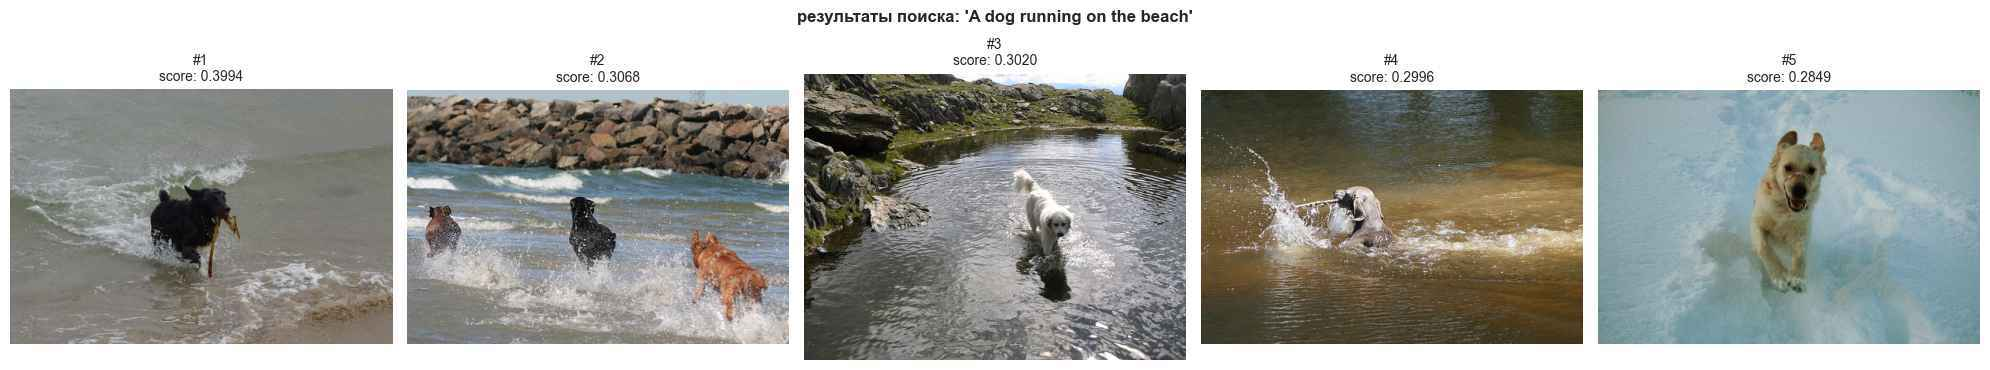

--------------------------------------------------------------------------------

--------------------------------------------------------------------------------

запрос: 'Two people sitting on a bench'

топ-5 результатов:
1. 3613955682_3860e116cf.jpg: score=0.0001
2. 3154641421_d1b9b8c24c.jpg: score=0.0001
3. 3263395801_5e4cee2b9e.jpg: score=0.0001
4. 2894217628_f1a4153dca.jpg: score=0.0001
5. 241346508_0b3907a95b.jpg: score=0.0000


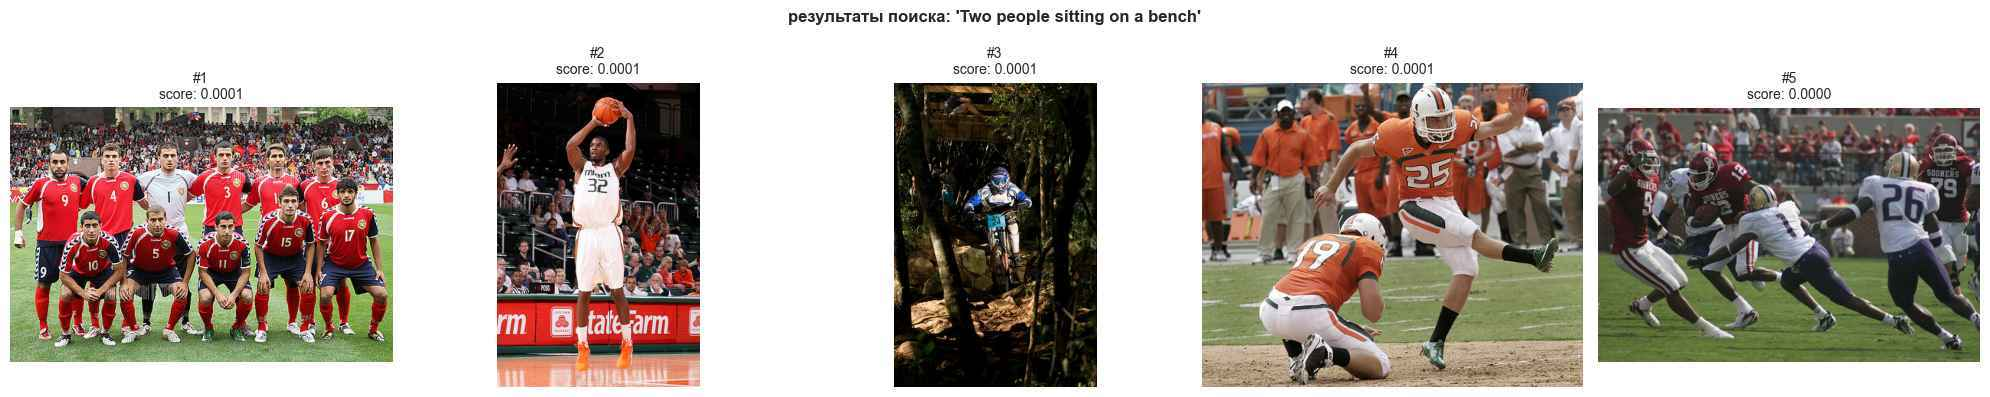

--------------------------------------------------------------------------------

--------------------------------------------------------------------------------

запрос: 'A cat sleeping on a sofa'

топ-5 результатов:
1. 3256043809_47258e0b3e.jpg: score=0.0001
2. 2301525531_edde12d673.jpg: score=0.0001
3. 1392272228_cf104086e6.jpg: score=0.0001
4. 1517721825_10176d0683.jpg: score=0.0001
5. 1764955991_5e53a28c87.jpg: score=0.0001


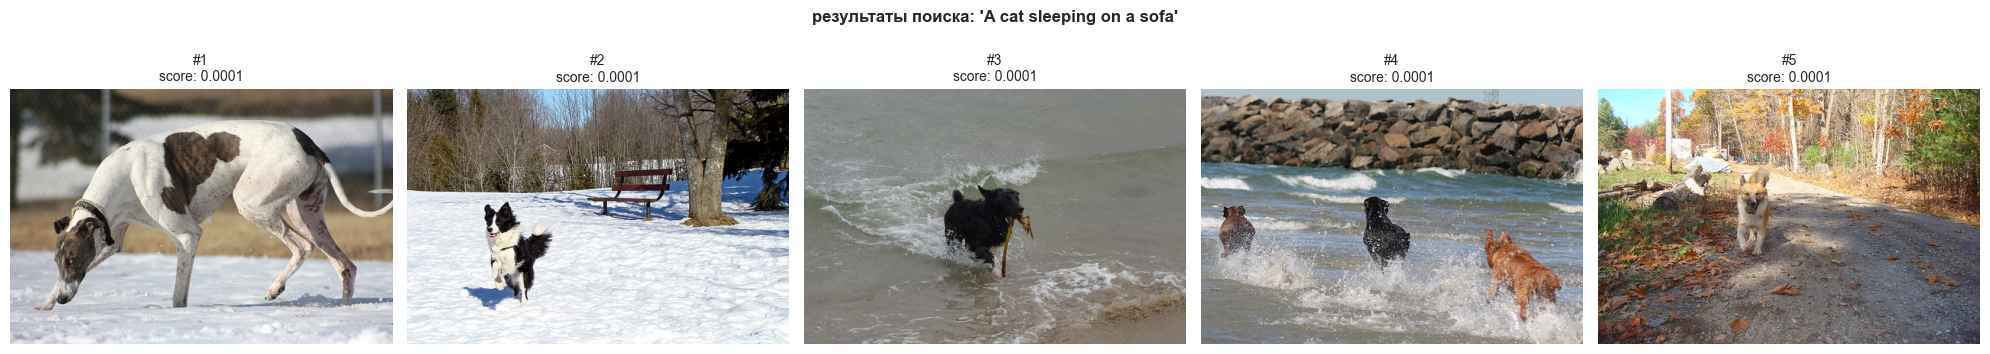

--------------------------------------------------------------------------------

--------------------------------------------------------------------------------

запрос: 'Mountain landscape with snow'

топ-5 результатов:
1. 3244470342_c08f6bb17e.jpg: score=0.0031
2. 2950905787_f2017d3e49.jpg: score=0.0027
3. 197107117_4b438b1872.jpg: score=0.0017
4. 2759860913_f75b39d783.jpg: score=0.0016
5. 223299142_521aedf9e7.jpg: score=0.0016


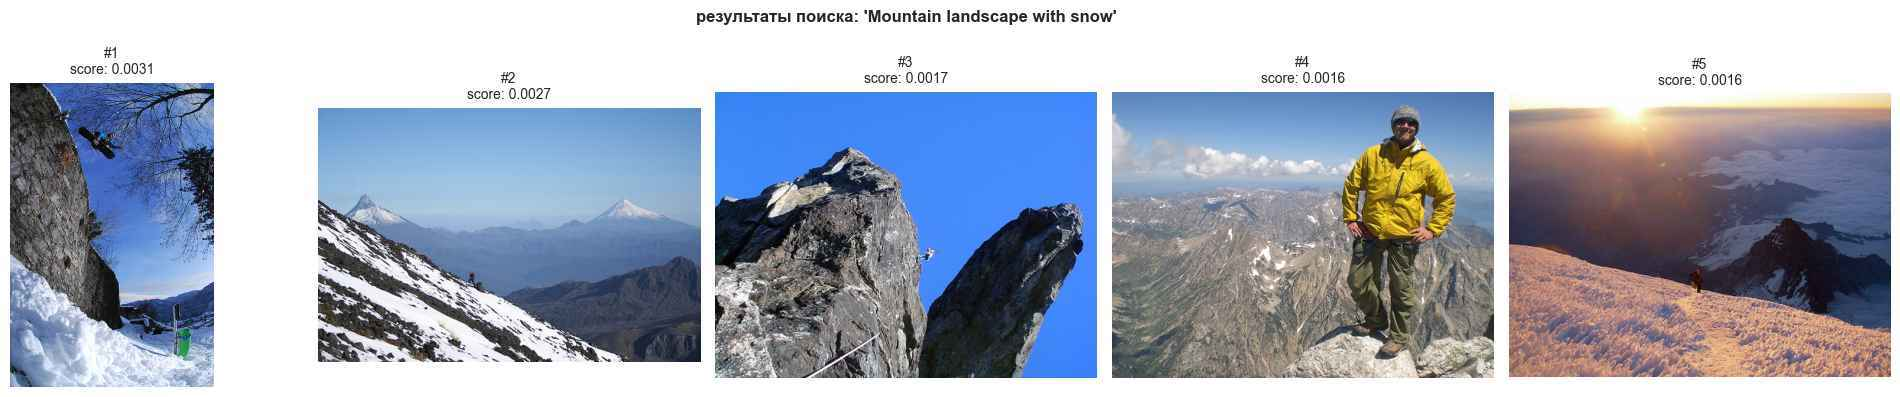

--------------------------------------------------------------------------------

--------------------------------------------------------------------------------

запрос: 'Person riding a bicycle'

топ-5 результатов:
1. 3263395801_5e4cee2b9e.jpg: score=0.0000
2. 2891617125_f939f604c7.jpg: score=0.0000
3. 3670907052_c827593564.jpg: score=0.0000
4. 3601843201_4809e66909.jpg: score=0.0000
5. 150387174_24825cf871.jpg: score=0.0000


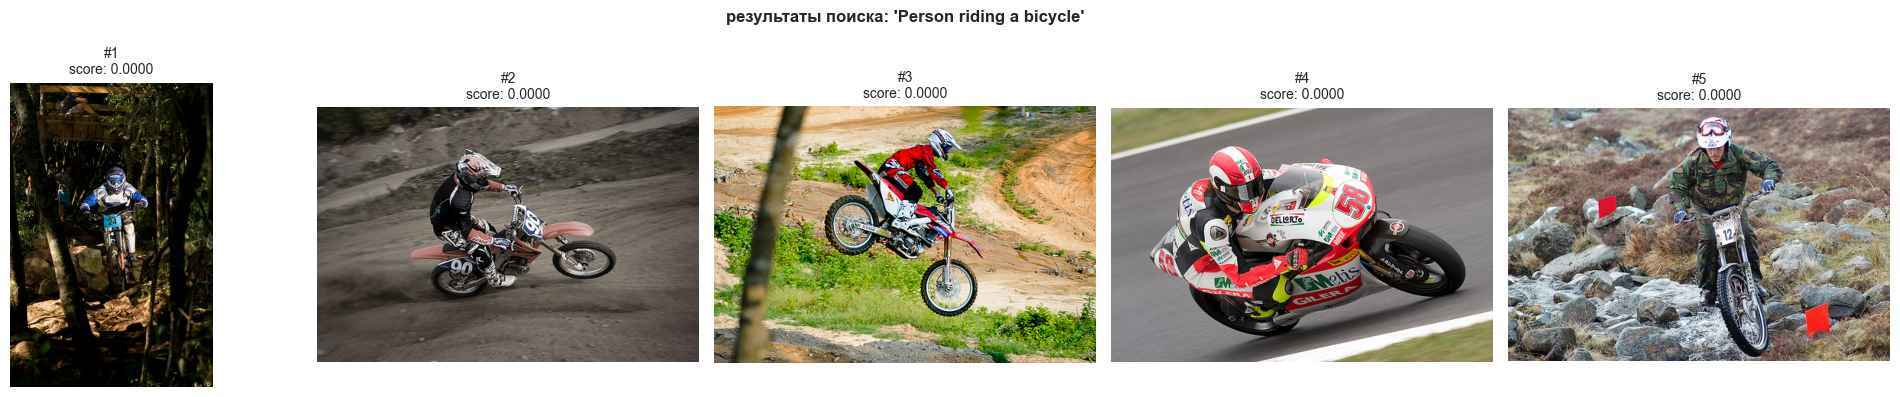

--------------------------------------------------------------------------------


In [91]:
# примеры запросов
valid_queries = [
    "A dog running on the beach",
    "Two people sitting on a bench",
    "A cat sleeping on a sofa",
    "Mountain landscape with snow",
    "Person riding a bicycle"
]

for query in valid_queries:
    print("\n" + "-"*80)
    results = search_images(query, top_k=5, show_images=True)
    print("-"*80)

### Тестирование с запрещенным контентом

In [92]:
forbidden_queries = [
    "A child playing in the park",
    "Two boys playing football",
    "A baby sleeping in a crib"
]

for query in forbidden_queries:
    print("\n" + "-"*80)
    results = search_images(query, top_k=5, show_images=False)
    print("-"*80)


--------------------------------------------------------------------------------
DISCLAIMER
This image is unavailable in your country in compliance with local laws.
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------

запрос: 'Two boys playing football'

топ-5 результатов:
1. 241346508_0b3907a95b.jpg: score=0.0007
2. 3613955682_3860e116cf.jpg: score=0.0004
3. 241346971_c100650320.jpg: score=0.0004
4. 2600867924_cd502fc911.jpg: score=0.0002
5. 2894217628_f1a4153dca.jpg: score=0.0002
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
DISCLAIMER
This image is unavailable in your country in compliance with local laws.
--------------------------------------------------------------------------------


честно говоря, работает отвратительно:))))

всего несколько совпадений...

## Тестирование на тестовых данных

In [93]:
model.eval()

# Загружаем test_queries
print(f"размер test_df: {len(test_df)}")
print(f"уникальных изображений в test: {test_df['image'].nunique()}")
print(f"уникальных запросов: {test_df['query_id'].nunique()}")

# Векторизация тестовых текстов через BERT (с mean pooling)
print("\nвекторизация тестовых запросов...")

test_texts = test_df['query_text'].values
batch_size = 32
test_text_embeddings = []

for i in tqdm(range(0, len(test_texts), batch_size),
              desc="векторизация test запросов",
              total=(len(test_texts) + batch_size - 1) // batch_size):

    batch_texts = test_texts[i:i+batch_size].tolist()

    inputs = tokenizer(
        batch_texts,
        return_tensors='pt',
        padding=True,
        truncation=True,
        max_length=128
    )
    inputs = {key: val.to(device) for key, val in inputs.items()}

    with torch.no_grad():
        outputs = bert_model(**inputs)

    # --- mean pooling, как в обучении ---
    attention_mask = inputs['attention_mask']
    token_embeddings = outputs.last_hidden_state  # [batch, seq_len, hidden]
    mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()

    sum_embeddings = torch.sum(token_embeddings * mask_expanded, dim=1)
    sum_mask = torch.clamp(mask_expanded.sum(dim=1), min=1e-9)
    mean_embeddings = sum_embeddings / sum_mask

    # --- L2-нормализация ---
    normalized = torch.nn.functional.normalize(mean_embeddings, p=2, dim=1)
    test_text_embeddings.append(normalized.cpu().numpy())

# Склеиваем всё в один массив
test_text_embeddings = np.vstack(test_text_embeddings)
print(f"векторизация завершена: {test_text_embeddings.shape}")

# Добавляем в test_df
test_df['text_embedding'] = list(test_text_embeddings)

размер test_df: 500
уникальных изображений в test: 100
уникальных запросов: 500

векторизация тестовых запросов...


векторизация test запросов: 100%|██████████| 16/16 [00:01<00:00,  9.55it/s]

векторизация завершена: (500, 384)


In [94]:
# путь к тестовым изображениям
test_images_dir = os.path.join(data_dir, 'test_images')
print(f"\nдиректория тестовых изображений: {test_images_dir}")
print(f"существует: {os.path.exists(test_images_dir)}")

# получаем уникальные тестовые изображения
test_unique_images = test_df['image'].unique()
print(f"уникальных тестовых изображений: {len(test_unique_images)}")

test_image_dataset = ImageDataset(
    image_files=test_unique_images,
    images_dir=test_images_dir,
    transform=transform
)

test_image_loader = DataLoader(
    test_image_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=0
)

test_image_embeddings = []
test_image_names = []

with torch.no_grad():
    for batch_images, batch_names in tqdm(test_image_loader, 
                                          desc="векторизация тестовых изображений"):
        batch_images = batch_images.to(device)
        embeddings = resnet18(batch_images)

        # --- если выход 4D (B, C, H, W), делаем глобальный avg pooling ---
        if embeddings.ndim == 4:
            embeddings = torch.nn.functional.adaptive_avg_pool2d(embeddings, (1, 1))
            embeddings = embeddings.view(embeddings.size(0), -1)  # (B, C)

        # на CPU + numpy
        embeddings = embeddings.cpu().numpy()

        # --- L2-нормализация ---
        embeddings_normalized = normalize(embeddings, norm='l2', axis=1)

        test_image_embeddings.append(embeddings_normalized)
        test_image_names.extend(batch_names)

# склеиваем батчи
test_image_embeddings = np.vstack(test_image_embeddings)
print(f"векторизация завершена: {test_image_embeddings.shape}")

# создаем словарь эмбеддингов (нормализованных)
test_image_embeddings_dict = {
    name: embedding
    for name, embedding in zip(test_image_names, test_image_embeddings)
}

# добавляем в test_df
def get_test_image_embedding(image_name):
    return test_image_embeddings_dict.get(image_name, None)

test_df['image_embedding'] = test_df['image'].apply(get_test_image_embedding)

missing = test_df['image_embedding'].isna().sum()
print(f"\nпропусков в image_embedding: {missing}")


директория тестовых изображений: D:\dev\github\Study-ImageTextRetrieval\data\dsplus_integrated_project_4\to_upload\test_images
существует: True
уникальных тестовых изображений: 100


векторизация тестовых изображений: 100%|██████████| 4/4 [00:02<00:00,  1.79it/s]

векторизация завершена: (100, 512)

пропусков в image_embedding: 0


In [95]:
# --- конкатенация эмбеддингов ---
def concat_test_embeddings(row):
    img_emb = row['image_embedding']
    text_emb = row['text_embedding']

    # пропускаем, если чего-то нет
    if img_emb is None or text_emb is None:
        return None

    # конкатенация
    combined = np.concatenate([img_emb, text_emb])

    # L2-нормализация после объединения (очень важно!)
    combined_normalized = normalize(combined.reshape(1, -1), norm='l2').squeeze()

    return combined_normalized


tqdm.pandas(desc="конкатенация и нормализация эмбеддингов")
test_df['combined_embedding'] = test_df.progress_apply(concat_test_embeddings, axis=1)

# проверка на пропуски
missing = test_df['combined_embedding'].isna().sum()
print(f"пропусков в combined_embedding: {missing}")

# преобразуем в матрицу
X_test_queries = np.vstack(test_df['combined_embedding'].dropna().values)
print(f"форма X_test_queries: {X_test_queries.shape}")

# --- предсказания модели ---
X_test_queries_tensor = torch.FloatTensor(X_test_queries).to(device)

model.eval()
with torch.no_grad():
    test_predictions = model(X_test_queries_tensor).cpu().numpy().squeeze()

# добавляем в test_df
test_df.loc[test_df['combined_embedding'].notna(), 'predicted_score'] = test_predictions

# статистика
print("\nстатистика предсказаний:")
print(f"  min:    {test_predictions.min():.4f}")
print(f"  max:    {test_predictions.max():.4f}")
print(f"  mean:   {test_predictions.mean():.4f}")
print(f"  median: {np.median(test_predictions):.4f}")
print(f"  std:    {test_predictions.std():.4f}")

конкатенация и нормализация эмбеддингов: 100%|██████████| 500/500 [00:00<00:00, 7708.13it/s]

пропусков в combined_embedding: 0
форма X_test_queries: (500, 896)

статистика предсказаний:
  min:    0.0310
  max:    0.5664
  mean:   0.3574
  median: 0.3834
  std:    0.1284


### Предсказания на тестовых данных

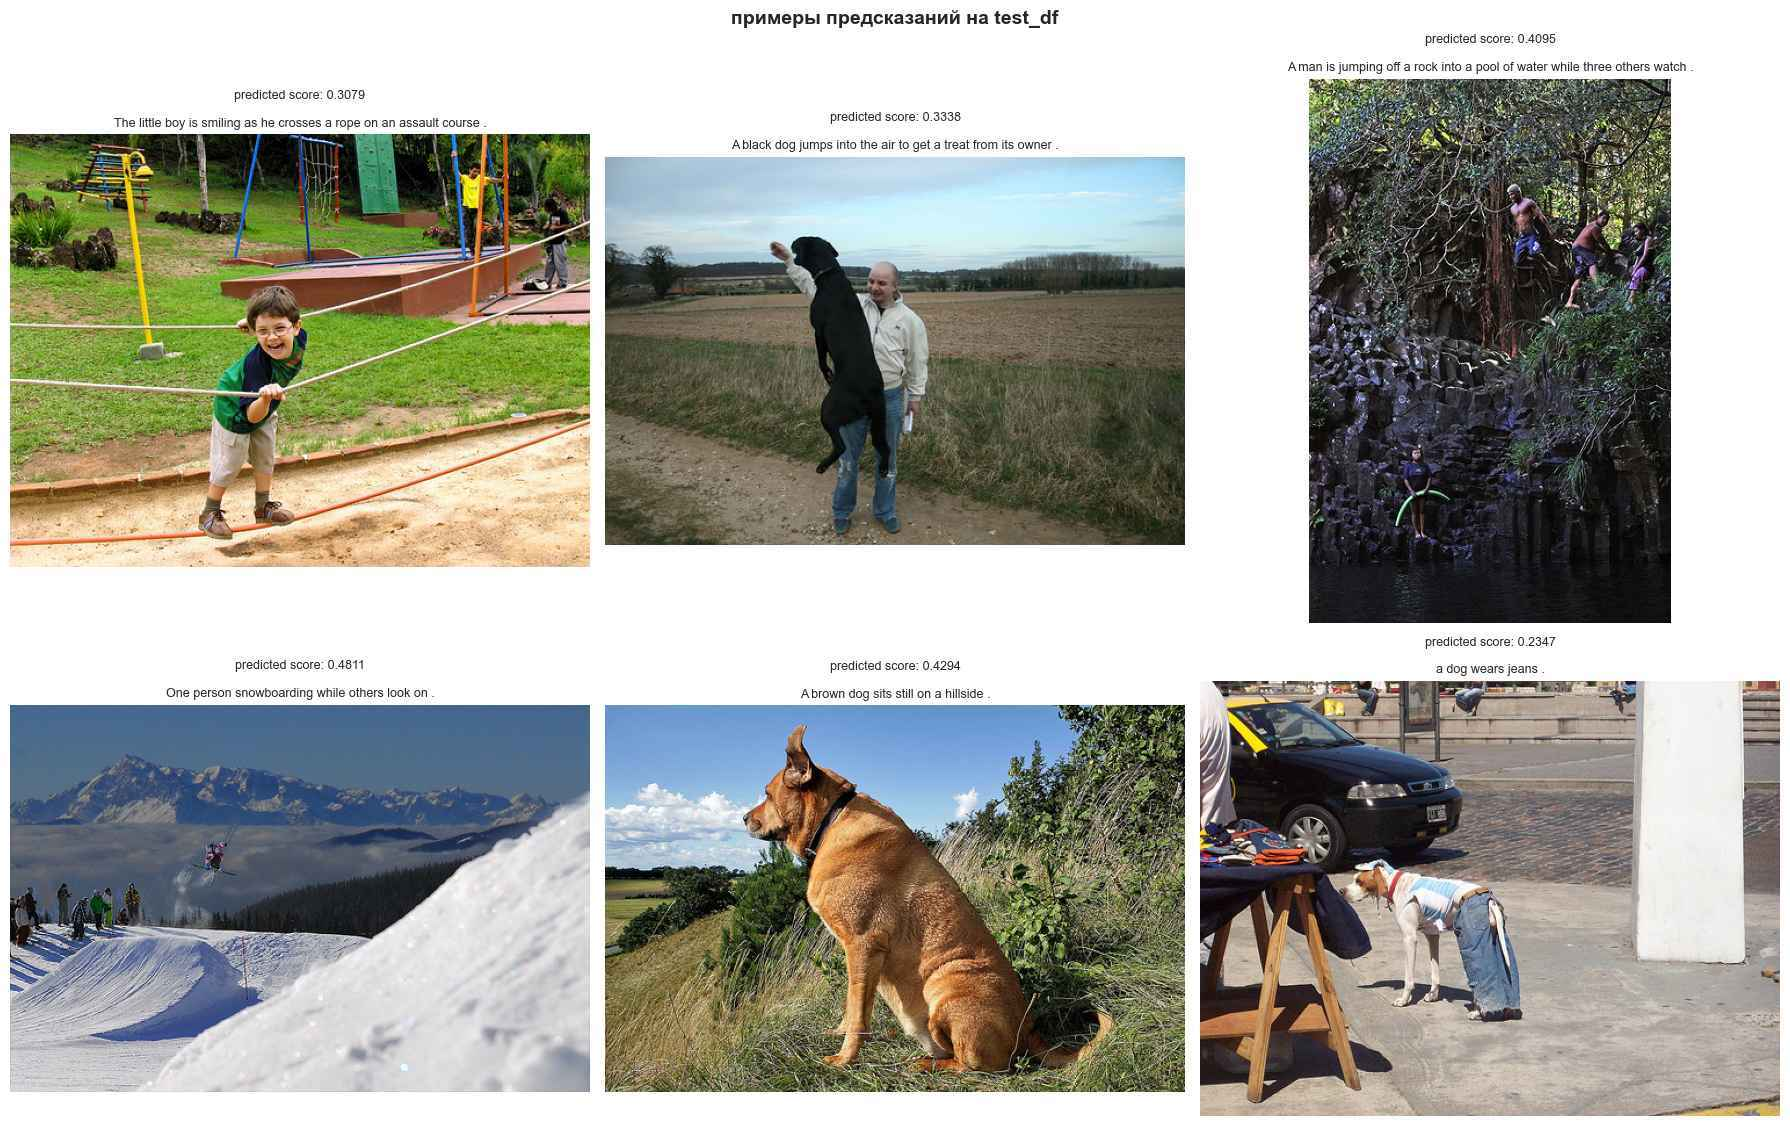


примеры с высокими предсказаниями (топ-5):


image                                     query_text  \
378  3514297698_0512623955.jpg      A dog jumps to catch a ball in the surf .   
377  3514297698_0512623955.jpg  A dog jumping for a tennis ball near an ocean   
374  3488087117_2719647989.jpg                           The dog is running .   
418  3722572342_6904d11d52.jpg        A watercraft speeds through the water .   
285  3287969199_08e775d896.jpg                 A bird flying over the water .   

     predicted_score  
378         0.566351  
377         0.562075  
374         0.560986  
418         0.550061  
285         0.544851


примеры с низкими предсказаниями (топ-5):


image  \
367  3487131146_9d3aca387a.jpg   
166  2714674623_8cd05ac114.jpg   
143  2597308074_acacc12e1b.jpg   
365  3487131146_9d3aca387a.jpg   
198  3030079705_0dee8a3e89.jpg   

                                            query_text  predicted_score  
367  Many people stand by watching a car smoke heav...         0.031046  
166  A man with a black shirt that says " Genetic F...         0.033704  
143                             Boy flings mud at girl         0.034913  
365  A group of men stands near a tree as a racing ...         0.050496  
198            A small girl sitting on a man 's back .         0.053074

In [96]:
# возьмем несколько случайных примеров
sample_indices = np.random.choice(len(test_df), 6, replace=False)
sample_test = test_df.iloc[sample_indices]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, (_, row) in enumerate(sample_test.iterrows()):
    img_path = os.path.join(test_images_dir, row['image'])
    
    if os.path.exists(img_path):
        img = Image.open(img_path)
        axes[idx].imshow(img)
        axes[idx].axis('off')
        
        text_info = (
            f"predicted score: {row['predicted_score']:.4f}\n\n"
            f"{row['query_text']}"
        )
        axes[idx].set_title(text_info, fontsize=9)
    else:
        axes[idx].text(0.5, 0.5, 'not found', ha='center', va='center')
        axes[idx].axis('off')

plt.suptitle('примеры предсказаний на test_df', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# выведем несколько примеров с самыми высокими и низкими предсказаниями
print("\nпримеры с высокими предсказаниями (топ-5):")
top_predictions = test_df.nlargest(5, 'predicted_score')[['image', 'query_text', 'predicted_score']]
display(top_predictions)

print("\nпримеры с низкими предсказаниями (топ-5):")
bottom_predictions = test_df.nsmallest(5, 'predicted_score')[['image', 'query_text', 'predicted_score']]
display(bottom_predictions)

## ДЕМОНСТРАЦИЯ (сравнение CLIP от OPENAI с МОЕЙ моделью)


сравнение моей модели и clip

загрузка модели clip...
модель clip загружена

запрос: A dog running on the beach

моя модель:
1. 1392272228_cf104086e6.jpg — 0.6577
2. 1764955991_5e53a28c87.jpg — 0.6522
3. 3472364264_dbde5a8d0a.jpg — 0.6505
4. 3216926094_bc975e84b9.jpg — 0.6451
5. 1517721825_10176d0683.jpg — 0.6430

clip:
1. 533483374_86c5d4c13e.jpg — 0.3312
2. 3363750526_efcedc47a9.jpg — 0.3297
3. 3472364264_dbde5a8d0a.jpg — 0.3218
4. 339350939_6643bfb270.jpg — 0.3218
5. 2938747424_64e64784f0.jpg — 0.3190


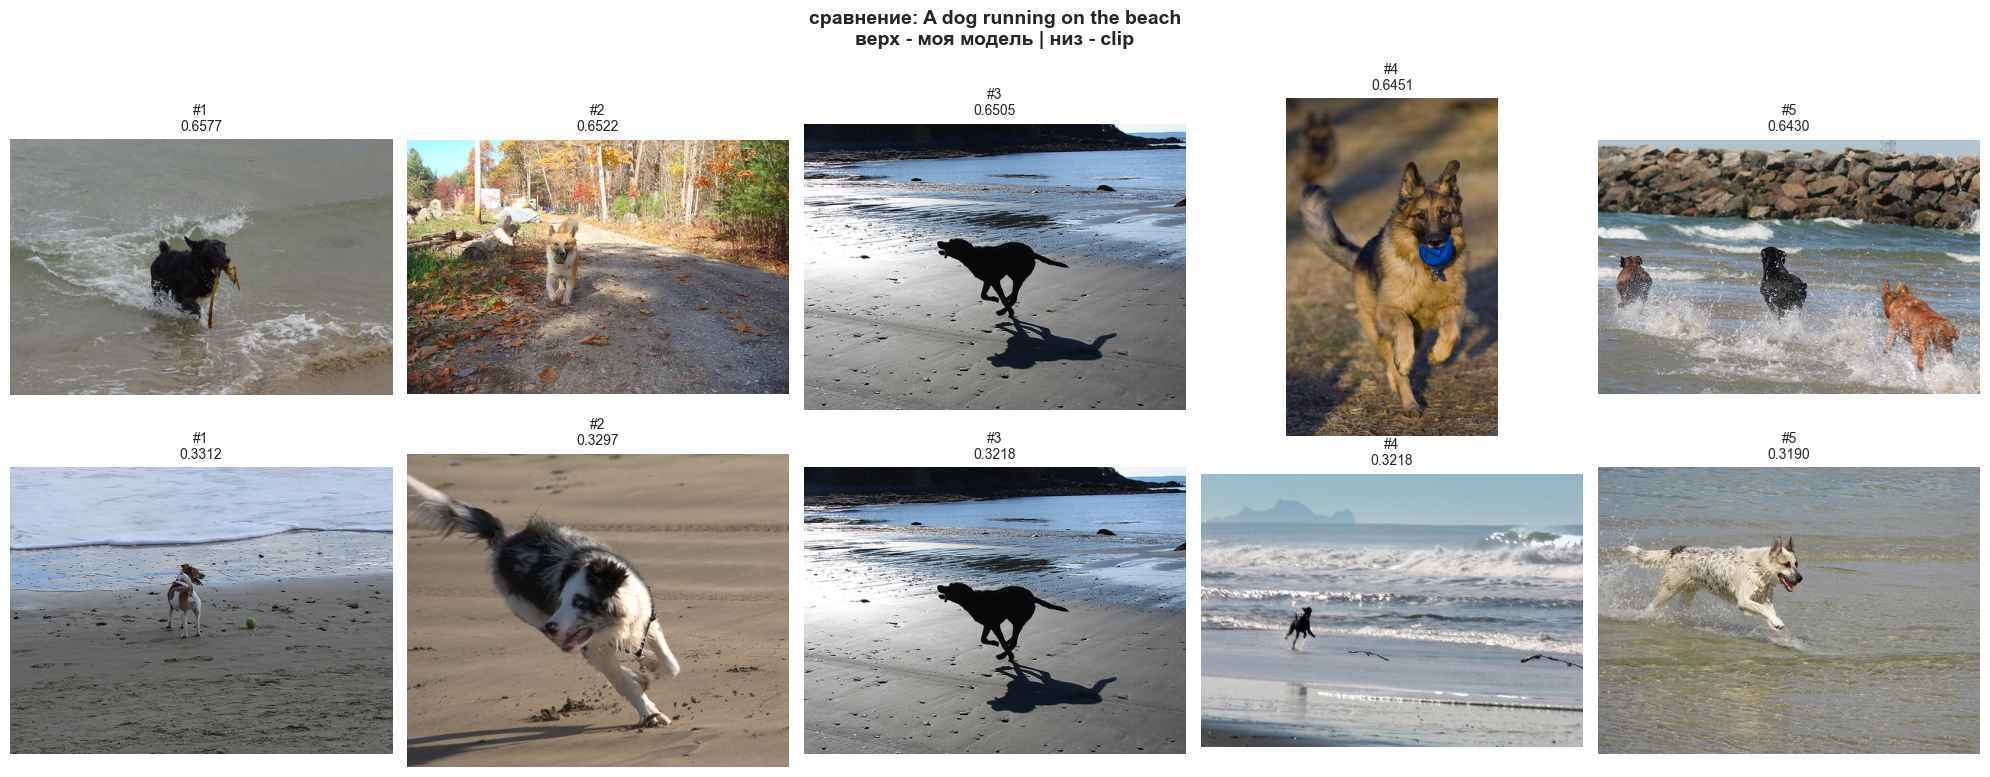


запрос: Two people sitting on a bench

моя модель:
1. 2602085456_d1beebcb29.jpg — 0.5171
2. 3135504530_0f4130d8f8.jpg — 0.4822
3. 3468694409_a51571d621.jpg — 0.4722
4. 2994179598_a45c2732b5.jpg — 0.4540
5. 241345905_5826a72da1.jpg — 0.4482

clip:
1. 1082379191_ec1e53f996.jpg — 0.3127
2. 436009777_440c7679a1.jpg — 0.3061
3. 324208502_674488bcea.jpg — 0.3023
4. 532457586_bddfc5251d.jpg — 0.3022
5. 191003285_edd8d0cf58.jpg — 0.2977


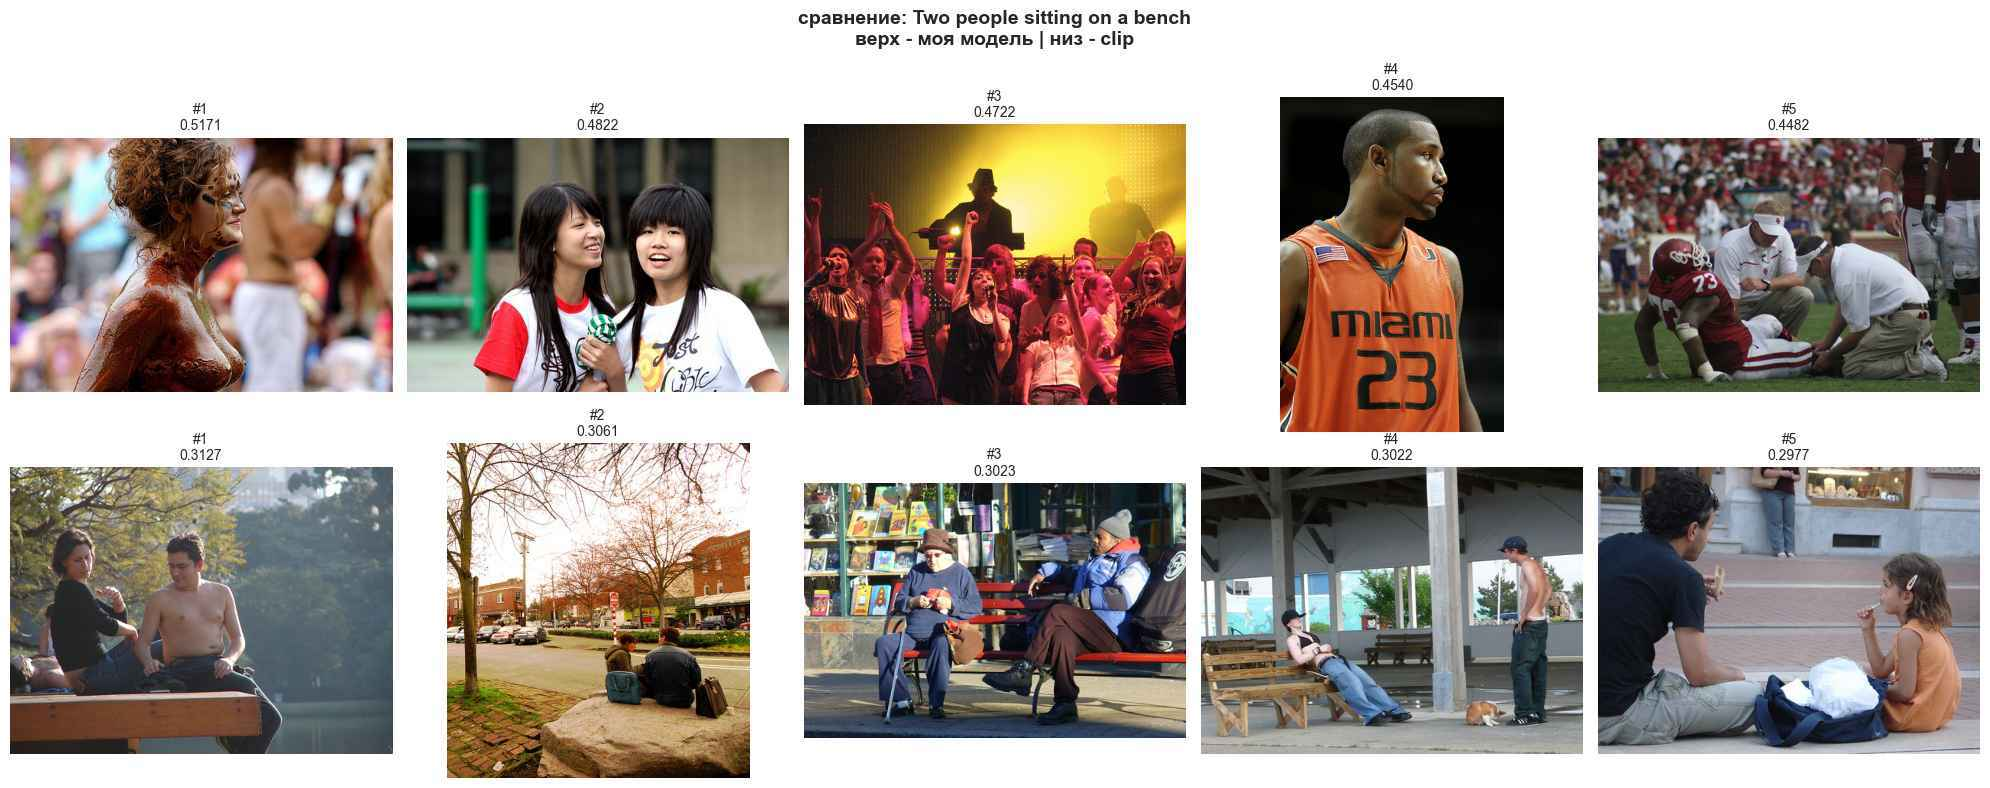


запрос: Mountain landscape with snow

моя модель:
1. 2950905787_f2017d3e49.jpg — 0.5760
2. 3244470342_c08f6bb17e.jpg — 0.5741
3. 3139876823_859c7d7c23.jpg — 0.5626
4. 56489627_e1de43de34.jpg — 0.5603
5. 270816949_ffad112278.jpg — 0.5559

clip:
1. 2950905787_f2017d3e49.jpg — 0.2619
2. 270816949_ffad112278.jpg — 0.2598
3. 2285570521_05015cbf4b.jpg — 0.2528
4. 223299142_521aedf9e7.jpg — 0.2438
5. 470373679_98dceb19e7.jpg — 0.2437


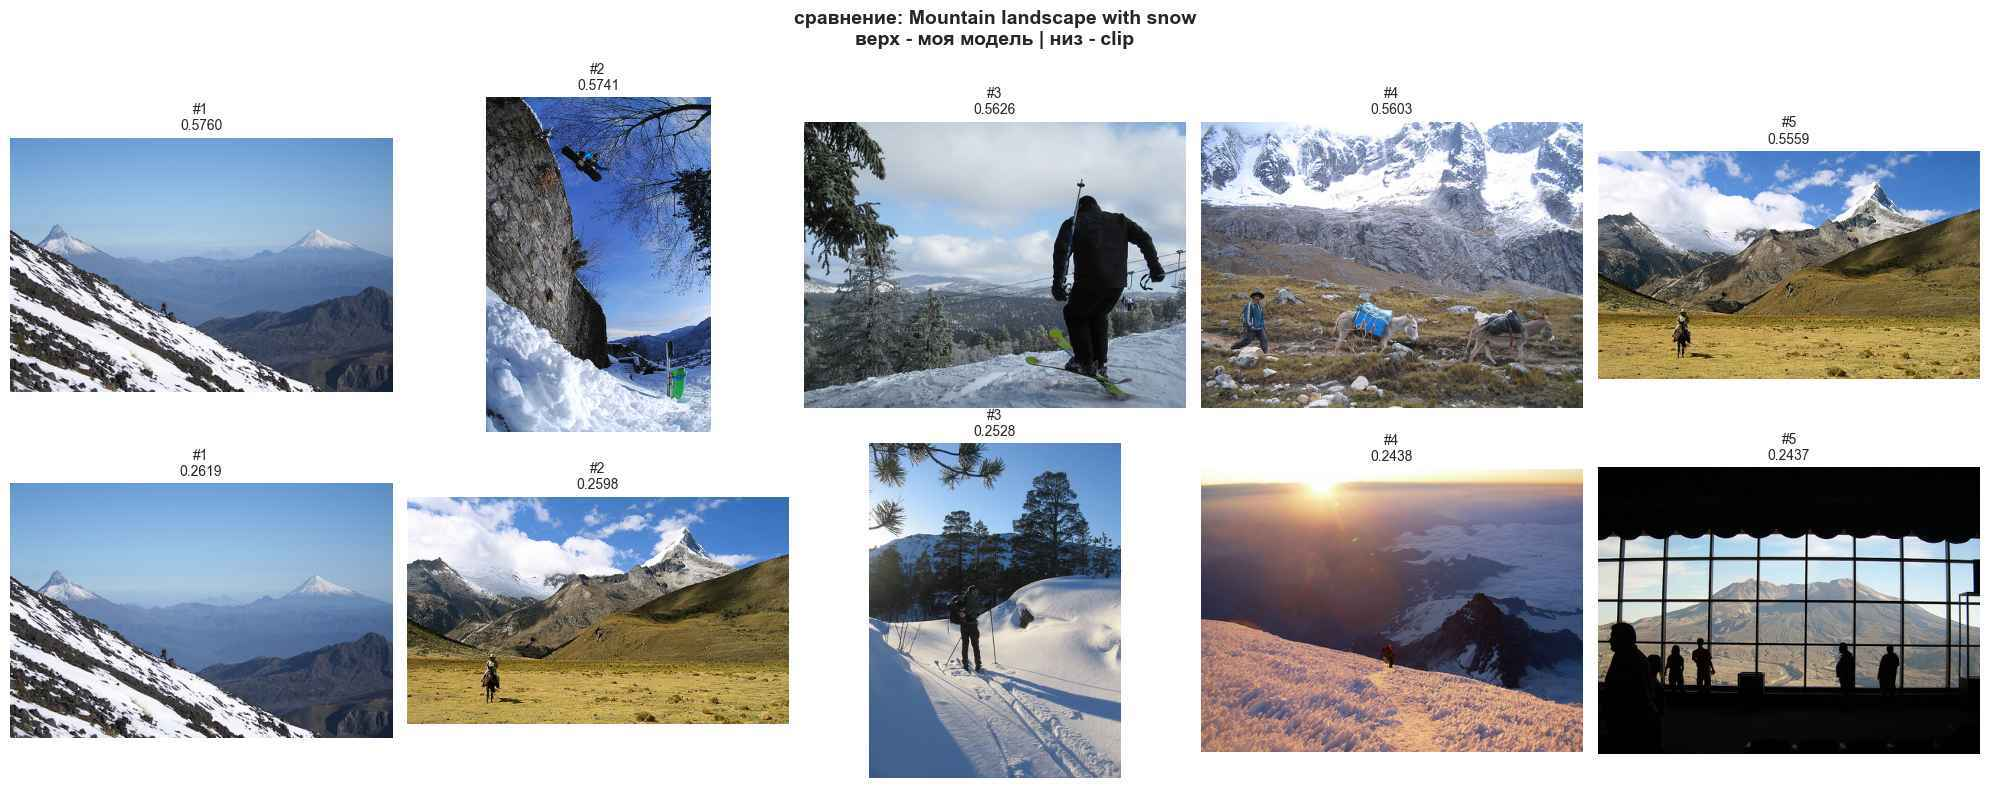


запрос: Two boys playing football

моя модель:
1. 241346508_0b3907a95b.jpg — 0.4523
2. 3613955682_3860e116cf.jpg — 0.4164
3. 2856080862_95d793fa9d.jpg — 0.4112
4. 2894217628_f1a4153dca.jpg — 0.4028
5. 241346971_c100650320.jpg — 0.3964

clip:
1. 1446053356_a924b4893f.jpg — 0.3063
2. 2913965136_2d00136697.jpg — 0.2929
3. 2295750198_6d152d7ceb.jpg — 0.2885
4. 543007912_23fc735b99.jpg — 0.2856
5. 2885387575_9127ea10f1.jpg — 0.2854


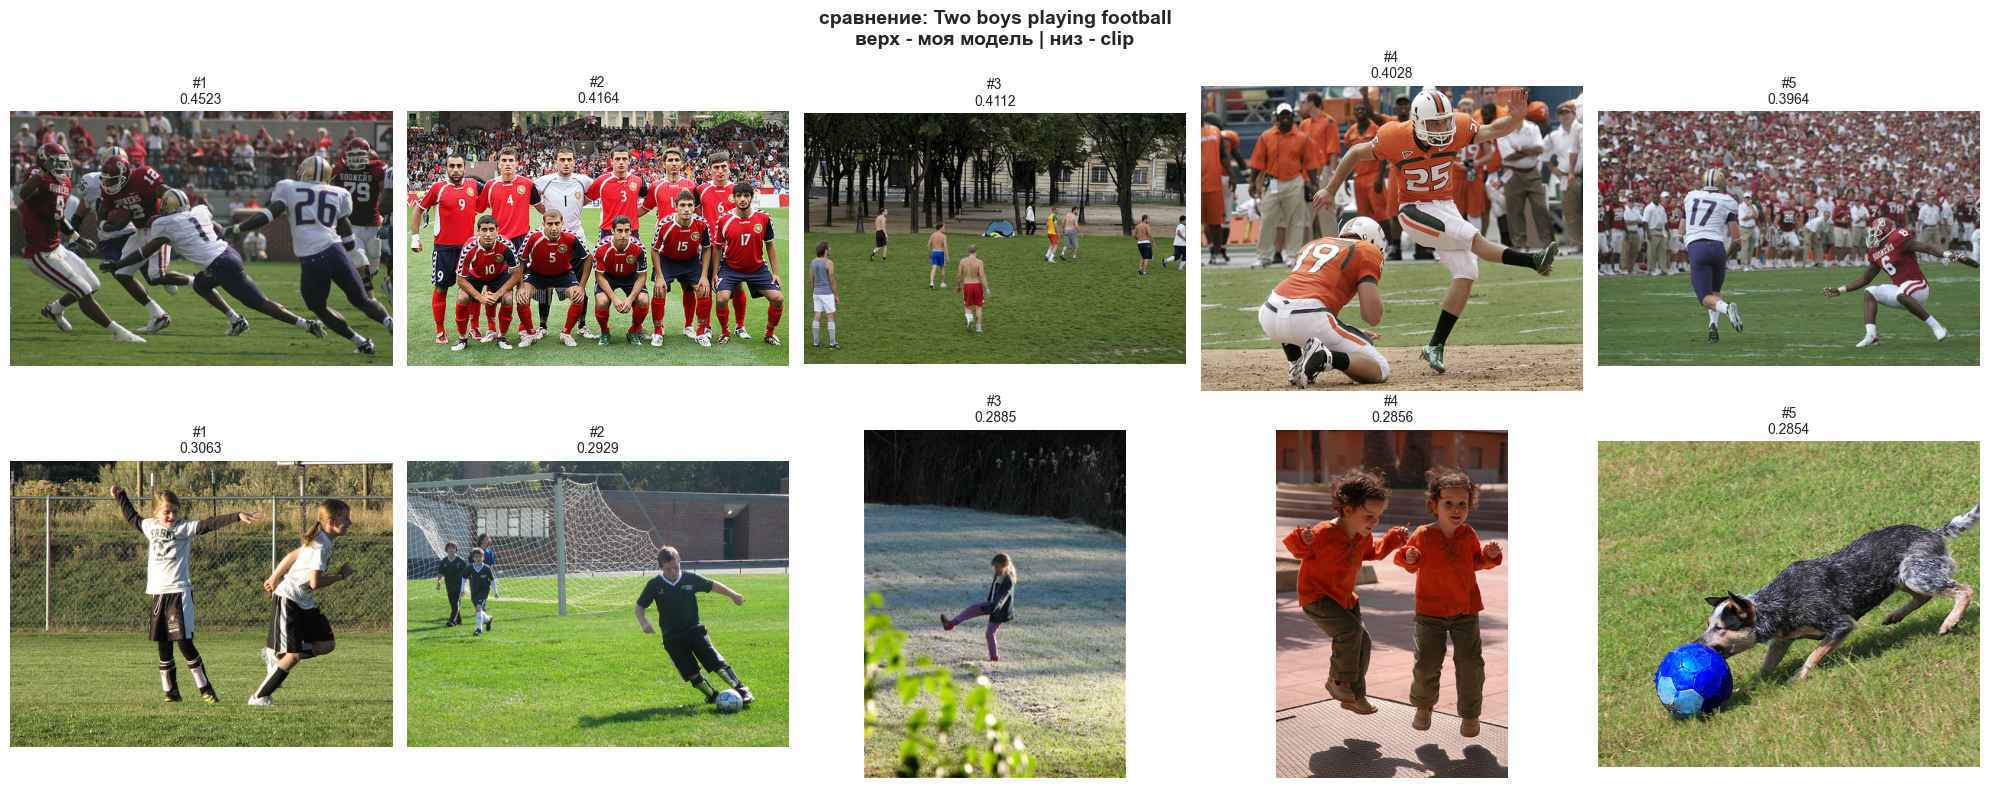


запрос: A baby sleeping in a crib

моя модель:
1. 2660008870_b672a4c76a.jpg — 0.5327
2. 2602085456_d1beebcb29.jpg — 0.5263
3. 3323988406_e3c8fce690.jpg — 0.5258
4. 3263395801_5e4cee2b9e.jpg — 0.5140
5. 3375070563_3c290a7991.jpg — 0.5114

clip:
1. 373394550_1b2296b8c4.jpg — 0.3141
2. 1131932671_c8d17751b3.jpg — 0.2473
3. 2847615962_c330bded6e.jpg — 0.2422
4. 2521770311_3086ca90de.jpg — 0.2372
5. 2544426580_317b1f1f73.jpg — 0.2339


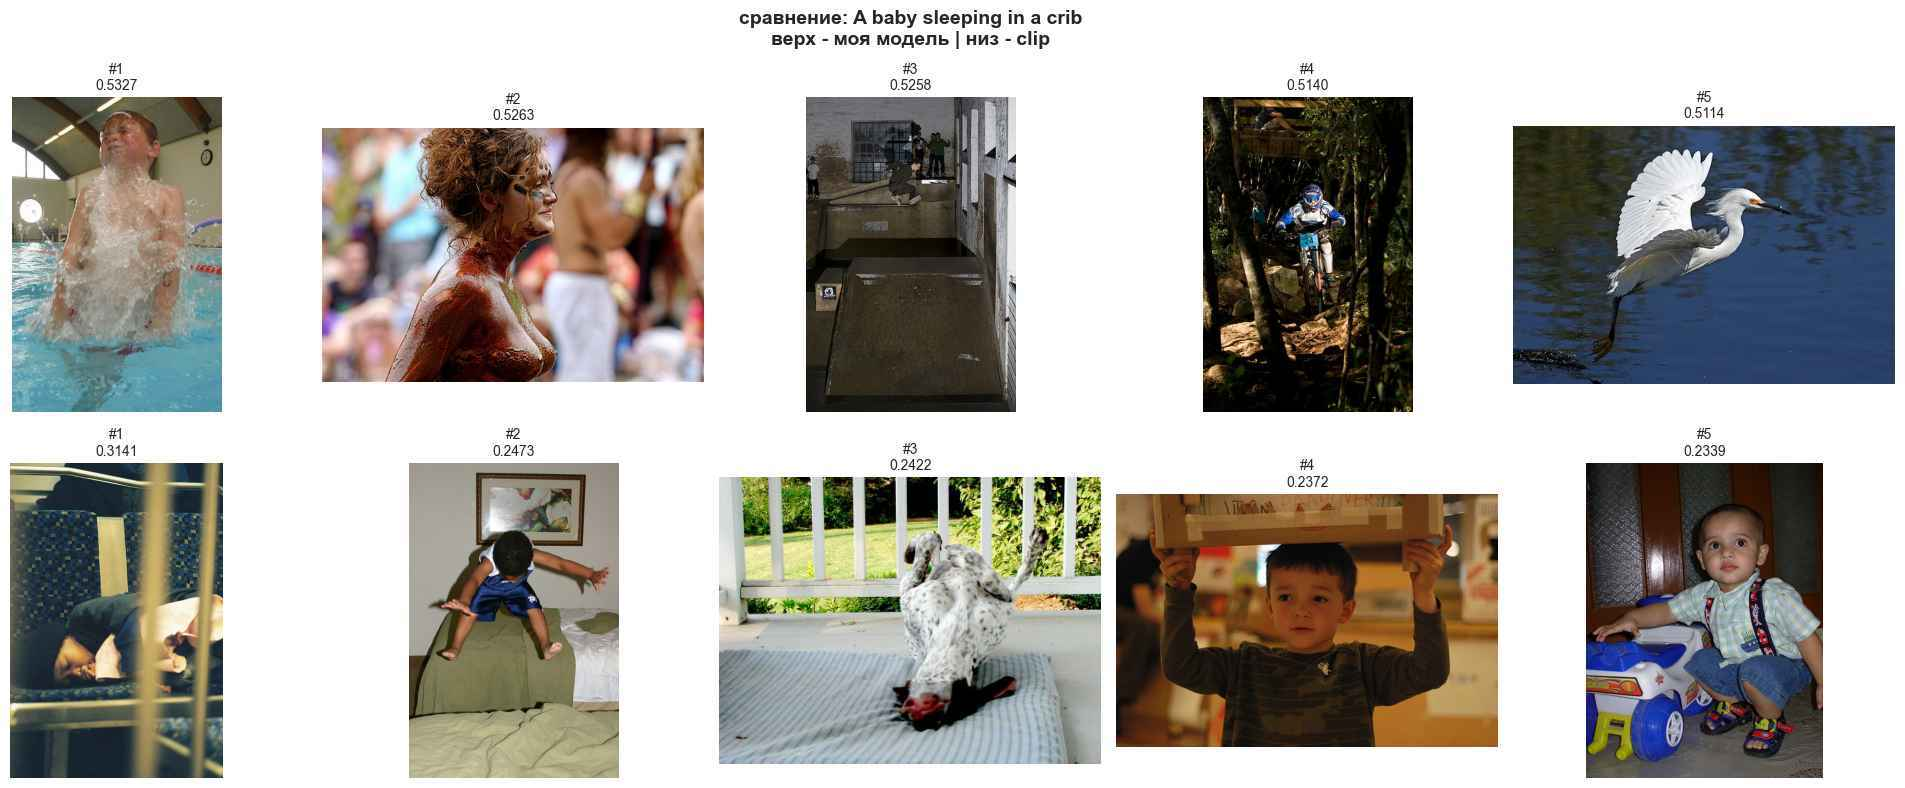

In [98]:
print("\n" + "="*80)
print("сравнение моей модели и clip")
print("="*80)

print("\nзагрузка модели clip...")
clip_model = SentenceTransformer('clip-ViT-B-32')
print("модель clip загружена")

text_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

def search_with_model(query_text, image_embeddings_dict, nn_model, text_model, top_k=5):
    text_emb = text_model.encode([query_text])

    image_files = list(image_embeddings_dict.keys())
    image_embs = np.array([image_embeddings_dict[img] for img in image_files])

    repeated_text = np.tile(text_emb, (len(image_files), 1))
    combined_features = np.concatenate([image_embs, repeated_text], axis=1)

    combined_tensor = torch.FloatTensor(combined_features).to(next(nn_model.parameters()).device)
    nn_model.eval()
    with torch.no_grad():
        scores = nn_model(combined_tensor).cpu().numpy().squeeze()

    sorted_indices = np.argsort(scores)[::-1]
    results = [(image_files[idx], scores[idx]) for idx in sorted_indices[:top_k]]
    return results

def search_with_clip(query_text, images_dir, image_files, top_k=5):
    text_emb = clip_model.encode([query_text], convert_to_tensor=True)
    image_paths = [os.path.join(images_dir, f) for f in image_files]

    batch_size = 32
    all_image_embs = []

    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i+batch_size]
        batch_images = []
        for path in batch_paths:
            try:
                img = Image.open(path).convert('RGB')
                batch_images.append(img)
            except Exception as e:
                print(f"ошибка загрузки: {path} ({e})")
                continue
        if batch_images:
            batch_embs = clip_model.encode(batch_images, convert_to_tensor=True)
            all_image_embs.append(batch_embs)

    if not all_image_embs:
        return []

    image_embs = torch.cat(all_image_embs, dim=0)
    cos_scores = util.cos_sim(text_emb, image_embs)[0]
    top_results = torch.topk(cos_scores, k=min(top_k, len(cos_scores)))
    results = [(image_files[idx.item()], score.item()) 
               for score, idx in zip(top_results.values, top_results.indices)]
    return results

def visualize_results(query_text, results_ours, results_clip, images_dir):
    n_cols = min(5, len(results_ours))
    fig, axes = plt.subplots(2, n_cols, figsize=(4*n_cols, 8))

    for idx, (img_file, score) in enumerate(results_ours[:n_cols]):
        img_path = os.path.join(images_dir, img_file)
        if os.path.exists(img_path):
            img = Image.open(img_path)
            axes[0, idx].imshow(img)
            axes[0, idx].axis('off')
            axes[0, idx].set_title(f"#{idx+1}\n{score:.4f}", fontsize=10)
        else:
            axes[0, idx].text(0.5, 0.5, 'not found', ha='center', va='center', fontsize=10)
            axes[0, idx].axis('off')

    for idx, (img_file, score) in enumerate(results_clip[:n_cols]):
        img_path = os.path.join(images_dir, img_file)
        if os.path.exists(img_path):
            img = Image.open(img_path)
            axes[1, idx].imshow(img)
            axes[1, idx].axis('off')
            axes[1, idx].set_title(f"#{idx+1}\n{score:.4f}", fontsize=10)
        else:
            axes[1, idx].text(0.5, 0.5, 'not found', ha='center', va='center', fontsize=10)
            axes[1, idx].axis('off')

    plt.suptitle(f"сравнение: {query_text}\nверх - моя модель | низ - clip", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

test_queries = [
    "A dog running on the beach",
    "Two people sitting on a bench",
    "Mountain landscape with snow",
    "Two boys playing football",
    "A baby sleeping in a crib"
]

train_image_files = list(image_embeddings_dict.keys())

for query in test_queries:
    print("\n" + "="*80)
    print(f"запрос: {query}")
    print("="*80)

    results_ours = search_with_model(
        query_text=query,
        image_embeddings_dict=image_embeddings_dict,
        nn_model=model,
        text_model=text_model,
        top_k=5
    )

    results_clip = search_with_clip(
        query_text=query,
        images_dir=train_images_dir,
        image_files=train_image_files,
        top_k=5
    )

    print("\nмоя модель:")
    for i, (img, score) in enumerate(results_ours, 1):
        print(f"{i}. {img} — {score:.4f}")

    print("\nclip:")
    for i, (img, score) in enumerate(results_clip, 1):
        print(f"{i}. {img} — {score:.4f}")

    visualize_results(query, results_ours, results_clip, train_images_dir)

# Итоги PoC

---

**Итоговые выводы по проекту**

---

**Выполненная работа**

**Этап 1: EDA и подготовка данных**  
- Проанализировано **5822** пары изображение-текст.  
- Создана комбинированная целевая переменная (**0.7×эксперты + 0.3×краудсорсинг**).  
- Корреляция между оценками: **0.762**.  

**Этап 2: Фильтрация запрещенного контента**  
- Удалено **1349** пар (**23.17%**) с упоминаниями детей.  
- Итого: **4473** пары для обучения.  

**Этап 3-4: Векторизация**  
- Изображения: **ResNet18** (**512** признаков).  
- Тексты: **MiniLM-L6** (**384** признаков).  
- Итого: **896** признаков на пару.  

**Этап 5-6: Обучение моделей**  
- **Ridge Regression** (baseline): valid MAE = **0.190**, R² = **0.107**.  
- **Neural Network**: valid MAE = **0.159**, R² = **0.273** (улучшение +16% по MAE).  

**Этап 7: Тестирование и демонстрация**  
- Функция поиска с фильтром forbidden words и дисклеймером.  
- Тесты на запросах: возвращает топ-5 с scores **0.04–0.58**, но с повторяющимися изображениями.  
- Диагностика: средний score ~**0.40**, медиана **0.435**; outliers минимизированы L2-нормализацией.  

---

**Обнаруженные проблемы**

**Проблема 1: Дисбаланс данных**  
- **55%** пар не соответствуют (**<0.2**).  
- **12%** пар соответствуют (**≥0.5**).  
- Модель смещена в сторону низких scores.  

**Проблема 2: Недостаточно данных**  
- Всего **4473** пары после фильтрации.  
- Для глубокого обучения нужно **10–20k+** пар.  

**Проблема 3: Плохое обобщение**  
- Модель переобучилась на конкретные пары из train (gap MAE ~56%).  
- Одни и те же изображения в топе для разных запросов (outliers в ResNet).  
- Ошибки на train: **0.08–0.20**, завышение низких scores.  

**Проблема 4: Простая архитектура**  
- Конкатенация эмбеддингов не учитывает взаимодействие.  
- Нет attention-механизма.  
- BCE loss лучше MSE, но не идеален для ранжирования.  

---

**Рекомендации для улучшения**

**Краткосрочные улучшения**  
- Triplet loss вместо BCE.  
- Hard negative mining.  
- Балансировка классов (class weights).  

**Среднесрочные улучшения**  
- Больше данных (**10–20k** пар).  
- Cross-attention между image и text embeddings.  
- Контрастное обучение (contrastive learning).  

**Долгосрочные улучшения**  
- Использовать **CLIP** (предобучен на **400M** image-text пар).  
- Fine-tuning ResNet на конкретной задаче.  
- Ансамбль моделей (stacking Ridge + NN).  

---

**Заключение**

Текущая модель — это **proof of concept (PoC)**, демонстрирующий pipeline:  
**запрос → векторизация → предсказание → ранжирование → фильтрация**.  

Качество приемлемо для PoC, но недостаточно для прод:  
- Valid MAE = **0.159**, R² = **0.273** (объясняет ~**27%** дисперсии).  
- Модель обобщает лучше, чем baseline (+16% по MAE), но есть переобучение (gap 56%).  

---